In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
import os
from os import listdir
from os.path import isfile, join
from enum import Enum
%load_ext autoreload
%autoreload 2
from ExtractInfoFromGrid import show_single_training_example_visually, read_single_training_example
# from ExtractInfoFromGrid import *
# from DatasetVisualization import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim


In [2]:
mypath = '../../ARC_Dataset/mini_training/OP_EQUAL_IP/NonColoredDataset'
onlyfiles_train = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles_train.sort()
print(f"Total files in mini training are {len(onlyfiles_train)}")

mypath = '../../ARC_Dataset/mini_testing/OP_EQUAL_IP/NonColoredDataset'
onlyfiles_test = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles_test.sort()
print(f"Total files in mini testing are {len(onlyfiles_test)}")

Total files in mini training are 59
Total files in mini testing are 43


Visualizing files in substitution category mini training
i = 4


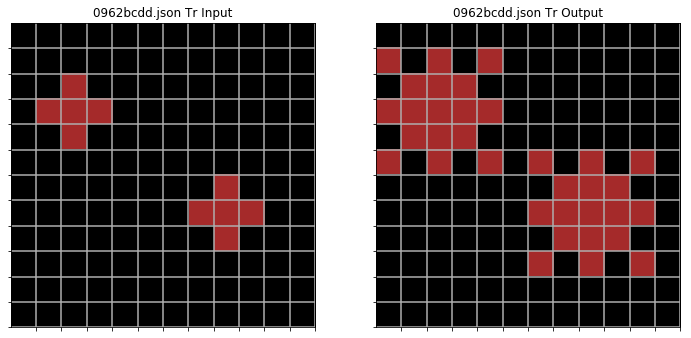

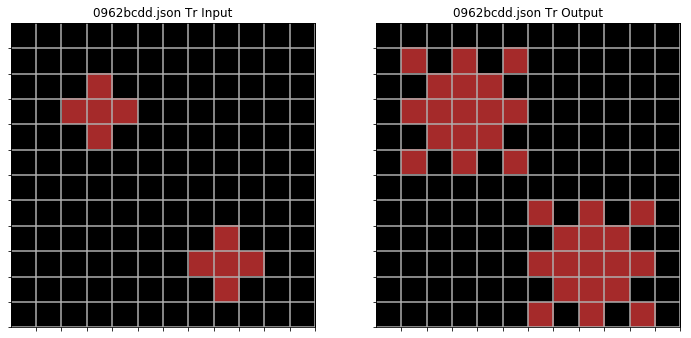

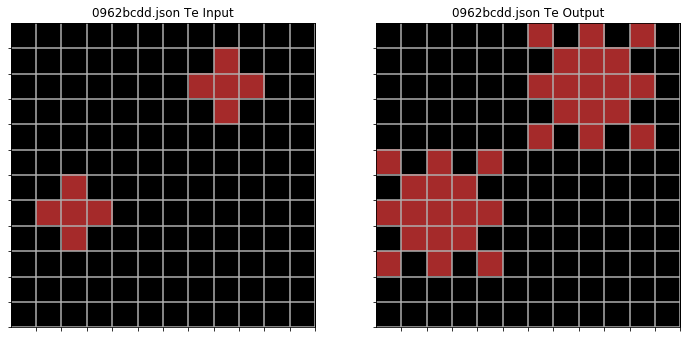

i = 19


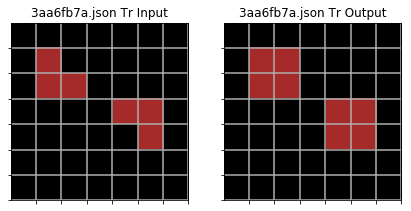

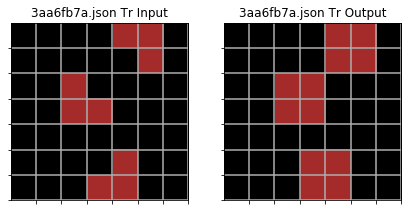

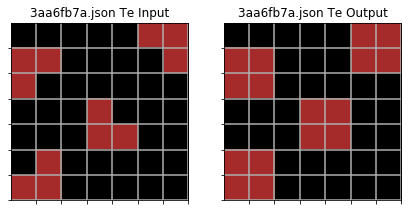

i = 20


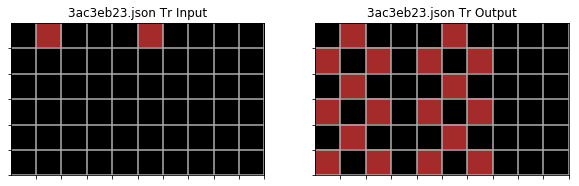

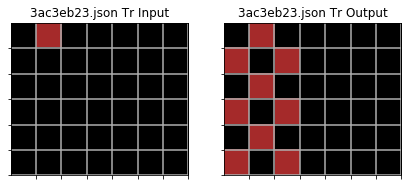

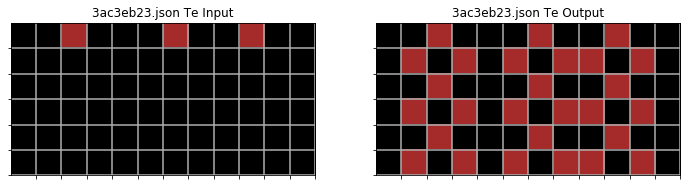

i = 21


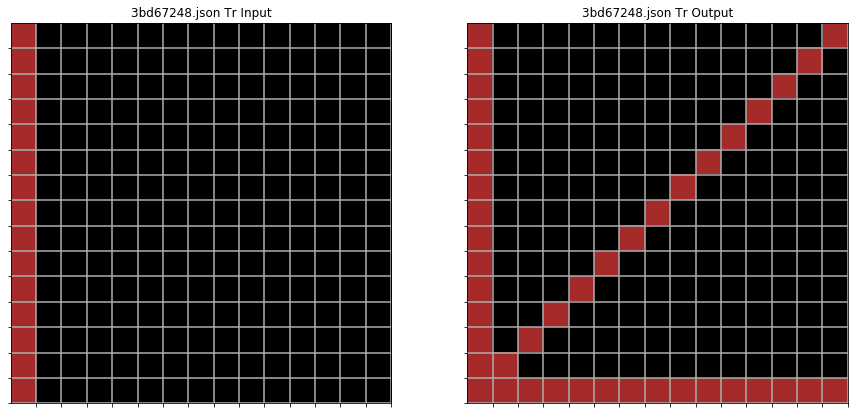

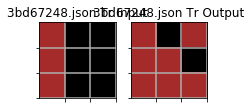

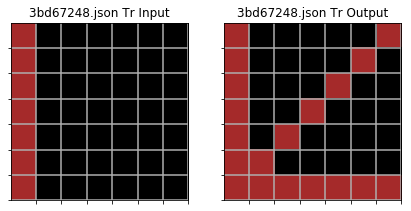

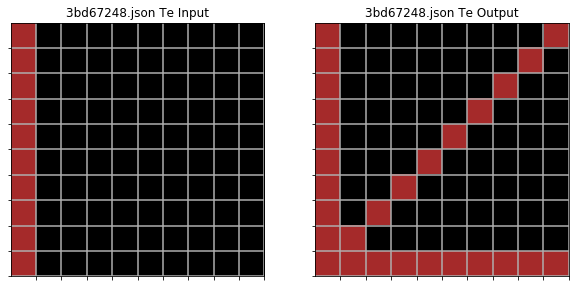

i = 22


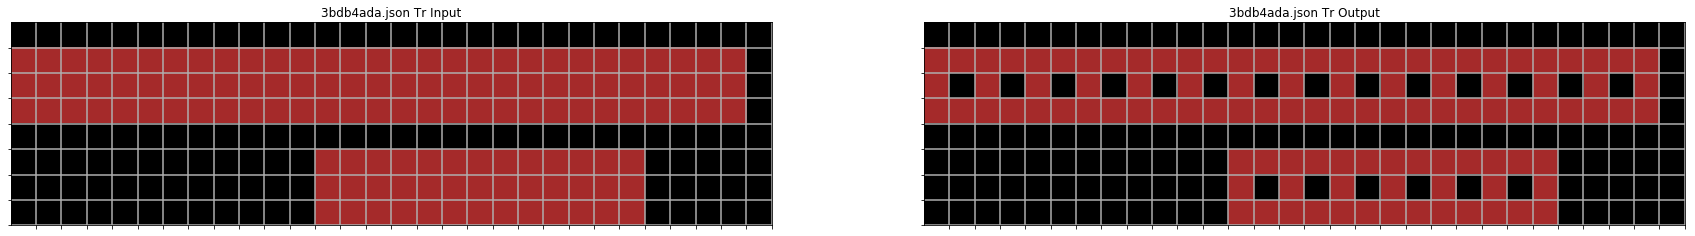

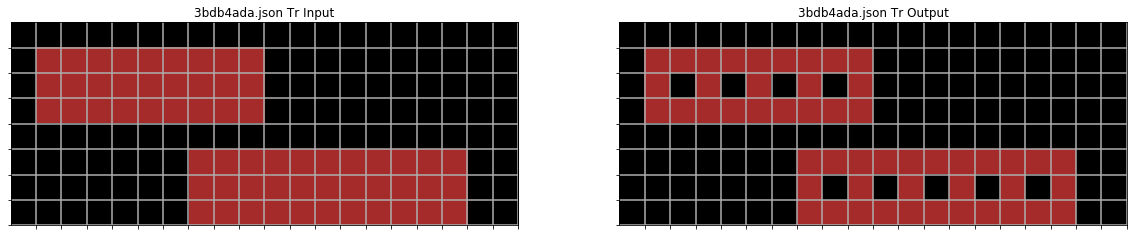

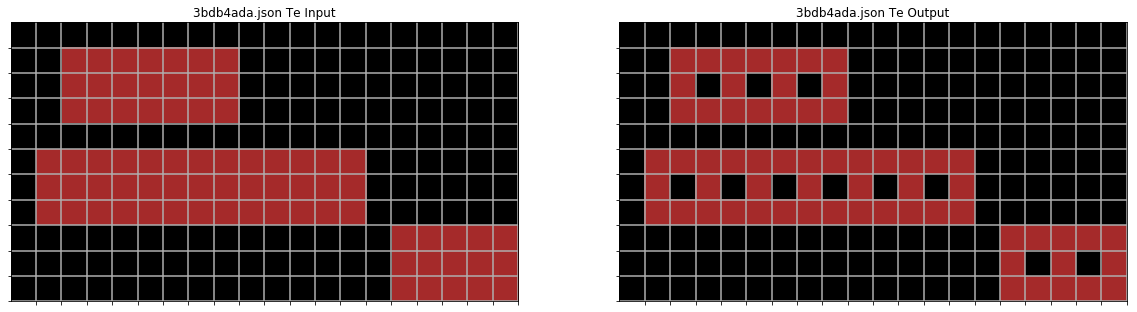

i = 23


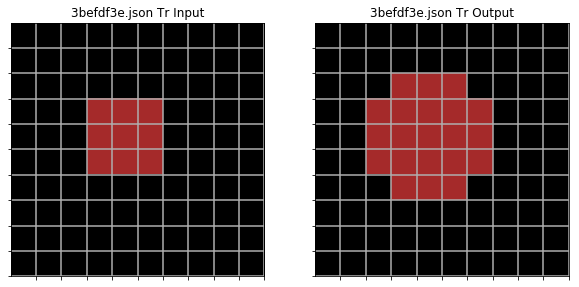

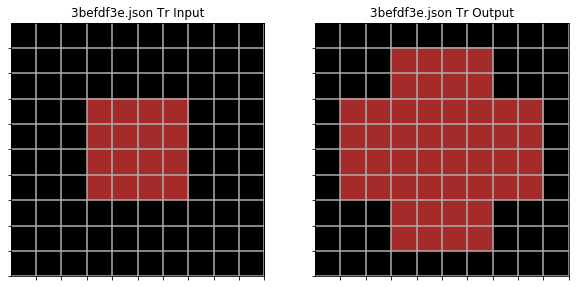

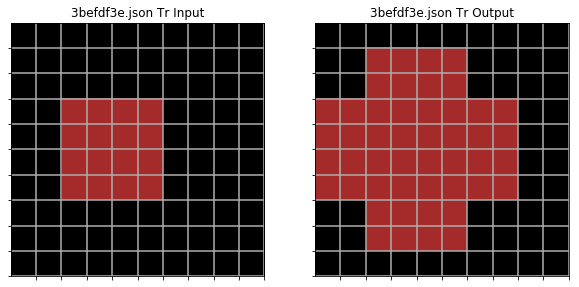

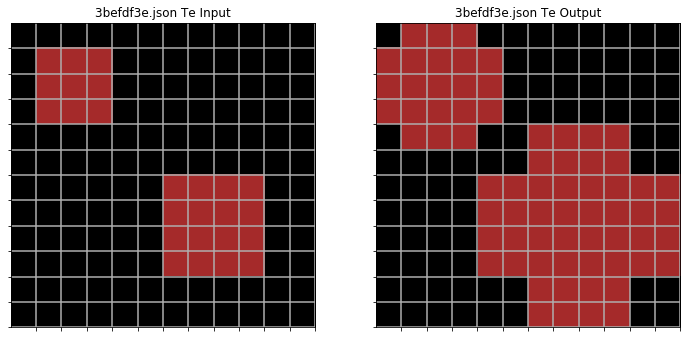

i = 25


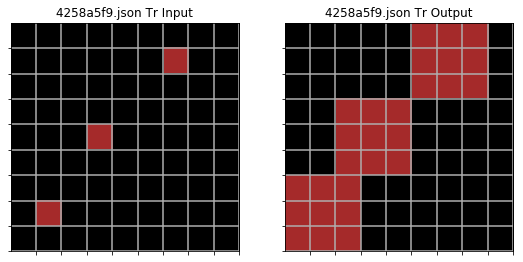

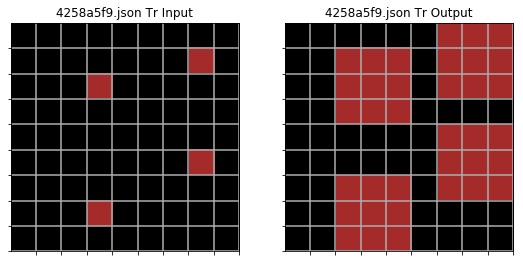

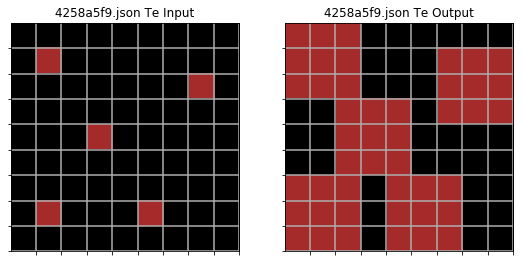

i = 26


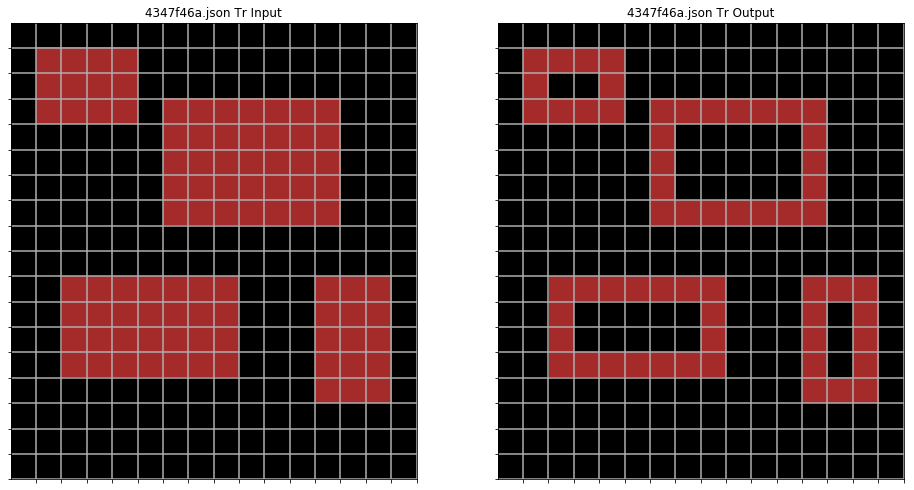

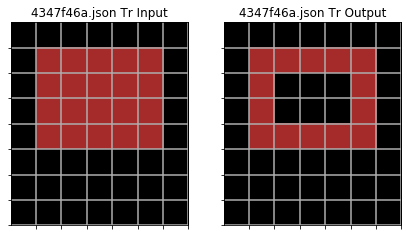

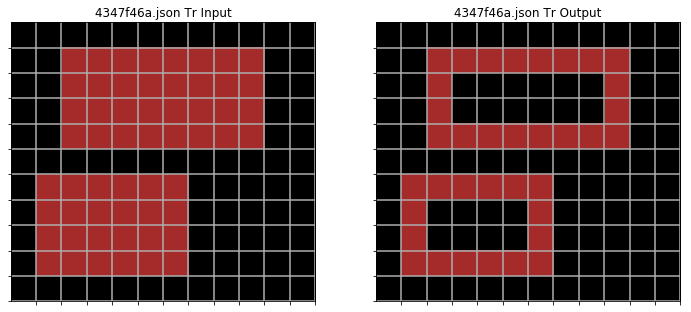

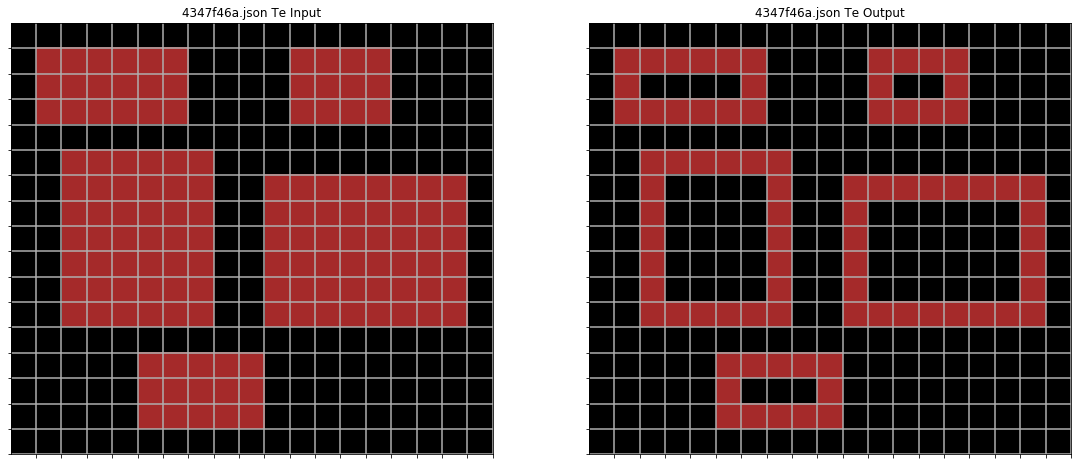

i = 33


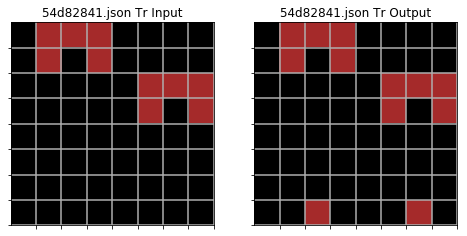

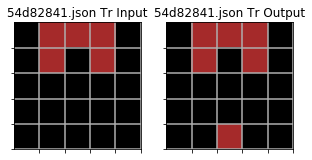

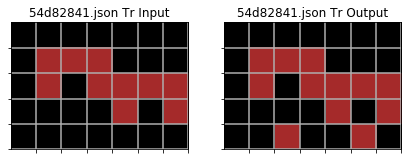

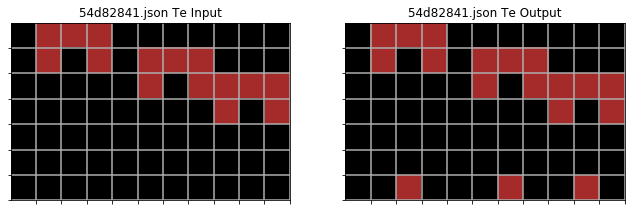

i = 36


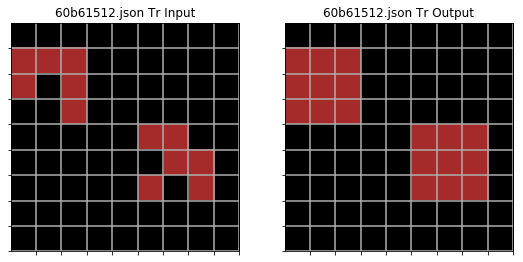

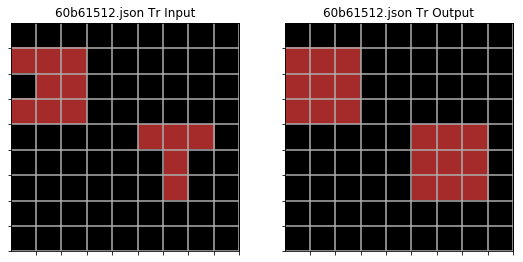

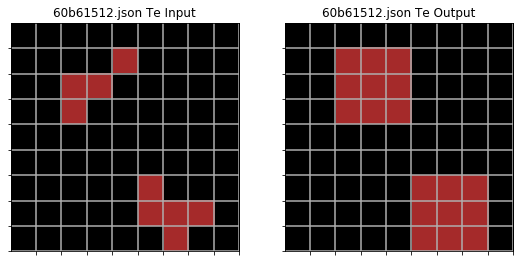

i = 39


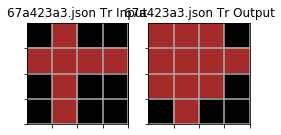

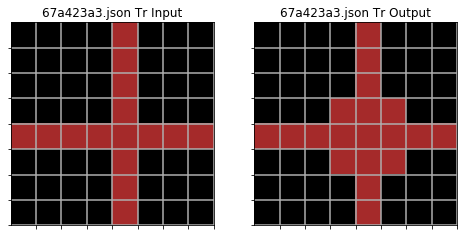

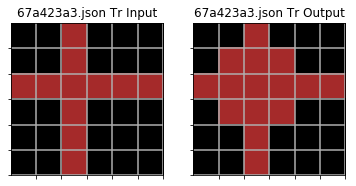

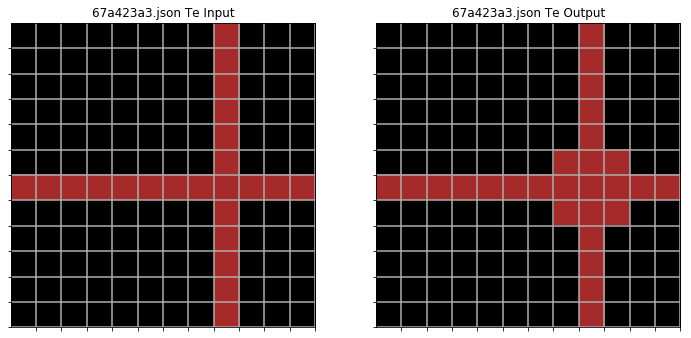

i = 40


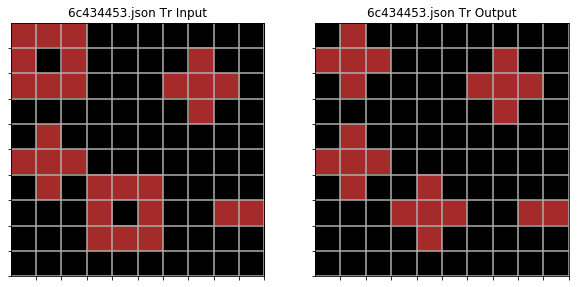

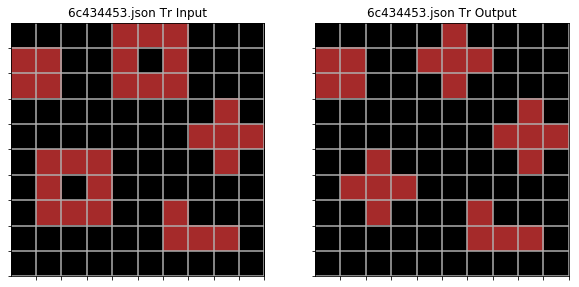

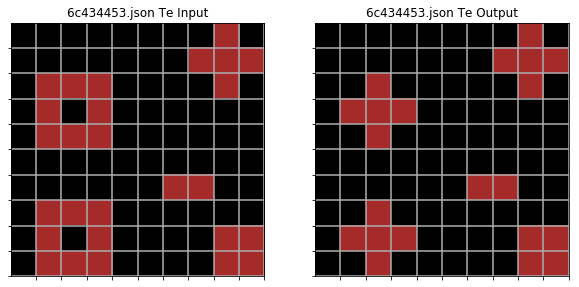

i = 41


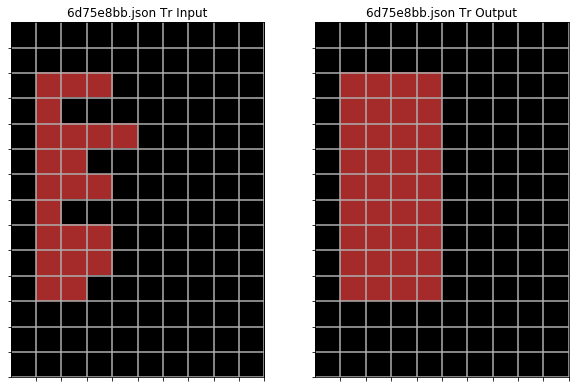

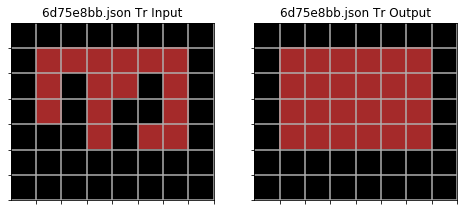

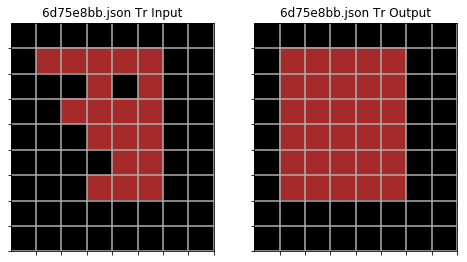

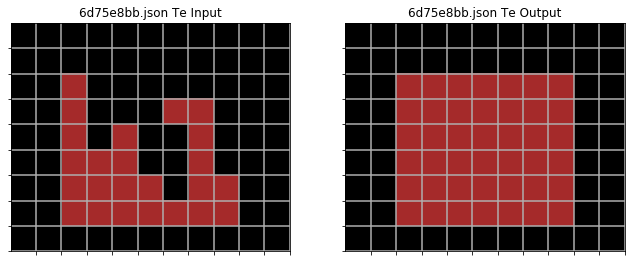

i = 46


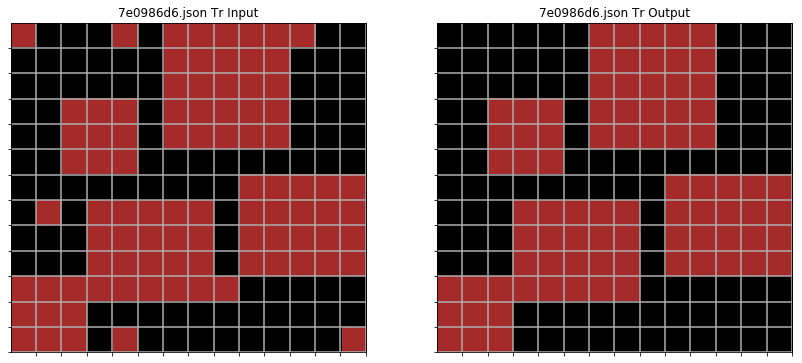

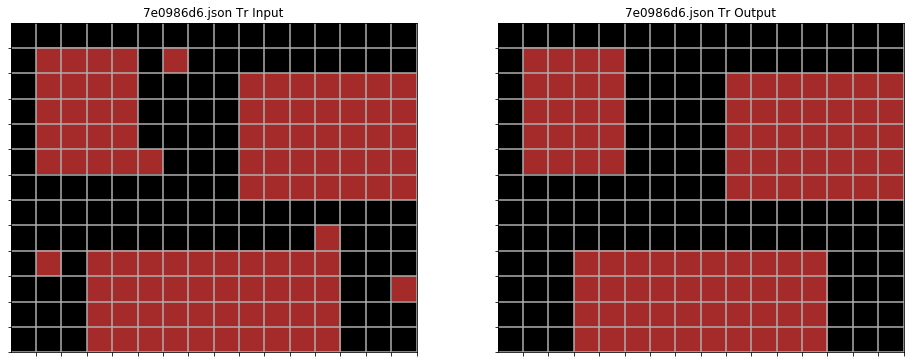

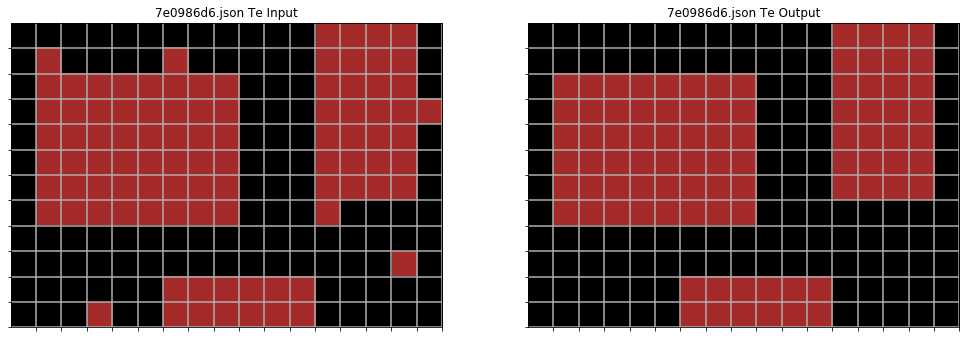

i = 47


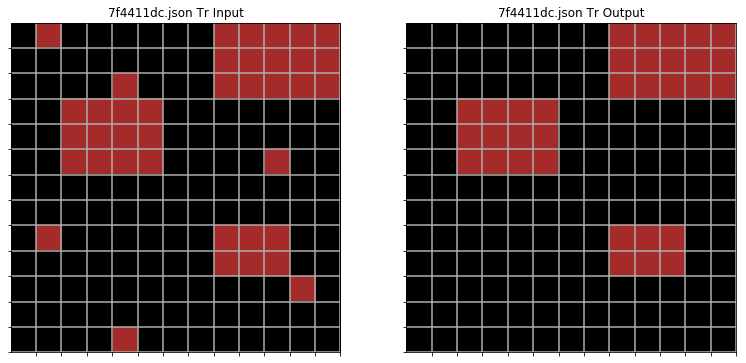

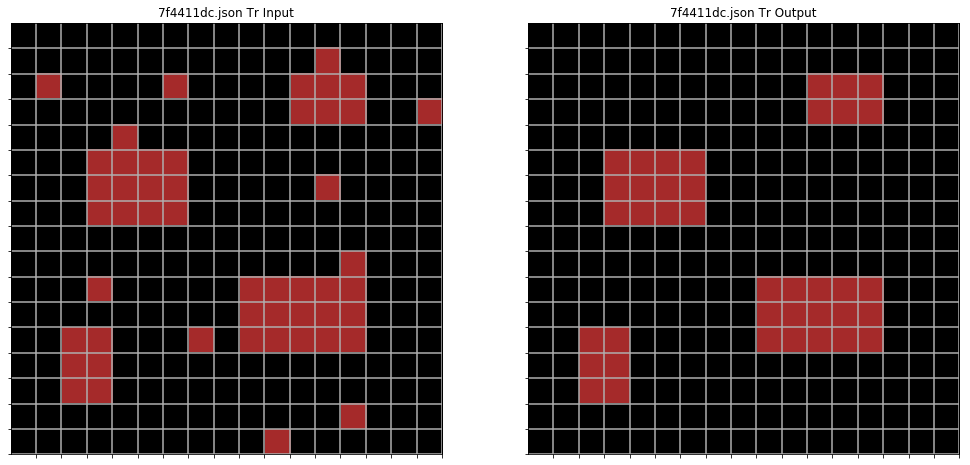

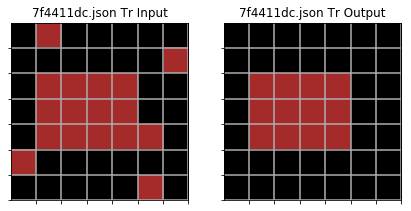

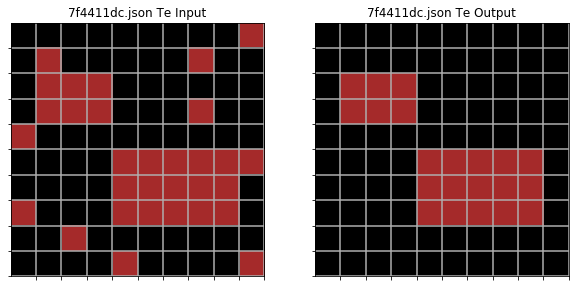

i = 48


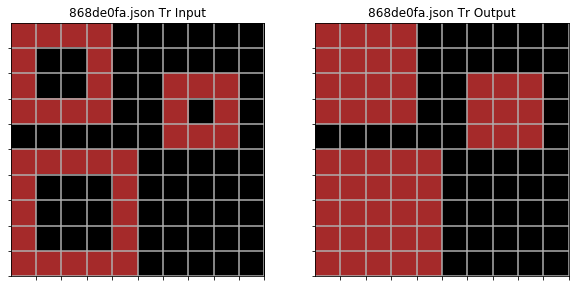

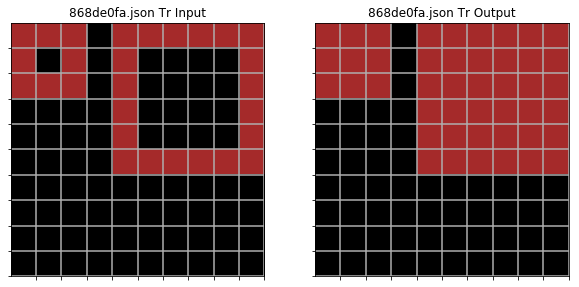

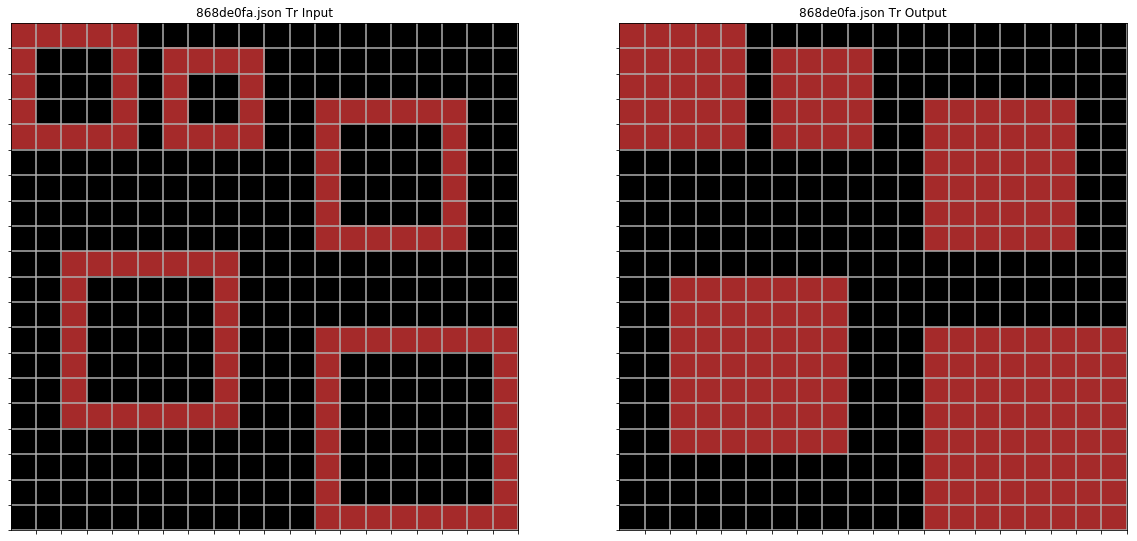

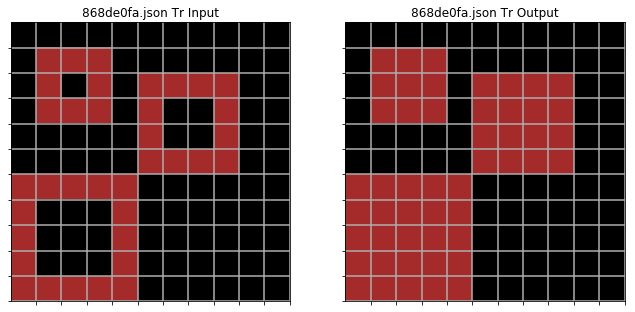

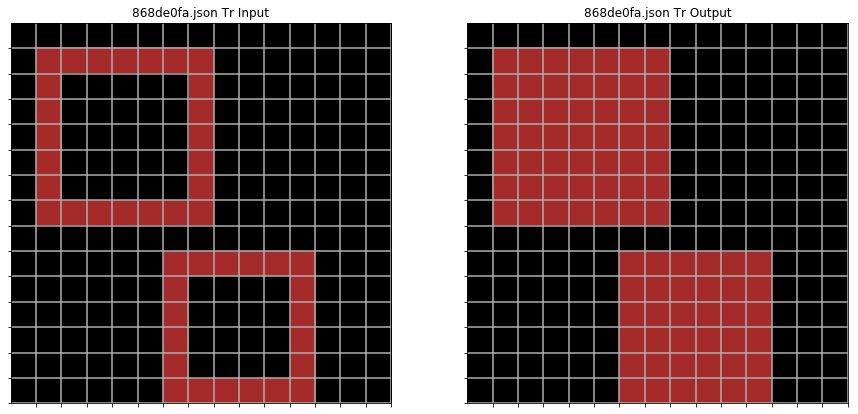

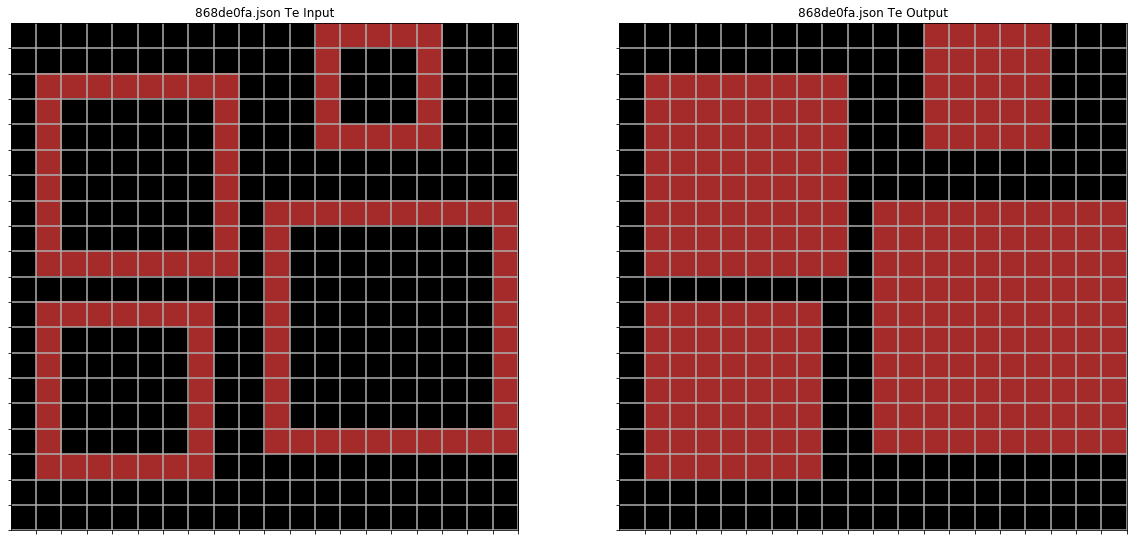

i = 52


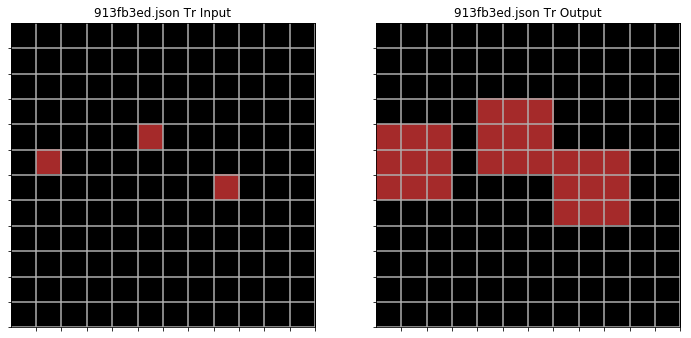

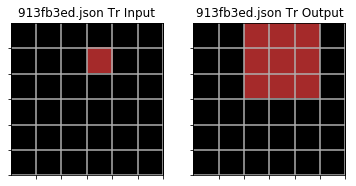

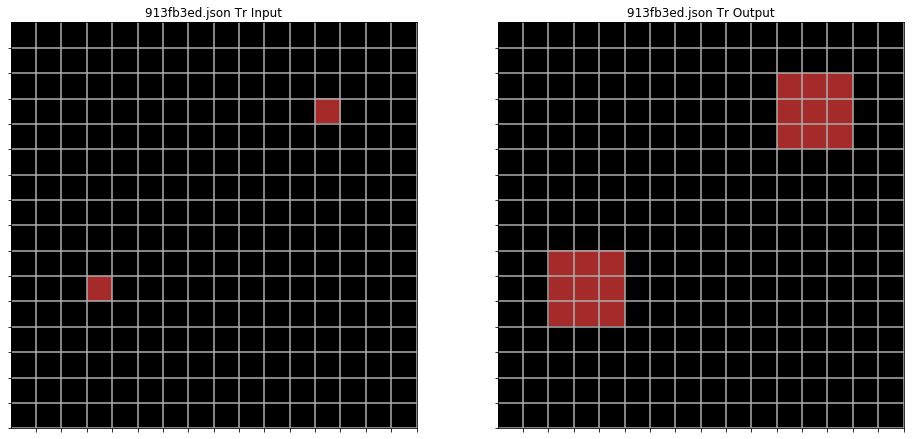

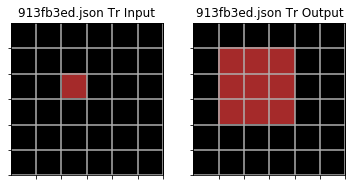

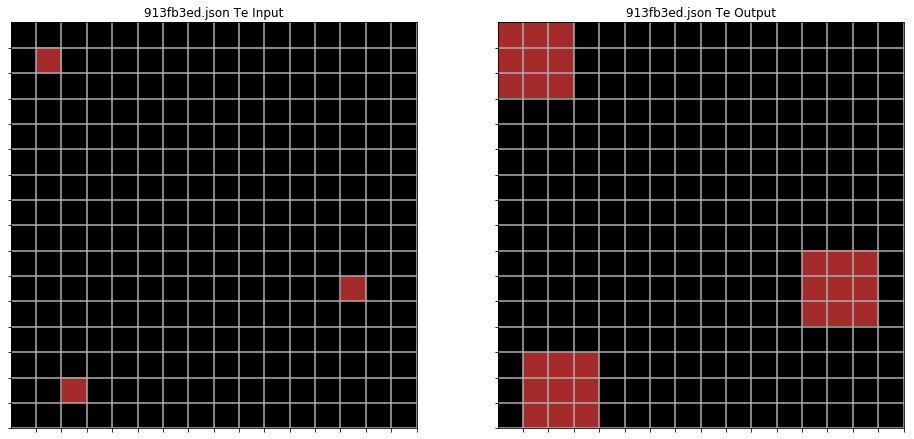

i = 54


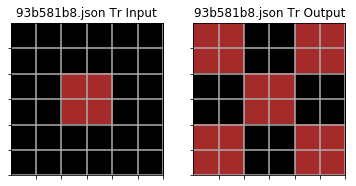

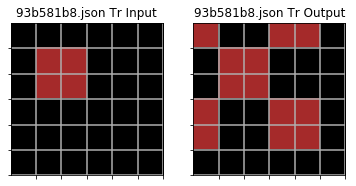

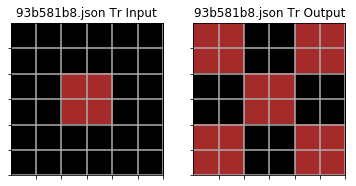

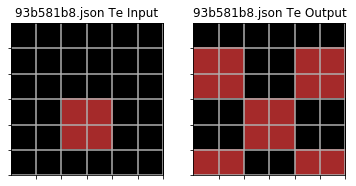

i = 55


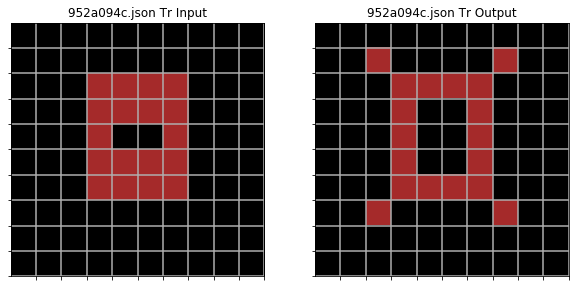

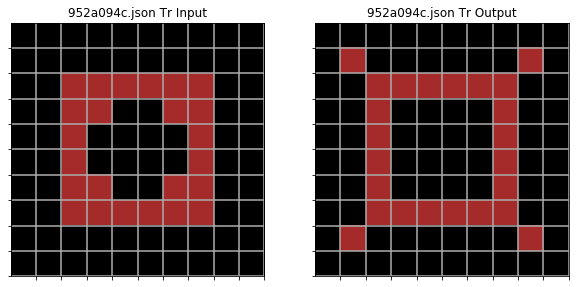

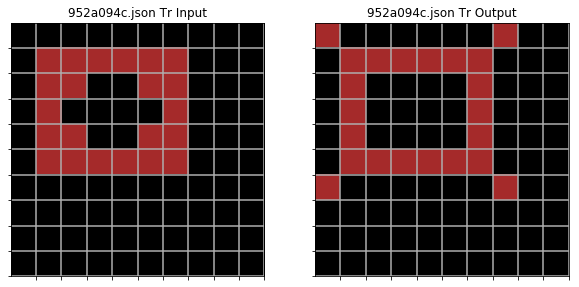

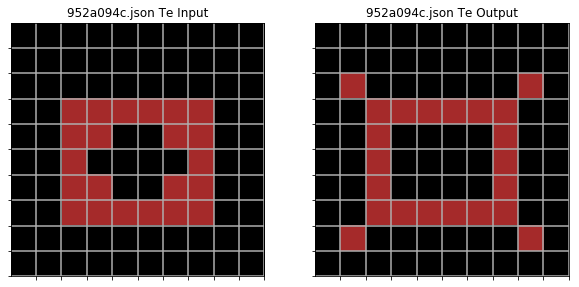

In [8]:
print('Visualizing files in substitution category mini training')
substitution_examples_train = [4, 19, 20, 21, 22, 23, 25, 26, 33, 36, 39, 40, 41, 46, 47, 48, 52, 54, 55]
for i in substitution_examples_train:
    print(f'i = {i}')
    filename = onlyfiles_train[i]
    train_list, test_list = read_single_training_example(filename)
    show_single_training_example_visually(train_list, test_list, filename, removeColorAsp=False, drawGridAroundObjects=False)

In [10]:
# print('Visualizing files in substitution category mini testing')
# substitution_examples_test = [0, 3, 11, 14, 20, 21, 23, 24, 27, 29, 31, 34, 36, 42]
# for i in substitution_examples_test:
#     print(f'i = {i}')
#     filename = onlyfiles_test[i]
#     train_list, test_list = read_single_training_example(filename)
#     show_single_training_example_visually(train_list, test_list, filename, removeColorAsp=False, drawGridAroundObjects=False)

In [71]:
class ARC_SUBSTITUTION1(nn.Module):
    
    def __init__(self, kernel_size, pad):
        super(ARC_SUBSTITUTION1, self).__init__()
        self.conv_1 = nn.Conv2d(1, 1, kernel_size, padding=pad)
    
    def forward(self, x):
        x = self.conv_1(x)
        x = torch.sigmoid(x)
        return x

In [179]:
class TrainTestModel():
    
    def __init__(self, ON, OFF, B = None, kernel_size = 3, pad = 1, reduction='mean', loss_function_type='default', exp_penalty=2):
        self.B = B
        self.ON = ON
        self.OFF = OFF
        self.kernel_size = kernel_size
        self.pad = pad
        self.reduction = reduction
        self.loss_function_type = loss_function_type
        self.exp_penalty =exp_penalty
        if (self.loss_function_type == 'mse'):
            self.reduction = 'none'
            self.exp_penalty = 2
        elif (self.loss_function_type == 'exp_penalty'):
            self.reduction = 'none'
        self.bce_loss = nn.BCELoss(reduction=self.reduction)
        #self.bce_loss = nn.BCELoss(reduction='none')
        self.decideModel()

    def augmentData(list_dicts, B, noAugment=False):
        #This will augment each pair B times
        ON, OFF = 9, 0
        aug_inputs = []
        aug_outputs = []
        aug_ONs = []
        aug_OFFs = []
        if (noAugment):
            print('Augmentation is OFF.')
            B = None
        for pair in list_dicts:
            augmented_pairs = {'input': [], 'output': [], 'ON': [], 'OFF': []}
            inp = np.array(pair['input'])
            op = np.array(pair['output'])
            assert np.logical_or(inp == ON, inp == OFF).all() == True, "It should have only 2 type of values"
            assert np.logical_or(op == ON, op == OFF).all() == True, "It should have only 2 type of values"
            count = 0
            for newOFF in np.arange(10):
                for newON in np.arange(10):
                    if (newON == newOFF):
                        continue
                    if (B is not None and count >= B):
                        continue
                    if (noAugment and (newOFF != OFF or newON != ON)):
                        #print(ON, OFF, newON, newOFF, newON != ON, newOFF != OFF, B, newOFF is not OFF or newON is not ON)
                        continue
                    newInp = np.zeros(inp.shape)
                    newInp[inp == ON] = newON
                    newInp[inp == OFF] = newOFF
                    newOp = np.zeros(op.shape)
                    newOp[op == ON] = newON
                    newOp[op == OFF] = newOFF
                    #We have a pair inp, op -> newIn, newOp
                    newInp = newInp.reshape((1, newInp.shape[0], newInp.shape[1]))
                    newOp = newOp.reshape((1, newOp.shape[0], newOp.shape[1]))
                    augmented_pairs['input'].append(newInp)
                    augmented_pairs['output'].append(newOp)
                    augmented_pairs['ON'].append(newON)
                    augmented_pairs['OFF'].append(newOFF)
                    count += 1
            augmented_pairs['input'] = np.array(augmented_pairs['input'])
            augmented_pairs['output'] = np.array(augmented_pairs['output'])
            augmented_pairs['ON'] = np.array(augmented_pairs['ON'])
            augmented_pairs['OFF'] = np.array(augmented_pairs['OFF'])
            aug_inputs.append(torch.from_numpy(augmented_pairs['input']).type(torch.float32))
            aug_outputs.append(torch.from_numpy(augmented_pairs['output']).type(torch.float32))
            aug_ONs.append(torch.from_numpy(augmented_pairs['ON']).type(torch.float32))
            aug_OFFs.append(torch.from_numpy(augmented_pairs['OFF']).type(torch.float32))
        return aug_inputs,\
               aug_outputs,\
               aug_ONs,\
               aug_OFFs
    
    def readData(self, filename, noAug=False):
        self.filename = filename
        self.train_list, self.test_list = read_single_training_example(filename)
        self.train_list_aug_input, self.train_list_aug_output, self.train_list_aug_ONs, self.train_list_aug_OFFs = \
            TrainTestModel.augmentData(self.train_list, self.B, noAugment=noAug) 
            
    def decideModel(self):
        self.model = ARC_SUBSTITUTION1(kernel_size = self.kernel_size, pad = self.pad) #Solved i = 25 in train
        #self.model = ARC_SUBSTITUTION1(kernel_size = 5, pad = 2) #Solved i = 25 in train
    
    def compute_loss(self, model_op, op_grid, ON):
        N, C, H, W = model_op.shape
        ON_flatten = ON.repeat(C*H*W)
        op_flatten = torch.flatten(op_grid)
        targets = torch.zeros(N*C*H*W, dtype=torch.float32)
        targets[ON_flatten == op_flatten] = 1     
        if (self.loss_function_type == 'default'):
            loss = self.bce_loss(torch.flatten(model_op), targets)
        if (self.loss_function_type == 'mse' or self.loss_function_type == 'exp_penalty'):
            loss = (self.bce_loss(torch.flatten(model_op), targets)) ** self.exp_penalty
        if (self.reduction == 'none'):
            loss = loss.mean()
        
        return loss       
    
    def train(self, epochs, print_every, test_every, learning_rate):
        self.model.train()
        numBatches = len(self.train_list_aug_input)
        #numBatches = 1
        optimizer = optim.SGD(self.model.parameters(), lr=learning_rate)
        for i in np.arange(1, epochs+1):
            for b in np.arange(numBatches):
                Xtrain_ip_grids_tensor = self.train_list_aug_input[b]
                Xtrain_op_grids_tensor = self.train_list_aug_output[b]
                ONs = self.train_list_aug_ONs[b]
                OFFs = self.train_list_aug_OFFs[b]
                #print(Xtrain_ip_grids_tensor.shape, Xtrain_op_grids_tensor.shape, ONs.shape, OFFs.shape)
                ytrain_op_preds = self.model(Xtrain_ip_grids_tensor)
                #print(ytrain_op_preds.shape)
                loss = self.compute_loss(ytrain_op_preds, Xtrain_op_grids_tensor, ONs)
                if (i % print_every == 0):
                    print(f'epoch: {i}, batch_id: {b}, loss: {loss}')
                self.model.zero_grad()
                loss.backward()
                optimizer.step()    
                
                #Check our progress
                actual_ip_grid = np.array(self.train_list[b]['input'])
                actual_ip_grid = actual_ip_grid.reshape((1, 1, actual_ip_grid.shape[0], actual_ip_grid.shape[1]))
                actual_ip_grid = torch.from_numpy(actual_ip_grid).type(torch.float32)

                actual_op_grid = np.array(self.train_list[b]['output'])
                actual_op_grid = actual_op_grid.reshape((1, 1, actual_op_grid.shape[0], actual_op_grid.shape[1]))
                actual_op_grid = torch.from_numpy(actual_op_grid).type(torch.float32)

                ytrain_op_pred_grid = self.pred_output_grid(actual_ip_grid, self.ON, self.OFF)
                if (print_every is not None and i % print_every == 0):
                    TrainTestModel.compare_grid_and_print_stats(actual_ip_grid, actual_op_grid, ytrain_op_pred_grid, header = '[TRAIN]')
                if (test_every is not None and i % test_every == 0):
                    #print(self.model(actual_ip_grid))
                    show_single_training_example_visually([{'input': np.squeeze(actual_ip_grid.data.numpy()), 'output': np.squeeze(ytrain_op_pred_grid.data.numpy())}], [],\
                                                          self.filename, removeColorAsp=False, drawGridAroundObjects=False)
                
        return
    
    def pred_output_grid(self, x, ON, OFF):
        op = self.model(x)
        output_grid = torch.zeros(op.shape)
        output_grid[op >= 0.5] = ON
        output_grid[op < 0.5] = OFF
        return output_grid
    
    def compare_grid_and_print_stats(actual_ip_grid, actual_op_grid, ytrain_op_grid, header=''):
        diff_cells = actual_ip_grid != actual_op_grid
        corr_pred = actual_op_grid == ytrain_op_grid
        accuracyOfModel = np.logical_and(diff_cells, corr_pred)
        accuracy = (100.0 * accuracyOfModel.sum())/(diff_cells.sum())
        accuracy_overall = (100.0 * corr_pred.sum())/(corr_pred.numel())
        print(f'{header} {accuracyOfModel.sum()} elements matched out of {diff_cells.sum()} diff. elements.\
        Accuracy: {accuracy}. Overall Accuracy: {accuracy_overall}')
        return accuracy, accuracy_overall
    
    def test(self):
        for test_pair_input in self.train_list:
            actual_ip_grid = np.array(test_pair_input['input'])
            actual_ip_grid = actual_ip_grid.reshape((1, 1, actual_ip_grid.shape[0], actual_ip_grid.shape[1]))
            actual_ip_grid = torch.from_numpy(actual_ip_grid).type(torch.float32)

            actual_op_grid = np.array(test_pair_input['output'])
            actual_op_grid = actual_op_grid.reshape((1, 1, actual_op_grid.shape[0], actual_op_grid.shape[1]))
            actual_op_grid = torch.from_numpy(actual_op_grid).type(torch.float32)

            ytrain_op_pred_grid = self.pred_output_grid(actual_ip_grid, self.ON, self.OFF)
            print('actual ip grid', actual_ip_grid)
            print('actual op grid', actual_op_grid)
            print('pred   op grid', ytrain_op_pred_grid)
            accuracy, accuracy_overall = TrainTestModel.compare_grid_and_print_stats(actual_ip_grid, actual_op_grid, ytrain_op_pred_grid, header = '[TEST]')
            print('Training Data')
            show_single_training_example_visually(self.train_list, [], self.filename, removeColorAsp=False, drawGridAroundObjects=False)
            print('Expected Output')
            show_single_training_example_visually([], self.test_list, self.filename, removeColorAsp=False, drawGridAroundObjects=False)
            print('Actual Output')
            show_single_training_example_visually([], [{'input': np.squeeze(actual_ip_grid.data.numpy()), 'output': np.squeeze(ytrain_op_pred_grid.data.numpy())}], self.filename, removeColorAsp=False, drawGridAroundObjects=False)
            if (accuracy_overall == 100.0):
                print('Task successfully solved.')
            else:
                print('NN not able to solve the task')
        for test_pair_input in self.test_list:
            actual_ip_grid = np.array(test_pair_input['input'])
            actual_ip_grid = actual_ip_grid.reshape((1, 1, actual_ip_grid.shape[0], actual_ip_grid.shape[1]))
            actual_ip_grid = torch.from_numpy(actual_ip_grid).type(torch.float32)

            actual_op_grid = np.array(test_pair_input['output'])
            actual_op_grid = actual_op_grid.reshape((1, 1, actual_op_grid.shape[0], actual_op_grid.shape[1]))
            actual_op_grid = torch.from_numpy(actual_op_grid).type(torch.float32)

            ytrain_op_pred_grid = self.pred_output_grid(actual_ip_grid, self.ON, self.OFF)
            print('actual ip grid', actual_ip_grid)
            print('actual op grid', actual_op_grid)
            print('pred   op grid', ytrain_op_pred_grid)
            accuracy, accuracy_overall = TrainTestModel.compare_grid_and_print_stats(actual_ip_grid, actual_op_grid, ytrain_op_pred_grid, header = '[TEST]')
            print('Training Data')
            show_single_training_example_visually(self.train_list, [], self.filename, removeColorAsp=False, drawGridAroundObjects=False)
            print('Expected Output')
            show_single_training_example_visually([], self.test_list, self.filename, removeColorAsp=False, drawGridAroundObjects=False)
            print('Actual Output')
            show_single_training_example_visually([], [{'input': np.squeeze(actual_ip_grid.data.numpy()), 'output': np.squeeze(ytrain_op_pred_grid.data.numpy())}], self.filename, removeColorAsp=False, drawGridAroundObjects=False)
            if (accuracy_overall == 100.0):
                print('Task successfully solved.')
            else:
                print('NN not able to solve the task')
            
 
# i = 25
# ttm = TrainTestModel(ON=9, OFF=0, B = 1)
# ttm.readData(onlyfiles_train[i])
# ttm.train(1000)
# ttm.test()

Augmentation is OFF.
epoch: 1, batch_id: 0, loss: 1.5938409566879272
[TRAIN] 2 elements matched out of 8 diff. elements.        Accuracy: 25.0. Overall Accuracy: 68.0
epoch: 1, batch_id: 1, loss: 1.5044437646865845
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 63.0
epoch: 1, batch_id: 2, loss: 0.9553369283676147
[TRAIN] 3 elements matched out of 8 diff. elements.        Accuracy: 37.5. Overall Accuracy: 72.0
epoch: 2, batch_id: 0, loss: 0.726621687412262
[TRAIN] 2 elements matched out of 8 diff. elements.        Accuracy: 25.0. Overall Accuracy: 73.0
epoch: 2, batch_id: 1, loss: 0.7434722781181335
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 71.0
epoch: 2, batch_id: 2, loss: 0.6128318905830383
[TRAIN] 3 elements matched out of 8 diff. elements.        Accuracy: 37.5. Overall Accuracy: 75.0
epoch: 3, batch_id: 0, loss: 0.5512433052062988
[TRAIN] 2 elements matched out of 8 diff. elements.     

[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 91.0
epoch: 24, batch_id: 2, loss: 0.26695796847343445
[TRAIN] 3 elements matched out of 8 diff. elements.        Accuracy: 37.5. Overall Accuracy: 95.0
epoch: 25, batch_id: 0, loss: 0.28613993525505066
[TRAIN] 3 elements matched out of 8 diff. elements.        Accuracy: 37.5. Overall Accuracy: 93.0
epoch: 25, batch_id: 1, loss: 0.22604133188724518
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 91.0
epoch: 25, batch_id: 2, loss: 0.2650638222694397
[TRAIN] 3 elements matched out of 8 diff. elements.        Accuracy: 37.5. Overall Accuracy: 95.0
epoch: 26, batch_id: 0, loss: 0.2841150164604187
[TRAIN] 3 elements matched out of 8 diff. elements.        Accuracy: 37.5. Overall Accuracy: 93.0
epoch: 26, batch_id: 1, loss: 0.2250954806804657
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 91.0
epoch: 26, batch_id:

epoch: 48, batch_id: 2, loss: 0.23732729256153107
[TRAIN] 2 elements matched out of 8 diff. elements.        Accuracy: 25.0. Overall Accuracy: 94.0
epoch: 49, batch_id: 0, loss: 0.2553863525390625
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 49, batch_id: 1, loss: 0.21463966369628906
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 49, batch_id: 2, loss: 0.23649188876152039
[TRAIN] 2 elements matched out of 8 diff. elements.        Accuracy: 25.0. Overall Accuracy: 94.0
epoch: 50, batch_id: 0, loss: 0.2545377314090729
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 50, batch_id: 1, loss: 0.2143915742635727
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 50, batch_id: 2, loss: 0.2356746792793274
[TRAIN] 2 elements matched out of 8 diff. elements.        Accuracy:

epoch: 73, batch_id: 1, loss: 0.21027012169361115
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 73, batch_id: 2, loss: 0.22053131461143494
[TRAIN] 3 elements matched out of 8 diff. elements.        Accuracy: 37.5. Overall Accuracy: 95.0
epoch: 74, batch_id: 0, loss: 0.23811081051826477
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 74, batch_id: 1, loss: 0.21013984084129333
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 74, batch_id: 2, loss: 0.21999134123325348
[TRAIN] 3 elements matched out of 8 diff. elements.        Accuracy: 37.5. Overall Accuracy: 95.0
epoch: 75, batch_id: 0, loss: 0.23754432797431946
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 75, batch_id: 1, loss: 0.21001258492469788
[TRAIN] 0 elements matched out of 8 diff. elements.        Accur

epoch: 100, batch_id: 0, loss: 0.22530823945999146
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 100, batch_id: 1, loss: 0.20761638879776
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 100, batch_id: 2, loss: 0.20811527967453003
[TRAIN] 3 elements matched out of 8 diff. elements.        Accuracy: 37.5. Overall Accuracy: 95.0
epoch: 101, batch_id: 0, loss: 0.2248828262090683
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 101, batch_id: 1, loss: 0.20754604041576385
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 101, batch_id: 2, loss: 0.20772585272789001
[TRAIN] 3 elements matched out of 8 diff. elements.        Accuracy: 37.5. Overall Accuracy: 95.0
epoch: 102, batch_id: 0, loss: 0.22446148097515106
[TRAIN] 4 elements matched out of 8 diff. elements.        Ac

epoch: 127, batch_id: 0, loss: 0.2151067703962326
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 127, batch_id: 1, loss: 0.20620857179164886
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 127, batch_id: 2, loss: 0.19885505735874176
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 128, batch_id: 0, loss: 0.2147740125656128
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 128, batch_id: 1, loss: 0.2061731517314911
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 128, batch_id: 2, loss: 0.1985553801059723
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 129, batch_id: 0, loss: 0.21444401144981384
[TRAIN] 4 elements matched out of 8 diff. elements.        Ac

epoch: 154, batch_id: 0, loss: 0.2070133537054062
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 154, batch_id: 1, loss: 0.2055644541978836
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 154, batch_id: 2, loss: 0.19160404801368713
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 155, batch_id: 0, loss: 0.20674553513526917
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 155, batch_id: 1, loss: 0.2055514007806778
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 155, batch_id: 2, loss: 0.19136543571949005
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 156, batch_id: 0, loss: 0.20647983253002167
[TRAIN] 4 elements matched out of 8 diff. elements.        A

epoch: 179, batch_id: 2, loss: 0.18616370856761932
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 180, batch_id: 0, loss: 0.20066119730472565
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 180, batch_id: 1, loss: 0.2054150402545929
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 180, batch_id: 2, loss: 0.18596690893173218
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 181, batch_id: 0, loss: 0.20044006407260895
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 181, batch_id: 1, loss: 0.20541620254516602
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 181, batch_id: 2, loss: 0.18577155470848083
[TRAIN] 4 elements matched out of 8 diff. elements.       

[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 207, batch_id: 1, loss: 0.20558327436447144
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 207, batch_id: 2, loss: 0.1811600923538208
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 208, batch_id: 0, loss: 0.19501136243343353
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 208, batch_id: 1, loss: 0.2055942565202713
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 208, batch_id: 2, loss: 0.18099918961524963
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 209, batch_id: 0, loss: 0.19482862949371338
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 209, 

[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 234, batch_id: 0, loss: 0.19062396883964539
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 234, batch_id: 1, loss: 0.205968976020813
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 234, batch_id: 2, loss: 0.17718006670475006
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 235, batch_id: 0, loss: 0.19046927988529205
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 235, batch_id: 1, loss: 0.2059863656759262
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 235, batch_id: 2, loss: 0.17704607546329498
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 236, b

[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 261, batch_id: 1, loss: 0.2064952701330185
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 261, batch_id: 2, loss: 0.17385292053222656
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 262, batch_id: 0, loss: 0.18662841618061066
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 262, batch_id: 1, loss: 0.20651672780513763
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 262, batch_id: 2, loss: 0.1737404763698578
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 263, batch_id: 0, loss: 0.1864977478981018
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 263, b

epoch: 285, batch_id: 1, loss: 0.20703807473182678
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 285, batch_id: 2, loss: 0.17133863270282745
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 286, batch_id: 0, loss: 0.18369132280349731
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 286, batch_id: 1, loss: 0.2070617824792862
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 286, batch_id: 2, loss: 0.17124174535274506
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 287, batch_id: 0, loss: 0.1835775226354599
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 287, batch_id: 1, loss: 0.2070855349302292
[TRAIN] 0 elements matched out of 8 diff. elements.        A

epoch: 310, batch_id: 1, loss: 0.2076490819454193
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 310, batch_id: 2, loss: 0.1690840870141983
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 311, batch_id: 0, loss: 0.1810256391763687
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 311, batch_id: 1, loss: 0.20767420530319214
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 311, batch_id: 2, loss: 0.1690007448196411
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 312, batch_id: 0, loss: 0.1809263974428177
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 312, batch_id: 1, loss: 0.20769931375980377
[TRAIN] 0 elements matched out of 8 diff. elements.        Acc

[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 335, batch_id: 1, loss: 0.20828592777252197
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 335, batch_id: 2, loss: 0.1671396642923355
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 336, batch_id: 0, loss: 0.1786964237689972
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 336, batch_id: 1, loss: 0.20831170678138733
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 336, batch_id: 2, loss: 0.16706761717796326
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 337, batch_id: 0, loss: 0.17860950529575348
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 337, 

[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 359, batch_id: 2, loss: 0.16551795601844788
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 360, batch_id: 0, loss: 0.17672772705554962
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 360, batch_id: 1, loss: 0.20893342792987823
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 360, batch_id: 2, loss: 0.1654549539089203
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 361, batch_id: 0, loss: 0.176650732755661
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 361, batch_id: 1, loss: 0.20895935595035553
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 361, ba

epoch: 384, batch_id: 0, loss: 0.1749821901321411
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 384, batch_id: 1, loss: 0.20955492556095123
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 384, batch_id: 2, loss: 0.16404412686824799
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 385, batch_id: 0, loss: 0.17491386830806732
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 385, batch_id: 1, loss: 0.2095806896686554
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 385, batch_id: 2, loss: 0.16398927569389343
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 386, batch_id: 0, loss: 0.17484581470489502
[TRAIN] 4 elements matched out of 8 diff. elements.        

epoch: 407, batch_id: 0, loss: 0.17348983883857727
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 407, batch_id: 1, loss: 0.2101440280675888
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 407, batch_id: 2, loss: 0.16285397112369537
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 408, batch_id: 0, loss: 0.17342859506607056
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 408, batch_id: 1, loss: 0.21016937494277954
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 408, batch_id: 2, loss: 0.162805438041687
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 409, batch_id: 0, loss: 0.17336761951446533
[TRAIN] 4 elements matched out of 8 diff. elements.        A

epoch: 431, batch_id: 1, loss: 0.21074706315994263
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 431, batch_id: 2, loss: 0.16175717115402222
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 432, batch_id: 0, loss: 0.1720408946275711
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 432, batch_id: 1, loss: 0.21077190339565277
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 432, batch_id: 2, loss: 0.1617143452167511
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 433, batch_id: 0, loss: 0.17198637127876282
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 433, batch_id: 1, loss: 0.21079665422439575
[TRAIN] 0 elements matched out of 8 diff. elements.        

epoch: 456, batch_id: 0, loss: 0.17079739272594452
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 456, batch_id: 1, loss: 0.21135888993740082
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 456, batch_id: 2, loss: 0.16075026988983154
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 457, batch_id: 0, loss: 0.17074838280677795
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 457, batch_id: 1, loss: 0.21138298511505127
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 457, batch_id: 2, loss: 0.1607125997543335
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 458, batch_id: 0, loss: 0.17069967091083527
[TRAIN] 4 elements matched out of 8 diff. elements.       

[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 481, batch_id: 0, loss: 0.16963563859462738
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 481, batch_id: 1, loss: 0.2119513303041458
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 481, batch_id: 2, loss: 0.1598626673221588
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 482, batch_id: 0, loss: 0.1695917844772339
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 482, batch_id: 1, loss: 0.21197456121444702
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 482, batch_id: 2, loss: 0.15982937812805176
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 483, b

[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 504, batch_id: 1, loss: 0.2124776393175125
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 504, batch_id: 2, loss: 0.15913714468479156
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 505, batch_id: 0, loss: 0.1686325967311859
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 505, batch_id: 1, loss: 0.21250008046627045
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 505, batch_id: 2, loss: 0.15910741686820984
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 506, batch_id: 0, loss: 0.16859300434589386
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 506, 

[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 536, batch_id: 2, loss: 0.15825247764587402
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 537, batch_id: 0, loss: 0.16744354367256165
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 537, batch_id: 1, loss: 0.21319973468780518
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 537, batch_id: 2, loss: 0.15822696685791016
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 538, batch_id: 0, loss: 0.16740888357162476
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 538, batch_id: 1, loss: 0.21322102844715118
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 538,

epoch: 560, batch_id: 1, loss: 0.2136794924736023
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 560, batch_id: 2, loss: 0.15767112374305725
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 561, batch_id: 0, loss: 0.16664861142635345
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 561, batch_id: 1, loss: 0.21369989216327667
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 561, batch_id: 2, loss: 0.1576482355594635
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 562, batch_id: 0, loss: 0.16661718487739563
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 562, batch_id: 1, loss: 0.21372026205062866
[TRAIN] 0 elements matched out of 8 diff. elements.        

[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 582, batch_id: 0, loss: 0.16601306200027466
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 582, batch_id: 1, loss: 0.21412009000778198
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 582, batch_id: 2, loss: 0.15719173848628998
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 583, batch_id: 0, loss: 0.16598401963710785
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 583, batch_id: 1, loss: 0.21413972973823547
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 583, batch_id: 2, loss: 0.15717105567455292
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 584

epoch: 616, batch_id: 0, loss: 0.16508835554122925
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 616, batch_id: 1, loss: 0.2147662490606308
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 616, batch_id: 2, loss: 0.15653829276561737
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 617, batch_id: 0, loss: 0.16506294906139374
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 617, batch_id: 1, loss: 0.21478460729122162
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 617, batch_id: 2, loss: 0.1565205156803131
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 618, batch_id: 0, loss: 0.1650375872850418
[TRAIN] 4 elements matched out of 8 diff. elements.        A

[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 648, batch_id: 0, loss: 0.1643209606409073
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 648, batch_id: 1, loss: 0.21533657610416412
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 648, batch_id: 2, loss: 0.15600651502609253
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 649, batch_id: 0, loss: 0.164298415184021
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 649, batch_id: 1, loss: 0.2153538316488266
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 649, batch_id: 2, loss: 0.1559910625219345
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 650, bat

epoch: 674, batch_id: 1, loss: 0.21577373147010803
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 674, batch_id: 2, loss: 0.15562525391578674
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 675, batch_id: 0, loss: 0.16374075412750244
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 675, batch_id: 1, loss: 0.21579009294509888
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 675, batch_id: 2, loss: 0.15561139583587646
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 676, batch_id: 0, loss: 0.16372032463550568
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 676, batch_id: 1, loss: 0.21580640971660614
[TRAIN] 0 elements matched out of 8 diff. elements.      

epoch: 700, batch_id: 1, loss: 0.2161882370710373
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 700, batch_id: 2, loss: 0.15528354048728943
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 701, batch_id: 0, loss: 0.16323329508304596
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 701, batch_id: 1, loss: 0.2162037342786789
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 701, batch_id: 2, loss: 0.15527109801769257
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 702, batch_id: 0, loss: 0.16321474313735962
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 702, batch_id: 1, loss: 0.2162192016839981
[TRAIN] 0 elements matched out of 8 diff. elements.        A

[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 723, batch_id: 2, loss: 0.15501044690608978
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 724, batch_id: 0, loss: 0.16282202303409576
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 724, batch_id: 1, loss: 0.21655145287513733
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 724, batch_id: 2, loss: 0.15499912202358246
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 725, batch_id: 0, loss: 0.16280488669872284
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 725, batch_id: 1, loss: 0.21656617522239685
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 725,

[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 744, batch_id: 1, loss: 0.21684040129184723
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 744, batch_id: 2, loss: 0.1547824591398239
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 745, batch_id: 0, loss: 0.1624743640422821
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 745, batch_id: 1, loss: 0.2168545126914978
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 745, batch_id: 2, loss: 0.15477211773395538
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 746, batch_id: 0, loss: 0.1624584048986435
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 746, ba

[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 768, batch_id: 2, loss: 0.154544398188591
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 769, batch_id: 0, loss: 0.16210666298866272
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 769, batch_id: 1, loss: 0.21718469262123108
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 769, batch_id: 2, loss: 0.1545349508523941
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 770, batch_id: 0, loss: 0.16209200024604797
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 770, batch_id: 1, loss: 0.21719804406166077
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 770, ba

[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 793, batch_id: 1, loss: 0.21749821305274963
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 793, batch_id: 2, loss: 0.15431924164295197
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 794, batch_id: 0, loss: 0.16175419092178345
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 794, batch_id: 1, loss: 0.2175108939409256
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 794, batch_id: 2, loss: 0.1543106585741043
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 795, batch_id: 0, loss: 0.16174069046974182
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 795, 

epoch: 817, batch_id: 1, loss: 0.21779577434062958
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 817, batch_id: 2, loss: 0.15412268042564392
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 818, batch_id: 0, loss: 0.16144245862960815
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 818, batch_id: 1, loss: 0.2178078591823578
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 818, batch_id: 2, loss: 0.15411490201950073
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 819, batch_id: 0, loss: 0.1614299714565277
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 819, batch_id: 1, loss: 0.21781989932060242
[TRAIN] 0 elements matched out of 8 diff. elements.        

epoch: 841, batch_id: 0, loss: 0.1611659675836563
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 841, batch_id: 1, loss: 0.218078151345253
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 841, batch_id: 2, loss: 0.15394341945648193
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 842, batch_id: 0, loss: 0.1611543893814087
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 842, batch_id: 1, loss: 0.21808958053588867
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 842, batch_id: 2, loss: 0.15393632650375366
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 843, batch_id: 0, loss: 0.16114287078380585
[TRAIN] 4 elements matched out of 8 diff. elements.        Ac

[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 865, batch_id: 1, loss: 0.21834596991539001
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 865, batch_id: 2, loss: 0.15377959609031677
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 866, batch_id: 0, loss: 0.1608879119157791
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 866, batch_id: 1, loss: 0.21835683286190033
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 866, batch_id: 2, loss: 0.15377311408519745
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 867, batch_id: 0, loss: 0.16087721288204193
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 867,

epoch: 890, batch_id: 0, loss: 0.16064110398292542
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 890, batch_id: 1, loss: 0.2186102420091629
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 890, batch_id: 2, loss: 0.15362383425235748
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 891, batch_id: 0, loss: 0.1606311798095703
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 891, batch_id: 1, loss: 0.21862047910690308
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 891, batch_id: 2, loss: 0.15361790359020233
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 892, batch_id: 0, loss: 0.16062137484550476
[TRAIN] 4 elements matched out of 8 diff. elements.        

epoch: 914, batch_id: 0, loss: 0.1604122668504715
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 914, batch_id: 1, loss: 0.21885041892528534
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 914, batch_id: 2, loss: 0.15348705649375916
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 915, batch_id: 0, loss: 0.16040311753749847
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 915, batch_id: 1, loss: 0.21886014938354492
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 915, batch_id: 2, loss: 0.1534816026687622
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 916, batch_id: 0, loss: 0.16039396822452545
[TRAIN] 4 elements matched out of 8 diff. elements.        

[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 939, batch_id: 0, loss: 0.16019146144390106
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 939, batch_id: 1, loss: 0.21908730268478394
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 939, batch_id: 2, loss: 0.1533566415309906
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 940, batch_id: 0, loss: 0.16018299758434296
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 940, batch_id: 1, loss: 0.21909646689891815
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 940, batch_id: 2, loss: 0.15335169434547424
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 941,

[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 964, batch_id: 2, loss: 0.15323728322982788
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 965, batch_id: 0, loss: 0.15997906029224396
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 965, batch_id: 1, loss: 0.2193198800086975
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 965, batch_id: 2, loss: 0.15323273837566376
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 966, batch_id: 0, loss: 0.15997125208377838
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 966, batch_id: 1, loss: 0.21932858228683472
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 966, 

[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 990, batch_id: 1, loss: 0.21953105926513672
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 990, batch_id: 2, loss: 0.15312376618385315
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 991, batch_id: 0, loss: 0.15978287160396576
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 991, batch_id: 1, loss: 0.21953924000263214
[TRAIN] 0 elements matched out of 8 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.0
epoch: 991, batch_id: 2, loss: 0.15311960875988007
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 992, batch_id: 0, loss: 0.15977561473846436
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.0
epoch: 992

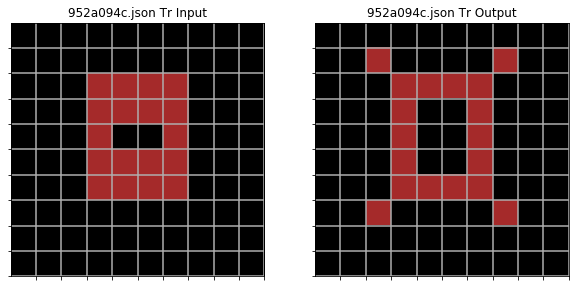

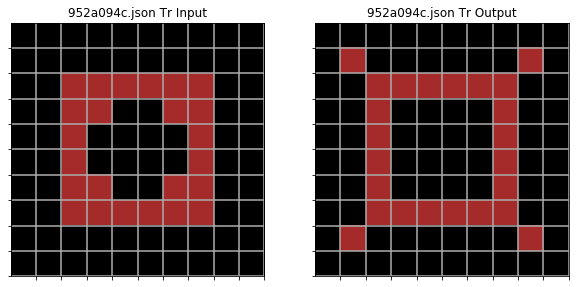

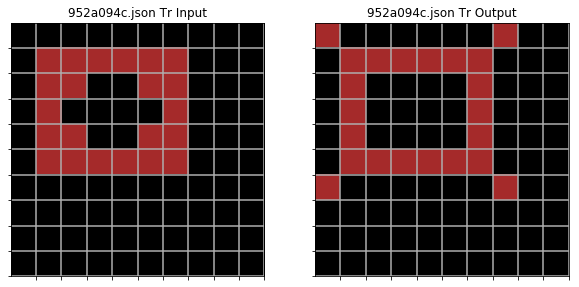

Expected Output


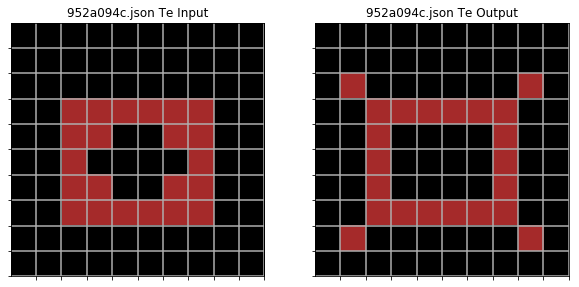

Actual Output


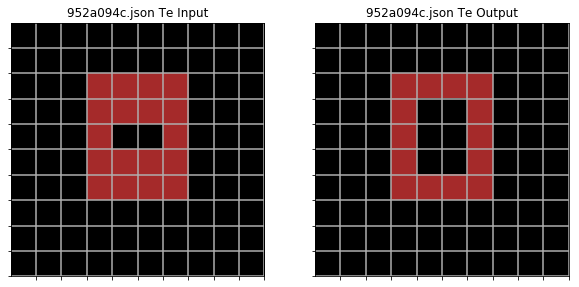

NN not able to solve the task
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 0., 0.],
          [0., 0., 9., 9., 0., 0., 9., 9., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 9., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 9., 0., 0.],
          [0., 0., 9., 9., 0., 0., 9., 9., 0., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 0., 0., 0., 0., 0., 0., 9., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 9., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 9., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 9., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 9., 0., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 0., 0.],
 

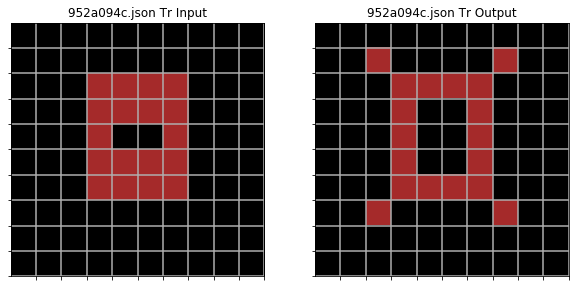

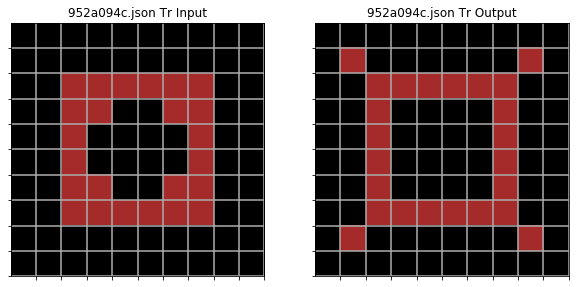

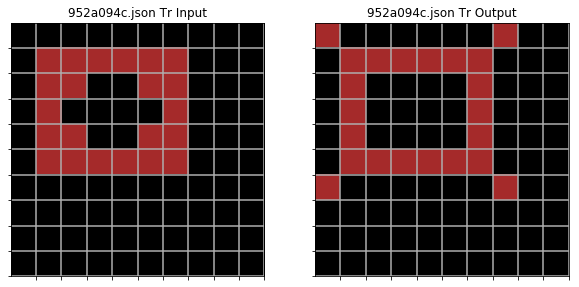

Expected Output


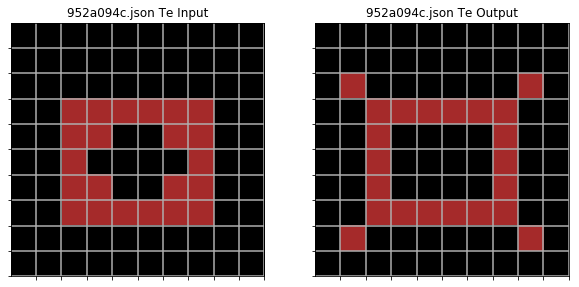

Actual Output


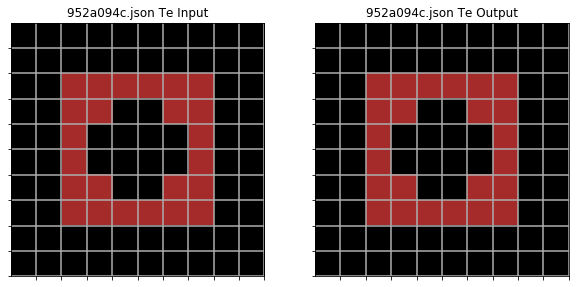

NN not able to solve the task
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 9., 9., 9., 0., 0., 0.],
          [0., 9., 9., 0., 0., 9., 9., 0., 0., 0.],
          [0., 9., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 9., 9., 0., 0., 9., 9., 0., 0., 0.],
          [0., 9., 9., 9., 9., 9., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[9., 0., 0., 0., 0., 0., 0., 9., 0., 0.],
          [0., 9., 9., 9., 9., 9., 9., 0., 0., 0.],
          [0., 9., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 9., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 9., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 9., 9., 9., 9., 9., 9., 0., 0., 0.],
          [9., 0., 0., 0., 0., 0., 0., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 

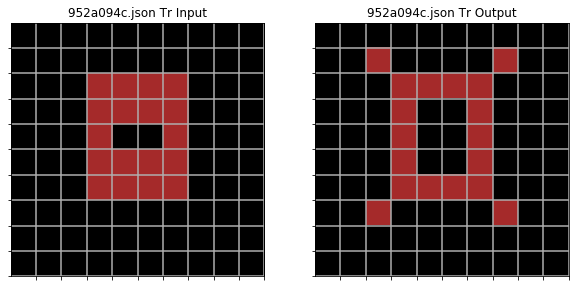

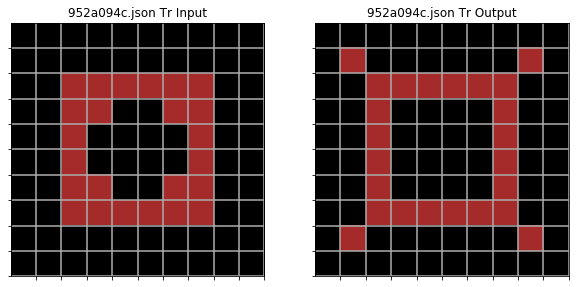

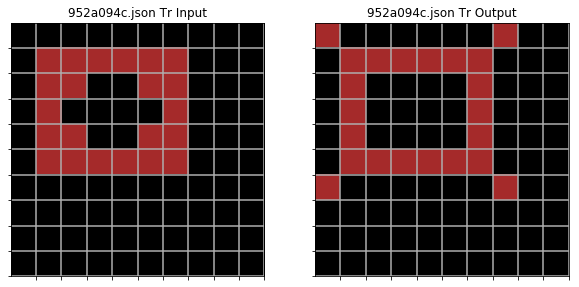

Expected Output


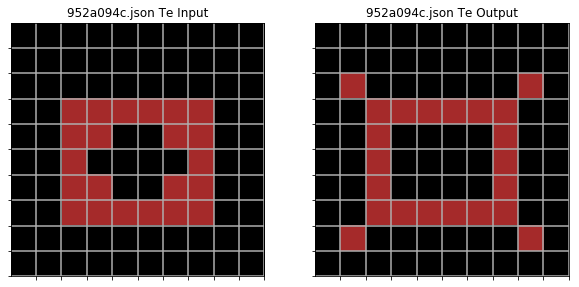

Actual Output


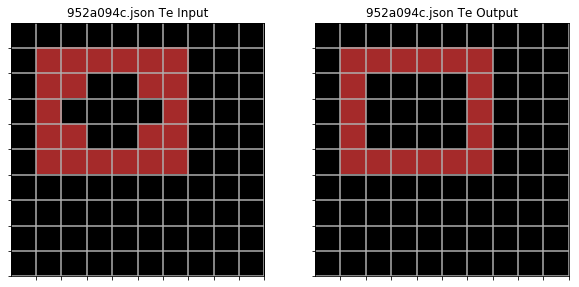

NN not able to solve the task
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 0., 0.],
          [0., 0., 9., 9., 0., 0., 9., 9., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 9., 0., 0.],
          [0., 0., 9., 9., 0., 0., 9., 9., 0., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 0., 0., 0., 0., 0., 0., 9., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 9., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 9., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 9., 0., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 0., 0.],
 

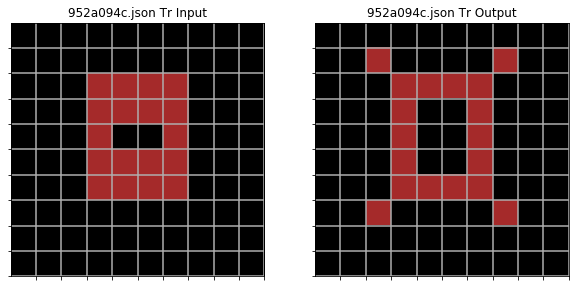

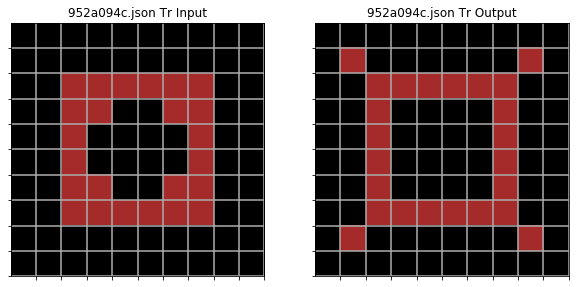

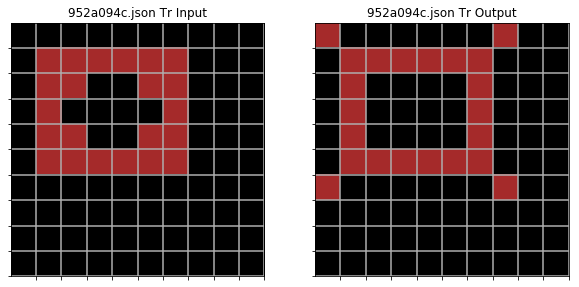

Expected Output


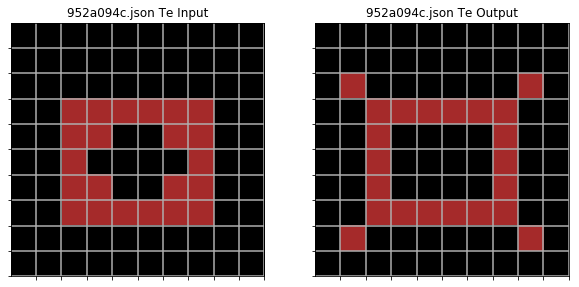

Actual Output


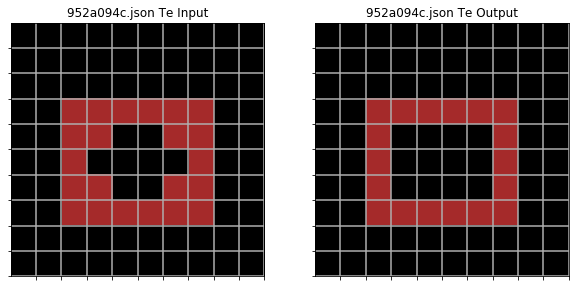

NN not able to solve the task


In [195]:
i = 55
ttm = TrainTestModel(ON=9, OFF=0, B = None, kernel_size=5,pad=2, reduction='none', loss_function_type='mse')
ttm.readData(onlyfiles_train[i], noAug=True)
ttm.train(epochs=1000, print_every=1, learning_rate=0.01, test_every=None)
ttm.test()
#Loss function: mse loss (bcz it penalizes the wrong cell more)
#Status: COmpletely missing the point . The reason is outside its saying to add cell and internally
#we are telling to remove the cell. That where idea of multiple filters might help.

Augmentation is OFF.
epoch: 1, batch_id: 0, loss: 2.015303373336792
[TRAIN] 9 elements matched out of 16 diff. elements.        Accuracy: 56.25. Overall Accuracy: 44.44444274902344
epoch: 1, batch_id: 1, loss: 1.120867133140564
[TRAIN] 5 elements matched out of 9 diff. elements.        Accuracy: 55.55555725097656. Overall Accuracy: 27.77777862548828
epoch: 1, batch_id: 2, loss: 1.183288812637329
[TRAIN] 10 elements matched out of 16 diff. elements.        Accuracy: 62.5. Overall Accuracy: 47.22222137451172
epoch: 2, batch_id: 0, loss: 0.9322888255119324
[TRAIN] 11 elements matched out of 16 diff. elements.        Accuracy: 68.75. Overall Accuracy: 52.77777862548828
epoch: 2, batch_id: 1, loss: 0.6542810797691345
[TRAIN] 6 elements matched out of 9 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 38.88888931274414
epoch: 2, batch_id: 2, loss: 0.6912754774093628
[TRAIN] 11 elements matched out of 16 diff. elements.        Accuracy: 68.75. Overall Accuracy: 61.1111106

epoch: 26, batch_id: 2, loss: 0.050598856061697006
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 27, batch_id: 0, loss: 0.04979676753282547
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 27, batch_id: 1, loss: 0.18957635760307312
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 69.44444274902344
epoch: 27, batch_id: 2, loss: 0.04855801537632942
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 28, batch_id: 0, loss: 0.047817036509513855
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 28, batch_id: 1, loss: 0.1878233551979065
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 69.44444274902344
epoch: 28, batch_id: 2, loss: 0.04667068272829056
[TRAIN] 16 elemen

[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 53, batch_id: 2, loss: 0.02342311292886734
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 54, batch_id: 0, loss: 0.023242183029651642
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 54, batch_id: 1, loss: 0.1601376235485077
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 54, batch_id: 2, loss: 0.022959701716899872
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 55, batch_id: 0, loss: 0.022785652428865433
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 55, batch_id: 1, loss: 0.15941733121871948
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accura

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 80, batch_id: 1, loss: 0.1445905566215515
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 80, batch_id: 2, loss: 0.015134796500205994
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 81, batch_id: 0, loss: 0.015057189390063286
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 81, batch_id: 1, loss: 0.14408831298351288
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 81, batch_id: 2, loss: 0.014938469044864178
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 82, batch_id: 0, loss: 0.014862807467579842
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Acc

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 110, batch_id: 0, loss: 0.01091846264898777
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 110, batch_id: 1, loss: 0.13132244348526
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 110, batch_id: 2, loss: 0.010856975801289082
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 111, batch_id: 0, loss: 0.010816129855811596
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 111, batch_id: 1, loss: 0.13093195855617523
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 111, batch_id: 2, loss: 0.010755833238363266
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall 

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 140, batch_id: 0, loss: 0.008510876446962357
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 140, batch_id: 1, loss: 0.12063813209533691
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 140, batch_id: 2, loss: 0.008474413305521011
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 141, batch_id: 0, loss: 0.008449031040072441
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 141, batch_id: 1, loss: 0.12031405419111252
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 141, batch_id: 2, loss: 0.008413131348788738
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Over

epoch: 168, batch_id: 1, loss: 0.11218729615211487
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 168, batch_id: 2, loss: 0.0070440080016851425
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 169, batch_id: 0, loss: 0.0070261722430586815
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 169, batch_id: 1, loss: 0.11190727353096008
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 169, batch_id: 2, loss: 0.007002008613198996
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 170, batch_id: 0, loss: 0.006984373554587364
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 170, batch_id: 1, loss: 0.11162863671779633
[TRAIN] 9 elements matched ou

epoch: 195, batch_id: 2, loss: 0.0060661714524030685
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 196, batch_id: 0, loss: 0.006052741780877113
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 196, batch_id: 1, loss: 0.10482802242040634
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 196, batch_id: 2, loss: 0.006035303696990013
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 197, batch_id: 0, loss: 0.006022000685334206
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 197, batch_id: 1, loss: 0.1045822873711586
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 197, batch_id: 2, loss: 0.006004756782203913
[TRAIN] 16 elements matched ou

epoch: 224, batch_id: 0, loss: 0.005299216601997614
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 224, batch_id: 1, loss: 0.09833543747663498
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 224, batch_id: 2, loss: 0.005286248866468668
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 225, batch_id: 0, loss: 0.005275888368487358
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 225, batch_id: 1, loss: 0.09811752289533615
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 225, batch_id: 2, loss: 0.00526304729282856
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 226, batch_id: 0, loss: 0.005252774804830551
[TRAIN] 16 elements matched out

epoch: 253, batch_id: 0, loss: 0.0046998197212815285
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 253, batch_id: 1, loss: 0.09235955774784088
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 253, batch_id: 2, loss: 0.0046899388544261456
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 254, batch_id: 0, loss: 0.0046816635876894
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 254, batch_id: 1, loss: 0.09216546267271042
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 254, batch_id: 2, loss: 0.004671869333833456
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 255, batch_id: 0, loss: 0.00466365460306406
[TRAIN] 16 elements matched out

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 283, batch_id: 0, loss: 0.004212418105453253
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 283, batch_id: 1, loss: 0.08684603124856949
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 283, batch_id: 2, loss: 0.004204737953841686
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 284, batch_id: 0, loss: 0.0041979895904660225
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 284, batch_id: 1, loss: 0.08667264878749847
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 284, batch_id: 2, loss: 0.004190368112176657
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Ove

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 312, batch_id: 1, loss: 0.08206252753734589
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 312, batch_id: 2, loss: 0.0038262344896793365
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 313, batch_id: 0, loss: 0.0038205732125788927
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 313, batch_id: 1, loss: 0.08190614730119705
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 313, batch_id: 2, loss: 0.0038144562859088182
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 314, batch_id: 0, loss: 0.003808828303590417
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. O

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 341, batch_id: 1, loss: 0.07773835211992264
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 341, batch_id: 2, loss: 0.0035132141783833504
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 342, batch_id: 0, loss: 0.0035083815455436707
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 342, batch_id: 1, loss: 0.07759667932987213
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 342, batch_id: 2, loss: 0.0035033817403018475
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 343, batch_id: 0, loss: 0.003498574486002326
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. O

epoch: 369, batch_id: 1, loss: 0.07394084334373474
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 369, batch_id: 2, loss: 0.0032583128195255995
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 370, batch_id: 0, loss: 0.0032541111577302217
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 370, batch_id: 1, loss: 0.07381149381399155
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 370, batch_id: 2, loss: 0.0032499320805072784
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 371, batch_id: 0, loss: 0.0032457499764859676
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 371, batch_id: 1, loss: 0.0736825093626976
[TRAIN] 9 elements matched o

epoch: 399, batch_id: 1, loss: 0.07023076713085175
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 399, batch_id: 2, loss: 0.003025312442332506
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 400, batch_id: 0, loss: 0.0030216476880013943
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 400, batch_id: 1, loss: 0.07011295855045319
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 400, batch_id: 2, loss: 0.0030181529000401497
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 401, batch_id: 0, loss: 0.0030145032797008753
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 401, batch_id: 1, loss: 0.06999547779560089
[TRAIN] 9 elements matched o

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 429, batch_id: 1, loss: 0.06684572994709015
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 429, batch_id: 2, loss: 0.002825113944709301
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 430, batch_id: 0, loss: 0.002821883652359247
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 430, batch_id: 1, loss: 0.06673800945281982
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 430, batch_id: 2, loss: 0.0028189236763864756
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 431, batch_id: 0, loss: 0.0028157057240605354
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Ov

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 459, batch_id: 0, loss: 0.0026537086814641953
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 459, batch_id: 1, loss: 0.06374609470367432
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 459, batch_id: 2, loss: 0.002651162911206484
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 460, batch_id: 0, loss: 0.0026482900138944387
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 460, batch_id: 1, loss: 0.06364727765321732
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 460, batch_id: 2, loss: 0.0026457542553544044
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. O

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 488, batch_id: 1, loss: 0.060989633202552795
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 488, batch_id: 2, loss: 0.002503325929865241
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 489, batch_id: 0, loss: 0.0025007405783981085
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 489, batch_id: 1, loss: 0.060898441821336746
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 489, batch_id: 2, loss: 0.0024985410273075104
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 490, batch_id: 0, loss: 0.0024959645234048367
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0.

epoch: 517, batch_id: 1, loss: 0.05844287574291229
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 517, batch_id: 2, loss: 0.0023720115423202515
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 518, batch_id: 0, loss: 0.0023696711286902428
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 518, batch_id: 1, loss: 0.058358509093523026
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 518, batch_id: 2, loss: 0.0023677442222833633
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 519, batch_id: 0, loss: 0.0023654112592339516
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 519, batch_id: 1, loss: 0.05827437341213226
[TRAIN] 9 elements matched

epoch: 546, batch_id: 1, loss: 0.05608363822102547
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 546, batch_id: 2, loss: 0.0022545468527823687
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 547, batch_id: 0, loss: 0.002252414124086499
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 547, batch_id: 1, loss: 0.05600539967417717
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 547, batch_id: 2, loss: 0.0022507160902023315
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 548, batch_id: 0, loss: 0.002248590113595128
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 548, batch_id: 1, loss: 0.055927351117134094
[TRAIN] 9 elements matched o

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 576, batch_id: 0, loss: 0.002146852668374777
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 576, batch_id: 1, loss: 0.05381997302174568
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 576, batch_id: 2, loss: 0.0021453462541103363
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 577, batch_id: 0, loss: 0.0021434002555906773
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 577, batch_id: 1, loss: 0.05374741554260254
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 577, batch_id: 2, loss: 0.002141899662092328
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Ov

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 603, batch_id: 1, loss: 0.05192137509584427
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 603, batch_id: 2, loss: 0.0020562345162034035
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 604, batch_id: 0, loss: 0.002054433571174741
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 604, batch_id: 1, loss: 0.05185341089963913
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 604, batch_id: 2, loss: 0.0020530829206109047
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 605, batch_id: 0, loss: 0.002051288029178977
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Ov

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 631, batch_id: 0, loss: 0.0019729621708393097
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 631, batch_id: 1, loss: 0.050078198313713074
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 631, batch_id: 2, loss: 0.001971745165064931
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 632, batch_id: 0, loss: 0.001970076933503151
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 632, batch_id: 1, loss: 0.05001458898186684
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 632, batch_id: 2, loss: 0.0019688622560352087
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. O

[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 657, batch_id: 2, loss: 0.0018996167927980423
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 658, batch_id: 0, loss: 0.0018980612512677908
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 658, batch_id: 1, loss: 0.048411257565021515
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 658, batch_id: 2, loss: 0.0018969527445733547
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 659, batch_id: 0, loss: 0.00189540209248662
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 659, batch_id: 1, loss: 0.0483514629304409
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Over

[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 684, batch_id: 2, loss: 0.001830396126024425
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 685, batch_id: 0, loss: 0.0018289419822394848
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 685, batch_id: 1, loss: 0.046843405812978745
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 685, batch_id: 2, loss: 0.0018279342912137508
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 686, batch_id: 0, loss: 0.0018264843383803964
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 686, batch_id: 1, loss: 0.04678714647889137
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Ov

epoch: 712, batch_id: 1, loss: 0.04536640644073486
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 712, batch_id: 2, loss: 0.0017640253063291311
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 713, batch_id: 0, loss: 0.0017626682529225945
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 713, batch_id: 1, loss: 0.04531334340572357
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 713, batch_id: 2, loss: 0.0017617489211261272
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 714, batch_id: 0, loss: 0.0017603946616873145
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 714, batch_id: 1, loss: 0.04526039958000183
[TRAIN] 9 elements matched 

epoch: 738, batch_id: 2, loss: 0.0017067913431674242
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 739, batch_id: 0, loss: 0.0017055138014256954
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 739, batch_id: 1, loss: 0.043972864747047424
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 739, batch_id: 2, loss: 0.0017046682769432664
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 740, batch_id: 0, loss: 0.0017033937619999051
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 740, batch_id: 1, loss: 0.04392275959253311
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 740, batch_id: 2, loss: 0.0017025505658239126
[TRAIN] 16 elements matc

epoch: 765, batch_id: 2, loss: 0.0016513572772964835
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 766, batch_id: 0, loss: 0.0016501561040058732
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 766, batch_id: 1, loss: 0.04265616461634636
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 766, batch_id: 2, loss: 0.001649377285502851
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 767, batch_id: 0, loss: 0.001648177858442068
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 767, batch_id: 1, loss: 0.042608801275491714
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 767, batch_id: 2, loss: 0.0016474021831527352
[TRAIN] 16 elements matche

[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 792, batch_id: 2, loss: 0.001599589129909873
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 793, batch_id: 0, loss: 0.0015984551282599568
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 793, batch_id: 1, loss: 0.04141039401292801
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 793, batch_id: 2, loss: 0.0015977374278008938
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 794, batch_id: 0, loss: 0.0015966068021953106
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 794, batch_id: 1, loss: 0.04136553406715393
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Ove

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 821, batch_id: 1, loss: 0.04018763080239296
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 821, batch_id: 2, loss: 0.0015476586995646358
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 822, batch_id: 0, loss: 0.0015465926844626665
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 822, batch_id: 1, loss: 0.04014520347118378
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 822, batch_id: 2, loss: 0.0015459309797734022
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 823, batch_id: 0, loss: 0.0015448671765625477
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. 

epoch: 850, batch_id: 1, loss: 0.038989756256341934
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 850, batch_id: 2, loss: 0.001499152509495616
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 851, batch_id: 0, loss: 0.001498147496022284
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 851, batch_id: 1, loss: 0.0389496348798275
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 851, batch_id: 2, loss: 0.0014975378289818764
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 852, batch_id: 0, loss: 0.0014965342124924064
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 852, batch_id: 1, loss: 0.03890956938266754
[TRAIN] 9 elements matched ou

epoch: 878, batch_id: 1, loss: 0.03789437562227249
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 878, batch_id: 2, loss: 0.001455254154279828
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 879, batch_id: 0, loss: 0.0014543031575158238
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 879, batch_id: 1, loss: 0.03785630688071251
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 879, batch_id: 2, loss: 0.001453735982067883
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 880, batch_id: 0, loss: 0.0014527851017192006
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 880, batch_id: 1, loss: 0.0378182977437973
[TRAIN] 9 elements matched out

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 902, batch_id: 1, loss: 0.03699992969632149
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 902, batch_id: 2, loss: 0.0014197140699252486
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 903, batch_id: 0, loss: 0.0014188052155077457
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 903, batch_id: 1, loss: 0.03696349635720253
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 903, batch_id: 2, loss: 0.0014182726154103875
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 904, batch_id: 0, loss: 0.0014173658564686775
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. 

[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 929, batch_id: 2, loss: 0.0013818434672430158
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 930, batch_id: 0, loss: 0.0013809786178171635
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 930, batch_id: 1, loss: 0.03600473701953888
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 930, batch_id: 2, loss: 0.001380481175146997
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 931, batch_id: 0, loss: 0.0013796185376122594
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 931, batch_id: 1, loss: 0.03597010672092438
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Ove

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 958, batch_id: 0, loss: 0.0013439172180369496
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 958, batch_id: 1, loss: 0.03505808115005493
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 958, batch_id: 2, loss: 0.0013434513239189982
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 959, batch_id: 0, loss: 0.0013426303630694747
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 959, batch_id: 1, loss: 0.035025112330913544
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 959, batch_id: 2, loss: 0.0013421663315966725
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0.

epoch: 986, batch_id: 2, loss: 0.0013084354577586055
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 987, batch_id: 0, loss: 0.0013076533796265721
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 987, batch_id: 1, loss: 0.03412524610757828
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 987, batch_id: 2, loss: 0.0013072193833068013
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 988, batch_id: 0, loss: 0.0013064402155578136
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 988, batch_id: 1, loss: 0.034093908965587616
[TRAIN] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 988, batch_id: 2, loss: 0.0013060069177299738
[TRAIN] 16 elements matc

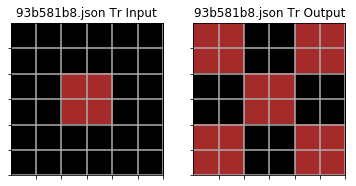

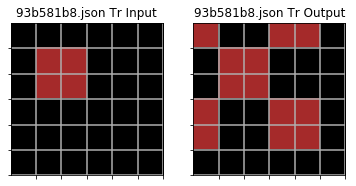

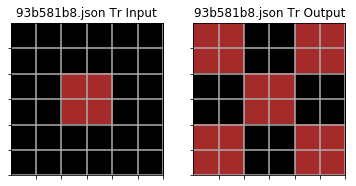

Expected Output


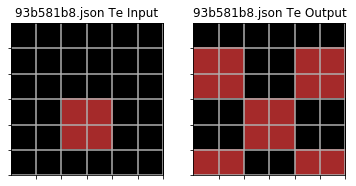

Actual Output


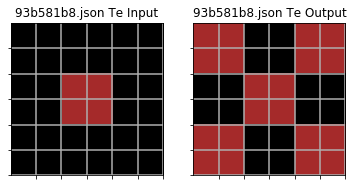

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 0., 0., 0.],
          [0., 9., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[9., 0., 0., 9., 9., 0.],
          [0., 9., 9., 0., 0., 0.],
          [0., 9., 9., 0., 0., 0.],
          [9., 0., 0., 9., 9., 0.],
          [9., 0., 0., 9., 9., 0.],
          [0., 0., 0., 0., 0., 0.]]]])
pred   op grid tensor([[[[9., 0., 0., 9., 9., 0.],
          [0., 9., 9., 0., 0., 0.],
          [0., 9., 9., 0., 0., 0.],
          [9., 0., 0., 9., 9., 0.],
          [9., 0., 0., 9., 9., 0.],
          [0., 0., 0., 0., 0., 0.]]]])
[TEST] 9 elements matched out of 9 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
Training Data


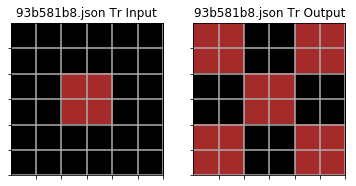

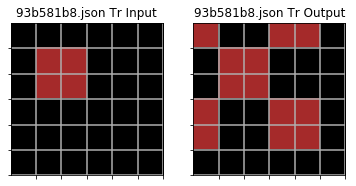

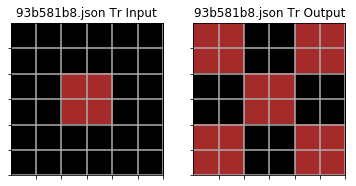

Expected Output


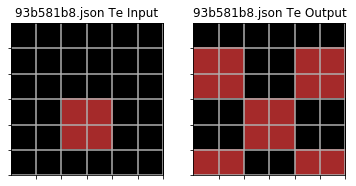

Actual Output


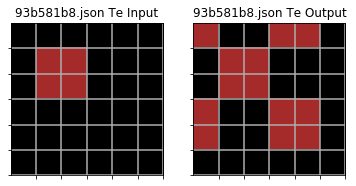

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 9., 0., 0.],
          [0., 0., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[9., 9., 0., 0., 9., 9.],
          [9., 9., 0., 0., 9., 9.],
          [0., 0., 9., 9., 0., 0.],
          [0., 0., 9., 9., 0., 0.],
          [9., 9., 0., 0., 9., 9.],
          [9., 9., 0., 0., 9., 9.]]]])
pred   op grid tensor([[[[9., 9., 0., 0., 9., 9.],
          [9., 9., 0., 0., 9., 9.],
          [0., 0., 9., 9., 0., 0.],
          [0., 0., 9., 9., 0., 0.],
          [9., 9., 0., 0., 9., 9.],
          [9., 9., 0., 0., 9., 9.]]]])
[TEST] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
Training Data


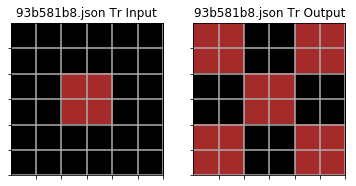

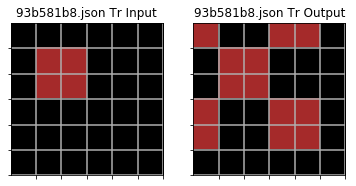

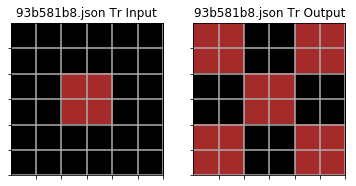

Expected Output


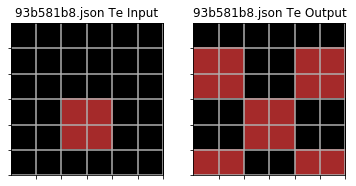

Actual Output


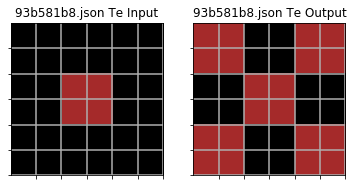

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 9., 0., 0.],
          [0., 0., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0.],
          [9., 9., 0., 0., 9., 9.],
          [9., 9., 0., 0., 9., 9.],
          [0., 0., 9., 9., 0., 0.],
          [0., 0., 9., 9., 0., 0.],
          [9., 9., 0., 0., 9., 9.]]]])
pred   op grid tensor([[[[0., 0., 0., 0., 0., 0.],
          [9., 9., 0., 0., 9., 9.],
          [9., 9., 0., 0., 9., 9.],
          [0., 0., 9., 9., 0., 0.],
          [0., 0., 9., 9., 0., 0.],
          [9., 9., 0., 0., 9., 9.]]]])
[TEST] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
Training Data


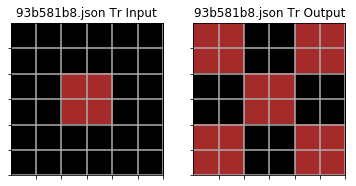

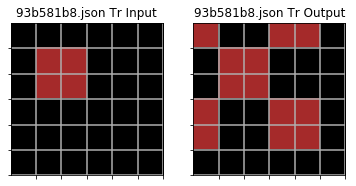

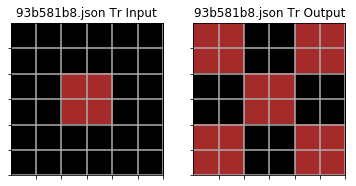

Expected Output


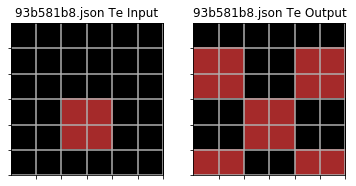

Actual Output


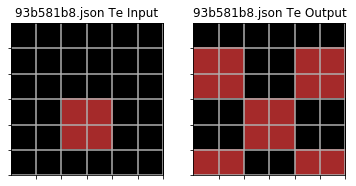

Task successfully solved.


In [191]:
i = 54
ttm = TrainTestModel(ON=9, OFF=0, B = None, kernel_size=5,pad=2, reduction='none', loss_function_type='mse')
ttm.readData(onlyfiles_train[i], noAug=True)
ttm.train(epochs=1000, print_every=1, learning_rate=0.01, test_every=None)
ttm.test()
#Loss function: mse loss (bcz it penalizes the wrong cell more)
#Status: Happy to see this one solved. Bcz it is consistent but seems tricky as well especially towards edge

Augmentation is OFF.
epoch: 1, batch_id: 0, loss: 0.4927440285682678
[TRAIN] 9 elements matched out of 24 diff. elements.        Accuracy: 37.5. Overall Accuracy: 87.5
epoch: 1, batch_id: 1, loss: 0.5429160594940186
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 86.11111450195312
epoch: 1, batch_id: 2, loss: 0.363618403673172
[TRAIN] 8 elements matched out of 16 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.09375
epoch: 1, batch_id: 3, loss: 0.5210717916488647
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 86.11111450195312
epoch: 2, batch_id: 0, loss: 0.4537206292152405
[TRAIN] 12 elements matched out of 24 diff. elements.        Accuracy: 50.0. Overall Accuracy: 89.58333587646484
epoch: 2, batch_id: 1, loss: 0.4945489466190338
[TRAIN] 4 elements matched out of 8 diff. elements.        Accuracy: 50.0. Overall Accuracy: 86.11111450195312
epoch: 2, batch_id: 2, loss: 0.3491043150424

epoch: 19, batch_id: 3, loss: 0.24189411103725433
[TRAIN] 7 elements matched out of 8 diff. elements.        Accuracy: 87.5. Overall Accuracy: 97.22222137451172
epoch: 20, batch_id: 0, loss: 0.23888246715068817
[TRAIN] 21 elements matched out of 24 diff. elements.        Accuracy: 87.5. Overall Accuracy: 97.91666412353516
epoch: 20, batch_id: 1, loss: 0.2390209585428238
[TRAIN] 7 elements matched out of 8 diff. elements.        Accuracy: 87.5. Overall Accuracy: 97.22222137451172
epoch: 20, batch_id: 2, loss: 0.23427027463912964
[TRAIN] 14 elements matched out of 16 diff. elements.        Accuracy: 87.5. Overall Accuracy: 99.21875
epoch: 20, batch_id: 3, loss: 0.2366211712360382
[TRAIN] 7 elements matched out of 8 diff. elements.        Accuracy: 87.5. Overall Accuracy: 97.22222137451172
epoch: 21, batch_id: 0, loss: 0.23415859043598175
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 21, batch_id: 1, loss: 0.2339131087064743
[

epoch: 39, batch_id: 1, loss: 0.1717148721218109
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 39, batch_id: 2, loss: 0.17746707797050476
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 39, batch_id: 3, loss: 0.17053185403347015
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 40, batch_id: 0, loss: 0.17210017144680023
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 40, batch_id: 1, loss: 0.16928038001060486
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 40, batch_id: 2, loss: 0.17517493665218353
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 40, batch_id: 3, loss: 0.1681302934885025
[TRAIN] 8 elements matched out of 8 diff. elem

[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 59, batch_id: 0, loss: 0.13621258735656738
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 59, batch_id: 1, loss: 0.13342320919036865
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 59, batch_id: 2, loss: 0.14002300798892975
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 59, batch_id: 3, loss: 0.13269776105880737
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 60, batch_id: 0, loss: 0.1347215473651886
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 60, batch_id: 1, loss: 0.13194873929023743
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 1

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 79, batch_id: 3, loss: 0.10844448208808899
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 80, batch_id: 0, loss: 0.11032269150018692
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 80, batch_id: 1, loss: 0.10794026404619217
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 80, batch_id: 2, loss: 0.11383526772260666
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 80, batch_id: 3, loss: 0.10745587944984436
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 81, batch_id: 0, loss: 0.10932298749685287
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 100, batch_id: 3, loss: 0.09078477323055267
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 101, batch_id: 0, loss: 0.09241899102926254
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 101, batch_id: 1, loss: 0.09042693674564362
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 101, batch_id: 2, loss: 0.09547079354524612
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 101, batch_id: 3, loss: 0.0900810956954956
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 102, batch_id: 0, loss: 0.09170392155647278
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Acc

epoch: 120, batch_id: 0, loss: 0.0804227814078331
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 120, batch_id: 1, loss: 0.07871952652931213
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 120, batch_id: 2, loss: 0.08309122920036316
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 120, batch_id: 3, loss: 0.07845398038625717
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 121, batch_id: 0, loss: 0.07987315952777863
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 121, batch_id: 1, loss: 0.07818350940942764
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 121, batch_id: 2, loss: 0.08252310752868652
[TRAIN] 16 elements matched out of 16 

[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 139, batch_id: 0, loss: 0.07107654958963394
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 139, batch_id: 1, loss: 0.06960495561361313
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 139, batch_id: 2, loss: 0.07342028617858887
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 139, batch_id: 3, loss: 0.06939497590065002
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 140, batch_id: 0, loss: 0.07064162939786911
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 140, batch_id: 1, loss: 0.06918103247880936
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accu

[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 158, batch_id: 2, loss: 0.06567534059286118
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 158, batch_id: 3, loss: 0.06214487552642822
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 159, batch_id: 0, loss: 0.0632486492395401
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 159, batch_id: 1, loss: 0.06197153776884079
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 159, batch_id: 2, loss: 0.0653105080127716
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 159, batch_id: 3, loss: 0.061803288757801056
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accur

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 178, batch_id: 1, loss: 0.0560731366276741
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 178, batch_id: 2, loss: 0.05904331058263779
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 178, batch_id: 3, loss: 0.05593414604663849
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 179, batch_id: 0, loss: 0.05691395327448845
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 179, batch_id: 1, loss: 0.05579233914613724
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 179, batch_id: 2, loss: 0.058745041489601135
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Ac

[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 197, batch_id: 0, loss: 0.05216914787888527
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 197, batch_id: 1, loss: 0.05116177350282669
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 197, batch_id: 2, loss: 0.053827524185180664
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 197, batch_id: 3, loss: 0.051045119762420654
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 198, batch_id: 0, loss: 0.0519275888800621
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 198, batch_id: 1, loss: 0.05092600733041763
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Acc

epoch: 216, batch_id: 3, loss: 0.04691249132156372
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 217, batch_id: 0, loss: 0.047713421285152435
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 217, batch_id: 1, loss: 0.0468110665678978
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 217, batch_id: 2, loss: 0.04921100288629532
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 217, batch_id: 3, loss: 0.04671267420053482
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 218, batch_id: 0, loss: 0.04750964418053627
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 218, batch_id: 1, loss: 0.046612102538347244
[TRAIN] 8 elements matched out of 8 

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 236, batch_id: 3, loss: 0.043203480541706085
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 237, batch_id: 0, loss: 0.04393210634589195
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 237, batch_id: 1, loss: 0.043116796761751175
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 237, batch_id: 2, loss: 0.04529491066932678
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 237, batch_id: 3, loss: 0.04303272068500519
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 238, batch_id: 0, loss: 0.043758027255535126
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall

[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 256, batch_id: 0, loss: 0.0408363975584507
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 256, batch_id: 1, loss: 0.04009068012237549
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 256, batch_id: 2, loss: 0.042090438306331635
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 256, batch_id: 3, loss: 0.04001755267381668
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 257, batch_id: 0, loss: 0.040685024112463
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 257, batch_id: 1, loss: 0.0399426631629467
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accurac

epoch: 275, batch_id: 2, loss: 0.039293162524700165
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 275, batch_id: 3, loss: 0.03738236427307129
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 276, batch_id: 0, loss: 0.03800003603100777
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 276, batch_id: 1, loss: 0.037316616624593735
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 276, batch_id: 2, loss: 0.03915577381849289
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 276, batch_id: 3, loss: 0.03725285083055496
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 277, batch_id: 0, loss: 0.03786812350153923
[TRAIN] 24 elements matched out of 

epoch: 294, batch_id: 1, loss: 0.03511729836463928
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 294, batch_id: 2, loss: 0.036831390112638474
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 294, batch_id: 3, loss: 0.035060565918684006
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 295, batch_id: 0, loss: 0.035634979605674744
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 295, batch_id: 1, loss: 0.035002391785383224
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 295, batch_id: 2, loss: 0.0367099791765213
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 295, batch_id: 3, loss: 0.034946009516716
[TRAIN] 8 elements matched out of 8 

epoch: 314, batch_id: 0, loss: 0.03353676572442055
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 314, batch_id: 1, loss: 0.03294837847352028
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 314, batch_id: 2, loss: 0.03454112634062767
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 314, batch_id: 3, loss: 0.032898180186748505
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 315, batch_id: 0, loss: 0.033432912081480026
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 315, batch_id: 1, loss: 0.032846663147211075
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 315, batch_id: 2, loss: 0.0344337522983551
[TRAIN] 16 elements matched out of 

[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 333, batch_id: 0, loss: 0.03166334703564644
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 333, batch_id: 1, loss: 0.03111371025443077
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 333, batch_id: 2, loss: 0.032605431973934174
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 333, batch_id: 3, loss: 0.03106873296201229
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 334, batch_id: 0, loss: 0.03157031536102295
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 334, batch_id: 1, loss: 0.0310225747525692
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accu

epoch: 349, batch_id: 2, loss: 0.03113020956516266
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 349, batch_id: 3, loss: 0.029673321172595024
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 350, batch_id: 0, loss: 0.030149945989251137
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 350, batch_id: 1, loss: 0.029631031677126884
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 350, batch_id: 2, loss: 0.031042270362377167
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 350, batch_id: 3, loss: 0.029590090736746788
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 351, batch_id: 0, loss: 0.03006521612405777
[TRAIN] 24 elements matched out 

epoch: 369, batch_id: 0, loss: 0.02861514687538147
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 369, batch_id: 1, loss: 0.028126971796154976
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 369, batch_id: 2, loss: 0.02945760451257229
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 369, batch_id: 3, loss: 0.028089918196201324
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 370, batch_id: 0, loss: 0.028538517653942108
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 370, batch_id: 1, loss: 0.028051869943737984
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 370, batch_id: 2, loss: 0.02937849797308445
[TRAIN] 16 elements matched out o

epoch: 387, batch_id: 2, loss: 0.028093740344047546
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 387, batch_id: 3, loss: 0.02679779753088951
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 388, batch_id: 0, loss: 0.027223818004131317
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 388, batch_id: 1, loss: 0.026763033121824265
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 388, batch_id: 2, loss: 0.028021521866321564
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 388, batch_id: 3, loss: 0.02672937512397766
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 389, batch_id: 0, loss: 0.027154168114066124
[TRAIN] 24 elements matched out 

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 407, batch_id: 1, loss: 0.025520827621221542
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 407, batch_id: 2, loss: 0.026714371517300606
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 407, batch_id: 3, loss: 0.025490110740065575
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 408, batch_id: 0, loss: 0.025893444195389748
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 408, batch_id: 1, loss: 0.025458522140979767
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 408, batch_id: 2, loss: 0.02664882130920887
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overa

epoch: 427, batch_id: 0, loss: 0.02474074624478817
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 427, batch_id: 1, loss: 0.02432790771126747
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 427, batch_id: 2, loss: 0.02545974962413311
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 427, batch_id: 3, loss: 0.024299880489706993
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 428, batch_id: 0, loss: 0.02468281239271164
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 428, batch_id: 1, loss: 0.02427106723189354
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 428, batch_id: 2, loss: 0.025400016456842422
[TRAIN] 16 elements matched out of 

epoch: 446, batch_id: 0, loss: 0.023682978004217148
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 446, batch_id: 1, loss: 0.02329014614224434
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 446, batch_id: 2, loss: 0.024368925020098686
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 446, batch_id: 3, loss: 0.02326440066099167
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 447, batch_id: 0, loss: 0.023629747331142426
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 447, batch_id: 1, loss: 0.023237891495227814
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 447, batch_id: 2, loss: 0.024313991889357567
[TRAIN] 16 elements matched out 

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 465, batch_id: 1, loss: 0.022334452718496323
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 465, batch_id: 2, loss: 0.023364761844277382
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 465, batch_id: 3, loss: 0.022310683503746986
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 466, batch_id: 0, loss: 0.02265995368361473
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 466, batch_id: 1, loss: 0.022286241874098778
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 466, batch_id: 2, loss: 0.023314129561185837
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overa

epoch: 481, batch_id: 1, loss: 0.021586475893855095
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 481, batch_id: 2, loss: 0.022579193115234375
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 481, batch_id: 3, loss: 0.021564224734902382
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 482, batch_id: 0, loss: 0.021900976076722145
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 482, batch_id: 1, loss: 0.021541329100728035
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 482, batch_id: 2, loss: 0.022531762719154358
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 482, batch_id: 3, loss: 0.021519171074032784
[TRAIN] 8 elements matched out

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 502, batch_id: 3, loss: 0.02065473049879074
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 503, batch_id: 0, loss: 0.020976342260837555
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 503, batch_id: 1, loss: 0.020633654668927193
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 503, batch_id: 2, loss: 0.02157881110906601
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 503, batch_id: 3, loss: 0.020613275468349457
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 504, batch_id: 0, loss: 0.020934198051691055
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overal

[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 517, batch_id: 2, loss: 0.020985674113035202
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 517, batch_id: 3, loss: 0.020049184560775757
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 518, batch_id: 0, loss: 0.020360775291919708
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 518, batch_id: 1, loss: 0.020029284060001373
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 518, batch_id: 2, loss: 0.0209445022046566
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 518, batch_id: 3, loss: 0.020010028034448624
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall 

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 536, batch_id: 1, loss: 0.019347744062542915
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 536, batch_id: 2, loss: 0.020229388028383255
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 536, batch_id: 3, loss: 0.019329734146595
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 537, batch_id: 0, loss: 0.019629472866654396
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 537, batch_id: 1, loss: 0.01931118220090866
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 537, batch_id: 2, loss: 0.020191039890050888
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall 

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 555, batch_id: 1, loss: 0.018675366416573524
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 555, batch_id: 2, loss: 0.019524123519659042
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 555, batch_id: 3, loss: 0.018658556044101715
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 556, batch_id: 0, loss: 0.018947303295135498
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 556, batch_id: 1, loss: 0.018641216680407524
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 556, batch_id: 2, loss: 0.01948830485343933
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overa

epoch: 573, batch_id: 0, loss: 0.018374726176261902
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 573, batch_id: 1, loss: 0.018078813329339027
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 573, batch_id: 2, loss: 0.018898535519838333
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 573, batch_id: 3, loss: 0.01806303672492504
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 574, batch_id: 0, loss: 0.01834208518266678
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 574, batch_id: 1, loss: 0.018046759068965912
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 574, batch_id: 2, loss: 0.01886492222547531
[TRAIN] 16 elements matched out o

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 593, batch_id: 1, loss: 0.017457816749811172
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 593, batch_id: 2, loss: 0.018247468397021294
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 593, batch_id: 3, loss: 0.017443057149648666
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 594, batch_id: 0, loss: 0.017712054774165154
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 594, batch_id: 1, loss: 0.017427857965230942
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 594, batch_id: 2, loss: 0.018216067925095558
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Over

[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 612, batch_id: 0, loss: 0.01717984862625599
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 612, batch_id: 1, loss: 0.016904959455132484
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 612, batch_id: 2, loss: 0.017668018117547035
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 612, batch_id: 3, loss: 0.01689109206199646
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 613, batch_id: 0, loss: 0.01715116947889328
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 613, batch_id: 1, loss: 0.016876807436347008
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall A

epoch: 629, batch_id: 3, loss: 0.01642516814172268
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 630, batch_id: 0, loss: 0.01667773723602295
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 630, batch_id: 1, loss: 0.01641162484884262
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 630, batch_id: 2, loss: 0.017151018604636192
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 630, batch_id: 3, loss: 0.016398536041378975
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 631, batch_id: 0, loss: 0.01665068417787552
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 631, batch_id: 1, loss: 0.016385039314627647
[TRAIN] 8 elements matched out of 

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 649, batch_id: 1, loss: 0.01592029072344303
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 649, batch_id: 2, loss: 0.016636259853839874
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 649, batch_id: 3, loss: 0.01590794324874878
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 650, batch_id: 0, loss: 0.01615224778652191
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 650, batch_id: 1, loss: 0.015895213931798935
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 650, batch_id: 2, loss: 0.01660998910665512
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall 

epoch: 668, batch_id: 3, loss: 0.015445028431713581
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 669, batch_id: 0, loss: 0.015681907534599304
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 669, batch_id: 1, loss: 0.015432996675372124
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 669, batch_id: 2, loss: 0.016125813126564026
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 669, batch_id: 3, loss: 0.015421377494931221
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 670, batch_id: 0, loss: 0.015657903626561165
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 670, batch_id: 1, loss: 0.015409405343234539
[TRAIN] 8 elements matched out

epoch: 688, batch_id: 1, loss: 0.01499614492058754
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 688, batch_id: 2, loss: 0.015668274834752083
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 688, batch_id: 3, loss: 0.014985163696110249
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 689, batch_id: 0, loss: 0.015214713290333748
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 689, batch_id: 1, loss: 0.01497382577508688
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 689, batch_id: 2, loss: 0.015644900500774384
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 689, batch_id: 3, loss: 0.014962863177061081
[TRAIN] 8 elements matched out o

[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 707, batch_id: 0, loss: 0.014816784299910069
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 707, batch_id: 1, loss: 0.014582674019038677
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 707, batch_id: 2, loss: 0.015235301107168198
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 707, batch_id: 3, loss: 0.01457226276397705
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 708, batch_id: 0, loss: 0.01479526236653328
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 708, batch_id: 1, loss: 0.014561517164111137
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall 

epoch: 726, batch_id: 2, loss: 0.014824969694018364
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 726, batch_id: 3, loss: 0.014180881902575493
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 727, batch_id: 0, loss: 0.014397680759429932
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 727, batch_id: 1, loss: 0.014170687645673752
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 727, batch_id: 2, loss: 0.014803954400122166
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 727, batch_id: 3, loss: 0.014160841703414917
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 728, batch_id: 0, loss: 0.014377334155142307
[TRAIN] 24 elements matched ou

[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 746, batch_id: 0, loss: 0.014020330272614956
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 746, batch_id: 1, loss: 0.013799723237752914
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 746, batch_id: 2, loss: 0.014415616169571877
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 746, batch_id: 3, loss: 0.013790367171168327
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 747, batch_id: 0, loss: 0.014001003466546535
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 747, batch_id: 1, loss: 0.013780724257230759
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overal

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 765, batch_id: 3, loss: 0.01343825925141573
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 766, batch_id: 0, loss: 0.013643341138958931
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 766, batch_id: 1, loss: 0.013429088518023491
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 766, batch_id: 2, loss: 0.014027661643922329
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 766, batch_id: 3, loss: 0.013420217670500278
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 767, batch_id: 0, loss: 0.013625012710690498
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overa

epoch: 785, batch_id: 1, loss: 0.013094480149447918
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 785, batch_id: 2, loss: 0.013677479699254036
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 785, batch_id: 3, loss: 0.013086039572954178
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 786, batch_id: 0, loss: 0.013285577297210693
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 786, batch_id: 1, loss: 0.013077322393655777
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 786, batch_id: 2, loss: 0.013659515418112278
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 786, batch_id: 3, loss: 0.013068890199065208
[TRAIN] 8 elements matched out

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 804, batch_id: 1, loss: 0.012775705195963383
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 804, batch_id: 2, loss: 0.013343887403607368
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 804, batch_id: 3, loss: 0.012767648324370384
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 805, batch_id: 0, loss: 0.012962189503014088
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 805, batch_id: 1, loss: 0.01275933813303709
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 805, batch_id: 2, loss: 0.013326774351298809
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overa

epoch: 823, batch_id: 3, loss: 0.012463982217013836
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 824, batch_id: 0, loss: 0.012653766199946404
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 824, batch_id: 1, loss: 0.012456056661903858
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 824, batch_id: 2, loss: 0.013009454123675823
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 824, batch_id: 3, loss: 0.012448393739759922
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 825, batch_id: 0, loss: 0.01263793371617794
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 825, batch_id: 1, loss: 0.012440484017133713
[TRAIN] 8 elements matched out 

epoch: 843, batch_id: 1, loss: 0.012166479602456093
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 843, batch_id: 2, loss: 0.012706480920314789
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 843, batch_id: 3, loss: 0.01215916033834219
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 844, batch_id: 0, loss: 0.012344170361757278
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 844, batch_id: 1, loss: 0.012151602655649185
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 844, batch_id: 2, loss: 0.012690912932157516
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 844, batch_id: 3, loss: 0.01214429922401905
[TRAIN] 8 elements matched out o

[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 862, batch_id: 0, loss: 0.012077875435352325
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 862, batch_id: 1, loss: 0.011889717541635036
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 862, batch_id: 2, loss: 0.012416955083608627
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 862, batch_id: 3, loss: 0.011882723309099674
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 863, batch_id: 0, loss: 0.01206341665238142
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 863, batch_id: 1, loss: 0.011875493451952934
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall

[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 881, batch_id: 2, loss: 0.012139976024627686
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 881, batch_id: 3, loss: 0.01161824818700552
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 882, batch_id: 0, loss: 0.011794806458055973
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 882, batch_id: 1, loss: 0.011611321941018105
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 882, batch_id: 2, loss: 0.012125736102461815
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 882, batch_id: 3, loss: 0.011604644358158112
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall

epoch: 900, batch_id: 2, loss: 0.011874820105731487
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 900, batch_id: 3, loss: 0.011365000158548355
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 901, batch_id: 0, loss: 0.01153763011097908
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 901, batch_id: 1, loss: 0.01135837659239769
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 901, batch_id: 2, loss: 0.01186117623001337
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 901, batch_id: 3, loss: 0.011351972818374634
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 902, batch_id: 0, loss: 0.011524400673806667
[TRAIN] 24 elements matched out o

epoch: 920, batch_id: 0, loss: 0.01129115466028452
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 920, batch_id: 1, loss: 0.011115938425064087
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 920, batch_id: 2, loss: 0.011607618071138859
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 920, batch_id: 3, loss: 0.011109788902103901
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 921, batch_id: 0, loss: 0.011278455145657063
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 921, batch_id: 1, loss: 0.011103449389338493
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 921, batch_id: 2, loss: 0.011594567447900772
[TRAIN] 16 elements matched out

[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 939, batch_id: 2, loss: 0.011364405043423176
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 939, batch_id: 3, loss: 0.010877478867769241
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 940, batch_id: 0, loss: 0.011042529717087746
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 940, batch_id: 1, loss: 0.010871398262679577
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 940, batch_id: 2, loss: 0.011351886205375195
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 940, batch_id: 3, loss: 0.010865508578717709
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overal

[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 958, batch_id: 2, loss: 0.011130929924547672
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 958, batch_id: 3, loss: 0.010654445737600327
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 959, batch_id: 0, loss: 0.01081603579223156
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 959, batch_id: 1, loss: 0.010648597031831741
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 959, batch_id: 2, loss: 0.011118910275399685
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 959, batch_id: 3, loss: 0.01064295694231987
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall 

epoch: 977, batch_id: 3, loss: 0.010440154932439327
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 978, batch_id: 0, loss: 0.010598425753414631
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 978, batch_id: 1, loss: 0.010434535332024097
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 978, batch_id: 2, loss: 0.010895079001784325
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 978, batch_id: 3, loss: 0.010429111309349537
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 979, batch_id: 0, loss: 0.010587198659777641
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 979, batch_id: 1, loss: 0.010423507541418076
[TRAIN] 8 elements matched out

[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 996, batch_id: 3, loss: 0.010234122164547443
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 997, batch_id: 0, loss: 0.010389205068349838
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 997, batch_id: 1, loss: 0.010228719562292099
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 997, batch_id: 2, loss: 0.01067988108843565
[TRAIN] 16 elements matched out of 16 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 997, batch_id: 3, loss: 0.010223492980003357
[TRAIN] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 998, batch_id: 0, loss: 0.010378409177064896
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overa

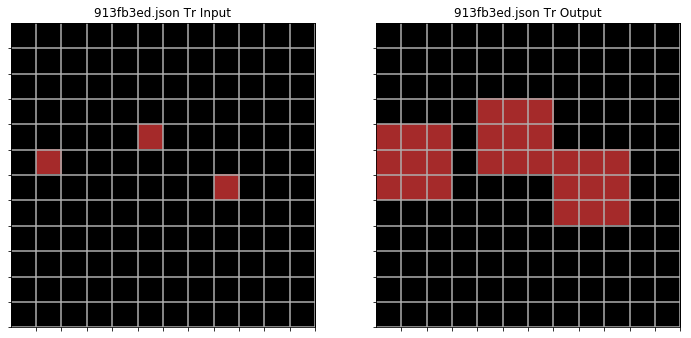

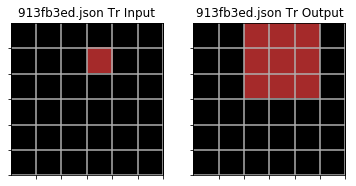

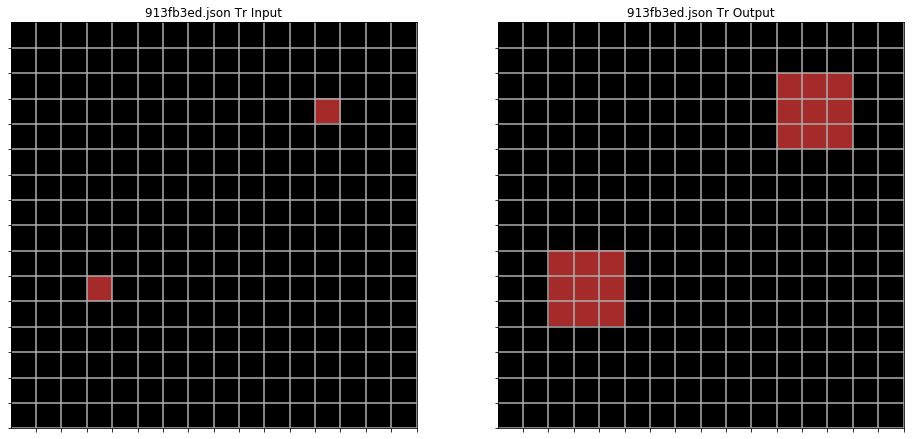

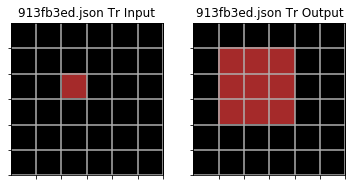

Expected Output


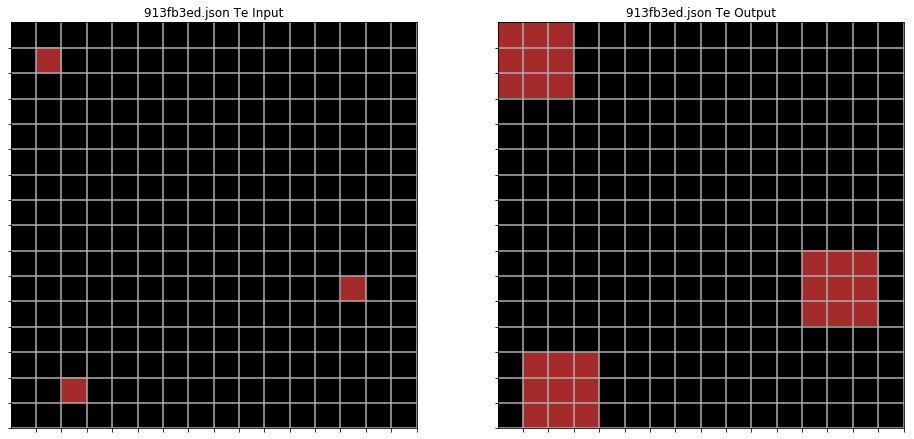

Actual Output


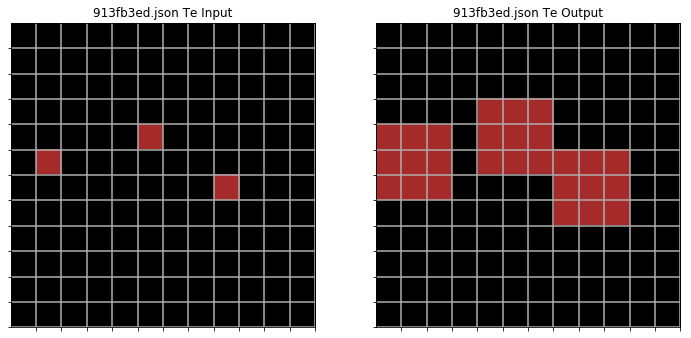

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 9., 9., 9., 0.],
          [0., 0., 9., 9., 9., 0.],
          [0., 0., 9., 9., 9., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.]]]])
pred   op grid tensor([[[[0., 0., 9., 9., 9., 0.],
          [0., 0., 9., 9., 9., 0.],
          [0., 0., 9., 9., 9., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.]]]])
[TEST] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
Training Data


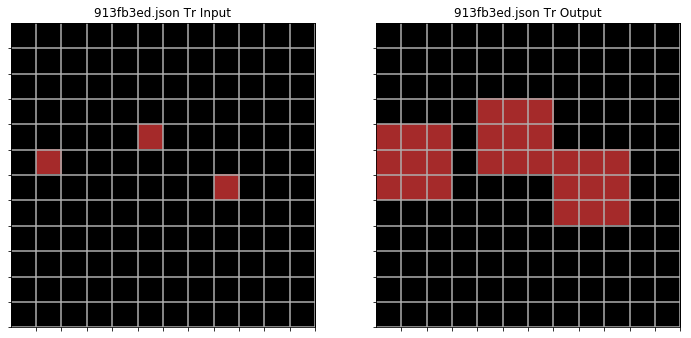

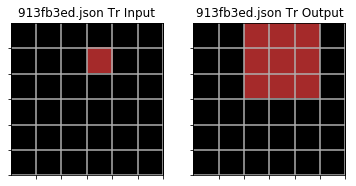

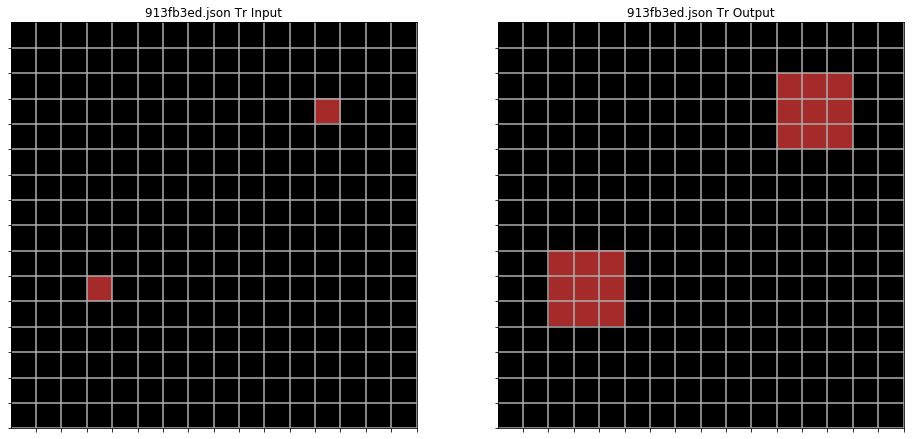

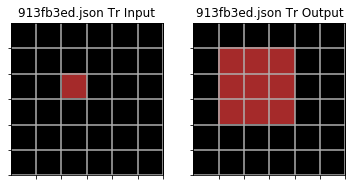

Expected Output


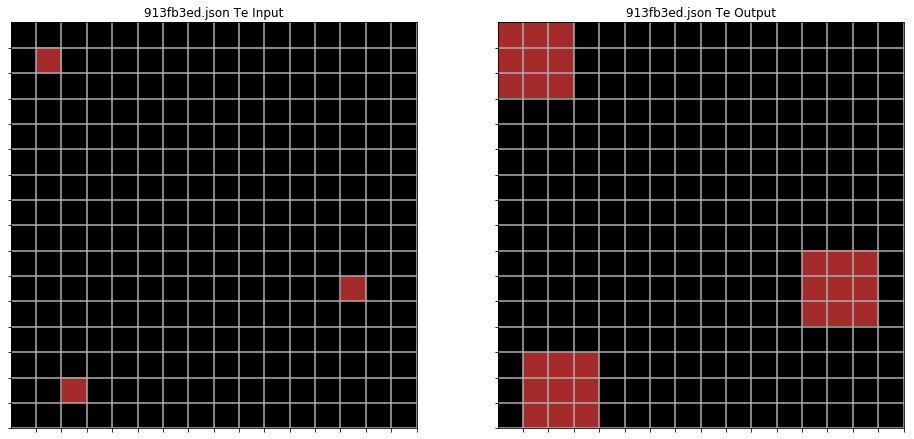

Actual Output


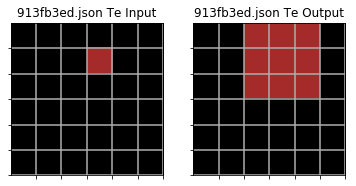

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 

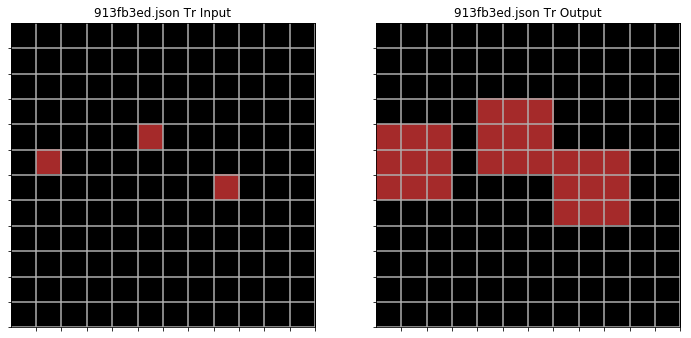

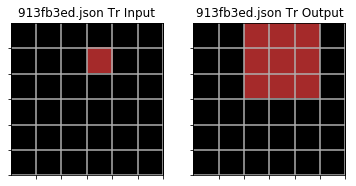

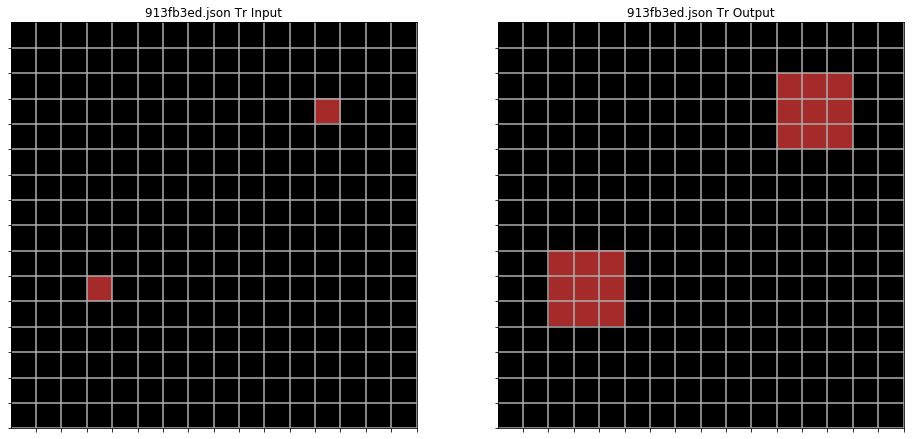

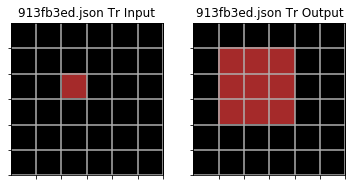

Expected Output


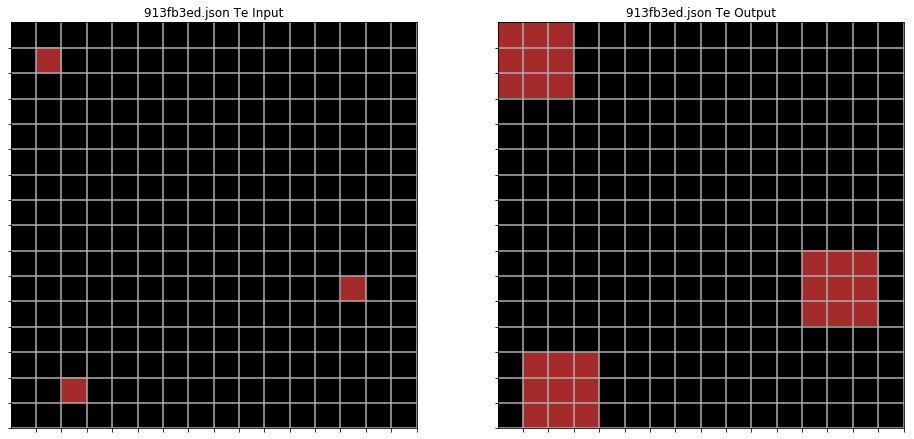

Actual Output


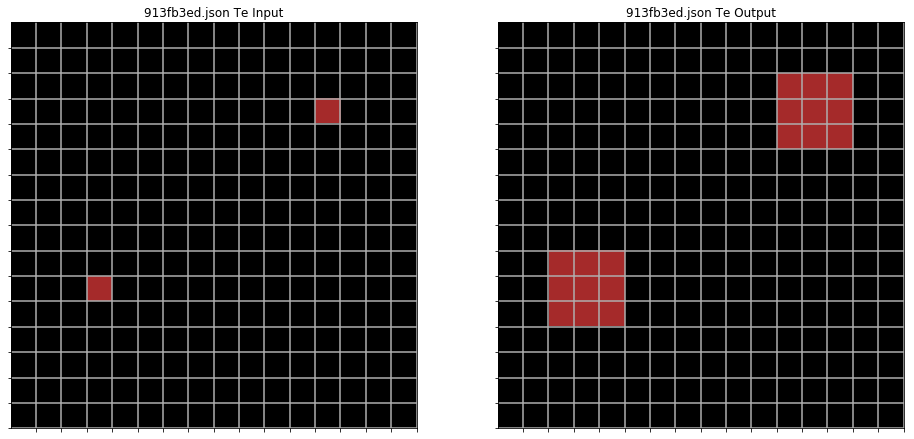

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0.],
          [0., 9., 9., 9., 0., 0.],
          [0., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.]]]])
pred   op grid tensor([[[[0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0.],
          [0., 9., 9., 9., 0., 0.],
          [0., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.]]]])
[TEST] 8 elements matched out of 8 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
Training Data


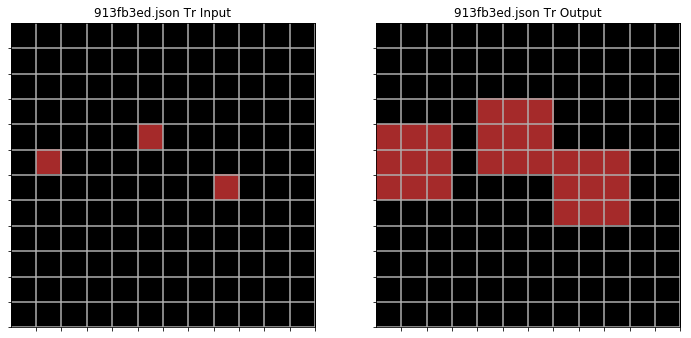

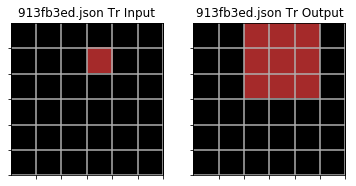

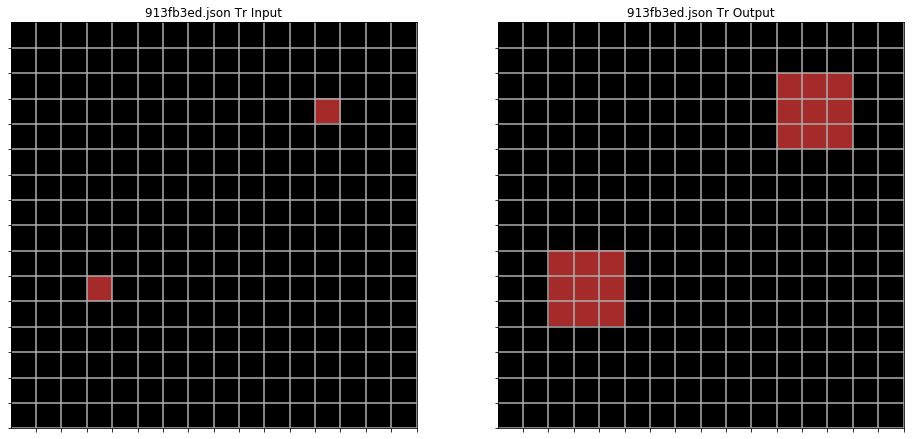

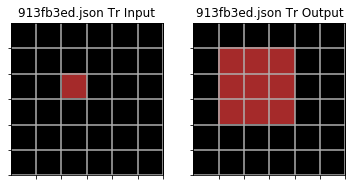

Expected Output


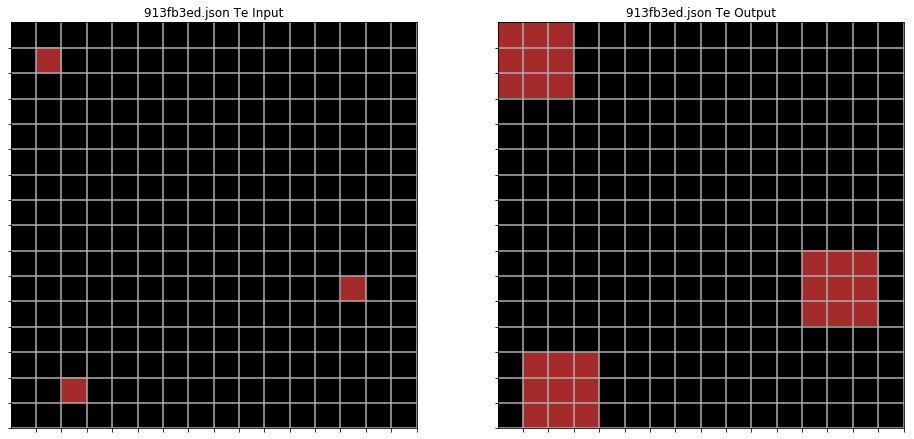

Actual Output


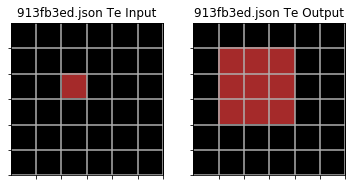

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 

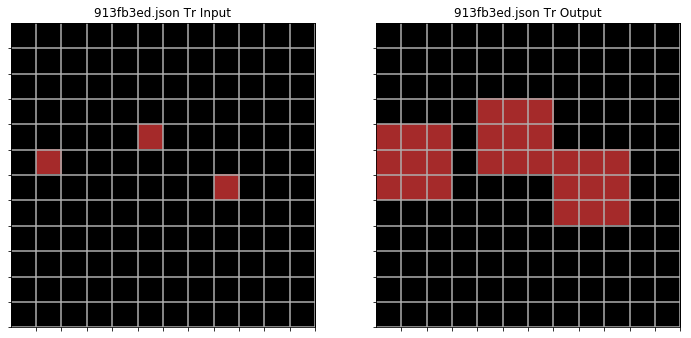

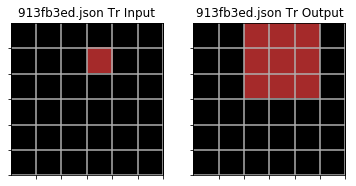

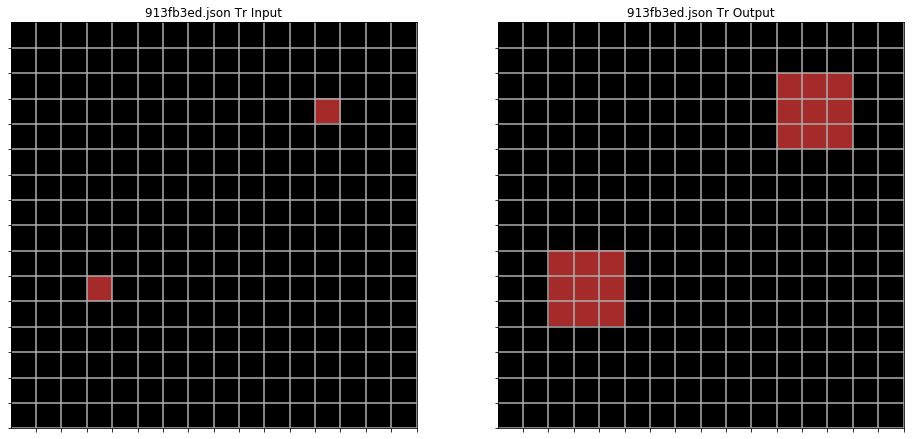

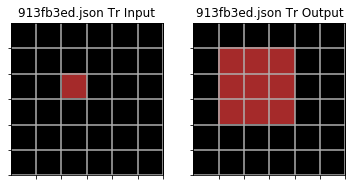

Expected Output


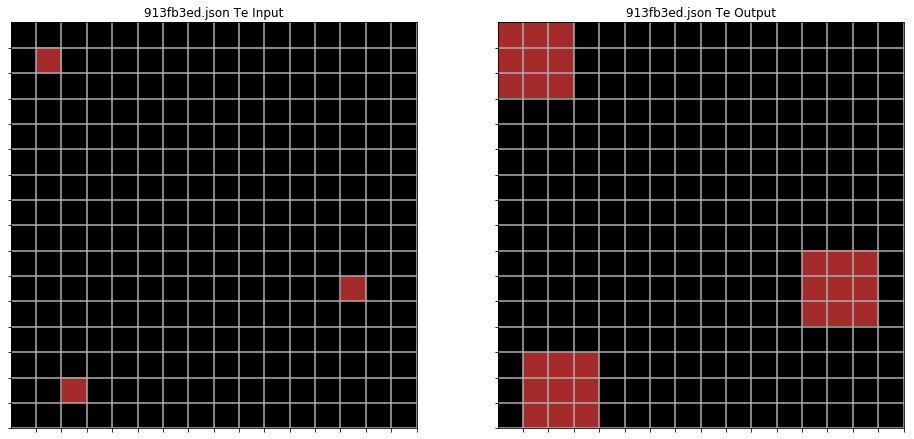

Actual Output


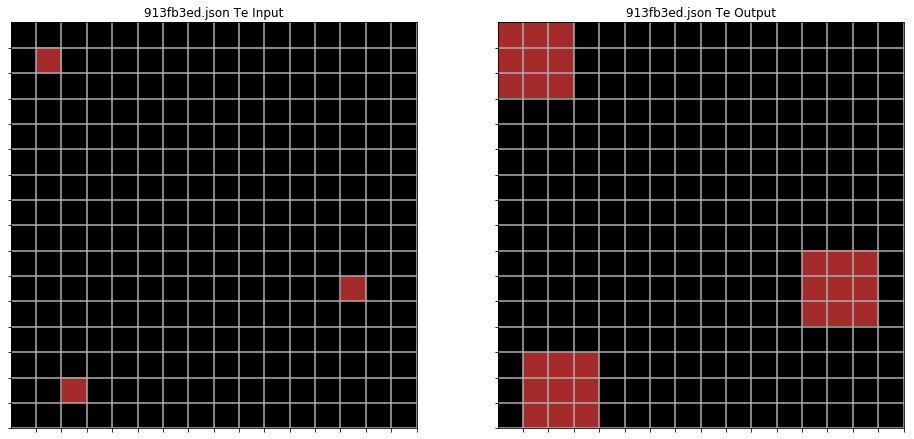

Task successfully solved.


In [189]:
i = 52
ttm = TrainTestModel(ON=9, OFF=0, B = None, kernel_size=3,pad=1, reduction='none', loss_function_type='mse')
ttm.readData(onlyfiles_train[i], noAug=True)
ttm.train(epochs=1000, print_every=1, learning_rate=0.01, test_every=None)
ttm.test()
#Loss function: mse loss (bcz it penalizes the wrong cell more)
#Status: Consistent pattern

Augmentation is OFF.
epoch: 1, batch_id: 0, loss: 4.135673522949219
[TRAIN] 1 elements matched out of 6 diff. elements.        Accuracy: 16.66666603088379. Overall Accuracy: 34.31952667236328
epoch: 1, batch_id: 1, loss: 1.9425952434539795
[TRAIN] 3 elements matched out of 11 diff. elements.        Accuracy: 27.272727966308594. Overall Accuracy: 32.52595138549805
epoch: 1, batch_id: 2, loss: 2.949087142944336
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 51.020408630371094
epoch: 2, batch_id: 0, loss: 1.1977860927581787
[TRAIN] 0 elements matched out of 6 diff. elements.        Accuracy: 0.0. Overall Accuracy: 33.72780990600586
epoch: 2, batch_id: 1, loss: 0.9287652373313904
[TRAIN] 1 elements matched out of 11 diff. elements.        Accuracy: 9.090909004211426. Overall Accuracy: 31.141868591308594
epoch: 2, batch_id: 2, loss: 1.3573817014694214
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 53.0

[TRAIN] 0 elements matched out of 6 diff. elements.        Accuracy: 0.0. Overall Accuracy: 88.75739288330078
epoch: 24, batch_id: 1, loss: 0.3792298436164856
[TRAIN] 0 elements matched out of 11 diff. elements.        Accuracy: 0.0. Overall Accuracy: 87.54325103759766
epoch: 24, batch_id: 2, loss: 0.38997551798820496
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 71.42857360839844
epoch: 25, batch_id: 0, loss: 0.3627505898475647
[TRAIN] 0 elements matched out of 6 diff. elements.        Accuracy: 0.0. Overall Accuracy: 88.75739288330078
epoch: 25, batch_id: 1, loss: 0.373741090297699
[TRAIN] 0 elements matched out of 11 diff. elements.        Accuracy: 0.0. Overall Accuracy: 87.54325103759766
epoch: 25, batch_id: 2, loss: 0.38559967279434204
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 71.42857360839844
epoch: 26, batch_id: 0, loss: 0.3577043414115906
[TRAIN] 0 elements matched out of 6 diff. e

epoch: 48, batch_id: 2, loss: 0.31131288409233093
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 85.71428680419922
epoch: 49, batch_id: 0, loss: 0.2720547318458557
[TRAIN] 0 elements matched out of 6 diff. elements.        Accuracy: 0.0. Overall Accuracy: 94.08283996582031
epoch: 49, batch_id: 1, loss: 0.27827689051628113
[TRAIN] 0 elements matched out of 11 diff. elements.        Accuracy: 0.0. Overall Accuracy: 93.42560577392578
epoch: 49, batch_id: 2, loss: 0.3087955117225647
[TRAIN] 1 elements matched out of 5 diff. elements.        Accuracy: 20.0. Overall Accuracy: 87.7551040649414
epoch: 50, batch_id: 0, loss: 0.2692491412162781
[TRAIN] 0 elements matched out of 6 diff. elements.        Accuracy: 0.0. Overall Accuracy: 94.08283996582031
epoch: 50, batch_id: 1, loss: 0.27532514929771423
[TRAIN] 0 elements matched out of 11 diff. elements.        Accuracy: 0.0. Overall Accuracy: 93.42560577392578
epoch: 50, batch_id: 2, loss: 0.306321650

epoch: 73, batch_id: 1, loss: 0.22096778452396393
[TRAIN] 0 elements matched out of 11 diff. elements.        Accuracy: 0.0. Overall Accuracy: 96.19377136230469
epoch: 73, batch_id: 2, loss: 0.25932130217552185
[TRAIN] 1 elements matched out of 5 diff. elements.        Accuracy: 20.0. Overall Accuracy: 91.83673095703125
epoch: 74, batch_id: 0, loss: 0.21567119657993317
[TRAIN] 1 elements matched out of 6 diff. elements.        Accuracy: 16.66666603088379. Overall Accuracy: 97.04141998291016
epoch: 74, batch_id: 1, loss: 0.21907584369182587
[TRAIN] 0 elements matched out of 11 diff. elements.        Accuracy: 0.0. Overall Accuracy: 96.19377136230469
epoch: 74, batch_id: 2, loss: 0.25763267278671265
[TRAIN] 1 elements matched out of 5 diff. elements.        Accuracy: 20.0. Overall Accuracy: 91.83673095703125
epoch: 75, batch_id: 0, loss: 0.21389402449131012
[TRAIN] 1 elements matched out of 6 diff. elements.        Accuracy: 16.66666603088379. Overall Accuracy: 97.04141998291016
epoch: 7

[TRAIN] 1 elements matched out of 5 diff. elements.        Accuracy: 20.0. Overall Accuracy: 91.83673095703125
epoch: 100, batch_id: 0, loss: 0.17739450931549072
[TRAIN] 1 elements matched out of 6 diff. elements.        Accuracy: 16.66666603088379. Overall Accuracy: 97.04141998291016
epoch: 100, batch_id: 1, loss: 0.179106667637825
[TRAIN] 2 elements matched out of 11 diff. elements.        Accuracy: 18.18181800842285. Overall Accuracy: 96.88581085205078
epoch: 100, batch_id: 2, loss: 0.22098985314369202
[TRAIN] 1 elements matched out of 5 diff. elements.        Accuracy: 20.0. Overall Accuracy: 91.83673095703125
epoch: 101, batch_id: 0, loss: 0.17619502544403076
[TRAIN] 1 elements matched out of 6 diff. elements.        Accuracy: 16.66666603088379. Overall Accuracy: 97.04141998291016
epoch: 101, batch_id: 1, loss: 0.17785808444023132
[TRAIN] 2 elements matched out of 11 diff. elements.        Accuracy: 18.18181800842285. Overall Accuracy: 96.88581085205078
epoch: 101, batch_id: 2, lo

epoch: 123, batch_id: 1, loss: 0.15424853563308716
[TRAIN] 2 elements matched out of 11 diff. elements.        Accuracy: 18.18181800842285. Overall Accuracy: 96.88581085205078
epoch: 123, batch_id: 2, loss: 0.19710564613342285
[TRAIN] 1 elements matched out of 5 diff. elements.        Accuracy: 20.0. Overall Accuracy: 91.83673095703125
epoch: 124, batch_id: 0, loss: 0.15256977081298828
[TRAIN] 2 elements matched out of 6 diff. elements.        Accuracy: 33.33333206176758. Overall Accuracy: 97.63313293457031
epoch: 124, batch_id: 1, loss: 0.15332606434822083
[TRAIN] 2 elements matched out of 11 diff. elements.        Accuracy: 18.18181800842285. Overall Accuracy: 96.88581085205078
epoch: 124, batch_id: 2, loss: 0.19620005786418915
[TRAIN] 1 elements matched out of 5 diff. elements.        Accuracy: 20.0. Overall Accuracy: 91.83673095703125
epoch: 125, batch_id: 0, loss: 0.15168993175029755
[TRAIN] 2 elements matched out of 6 diff. elements.        Accuracy: 33.33333206176758. Overall Ac

[TRAIN] 2 elements matched out of 11 diff. elements.        Accuracy: 18.18181800842285. Overall Accuracy: 96.88581085205078
epoch: 147, batch_id: 2, loss: 0.1777382642030716
[TRAIN] 1 elements matched out of 5 diff. elements.        Accuracy: 20.0. Overall Accuracy: 91.83673095703125
epoch: 148, batch_id: 0, loss: 0.13402336835861206
[TRAIN] 2 elements matched out of 6 diff. elements.        Accuracy: 33.33333206176758. Overall Accuracy: 97.63313293457031
epoch: 148, batch_id: 1, loss: 0.13415999710559845
[TRAIN] 2 elements matched out of 11 diff. elements.        Accuracy: 18.18181800842285. Overall Accuracy: 96.88581085205078
epoch: 148, batch_id: 2, loss: 0.17702616751194
[TRAIN] 1 elements matched out of 5 diff. elements.        Accuracy: 20.0. Overall Accuracy: 91.83673095703125
epoch: 149, batch_id: 0, loss: 0.133352592587471
[TRAIN] 2 elements matched out of 6 diff. elements.        Accuracy: 33.33333206176758. Overall Accuracy: 97.63313293457031
epoch: 149, batch_id: 1, loss: 

epoch: 171, batch_id: 1, loss: 0.1199471727013588
[TRAIN] 2 elements matched out of 11 diff. elements.        Accuracy: 18.18181800842285. Overall Accuracy: 96.88581085205078
epoch: 171, batch_id: 2, loss: 0.16230711340904236
[TRAIN] 1 elements matched out of 5 diff. elements.        Accuracy: 20.0. Overall Accuracy: 91.83673095703125
epoch: 172, batch_id: 0, loss: 0.11967606097459793
[TRAIN] 2 elements matched out of 6 diff. elements.        Accuracy: 33.33333206176758. Overall Accuracy: 97.63313293457031
epoch: 172, batch_id: 1, loss: 0.1194007396697998
[TRAIN] 2 elements matched out of 11 diff. elements.        Accuracy: 18.18181800842285. Overall Accuracy: 96.88581085205078
epoch: 172, batch_id: 2, loss: 0.16173163056373596
[TRAIN] 1 elements matched out of 5 diff. elements.        Accuracy: 20.0. Overall Accuracy: 91.83673095703125
epoch: 173, batch_id: 0, loss: 0.11914871633052826
[TRAIN] 2 elements matched out of 6 diff. elements.        Accuracy: 33.33333206176758. Overall Accu

epoch: 195, batch_id: 1, loss: 0.10814841091632843
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 195, batch_id: 2, loss: 0.14970341324806213
[TRAIN] 4 elements matched out of 5 diff. elements.        Accuracy: 80.0. Overall Accuracy: 97.95918273925781
epoch: 196, batch_id: 0, loss: 0.10826365649700165
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 196, batch_id: 1, loss: 0.10771029442548752
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 196, batch_id: 2, loss: 0.14922790229320526
[TRAIN] 4 elements matched out of 5 diff. elements.        Accuracy: 80.0. Overall Accuracy: 97.95918273925781
epoch: 197, batch_id: 0, loss: 0.1078387126326561
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 197, batch_id:

epoch: 219, batch_id: 2, loss: 0.13919948041439056
[TRAIN] 4 elements matched out of 5 diff. elements.        Accuracy: 80.0. Overall Accuracy: 97.95918273925781
epoch: 220, batch_id: 0, loss: 0.09897742420434952
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 220, batch_id: 1, loss: 0.0982351005077362
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 220, batch_id: 2, loss: 0.13879939913749695
[TRAIN] 4 elements matched out of 5 diff. elements.        Accuracy: 80.0. Overall Accuracy: 97.95918273925781
epoch: 221, batch_id: 0, loss: 0.09862794727087021
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 221, batch_id: 1, loss: 0.09787920862436295
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 221, batch_id:

epoch: 244, batch_id: 0, loss: 0.0912773609161377
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 244, batch_id: 1, loss: 0.09040709584951401
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 244, batch_id: 2, loss: 0.12995651364326477
[TRAIN] 4 elements matched out of 5 diff. elements.        Accuracy: 80.0. Overall Accuracy: 97.95918273925781
epoch: 245, batch_id: 0, loss: 0.0909850224852562
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 245, batch_id: 1, loss: 0.0901104211807251
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 245, batch_id: 2, loss: 0.12961697578430176
[TRAIN] 4 elements matched out of 5 diff. elements.        Accuracy: 80.0. Overall Accuracy: 97.95918273925781
epoch: 246, batch_id: 0

epoch: 268, batch_id: 0, loss: 0.08479059487581253
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 268, batch_id: 1, loss: 0.08383502066135406
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 268, batch_id: 2, loss: 0.12235332280397415
[TRAIN] 4 elements matched out of 5 diff. elements.        Accuracy: 80.0. Overall Accuracy: 97.95918273925781
epoch: 269, batch_id: 0, loss: 0.08454244583845139
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 269, batch_id: 1, loss: 0.08358404785394669
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 269, batch_id: 2, loss: 0.12205944955348969
[TRAIN] 4 elements matched out of 5 diff. elements.        Accuracy: 80.0. Overall Accuracy: 97.95918273925781
epoch: 270, batch_id

[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 292, batch_id: 2, loss: 0.11573835462331772
[TRAIN] 4 elements matched out of 5 diff. elements.        Accuracy: 80.0. Overall Accuracy: 97.95918273925781
epoch: 293, batch_id: 0, loss: 0.07903829962015152
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 293, batch_id: 1, loss: 0.07802607864141464
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 293, batch_id: 2, loss: 0.11548128724098206
[TRAIN] 4 elements matched out of 5 diff. elements.        Accuracy: 80.0. Overall Accuracy: 97.95918273925781
epoch: 294, batch_id: 0, loss: 0.07882633060216904
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 294, batch_id: 1, loss: 0.07781235128641129
[TRAIN] 10 elements 

[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 316, batch_id: 2, loss: 0.10992443561553955
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 317, batch_id: 0, loss: 0.07428119331598282
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 317, batch_id: 1, loss: 0.07323671877384186
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 317, batch_id: 2, loss: 0.1096973717212677
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 318, batch_id: 0, loss: 0.07409694790840149
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 318, batch_id: 1, loss: 0.07305151224136353
[TRAIN] 10 elements matched out of 11 diff.

[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 340, batch_id: 2, loss: 0.10476920753717422
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 341, batch_id: 0, loss: 0.07012809813022614
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 341, batch_id: 1, loss: 0.06906715780496597
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 341, batch_id: 2, loss: 0.10456695407629013
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 342, batch_id: 0, loss: 0.06996642053127289
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 342, batch_id: 1, loss: 0.06890510767698288
[TRAIN] 10 elements matched out of 11 diff

epoch: 362, batch_id: 0, loss: 0.06690335273742676
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 362, batch_id: 1, loss: 0.06583771854639053
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 362, batch_id: 2, loss: 0.10052775591611862
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 363, batch_id: 0, loss: 0.06675825268030167
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 363, batch_id: 1, loss: 0.06569253653287888
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 363, batch_id: 2, loss: 0.10034475475549698
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 364, batch_id: 0, loss: 0.066613860

epoch: 384, batch_id: 1, loss: 0.06280580908060074
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 384, batch_id: 2, loss: 0.09667973965406418
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 385, batch_id: 0, loss: 0.06373868882656097
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 385, batch_id: 1, loss: 0.06267562508583069
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 385, batch_id: 2, loss: 0.0965132936835289
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 386, batch_id: 0, loss: 0.06360886991024017
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 386, batch_id: 1, loss: 0.0625460669

[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 408, batch_id: 2, loss: 0.0928669199347496
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 409, batch_id: 0, loss: 0.06078284978866577
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 409, batch_id: 1, loss: 0.059728991240262985
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 409, batch_id: 2, loss: 0.09271591901779175
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 410, batch_id: 0, loss: 0.060666512697935104
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 410, batch_id: 1, loss: 0.059613171964883804
[TRAIN] 10 elements matched out of 11 di

epoch: 432, batch_id: 2, loss: 0.08939985185861588
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 433, batch_id: 0, loss: 0.058126844465732574
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 433, batch_id: 1, loss: 0.057087209075689316
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 433, batch_id: 2, loss: 0.08926215767860413
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 434, batch_id: 0, loss: 0.05802202597260475
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 434, batch_id: 1, loss: 0.056983038783073425
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 434, batch_id: 2, loss: 0.089124

[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 457, batch_id: 0, loss: 0.05572668835520744
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 457, batch_id: 1, loss: 0.05470491200685501
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 457, batch_id: 2, loss: 0.08610537648200989
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 458, batch_id: 0, loss: 0.055631715804338455
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 458, batch_id: 1, loss: 0.054610710591077805
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 458, batch_id: 2, loss: 0.08597967773675919
[TRAIN] 5 elements matched out of 5 diff

[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 481, batch_id: 2, loss: 0.08320709317922592
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 482, batch_id: 0, loss: 0.05346004664897919
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 482, batch_id: 1, loss: 0.05245969817042351
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 482, batch_id: 2, loss: 0.08309147506952286
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 483, batch_id: 0, loss: 0.05337384343147278
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 483, batch_id: 1, loss: 0.05237441137433052
[TRAIN] 10 elements matched out of 11 diff

epoch: 505, batch_id: 2, loss: 0.0805354118347168
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 506, batch_id: 0, loss: 0.05147784575819969
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 506, batch_id: 1, loss: 0.0505000539124012
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 506, batch_id: 2, loss: 0.0804285928606987
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 507, batch_id: 0, loss: 0.051399022340774536
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 507, batch_id: 1, loss: 0.050422169268131256
[TRAIN] 10 elements matched out of 11 diff. elements.        Accuracy: 90.90908813476562. Overall Accuracy: 99.65397644042969
epoch: 507, batch_id: 2, loss: 0.0803221240

epoch: 529, batch_id: 2, loss: 0.07806340605020523
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 530, batch_id: 0, loss: 0.04966094717383385
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 530, batch_id: 1, loss: 0.04870699346065521
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 530, batch_id: 2, loss: 0.07796439528465271
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 531, batch_id: 0, loss: 0.04958847910165787
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 531, batch_id: 1, loss: 0.048635583370923996
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 531, batch_id: 2, loss: 0.07786568999290466
[TRAIN] 5 elements matched out of 5 di

[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 553, batch_id: 1, loss: 0.04712580889463425
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 553, batch_id: 2, loss: 0.07576850801706314
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 554, batch_id: 0, loss: 0.04798898845911026
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 554, batch_id: 1, loss: 0.04705985262989998
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 554, batch_id: 2, loss: 0.07567644119262695
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 555, batch_id: 0, loss: 0.047922223806381226
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accur

[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 577, batch_id: 1, loss: 0.04560212045907974
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 577, batch_id: 2, loss: 0.07363133877515793
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 578, batch_id: 0, loss: 0.04644501209259033
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 578, batch_id: 1, loss: 0.04554120451211929
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 578, batch_id: 2, loss: 0.07354544848203659
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 579, batch_id: 0, loss: 0.04638322815299034
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accura

epoch: 601, batch_id: 0, loss: 0.045072004199028015
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 601, batch_id: 1, loss: 0.04419277235865593
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 601, batch_id: 2, loss: 0.07163538038730621
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 602, batch_id: 0, loss: 0.04501448571681976
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 602, batch_id: 1, loss: 0.04413633421063423
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 602, batch_id: 2, loss: 0.07155506312847137
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 603, batch_id: 0, loss: 0.044957149773836136
[TRAIN] 6 elements matched out of 6 d

epoch: 625, batch_id: 0, loss: 0.04373857006430626
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 625, batch_id: 1, loss: 0.042885079979896545
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 625, batch_id: 2, loss: 0.06976637989282608
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 626, batch_id: 0, loss: 0.04368504509329796
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 626, batch_id: 1, loss: 0.04283265024423599
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 626, batch_id: 2, loss: 0.06969109177589417
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 627, batch_id: 0, loss: 0.04363170266151428
[TRAIN] 6 elements matched out of 6 di

[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 649, batch_id: 0, loss: 0.04249598830938339
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 649, batch_id: 1, loss: 0.041668202728033066
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 649, batch_id: 2, loss: 0.06801187247037888
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 650, batch_id: 0, loss: 0.04244605824351311
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 650, batch_id: 1, loss: 0.04161933436989784
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 650, batch_id: 2, loss: 0.06794111430644989
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accur

[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 673, batch_id: 0, loss: 0.04133504629135132
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 673, batch_id: 1, loss: 0.04053280130028725
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 673, batch_id: 2, loss: 0.0663611888885498
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 674, batch_id: 0, loss: 0.04128832370042801
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 674, batch_id: 1, loss: 0.040487129241228104
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 674, batch_id: 2, loss: 0.06629452109336853
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accura

epoch: 695, batch_id: 1, loss: 0.03955664858222008
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 695, batch_id: 2, loss: 0.06493119150400162
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 696, batch_id: 0, loss: 0.04029169678688049
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 696, batch_id: 1, loss: 0.039513662457466125
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 696, batch_id: 2, loss: 0.06486798077821732
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 697, batch_id: 0, loss: 0.040247779339551926
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 697, batch_id: 1, loss: 0.03947077691555023
[TRAIN] 11 elements matched out of 11

epoch: 716, batch_id: 0, loss: 0.039434559643268585
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 716, batch_id: 1, loss: 0.03867731988430023
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 716, batch_id: 2, loss: 0.06363420933485031
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 717, batch_id: 0, loss: 0.039392851293087006
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 717, batch_id: 1, loss: 0.03863666206598282
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 717, batch_id: 2, loss: 0.06357402354478836
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 718, batch_id: 0, loss: 0.039351269602775574
[TRAIN] 6 elements matched out of 6 

epoch: 737, batch_id: 1, loss: 0.037845008075237274
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 737, batch_id: 2, loss: 0.062398653477430344
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 738, batch_id: 0, loss: 0.038541123270988464
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 738, batch_id: 1, loss: 0.03780646622180939
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 738, batch_id: 2, loss: 0.062341250479221344
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 739, batch_id: 0, loss: 0.038501668721437454
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 739, batch_id: 1, loss: 0.037768032401800156
[TRAIN] 11 elements matched out o

epoch: 760, batch_id: 2, loss: 0.06111050769686699
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 761, batch_id: 0, loss: 0.03765783831477165
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 761, batch_id: 1, loss: 0.03694641962647438
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 761, batch_id: 2, loss: 0.06105596199631691
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 762, batch_id: 0, loss: 0.03762055188417435
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 762, batch_id: 1, loss: 0.03691013902425766
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 762, batch_id: 2, loss: 0.06100153550505638
[TRAIN] 5 elements matched out of 5 dif

epoch: 782, batch_id: 2, loss: 0.059937287122011185
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 783, batch_id: 0, loss: 0.03685758635401726
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 783, batch_id: 1, loss: 0.03616800904273987
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 783, batch_id: 2, loss: 0.059885259717702866
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 784, batch_id: 0, loss: 0.03682218864560127
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 784, batch_id: 1, loss: 0.036133598536252975
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 784, batch_id: 2, loss: 0.0598333403468132
[TRAIN] 5 elements matched out of 5 d

[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 806, batch_id: 1, loss: 0.035396698862314224
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 806, batch_id: 2, loss: 0.058718178421258926
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 807, batch_id: 0, loss: 0.036030299961566925
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 807, batch_id: 1, loss: 0.03536409139633179
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 807, batch_id: 2, loss: 0.05866869166493416
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 808, batch_id: 0, loss: 0.03599678725004196
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Acc

epoch: 829, batch_id: 2, loss: 0.05760498344898224
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 830, batch_id: 0, loss: 0.035278696566820145
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 830, batch_id: 1, loss: 0.03463442996144295
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 830, batch_id: 2, loss: 0.057557739317417145
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 831, batch_id: 0, loss: 0.03524688258767128
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 831, batch_id: 1, loss: 0.03460356965661049
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 831, batch_id: 2, loss: 0.057510603219270706
[TRAIN] 5 elements matched out of 5 

[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 853, batch_id: 1, loss: 0.033941514790058136
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 853, batch_id: 2, loss: 0.05649665743112564
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 854, batch_id: 0, loss: 0.034534014761447906
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 854, batch_id: 1, loss: 0.03391216695308685
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 854, batch_id: 2, loss: 0.056451573967933655
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 855, batch_id: 0, loss: 0.03450382128357887
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Acc

[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 876, batch_id: 1, loss: 0.033282529562711716
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 876, batch_id: 2, loss: 0.05548197031021118
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 877, batch_id: 0, loss: 0.03385543078184128
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 877, batch_id: 1, loss: 0.033254608511924744
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 877, batch_id: 2, loss: 0.05543885380029678
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 878, batch_id: 0, loss: 0.033826664090156555
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Acc

[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 900, batch_id: 2, loss: 0.05446915328502655
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 901, batch_id: 0, loss: 0.03318117558956146
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 901, batch_id: 1, loss: 0.03260177746415138
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 901, batch_id: 2, loss: 0.054427921772003174
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 902, batch_id: 0, loss: 0.03315379470586777
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 902, batch_id: 1, loss: 0.032575275748968124
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Ac

epoch: 923, batch_id: 2, loss: 0.05353964492678642
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 924, batch_id: 0, loss: 0.032565031200647354
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 924, batch_id: 1, loss: 0.032005712389945984
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 924, batch_id: 2, loss: 0.053500108420848846
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 925, batch_id: 0, loss: 0.03253887966275215
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 925, batch_id: 1, loss: 0.03198042884469032
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 925, batch_id: 2, loss: 0.05346062779426575
[TRAIN] 5 elements matched out of 5 

[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 947, batch_id: 1, loss: 0.031436629593372345
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 947, batch_id: 2, loss: 0.0526098906993866
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 948, batch_id: 0, loss: 0.031951311975717545
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 948, batch_id: 1, loss: 0.03141246736049652
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 948, batch_id: 2, loss: 0.052571993321180344
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 949, batch_id: 0, loss: 0.03192634880542755
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accu

epoch: 971, batch_id: 0, loss: 0.03138919919729233
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 971, batch_id: 1, loss: 0.030869510024785995
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 971, batch_id: 2, loss: 0.05171844735741615
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 972, batch_id: 0, loss: 0.03136530518531799
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 972, batch_id: 1, loss: 0.03084644116461277
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 972, batch_id: 2, loss: 0.051682084798812866
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 973, batch_id: 0, loss: 0.03134145587682724
[TRAIN] 6 elements matched out of 6 d

[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 996, batch_id: 0, loss: 0.0308050736784935
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 996, batch_id: 1, loss: 0.03030572086572647
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 996, batch_id: 2, loss: 0.05082792043685913
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 997, batch_id: 0, loss: 0.03078228235244751
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 997, batch_id: 1, loss: 0.030283719301223755
[TRAIN] 11 elements matched out of 11 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 997, batch_id: 2, loss: 0.05079307407140732
[TRAIN] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overall Accura

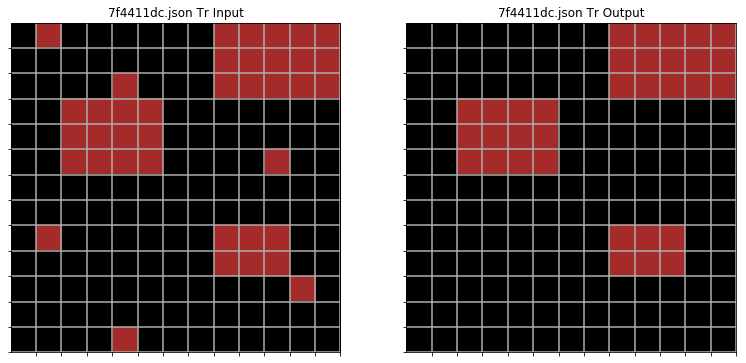

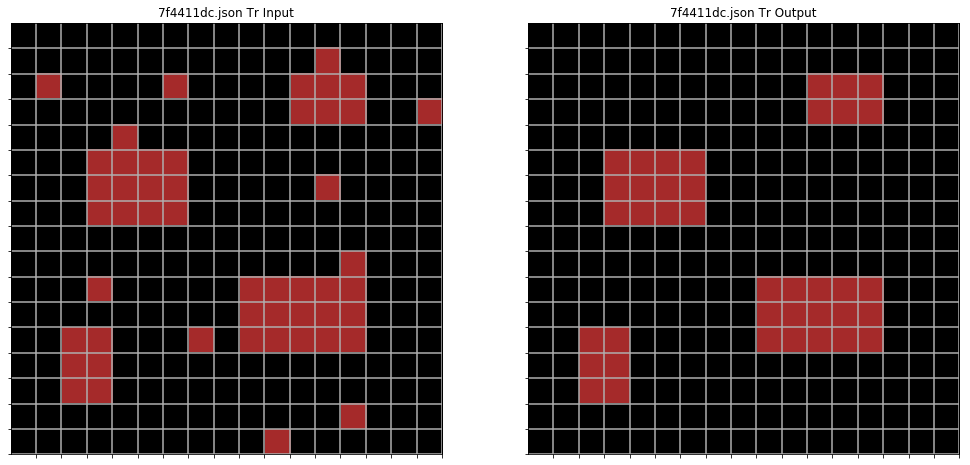

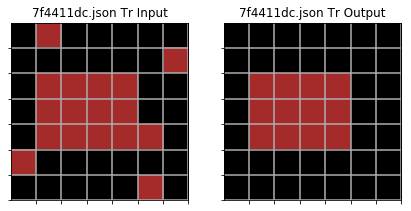

Expected Output


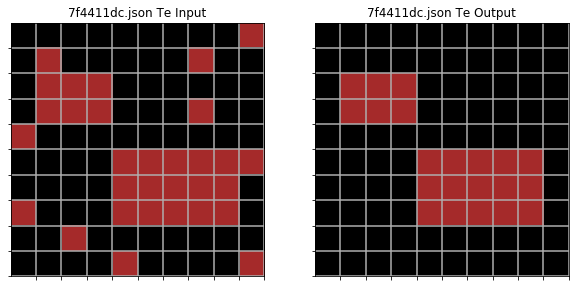

Actual Output


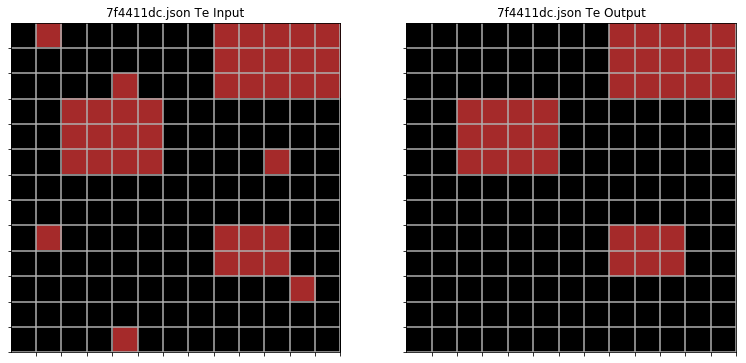

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0., 0.],
          [0., 9., 0., 0., 0., 0., 9., 0., 0., 0., 0., 9., 9., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 9., 9., 9., 0., 0., 9.],
          [0., 0., 0., 0., 9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 9., 9., 9., 0., 0., 0., 0., 0., 9., 0., 0., 0., 0.],
          [0., 0., 0., 9., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 9., 0., 0., 0., 0., 0., 9., 9., 9., 9., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 9., 9., 9., 9., 9., 0., 0., 0.],

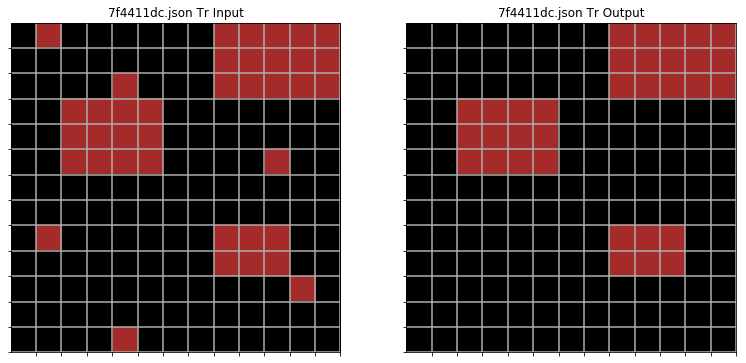

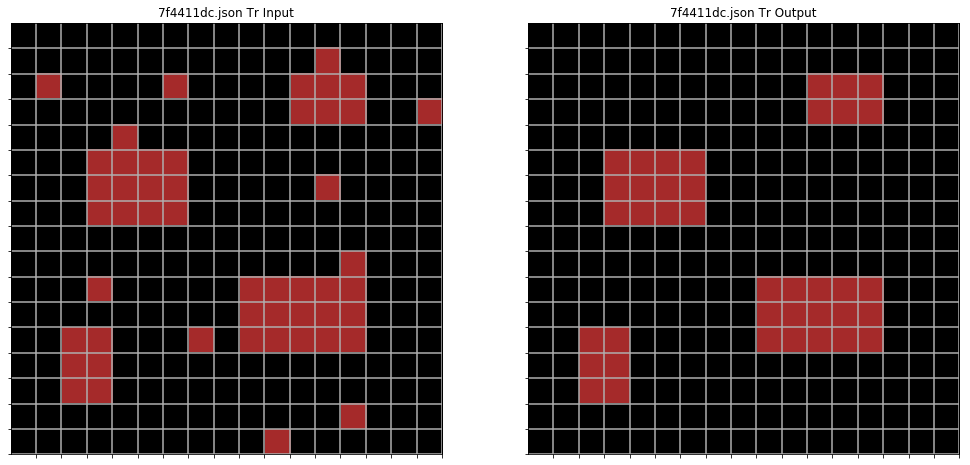

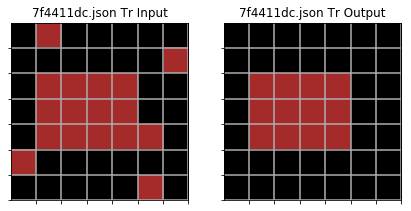

Expected Output


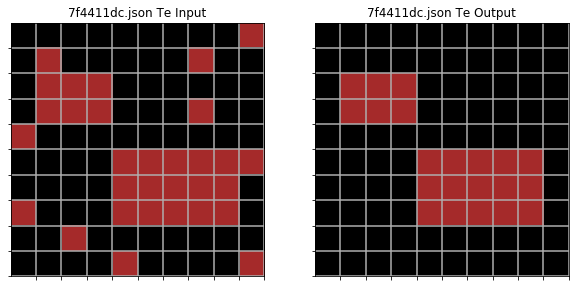

Actual Output


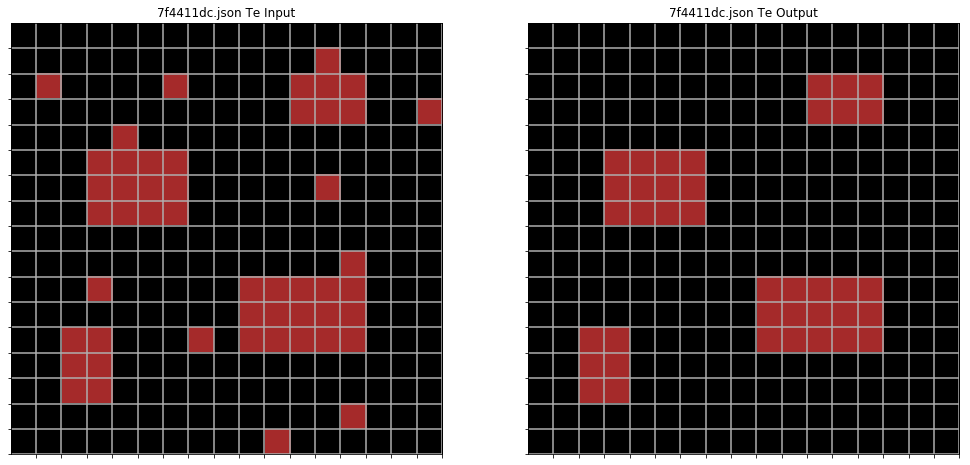

Task successfully solved.
actual ip grid tensor([[[[0., 9., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 9.],
          [0., 9., 9., 9., 9., 0., 0.],
          [0., 9., 9., 9., 9., 0., 0.],
          [0., 9., 9., 9., 9., 9., 0.],
          [9., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 9., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 9., 0., 0.],
          [0., 9., 9., 9., 9., 0., 0.],
          [0., 9., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]]])
pred   op grid tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 9., 0., 0.],
          [0., 9., 9., 9., 9., 0., 0.],
          [0., 9., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]]])
[TEST] 5 elements matched out of 5 diff. elements.        Accuracy: 100.0. Overa

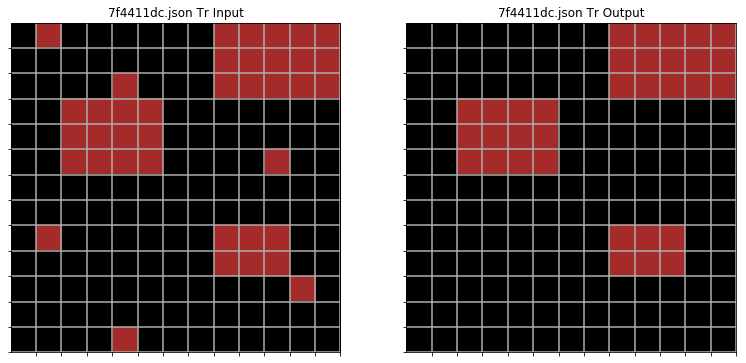

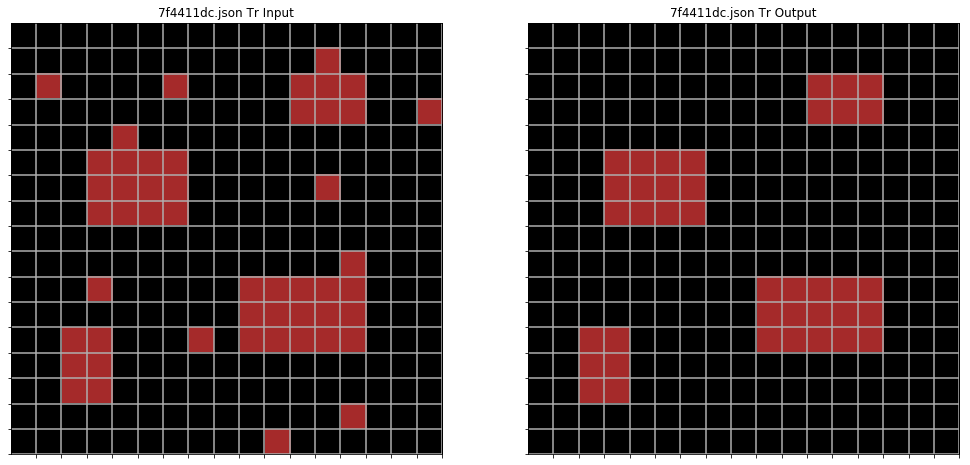

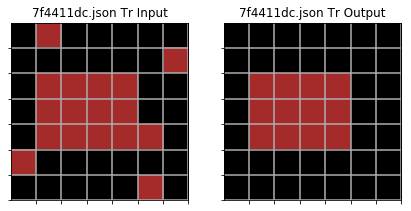

Expected Output


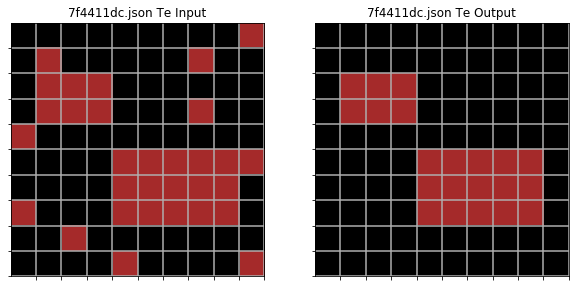

Actual Output


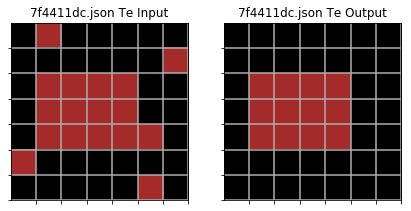

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 9.],
          [0., 9., 0., 0., 0., 0., 0., 9., 0., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0., 0., 9., 0., 0.],
          [9., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 9., 9., 9., 9., 9., 9.],
          [0., 0., 0., 0., 9., 9., 9., 9., 9., 0.],
          [9., 0., 0., 0., 9., 9., 9., 9., 9., 0.],
          [0., 0., 9., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 9., 0., 0., 0., 0., 9.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 9., 9., 9., 9., 9., 0.],
          [0., 0., 0., 0., 9., 9., 9., 9., 9., 0.],
          [0., 0., 0., 0., 9., 9., 9., 9., 9., 0.],
     

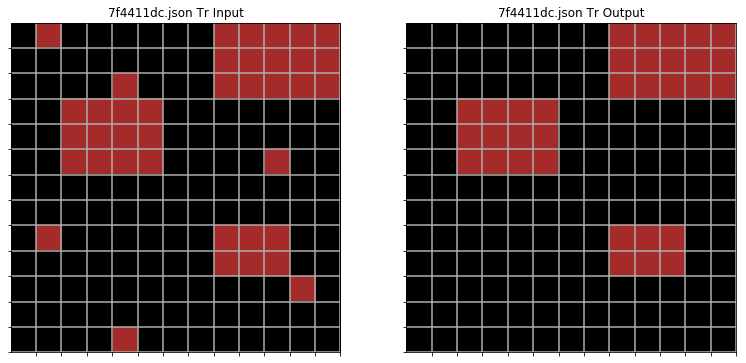

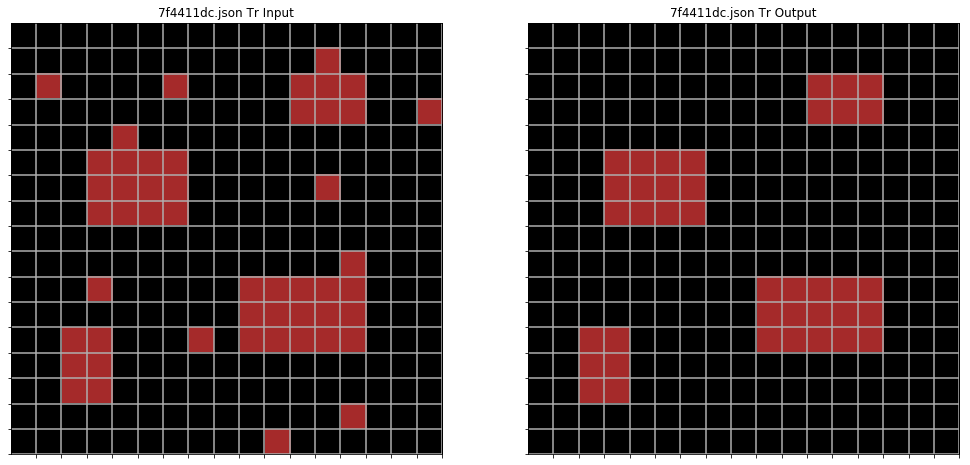

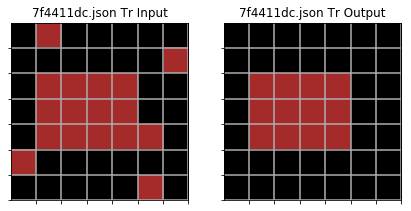

Expected Output


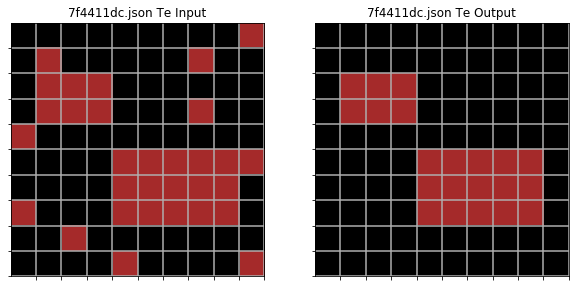

Actual Output


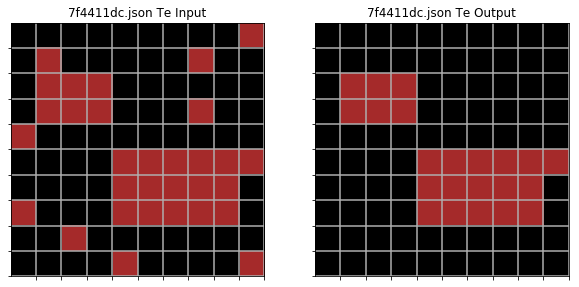

NN not able to solve the task


In [187]:
i = 47
ttm = TrainTestModel(ON=9, OFF=0, B = None, kernel_size=3,pad=1, reduction='none', loss_function_type='mse')
ttm.readData(onlyfiles_train[i], noAug=True)
ttm.train(epochs=1000, print_every=1, learning_rate=0.01, test_every=None)
ttm.test()
#Loss function: mse loss (bcz it penalizes the wrong cell more)
#Status: Not solved because a pattern was not seen in input

Augmentation is OFF.
epoch: 1, batch_id: 0, loss: 2.364387273788452
[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 58.241756439208984
epoch: 1, batch_id: 1, loss: 1.3162131309509277
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 63.94230651855469
epoch: 2, batch_id: 0, loss: 1.1926391124725342
[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 60.43955993652344
epoch: 2, batch_id: 1, loss: 0.8173391819000244
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 60.57692337036133
epoch: 3, batch_id: 0, loss: 0.8311920166015625
[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 60.989009857177734
epoch: 3, batch_id: 1, loss: 0.6406786441802979
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 61.53845977783203
epoch: 4, batch_id: 0, loss: 0

epoch: 33, batch_id: 1, loss: 0.29577019810676575
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 75.48076629638672
epoch: 34, batch_id: 0, loss: 0.31027019023895264
[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 76.37362670898438
epoch: 34, batch_id: 1, loss: 0.29335010051727295
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 75.48076629638672
epoch: 35, batch_id: 0, loss: 0.3078068196773529
[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 76.37362670898438
epoch: 35, batch_id: 1, loss: 0.29101160168647766
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 89.42308044433594
epoch: 36, batch_id: 0, loss: 0.3054356276988983
[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 88.46154022216797
epoch: 36, batch_id: 1, loss: 0.2887491881

[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 88.46154022216797
epoch: 68, batch_id: 1, loss: 0.23835429549217224
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 91.82691955566406
epoch: 69, batch_id: 0, loss: 0.2535313665866852
[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 88.46154022216797
epoch: 69, batch_id: 1, loss: 0.23716698586940765
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 91.82691955566406
epoch: 70, batch_id: 0, loss: 0.2523697316646576
[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 88.46154022216797
epoch: 70, batch_id: 1, loss: 0.23599377274513245
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 91.82691955566406
epoch: 71, batch_id: 0, loss: 0.2512212097644806
[TRAIN] 0 elements matched out of 7 diff. e

[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 91.82691955566406
epoch: 104, batch_id: 0, loss: 0.21899588406085968
[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 88.46154022216797
epoch: 104, batch_id: 1, loss: 0.2025018036365509
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 91.82691955566406
epoch: 105, batch_id: 0, loss: 0.21815599501132965
[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 88.46154022216797
epoch: 105, batch_id: 1, loss: 0.20166537165641785
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 91.82691955566406
epoch: 106, batch_id: 0, loss: 0.21732275187969208
[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 88.46154022216797
epoch: 106, batch_id: 1, loss: 0.20083580911159515
[TRAIN] 0 elements matched out of 5

[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 91.82691955566406
epoch: 141, batch_id: 0, loss: 0.19178138673305511
[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 90.10989379882812
epoch: 141, batch_id: 1, loss: 0.17555277049541473
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.78845977783203
epoch: 142, batch_id: 0, loss: 0.1911417841911316
[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 90.10989379882812
epoch: 142, batch_id: 1, loss: 0.1749231219291687
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.78845977783203
epoch: 143, batch_id: 0, loss: 0.19050666689872742
[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 90.10989379882812
epoch: 143, batch_id: 1, loss: 0.17429779469966888
[TRAIN] 0 elements matched out of 5 

epoch: 178, batch_id: 0, loss: 0.17073291540145874
[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 90.10989379882812
epoch: 178, batch_id: 1, loss: 0.15490657091140747
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.78845977783203
epoch: 179, batch_id: 0, loss: 0.1702304184436798
[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 90.10989379882812
epoch: 179, batch_id: 1, loss: 0.15441562235355377
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.78845977783203
epoch: 180, batch_id: 0, loss: 0.16973094642162323
[TRAIN] 0 elements matched out of 7 diff. elements.        Accuracy: 0.0. Overall Accuracy: 90.10989379882812
epoch: 180, batch_id: 1, loss: 0.1539277881383896
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 92.78845977783203
epoch: 181, batch_id: 0, loss: 0.169

[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 91.20879364013672
epoch: 214, batch_id: 1, loss: 0.13900479674339294
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 94.23076629638672
epoch: 215, batch_id: 0, loss: 0.15399911999702454
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 91.20879364013672
epoch: 215, batch_id: 1, loss: 0.1386099010705948
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 94.23076629638672
epoch: 216, batch_id: 0, loss: 0.15359461307525635
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 91.20879364013672
epoch: 216, batch_id: 1, loss: 0.13821722567081451
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 94.23076629638672
epoch: 217, batch_id: 0, loss: 0.15319231

[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 94.71154022216797
epoch: 242, batch_id: 0, loss: 0.14381426572799683
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 92.85713958740234
epoch: 242, batch_id: 1, loss: 0.12874604761600494
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 94.71154022216797
epoch: 243, batch_id: 0, loss: 0.14346452057361603
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 92.85713958740234
epoch: 243, batch_id: 1, loss: 0.12840807437896729
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 94.71154022216797
epoch: 244, batch_id: 0, loss: 0.14311647415161133
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 92.85713958740234
epoch: 244, batch_id: 1, loss: 0.1280719

[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 94.5054931640625
epoch: 288, batch_id: 1, loss: 0.11487419903278351
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 95.67308044433594
epoch: 289, batch_id: 0, loss: 0.12912945449352264
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 94.5054931640625
epoch: 289, batch_id: 1, loss: 0.114606574177742
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 95.67308044433594
epoch: 290, batch_id: 0, loss: 0.1288517713546753
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 94.5054931640625
epoch: 290, batch_id: 1, loss: 0.11434030532836914
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 95.67308044433594
epoch: 291, batch_id: 0, loss: 0.1285754144191

epoch: 320, batch_id: 0, loss: 0.12108245491981506
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 320, batch_id: 1, loss: 0.1069052666425705
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 321, batch_id: 0, loss: 0.1208408996462822
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 321, batch_id: 1, loss: 0.10667460411787033
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 322, batch_id: 0, loss: 0.1206003874540329
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 322, batch_id: 1, loss: 0.10644502192735672
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.5961532

[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 357, batch_id: 0, loss: 0.11279080808162689
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 357, batch_id: 1, loss: 0.09900892525911331
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 358, batch_id: 0, loss: 0.11258378624916077
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 358, batch_id: 1, loss: 0.09881226718425751
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 359, batch_id: 0, loss: 0.11237763613462448
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 359, batch_id: 1, loss: 0.0986165

[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 392, batch_id: 1, loss: 0.09258217364549637
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 393, batch_id: 0, loss: 0.10582723468542099
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 393, batch_id: 1, loss: 0.0924113318324089
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 394, batch_id: 0, loss: 0.10564716160297394
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 394, batch_id: 1, loss: 0.09224123507738113
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 395, batch_id: 0, loss: 0.10546776

[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 429, batch_id: 0, loss: 0.09974326938390732
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 429, batch_id: 1, loss: 0.08667531609535217
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 430, batch_id: 0, loss: 0.09958520531654358
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 430, batch_id: 1, loss: 0.08652671426534653
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 431, batch_id: 0, loss: 0.09942774474620819
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 431, batch_id: 1, loss: 0.0863786

[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 464, batch_id: 1, loss: 0.08177526295185089
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 465, batch_id: 0, loss: 0.09438135474920273
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 465, batch_id: 1, loss: 0.08164384961128235
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 466, batch_id: 0, loss: 0.09424148499965668
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 466, batch_id: 1, loss: 0.0815129280090332
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 467, batch_id: 0, loss: 0.09410206

[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 501, batch_id: 0, loss: 0.08961912244558334
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 501, batch_id: 1, loss: 0.07719527930021286
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 502, batch_id: 0, loss: 0.08949439227581024
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 502, batch_id: 1, loss: 0.07707907259464264
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 503, batch_id: 0, loss: 0.08937006443738937
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 503, batch_id: 1, loss: 0.0769632

epoch: 537, batch_id: 1, loss: 0.07323431223630905
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 538, batch_id: 0, loss: 0.08524833619594574
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 538, batch_id: 1, loss: 0.07313049584627151
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 539, batch_id: 0, loss: 0.085136778652668
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 539, batch_id: 1, loss: 0.07302700728178024
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 540, batch_id: 0, loss: 0.08502554893493652
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.703300

epoch: 574, batch_id: 1, loss: 0.06959182769060135
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 575, batch_id: 0, loss: 0.08132626116275787
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 575, batch_id: 1, loss: 0.06949879229068756
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 576, batch_id: 0, loss: 0.08122586458921432
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 576, batch_id: 1, loss: 0.06940596550703049
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 577, batch_id: 0, loss: 0.08112569153308868
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.7033

[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 606, batch_id: 1, loss: 0.0667412132024765
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 607, batch_id: 0, loss: 0.07824437320232391
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 607, batch_id: 1, loss: 0.0666562020778656
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 608, batch_id: 0, loss: 0.07815227657556534
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 608, batch_id: 1, loss: 0.06657137721776962
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 609, batch_id: 0, loss: 0.078060403

[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 635, batch_id: 0, loss: 0.07575399428606033
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 635, batch_id: 1, loss: 0.06436672806739807
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 636, batch_id: 0, loss: 0.0756683200597763
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 636, batch_id: 1, loss: 0.06428807228803635
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 637, batch_id: 0, loss: 0.07558286935091019
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 637, batch_id: 1, loss: 0.06420967

epoch: 664, batch_id: 0, loss: 0.07335498183965683
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 664, batch_id: 1, loss: 0.062167949974536896
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 665, batch_id: 0, loss: 0.07327526807785034
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 665, batch_id: 1, loss: 0.06209501251578331
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 666, batch_id: 0, loss: 0.07319580018520355
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 666, batch_id: 1, loss: 0.062022265046834946
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59

[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 697, batch_id: 1, loss: 0.05985579267144203
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 698, batch_id: 0, loss: 0.07075047492980957
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 698, batch_id: 1, loss: 0.05978862941265106
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 699, batch_id: 0, loss: 0.0706770122051239
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 699, batch_id: 1, loss: 0.059721656143665314
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 700, batch_id: 0, loss: 0.0706037

epoch: 731, batch_id: 0, loss: 0.06841360777616501
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 731, batch_id: 1, loss: 0.05766107141971588
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 732, batch_id: 0, loss: 0.0683455541729927
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 732, batch_id: 1, loss: 0.05759914964437485
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615325927734
epoch: 733, batch_id: 0, loss: 0.06827754527330399
[TRAIN] 1 elements matched out of 7 diff. elements.        Accuracy: 14.285714149475098. Overall Accuracy: 96.70330047607422
epoch: 733, batch_id: 1, loss: 0.05753739923238754
[TRAIN] 0 elements matched out of 5 diff. elements.        Accuracy: 0.0. Overall Accuracy: 97.59615

[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 764, batch_id: 0, loss: 0.06624406576156616
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 764, batch_id: 1, loss: 0.05569213256239891
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 765, batch_id: 0, loss: 0.0661807581782341
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 765, batch_id: 1, loss: 0.055634722113609314
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 766, batch_id: 0, loss: 0.06611757725477219
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 766, batch_id: 1, loss: 0.0555774

epoch: 799, batch_id: 1, loss: 0.05375804752111435
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 800, batch_id: 0, loss: 0.06404726952314377
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 800, batch_id: 1, loss: 0.05370495840907097
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 801, batch_id: 0, loss: 0.06398861110210419
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 801, batch_id: 1, loss: 0.05365196615457535
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 802, batch_id: 0, loss: 0.06393004208803177
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.4505

[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 835, batch_id: 1, loss: 0.05191626399755478
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 836, batch_id: 0, loss: 0.06200878322124481
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 836, batch_id: 1, loss: 0.05186712369322777
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 837, batch_id: 0, loss: 0.061954230070114136
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 837, batch_id: 1, loss: 0.05181801691651344
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 838, batch_id: 0, loss: 0.061899

[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 871, batch_id: 1, loss: 0.05020783096551895
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 872, batch_id: 0, loss: 0.060111574828624725
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 872, batch_id: 1, loss: 0.05016215145587921
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 873, batch_id: 0, loss: 0.06006071716547012
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 873, batch_id: 1, loss: 0.05011654272675514
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 874, batch_id: 0, loss: 0.060010

epoch: 906, batch_id: 1, loss: 0.048661258071660995
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 907, batch_id: 0, loss: 0.05838873237371445
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 907, batch_id: 1, loss: 0.04861859977245331
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 908, batch_id: 0, loss: 0.0583411306142807
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 908, batch_id: 1, loss: 0.04857603460550308
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 909, batch_id: 0, loss: 0.05829363688826561
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.4505

[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 940, batch_id: 1, loss: 0.047256119549274445
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 941, batch_id: 0, loss: 0.056818753480911255
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 941, batch_id: 1, loss: 0.04721613973379135
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 942, batch_id: 0, loss: 0.05677399784326553
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 942, batch_id: 1, loss: 0.047176241874694824
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 943, batch_id: 0, loss: 0.0567

[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 974, batch_id: 0, loss: 0.05538369342684746
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 974, batch_id: 1, loss: 0.045937761664390564
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 975, batch_id: 0, loss: 0.05534148961305618
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 975, batch_id: 1, loss: 0.045900192111730576
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 99.03845977783203
epoch: 976, batch_id: 0, loss: 0.05529939755797386
[TRAIN] 6 elements matched out of 7 diff. elements.        Accuracy: 85.71428680419922. Overall Accuracy: 99.45054626464844
epoch: 976, batch_id: 1, loss: 0.04586

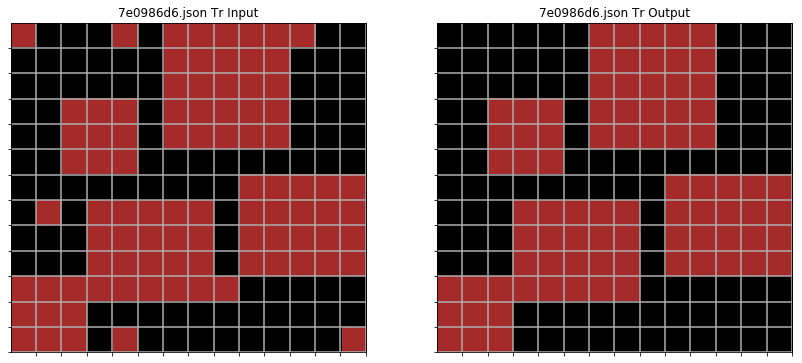

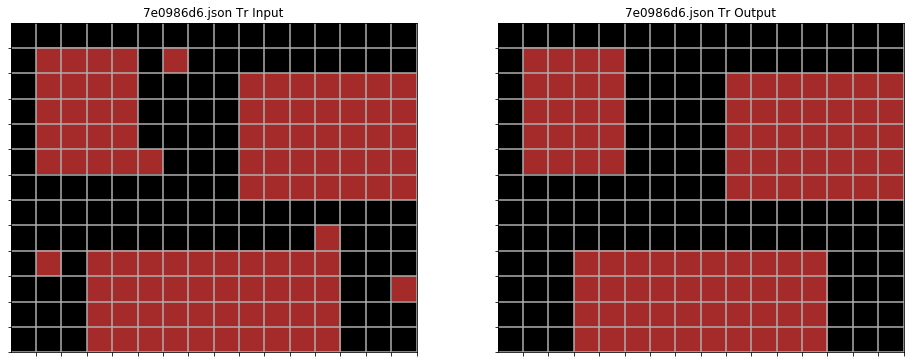

Expected Output


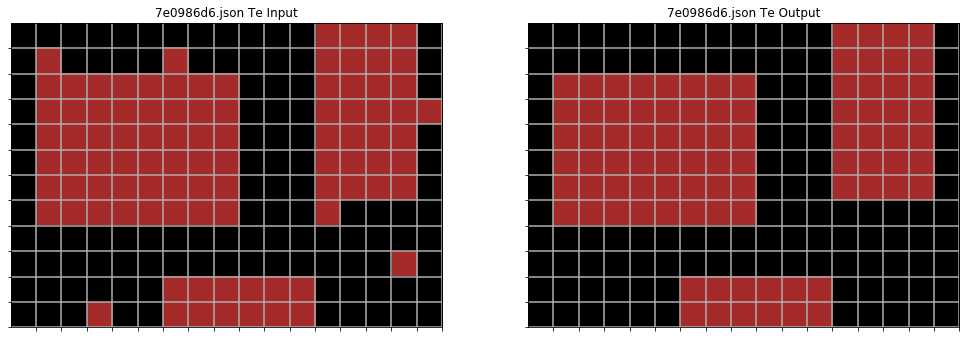

Actual Output


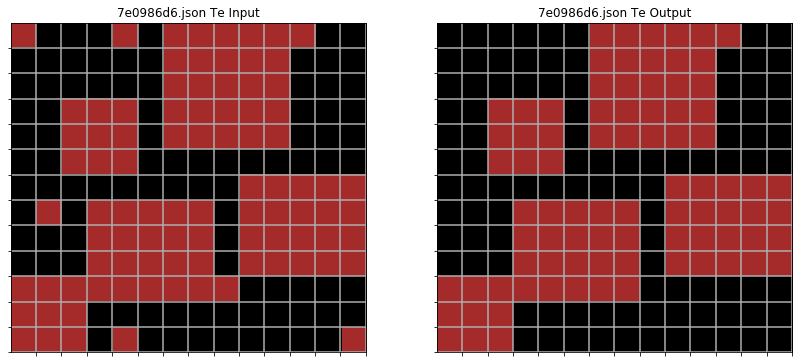

NN not able to solve the task
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 9., 0., 9., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 9., 0., 0., 0., 0., 9., 9., 9., 9., 9., 9., 9.],
          [0., 9., 9., 9., 9., 0., 0., 0., 0., 9., 9., 9., 9., 9., 9., 9.],
          [0., 9., 9., 9., 9., 0., 0., 0., 0., 9., 9., 9., 9., 9., 9., 9.],
          [0., 9., 9., 9., 9., 9., 0., 0., 0., 9., 9., 9., 9., 9., 9., 9.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 9., 9., 9., 9., 9., 9., 9.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 9., 0., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 0., 0., 0.],
          [0., 0., 0., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 0., 0., 9.],
          [0., 0., 0., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 0., 0., 0.],
          [0., 0., 0., 9., 9., 9., 9., 9., 

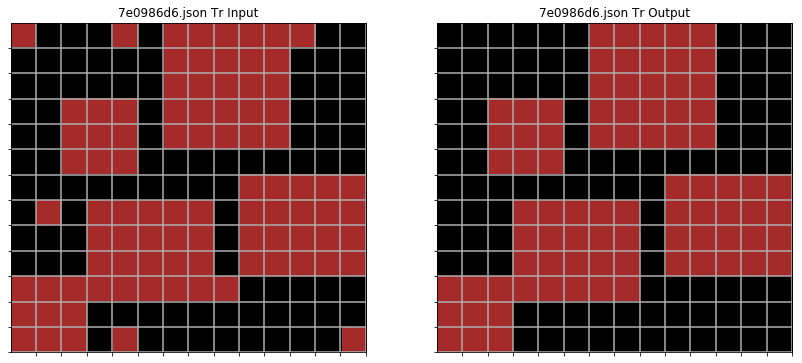

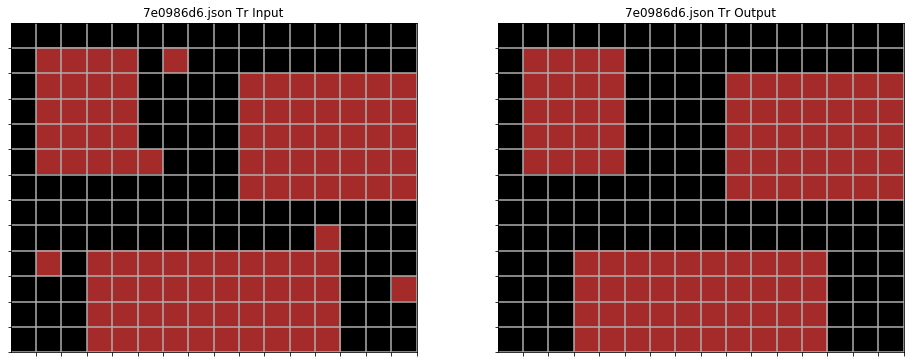

Expected Output


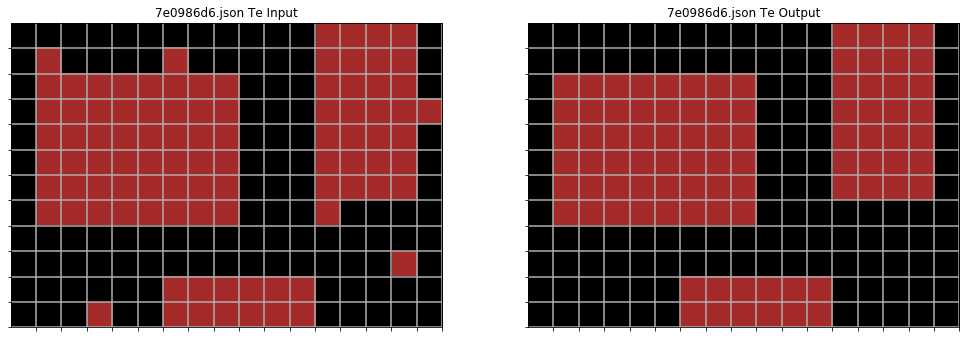

Actual Output


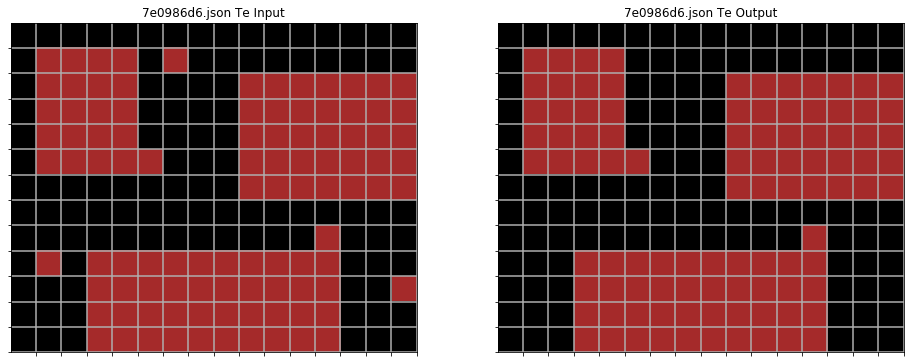

NN not able to solve the task
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 9., 9., 9., 9., 0.],
          [0., 9., 0., 0., 0., 0., 9., 0., 0., 0., 0., 0., 9., 9., 9., 9., 0.],
          [0., 9., 9., 9., 9., 9., 9., 9., 9., 0., 0., 0., 9., 9., 9., 9., 0.],
          [0., 9., 9., 9., 9., 9., 9., 9., 9., 0., 0., 0., 9., 9., 9., 9., 9.],
          [0., 9., 9., 9., 9., 9., 9., 9., 9., 0., 0., 0., 9., 9., 9., 9., 0.],
          [0., 9., 9., 9., 9., 9., 9., 9., 9., 0., 0., 0., 9., 9., 9., 9., 0.],
          [0., 9., 9., 9., 9., 9., 9., 9., 9., 0., 0., 0., 9., 9., 9., 9., 0.],
          [0., 9., 9., 9., 9., 9., 9., 9., 9., 0., 0., 0., 9., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 9., 0.],
          [0., 0., 0., 0., 0., 0., 9., 9., 9., 9., 9., 9., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 0., 0., 9., 9., 9., 9., 9., 9., 0., 0., 0., 0., 

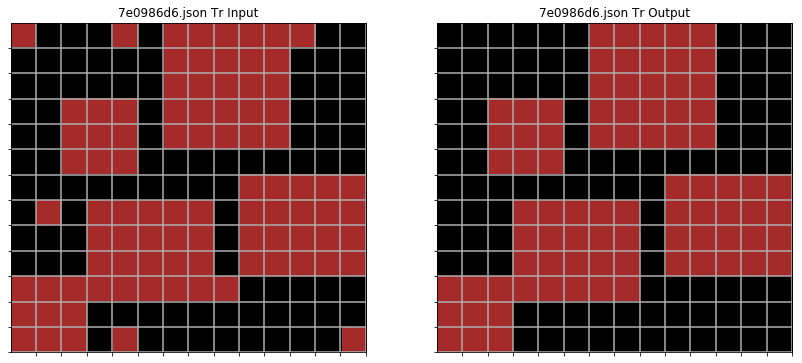

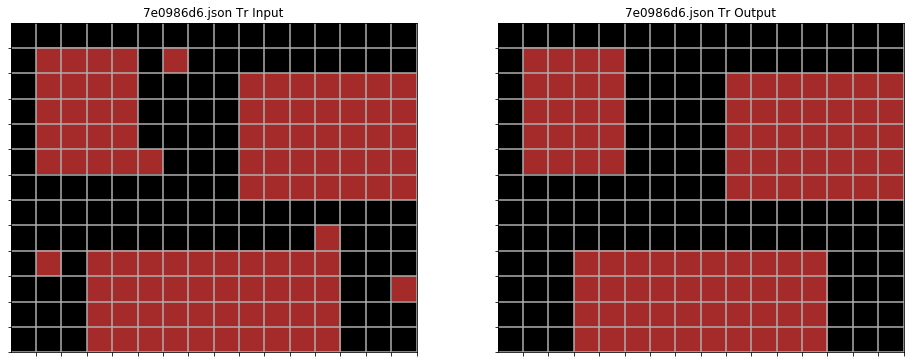

Expected Output


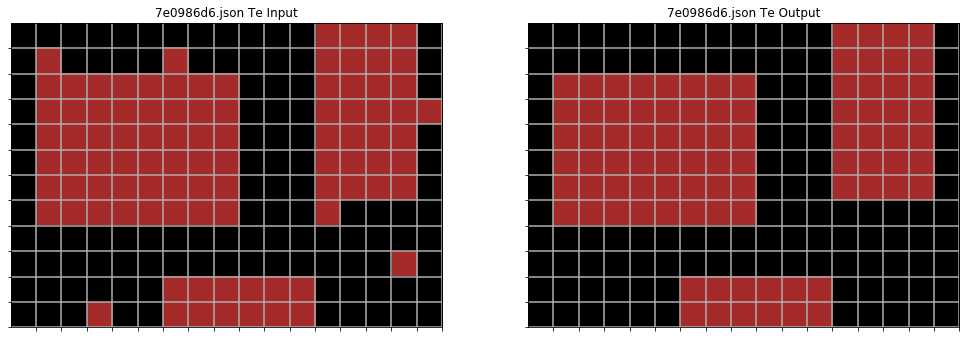

Actual Output


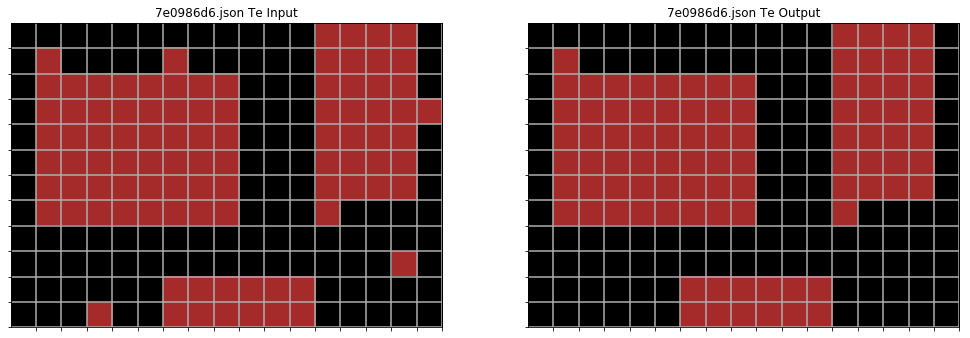

NN not able to solve the task


In [188]:
i = 46
ttm = TrainTestModel(ON=9, OFF=0, B = None, kernel_size=3,pad=1, reduction='none', loss_function_type='mse')
ttm.readData(onlyfiles_train[i], noAug=True)
ttm.train(epochs=1000, print_every=1, learning_rate=0.01, test_every=None)
ttm.test()
#Loss function: mse loss (bcz it penalizes the wrong cell more)
#Status: Not solved by I think this can be solved or may be the pattern it wants is not in the input

Augmentation is OFF.
epoch: 1, batch_id: 0, loss: 1.0542405843734741
[TRAIN] 9 elements matched out of 10 diff. elements.        Accuracy: 90.0. Overall Accuracy: 75.0
epoch: 1, batch_id: 1, loss: 0.49029481410980225
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 80.0
epoch: 2, batch_id: 0, loss: 0.3756259083747864
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 79.0
epoch: 2, batch_id: 1, loss: 0.31738609075546265
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 85.0
epoch: 3, batch_id: 0, loss: 0.2933275103569031
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 86.0
epoch: 3, batch_id: 1, loss: 0.24355041980743408
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 85.0
epoch: 4, batch_id: 0, loss: 0.24512338638305664
[TRAIN] 10 elements matched out of 

[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 38, batch_id: 0, loss: 0.07305636256933212
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 38, batch_id: 1, loss: 0.052422262728214264
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 39, batch_id: 0, loss: 0.07231786847114563
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 39, batch_id: 1, loss: 0.05172441527247429
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 40, batch_id: 0, loss: 0.071609728038311
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 40, batch_id: 1, loss: 0.051055580377578735
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accur

[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 76, batch_id: 0, loss: 0.05651378259062767
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 76, batch_id: 1, loss: 0.03728681057691574
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 77, batch_id: 0, loss: 0.05624844878911972
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 77, batch_id: 1, loss: 0.03706030920147896
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 78, batch_id: 0, loss: 0.05598773807287216
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 78, batch_id: 1, loss: 0.036838505417108536
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accu

[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 117, batch_id: 1, loss: 0.030657591298222542
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 118, batch_id: 0, loss: 0.048163171857595444
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 118, batch_id: 1, loss: 0.030542196705937386
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 119, batch_id: 0, loss: 0.04801290109753609
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 119, batch_id: 1, loss: 0.030428271740674973
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 120, batch_id: 0, loss: 0.04786420986056328
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Ove

[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 158, batch_id: 1, loss: 0.026863250881433487
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 159, batch_id: 0, loss: 0.043027378618717194
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 159, batch_id: 1, loss: 0.02678908407688141
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 160, batch_id: 0, loss: 0.04292292892932892
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 160, batch_id: 1, loss: 0.026715585961937904
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 161, batch_id: 0, loss: 0.04281925782561302
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Over

[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 196, batch_id: 1, loss: 0.024435309693217278
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 197, batch_id: 0, loss: 0.03952885791659355
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 197, batch_id: 1, loss: 0.024380404502153397
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 198, batch_id: 0, loss: 0.03944789990782738
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 198, batch_id: 1, loss: 0.024325881153345108
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 199, batch_id: 0, loss: 0.039367418736219406
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Ove

epoch: 236, batch_id: 0, loss: 0.036685872822999954
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 236, batch_id: 1, loss: 0.022493921220302582
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 237, batch_id: 0, loss: 0.03662039712071419
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 237, batch_id: 1, loss: 0.022451119497418404
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 238, batch_id: 0, loss: 0.03655526787042618
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 238, batch_id: 1, loss: 0.022408556193113327
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 239, batch_id: 0, loss: 0.036490436643362045
[TRAIN] 10 elements matched o

epoch: 273, batch_id: 1, loss: 0.021051868796348572
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 274, batch_id: 0, loss: 0.03440340980887413
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 274, batch_id: 1, loss: 0.021016478538513184
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 275, batch_id: 0, loss: 0.03434845805168152
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 98.0
epoch: 275, batch_id: 1, loss: 0.020981259644031525
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 276, batch_id: 0, loss: 0.03429373353719711
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 99.0
epoch: 276, batch_id: 1, loss: 0.020946204662322998
[TRAIN] 10 elements matched ou

epoch: 313, batch_id: 1, loss: 0.019753700122237206
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 314, batch_id: 0, loss: 0.032371699810028076
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 99.0
epoch: 314, batch_id: 1, loss: 0.019724015146493912
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 315, batch_id: 0, loss: 0.032324884086847305
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 99.0
epoch: 315, batch_id: 1, loss: 0.01969444751739502
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 316, batch_id: 0, loss: 0.03227822855114937
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 99.0
epoch: 316, batch_id: 1, loss: 0.019665002822875977
[TRAIN] 10 elements matched o

[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 350, batch_id: 1, loss: 0.01872921548783779
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 351, batch_id: 0, loss: 0.0307473037391901
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 351, batch_id: 1, loss: 0.018703464418649673
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 352, batch_id: 0, loss: 0.030706249177455902
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 352, batch_id: 1, loss: 0.018677806481719017
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 353, batch_id: 0, loss: 0.03066534548997879
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Ov

epoch: 390, batch_id: 1, loss: 0.017766067758202553
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 391, batch_id: 0, loss: 0.029205400496721268
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 391, batch_id: 1, loss: 0.017743613570928574
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 392, batch_id: 0, loss: 0.029169302433729172
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 392, batch_id: 1, loss: 0.017721228301525116
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 393, batch_id: 0, loss: 0.029133303090929985
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 393, batch_id: 1, loss: 0.01769891381263733
[TRAIN] 10 elements match

epoch: 429, batch_id: 1, loss: 0.016940489411354065
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 430, batch_id: 0, loss: 0.0278736874461174
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 430, batch_id: 1, loss: 0.016920585185289383
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 431, batch_id: 0, loss: 0.027841471135616302
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 431, batch_id: 1, loss: 0.016900738701224327
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 432, batch_id: 0, loss: 0.027809346094727516
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 432, batch_id: 1, loss: 0.016880948096513748
[TRAIN] 10 elements matche

epoch: 466, batch_id: 0, loss: 0.026767665520310402
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 466, batch_id: 1, loss: 0.01624070107936859
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 467, batch_id: 0, loss: 0.02673843316733837
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 467, batch_id: 1, loss: 0.016222773119807243
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 468, batch_id: 0, loss: 0.026709282770752907
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 468, batch_id: 1, loss: 0.016204893589019775
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 469, batch_id: 0, loss: 0.026680199429392815
[TRAIN] 10 elements matche

[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 502, batch_id: 1, loss: 0.015624399296939373
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 503, batch_id: 0, loss: 0.02573423646390438
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 503, batch_id: 1, loss: 0.015608084388077259
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 504, batch_id: 0, loss: 0.025707613676786423
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 504, batch_id: 1, loss: 0.015591820701956749
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 505, batch_id: 0, loss: 0.025681041181087494
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0.

epoch: 539, batch_id: 1, loss: 0.015047001652419567
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 540, batch_id: 0, loss: 0.02479005977511406
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 540, batch_id: 1, loss: 0.015032101422548294
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 541, batch_id: 0, loss: 0.024765659123659134
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 541, batch_id: 1, loss: 0.01501724123954773
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 542, batch_id: 0, loss: 0.024741314351558685
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 542, batch_id: 1, loss: 0.015002410858869553
[TRAIN] 10 elements matche

epoch: 579, batch_id: 0, loss: 0.02387779951095581
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 579, batch_id: 1, loss: 0.014477205462753773
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 580, batch_id: 0, loss: 0.023855429142713547
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 580, batch_id: 1, loss: 0.014463614672422409
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 581, batch_id: 0, loss: 0.023833097890019417
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 581, batch_id: 1, loss: 0.014450052753090858
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 582, batch_id: 0, loss: 0.02381081134080887
[TRAIN] 10 elements matche

epoch: 619, batch_id: 1, loss: 0.013955862261354923
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 620, batch_id: 0, loss: 0.022997967898845673
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 620, batch_id: 1, loss: 0.013943389989435673
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 621, batch_id: 0, loss: 0.022977430373430252
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 621, batch_id: 1, loss: 0.01393094565719366
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 622, batch_id: 0, loss: 0.022956933826208115
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 622, batch_id: 1, loss: 0.013918522745370865
[TRAIN] 10 elements match

epoch: 659, batch_id: 1, loss: 0.013476338237524033
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 660, batch_id: 0, loss: 0.022207530215382576
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 660, batch_id: 1, loss: 0.013464835472404957
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 661, batch_id: 0, loss: 0.02218855544924736
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 661, batch_id: 1, loss: 0.013453355059027672
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 662, batch_id: 0, loss: 0.02216961421072483
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 662, batch_id: 1, loss: 0.013441897928714752
[TRAIN] 10 elements matche

epoch: 699, batch_id: 1, loss: 0.013033220544457436
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 700, batch_id: 0, loss: 0.021475767716765404
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 700, batch_id: 1, loss: 0.01302256714552641
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 701, batch_id: 0, loss: 0.021458160132169724
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 701, batch_id: 1, loss: 0.013011936098337173
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 702, batch_id: 0, loss: 0.021440593525767326
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 702, batch_id: 1, loss: 0.01300132367759943
[TRAIN] 10 elements matche

[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 739, batch_id: 0, loss: 0.020812148228287697
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 739, batch_id: 1, loss: 0.012622085399925709
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 740, batch_id: 0, loss: 0.020795734599232674
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 740, batch_id: 1, loss: 0.012612182646989822
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 741, batch_id: 0, loss: 0.02077934518456459
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 741, batch_id: 1, loss: 0.012602302245795727
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0.

[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 779, batch_id: 1, loss: 0.012239241972565651
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 780, batch_id: 0, loss: 0.020161639899015427
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 780, batch_id: 1, loss: 0.012230009771883488
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 781, batch_id: 0, loss: 0.020146332681179047
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 781, batch_id: 1, loss: 0.01222078688442707
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 782, batch_id: 0, loss: 0.020131051540374756
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0.

epoch: 819, batch_id: 1, loss: 0.011881593614816666
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 820, batch_id: 0, loss: 0.019568586722016335
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 820, batch_id: 1, loss: 0.01187295001000166
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 821, batch_id: 0, loss: 0.019554248079657555
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 821, batch_id: 1, loss: 0.011864322237670422
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 822, batch_id: 0, loss: 0.019539935514330864
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 822, batch_id: 1, loss: 0.011855709366500378
[TRAIN] 10 elements match

[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 858, batch_id: 1, loss: 0.011554611846804619
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 859, batch_id: 0, loss: 0.019025864079594612
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 859, batch_id: 1, loss: 0.011546487919986248
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 860, batch_id: 0, loss: 0.019012372940778732
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 860, batch_id: 1, loss: 0.011538381688296795
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 861, batch_id: 0, loss: 0.018998906016349792
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0

epoch: 898, batch_id: 0, loss: 0.018514830619096756
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 898, batch_id: 1, loss: 0.01123932097107172
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 899, batch_id: 0, loss: 0.018502110615372658
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 899, batch_id: 1, loss: 0.011231679469347
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 900, batch_id: 0, loss: 0.01848941668868065
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 900, batch_id: 1, loss: 0.011224053800106049
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 901, batch_id: 0, loss: 0.018476739525794983
[TRAIN] 10 elements matched o

epoch: 937, batch_id: 1, loss: 0.010949638672173023
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 938, batch_id: 0, loss: 0.018020547926425934
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 938, batch_id: 1, loss: 0.010942425578832626
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 939, batch_id: 0, loss: 0.018008554354310036
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 939, batch_id: 1, loss: 0.010935230180621147
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 940, batch_id: 0, loss: 0.01799657754600048
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 940, batch_id: 1, loss: 0.010928039439022541
[TRAIN] 10 elements match

epoch: 978, batch_id: 0, loss: 0.01755380630493164
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 978, batch_id: 1, loss: 0.010662243701517582
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 979, batch_id: 0, loss: 0.01754247210919857
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 979, batch_id: 1, loss: 0.010655438527464867
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 980, batch_id: 0, loss: 0.017531149089336395
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 980, batch_id: 1, loss: 0.010648645460605621
[TRAIN] 10 elements matched out of 10 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 981, batch_id: 0, loss: 0.017519846558570862
[TRAIN] 10 elements matche

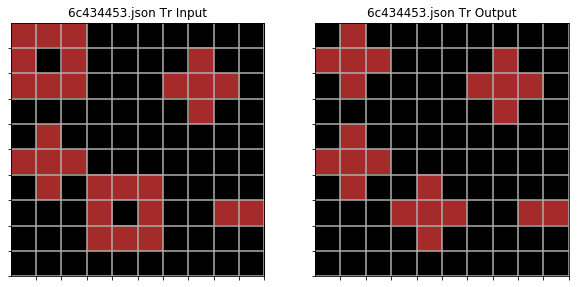

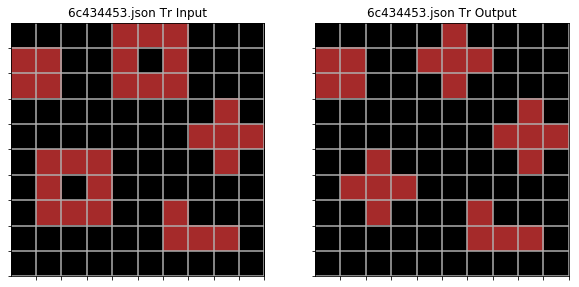

Expected Output


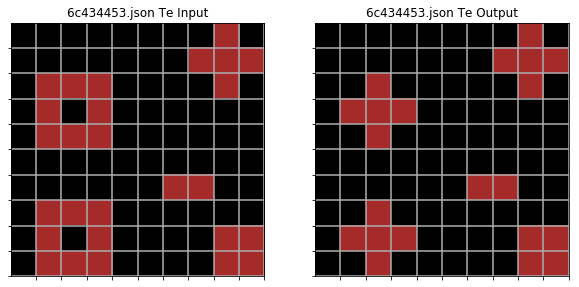

Actual Output


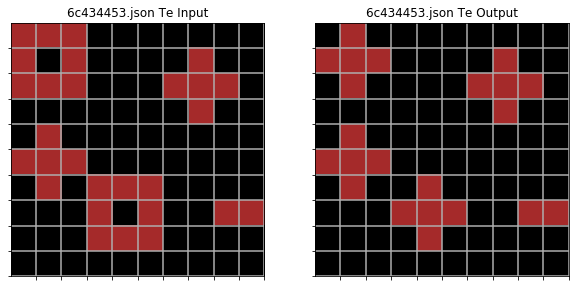

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 9., 9., 9., 0., 0., 0.],
          [9., 9., 0., 0., 9., 0., 9., 0., 0., 0.],
          [9., 9., 0., 0., 9., 9., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 9., 9.],
          [0., 9., 9., 9., 0., 0., 0., 0., 9., 0.],
          [0., 9., 0., 9., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 9., 9., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 9., 0., 0., 0., 0.],
          [9., 9., 0., 0., 9., 9., 9., 0., 0., 0.],
          [9., 9., 0., 0., 0., 9., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 9., 9.],
          [0., 0., 9., 0., 0., 0., 0., 0., 9., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 0., 0., 0., 9., 0., 0., 0.],
     

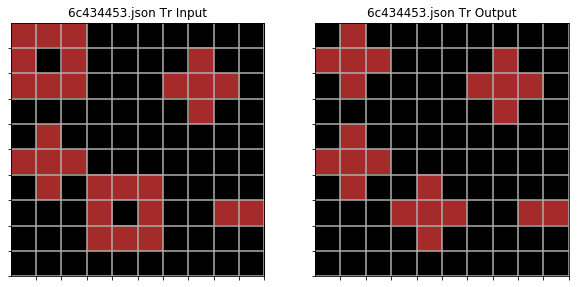

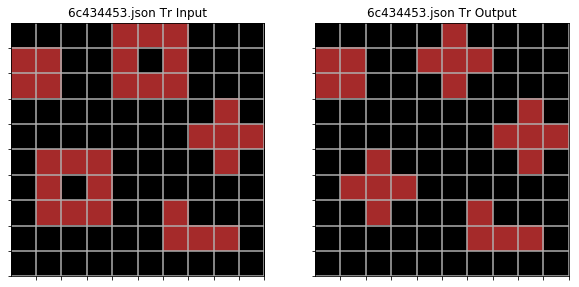

Expected Output


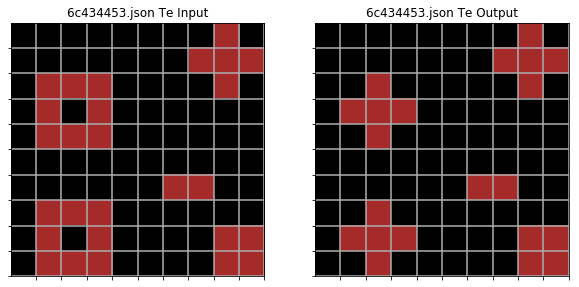

Actual Output


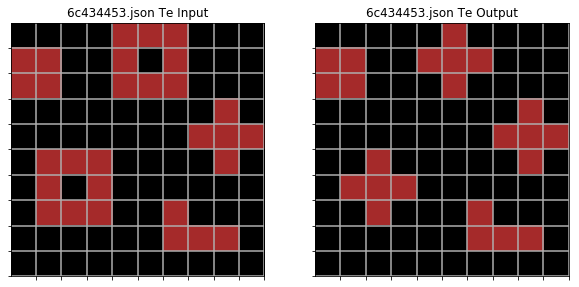

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 9., 9.],
          [0., 9., 9., 9., 0., 0., 0., 0., 9., 0.],
          [0., 9., 0., 9., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 9., 9., 0., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0.],
          [0., 9., 0., 9., 0., 0., 0., 0., 9., 9.],
          [0., 9., 9., 9., 0., 0., 0., 0., 9., 9.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 9., 9.],
          [0., 0., 9., 0., 0., 0., 0., 0., 9., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 9., 9., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 0., 0., 0.],
     

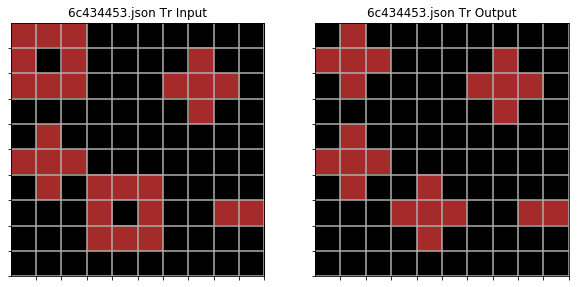

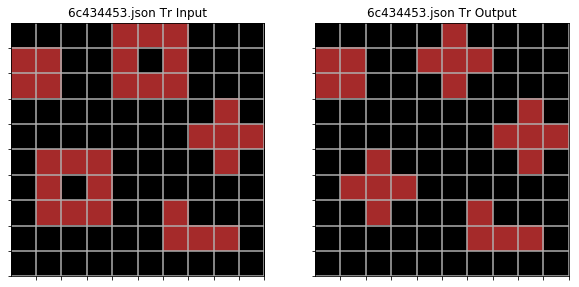

Expected Output


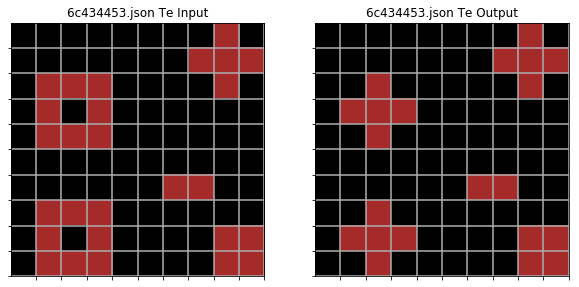

Actual Output


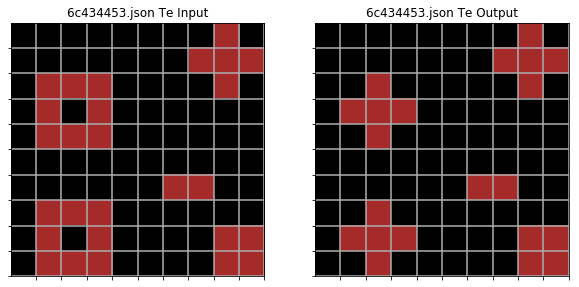

Task successfully solved.


In [173]:
i = 40
ttm = TrainTestModel(ON=9, OFF=0, B = None, kernel_size=5,pad=2, reduction='none', loss_function_type='mse')
ttm.readData(onlyfiles_train[i], noAug=True)
ttm.train(epochs=1000, print_every=1, learning_rate=0.01, test_every=None)
ttm.test()
#Loss function: mse loss (bcz it penalizes the wrong cell more)
#Status: Solved bcz a pretty consistent logic

Augmentation is OFF.
epoch: 1, batch_id: 0, loss: 0.6026723384857178
[TRAIN] 2 elements matched out of 4 diff. elements.        Accuracy: 50.0. Overall Accuracy: 81.25
epoch: 1, batch_id: 1, loss: 0.6457837820053101
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 84.375
epoch: 1, batch_id: 2, loss: 0.6257479190826416
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 83.33333587646484
epoch: 2, batch_id: 0, loss: 0.5421954393386841
[TRAIN] 2 elements matched out of 4 diff. elements.        Accuracy: 50.0. Overall Accuracy: 81.25
epoch: 2, batch_id: 1, loss: 0.619011640548706
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 84.375
epoch: 2, batch_id: 2, loss: 0.5943357944488525
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 83.33333587646484
epoch: 3, batch_id: 0, loss: 0.49541038274765015
[TRAIN] 2 elements matc

epoch: 29, batch_id: 1, loss: 0.4429164528846741
[TRAIN] 2 elements matched out of 4 diff. elements.        Accuracy: 50.0. Overall Accuracy: 87.5
epoch: 29, batch_id: 2, loss: 0.425212025642395
[TRAIN] 2 elements matched out of 4 diff. elements.        Accuracy: 50.0. Overall Accuracy: 83.33333587646484
epoch: 30, batch_id: 0, loss: 0.28709837794303894
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 30, batch_id: 1, loss: 0.4415777623653412
[TRAIN] 2 elements matched out of 4 diff. elements.        Accuracy: 50.0. Overall Accuracy: 87.5
epoch: 30, batch_id: 2, loss: 0.4241953194141388
[TRAIN] 2 elements matched out of 4 diff. elements.        Accuracy: 50.0. Overall Accuracy: 83.33333587646484
epoch: 31, batch_id: 0, loss: 0.28537556529045105
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 31, batch_id: 1, loss: 0.44027426838874817
[TRAIN] 2 elements matched out of 4 d

epoch: 57, batch_id: 0, loss: 0.252839595079422
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 57, batch_id: 1, loss: 0.4127511978149414
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 85.9375
epoch: 57, batch_id: 2, loss: 0.40373513102531433
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 80.55555725097656
epoch: 58, batch_id: 0, loss: 0.2519005537033081
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 58, batch_id: 1, loss: 0.4118325710296631
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 85.9375
epoch: 58, batch_id: 2, loss: 0.4031054675579071
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 80.55555725097656
epoch: 59, batch_id: 0, loss: 0.2509770691394806
[TRAIN] 4 elements matched out of

epoch: 87, batch_id: 2, loss: 0.38631102442741394
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 80.55555725097656
epoch: 88, batch_id: 0, loss: 0.22924041748046875
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 88, batch_id: 1, loss: 0.3867654800415039
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 89.0625
epoch: 88, batch_id: 2, loss: 0.3857683837413788
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 80.55555725097656
epoch: 89, batch_id: 0, loss: 0.22862344980239868
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 89, batch_id: 1, loss: 0.3859972655773163
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 89.0625
epoch: 89, batch_id: 2, loss: 0.3852277398109436
[TRAIN] 1 elements matched out

[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 89.0625
epoch: 116, batch_id: 2, loss: 0.3712557256221771
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 80.55555725097656
epoch: 117, batch_id: 0, loss: 0.21371129155158997
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 117, batch_id: 1, loss: 0.36583495140075684
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 89.0625
epoch: 117, batch_id: 2, loss: 0.37075918912887573
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 80.55555725097656
epoch: 118, batch_id: 0, loss: 0.21324923634529114
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 118, batch_id: 1, loss: 0.3651586174964905
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.

epoch: 145, batch_id: 2, loss: 0.3573871850967407
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 80.55555725097656
epoch: 146, batch_id: 0, loss: 0.20176522433757782
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 146, batch_id: 1, loss: 0.34726205468177795
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 89.0625
epoch: 146, batch_id: 2, loss: 0.356927752494812
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 80.55555725097656
epoch: 147, batch_id: 0, loss: 0.20139998197555542
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 147, batch_id: 1, loss: 0.3466578423976898
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 89.0625
epoch: 147, batch_id: 2, loss: 0.35646936297416687
[TRAIN] 1 elements matc

[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 174, batch_id: 1, loss: 0.33114850521087646
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 89.0625
epoch: 174, batch_id: 2, loss: 0.3445284366607666
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 80.55555725097656
epoch: 175, batch_id: 0, loss: 0.19214779138565063
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 175, batch_id: 1, loss: 0.33060264587402344
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 89.0625
epoch: 175, batch_id: 2, loss: 0.34410181641578674
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 80.55555725097656
epoch: 176, batch_id: 0, loss: 0.19184806942939758
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 10

epoch: 202, batch_id: 2, loss: 0.33298060297966003
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 80.55555725097656
epoch: 203, batch_id: 0, loss: 0.18440109491348267
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 203, batch_id: 1, loss: 0.31605684757232666
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 89.0625
epoch: 203, batch_id: 2, loss: 0.33258306980133057
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 80.55555725097656
epoch: 204, batch_id: 0, loss: 0.18414680659770966
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 204, batch_id: 1, loss: 0.3155626952648163
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 89.0625
epoch: 204, batch_id: 2, loss: 0.33218657970428467
[TRAIN] 1 elements m

[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 231, batch_id: 1, loss: 0.3028219938278198
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 89.0625
epoch: 231, batch_id: 2, loss: 0.321846604347229
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 80.55555725097656
epoch: 232, batch_id: 0, loss: 0.1775408685207367
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 232, batch_id: 1, loss: 0.3023713231086731
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 89.0625
epoch: 232, batch_id: 2, loss: 0.32147684693336487
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 80.55555725097656
epoch: 233, batch_id: 0, loss: 0.17732159793376923
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0.

epoch: 259, batch_id: 2, loss: 0.31183233857154846
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 80.55555725097656
epoch: 260, batch_id: 0, loss: 0.17176882922649384
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 260, batch_id: 1, loss: 0.2903240919113159
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 89.0625
epoch: 260, batch_id: 2, loss: 0.31148743629455566
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 80.55555725097656
epoch: 261, batch_id: 0, loss: 0.17157568037509918
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 261, batch_id: 1, loss: 0.28991323709487915
[TRAIN] 1 elements matched out of 4 diff. elements.        Accuracy: 25.0. Overall Accuracy: 89.0625
epoch: 261, batch_id: 2, loss: 0.31114327907562256
[TRAIN] 1 elements m

[TRAIN] 2 elements matched out of 4 diff. elements.        Accuracy: 50.0. Overall Accuracy: 90.625
epoch: 286, batch_id: 2, loss: 0.3028067350387573
[TRAIN] 2 elements matched out of 4 diff. elements.        Accuracy: 50.0. Overall Accuracy: 83.33333587646484
epoch: 287, batch_id: 0, loss: 0.16682256758213043
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 287, batch_id: 1, loss: 0.27966418862342834
[TRAIN] 2 elements matched out of 4 diff. elements.        Accuracy: 50.0. Overall Accuracy: 90.625
epoch: 287, batch_id: 2, loss: 0.3024836778640747
[TRAIN] 2 elements matched out of 4 diff. elements.        Accuracy: 50.0. Overall Accuracy: 83.33333587646484
epoch: 288, batch_id: 0, loss: 0.16664938628673553
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 288, batch_id: 1, loss: 0.27928605675697327
[TRAIN] 2 elements matched out of 4 diff. elements.        Accuracy: 50.0.

epoch: 313, batch_id: 2, loss: 0.2943512797355652
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 86.11111450195312
epoch: 314, batch_id: 0, loss: 0.16236570477485657
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 314, batch_id: 1, loss: 0.26983922719955444
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 92.1875
epoch: 314, batch_id: 2, loss: 0.2940484285354614
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 86.11111450195312
epoch: 315, batch_id: 0, loss: 0.16220881044864655
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 315, batch_id: 1, loss: 0.26949015259742737
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 92.1875
epoch: 315, batch_id: 2, loss: 0.2937465012073517
[TRAIN] 3 elements mat

[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 88.88888549804688
epoch: 342, batch_id: 0, loss: 0.15816760063171387
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 342, batch_id: 1, loss: 0.2604365646839142
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.75
epoch: 342, batch_id: 2, loss: 0.28585290908813477
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 88.88888549804688
epoch: 343, batch_id: 0, loss: 0.15802469849586487
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 343, batch_id: 1, loss: 0.260114461183548
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.75
epoch: 343, batch_id: 2, loss: 0.28557002544403076
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Ov

[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 370, batch_id: 1, loss: 0.25174838304519653
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 95.3125
epoch: 370, batch_id: 2, loss: 0.2781730890274048
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 371, batch_id: 0, loss: 0.15419727563858032
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 371, batch_id: 1, loss: 0.2514503300189972
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 95.3125
epoch: 371, batch_id: 2, loss: 0.27790769934654236
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 372, batch_id: 0, loss: 0.15406639873981476
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100

[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 95.3125
epoch: 392, batch_id: 2, loss: 0.2724720537662506
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 393, batch_id: 0, loss: 0.15140306949615479
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 393, batch_id: 1, loss: 0.24509257078170776
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 95.3125
epoch: 393, batch_id: 2, loss: 0.2722194790840149
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 394, batch_id: 0, loss: 0.15128009021282196
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 394, batch_id: 1, loss: 0.24481241405010223
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.

epoch: 431, batch_id: 0, loss: 0.14695101976394653
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 431, batch_id: 1, loss: 0.23494262993335724
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 95.3125
epoch: 431, batch_id: 2, loss: 0.263021856546402
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 432, batch_id: 0, loss: 0.14683961868286133
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 432, batch_id: 1, loss: 0.23468859493732452
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 95.3125
epoch: 432, batch_id: 2, loss: 0.26278984546661377
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 433, batch_id: 0, loss: 0.14672845602035522
[TRAIN] 4 elements ma

epoch: 459, batch_id: 1, loss: 0.22806662321090698
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 95.3125
epoch: 459, batch_id: 2, loss: 0.25670871138572693
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 460, batch_id: 0, loss: 0.14382655918598175
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 460, batch_id: 1, loss: 0.22782966494560242
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 95.3125
epoch: 460, batch_id: 2, loss: 0.256490021944046
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 461, batch_id: 0, loss: 0.14372259378433228
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 461, batch_id: 1, loss: 0.22759339213371277
[TRAIN] 3 elements ma

[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 486, batch_id: 0, loss: 0.1411980539560318
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 486, batch_id: 1, loss: 0.2218678742647171
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 95.3125
epoch: 486, batch_id: 2, loss: 0.2509596347808838
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 487, batch_id: 0, loss: 0.1410999596118927
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 487, batch_id: 1, loss: 0.2216457575559616
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 95.3125
epoch: 487, batch_id: 2, loss: 0.2507527768611908
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. O

epoch: 523, batch_id: 2, loss: 0.24357277154922485
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 524, batch_id: 0, loss: 0.13761213421821594
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 524, batch_id: 1, loss: 0.21378609538078308
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 95.3125
epoch: 524, batch_id: 2, loss: 0.24338051676750183
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 525, batch_id: 0, loss: 0.13752150535583496
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 525, batch_id: 1, loss: 0.21358279883861542
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 95.3125
epoch: 525, batch_id: 2, loss: 0.24318858981132507
[TRAIN] 3 elements 

epoch: 549, batch_id: 1, loss: 0.20883798599243164
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 95.3125
epoch: 549, batch_id: 2, loss: 0.23869255185127258
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 550, batch_id: 0, loss: 0.13531282544136047
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 550, batch_id: 1, loss: 0.20864568650722504
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 95.3125
epoch: 550, batch_id: 2, loss: 0.23850968480110168
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 551, batch_id: 0, loss: 0.13522671163082123
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 551, batch_id: 1, loss: 0.20845377445220947
[TRAIN] 3 elements 

[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 578, batch_id: 0, loss: 0.13296085596084595
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 578, batch_id: 1, loss: 0.2034282088279724
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 95.3125
epoch: 578, batch_id: 2, loss: 0.23352527618408203
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 579, batch_id: 0, loss: 0.1328790932893753
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 579, batch_id: 1, loss: 0.20324759185314178
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 95.3125
epoch: 579, batch_id: 2, loss: 0.23335202038288116
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.

epoch: 601, batch_id: 2, loss: 0.22961896657943726
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 602, batch_id: 0, loss: 0.13103802502155304
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 602, batch_id: 1, loss: 0.19919723272323608
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 602, batch_id: 2, loss: 0.22945281863212585
[TRAIN] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overall Accuracy: 91.66666412353516
epoch: 603, batch_id: 0, loss: 0.1309596449136734
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 603, batch_id: 1, loss: 0.19902554154396057
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 603, batch_id: 2, loss: 0.22928696870803833
[TRAIN] 4 elements m

[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 630, batch_id: 2, loss: 0.22491757571697235
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 631, batch_id: 0, loss: 0.12881886959075928
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 631, batch_id: 1, loss: 0.194356769323349
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 631, batch_id: 2, loss: 0.22475974261760712
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 632, batch_id: 0, loss: 0.1287442445755005
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 632, batch_id: 1, loss: 0.1941949427127838
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100

[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 658, batch_id: 1, loss: 0.1900964379310608
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 658, batch_id: 2, loss: 0.22059838473796844
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 659, batch_id: 0, loss: 0.12677527964115143
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 659, batch_id: 1, loss: 0.18994292616844177
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 659, batch_id: 2, loss: 0.22044792771339417
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 660, batch_id: 0, loss: 0.12670397758483887
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 

epoch: 687, batch_id: 0, loss: 0.12482067942619324
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 687, batch_id: 1, loss: 0.18576274812221527
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 687, batch_id: 2, loss: 0.2163357138633728
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 688, batch_id: 0, loss: 0.12475240975618362
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 688, batch_id: 1, loss: 0.18561744689941406
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 688, batch_id: 2, loss: 0.21619240939617157
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 689, batch_id: 0, loss: 0.12468424439430237
[TRAIN] 4 elements

[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 714, batch_id: 0, loss: 0.12301335483789444
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 714, batch_id: 1, loss: 0.18193547427654266
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 714, batch_id: 2, loss: 0.2125457376241684
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 715, batch_id: 0, loss: 0.1229478120803833
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 715, batch_id: 1, loss: 0.18179744482040405
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 715, batch_id: 2, loss: 0.21240849792957306
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 1

[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 742, batch_id: 1, loss: 0.1781613528728485
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 742, batch_id: 2, loss: 0.2087845802307129
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 743, batch_id: 0, loss: 0.12115032225847244
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 743, batch_id: 1, loss: 0.1780301332473755
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 743, batch_id: 2, loss: 0.2086533010005951
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 744, batch_id: 0, loss: 0.1210874393582344
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.

epoch: 770, batch_id: 2, loss: 0.20518390834331512
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 771, batch_id: 0, loss: 0.11942260712385178
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 771, batch_id: 1, loss: 0.17444558441638947
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 771, batch_id: 2, loss: 0.20505814254283905
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 772, batch_id: 0, loss: 0.11936213821172714
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 772, batch_id: 1, loss: 0.1743207424879074
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 772, batch_id: 2, loss: 0.20493252575397491
[TRAIN] 4 elements

epoch: 797, batch_id: 2, loss: 0.20185354351997375
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 798, batch_id: 0, loss: 0.11781801283359528
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 798, batch_id: 1, loss: 0.17114947736263275
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 798, batch_id: 2, loss: 0.20173273980617523
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 799, batch_id: 0, loss: 0.11775971949100494
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 799, batch_id: 1, loss: 0.17103031277656555
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 799, batch_id: 2, loss: 0.20161208510398865
[TRAIN] 4 element

[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 826, batch_id: 0, loss: 0.11621339619159698
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 826, batch_id: 1, loss: 0.1678856611251831
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 826, batch_id: 2, loss: 0.19842129945755005
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 827, batch_id: 0, loss: 0.1161571592092514
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 827, batch_id: 1, loss: 0.16777198016643524
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 827, batch_id: 2, loss: 0.19830547273159027
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 1

[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 849, batch_id: 1, loss: 0.16531431674957275
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 849, batch_id: 2, loss: 0.1957990676164627
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 850, batch_id: 0, loss: 0.11488303542137146
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 850, batch_id: 1, loss: 0.16520459949970245
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 96.875
epoch: 850, batch_id: 2, loss: 0.19568702578544617
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 94.44444274902344
epoch: 851, batch_id: 0, loss: 0.11482846736907959
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 

[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 877, batch_id: 2, loss: 0.19271917641162872
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 878, batch_id: 0, loss: 0.11338035762310028
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 878, batch_id: 1, loss: 0.16220374405384064
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 878, batch_id: 2, loss: 0.19261136651039124
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 879, batch_id: 0, loss: 0.11332766711711884
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 879, batch_id: 1, loss: 0.1620989590883255
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 1

[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 906, batch_id: 2, loss: 0.18965135514736176
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 907, batch_id: 0, loss: 0.11187674850225449
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 907, batch_id: 1, loss: 0.15923051536083221
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 907, batch_id: 2, loss: 0.18954776227474213
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 908, batch_id: 0, loss: 0.11182582378387451
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 908, batch_id: 1, loss: 0.15913031995296478
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 

[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 935, batch_id: 2, loss: 0.18670019507408142
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 936, batch_id: 0, loss: 0.11042344570159912
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 936, batch_id: 1, loss: 0.1563849002122879
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 936, batch_id: 2, loss: 0.1866004317998886
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 937, batch_id: 0, loss: 0.11037421971559525
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 937, batch_id: 1, loss: 0.15628893673419952
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 10

[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 956, batch_id: 1, loss: 0.15449218451976776
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 956, batch_id: 2, loss: 0.18463174998760223
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 957, batch_id: 0, loss: 0.10940075665712357
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 957, batch_id: 1, loss: 0.1543990671634674
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 957, batch_id: 2, loss: 0.18453466892242432
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 958, batch_id: 0, loss: 0.10935267806053162
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 1

epoch: 987, batch_id: 1, loss: 0.15166455507278442
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 987, batch_id: 2, loss: 0.18167784810066223
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 988, batch_id: 0, loss: 0.10793408006429672
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 988, batch_id: 1, loss: 0.1515752673149109
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 988, batch_id: 2, loss: 0.1815844178199768
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 989, batch_id: 0, loss: 0.10788761079311371
[TRAIN] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 989, batch_id: 1, loss: 0.15148629248142242
[TRAIN] 4 elements matched out of 4 diff. ele

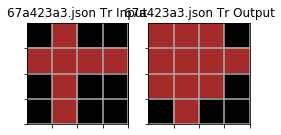

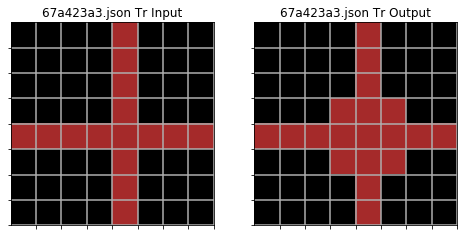

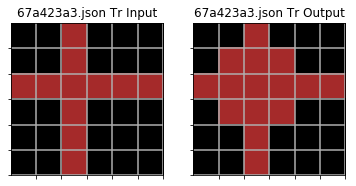

Expected Output


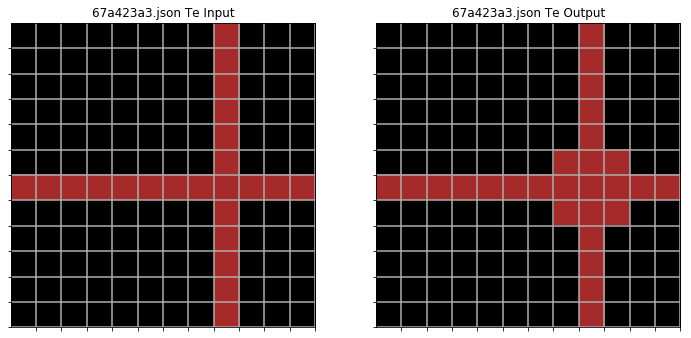

Actual Output


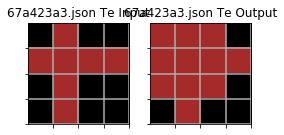

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 9., 0., 0., 0.],
          [9., 9., 9., 9., 9., 9., 9., 9.],
          [0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 9., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 9., 9., 9., 0., 0.],
          [9., 9., 9., 9., 9., 9., 9., 9.],
          [0., 0., 0., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 9., 0., 0., 0.]]]])
pred   op grid tensor([[[[0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 9., 9., 9., 0., 0.],
          [9., 9., 9., 9., 9., 9., 9., 9.],

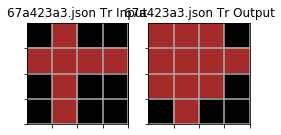

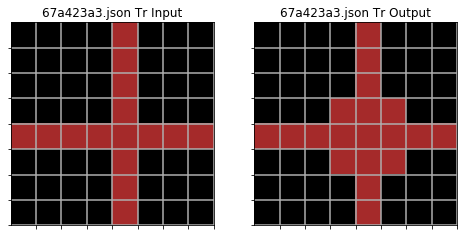

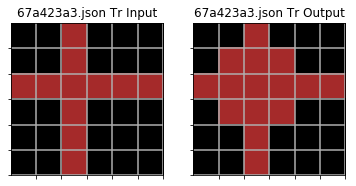

Expected Output


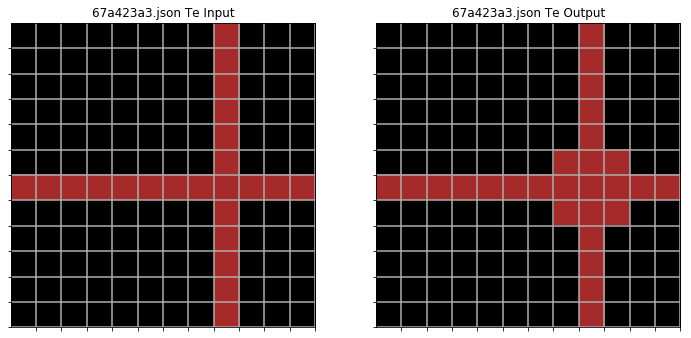

Actual Output


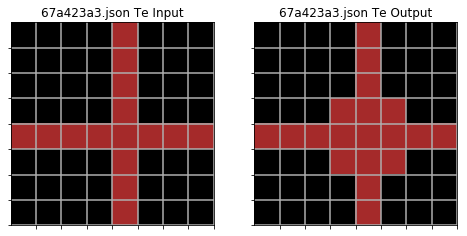

Task successfully solved.
actual ip grid tensor([[[[0., 0., 9., 0., 0., 0.],
          [0., 0., 9., 0., 0., 0.],
          [9., 9., 9., 9., 9., 9.],
          [0., 0., 9., 0., 0., 0.],
          [0., 0., 9., 0., 0., 0.],
          [0., 0., 9., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 9., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0.],
          [9., 9., 9., 9., 9., 9.],
          [0., 9., 9., 9., 0., 0.],
          [0., 0., 9., 0., 0., 0.],
          [0., 0., 9., 0., 0., 0.]]]])
pred   op grid tensor([[[[0., 0., 9., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0.],
          [9., 9., 9., 9., 9., 9.],
          [0., 9., 9., 9., 0., 0.],
          [0., 0., 9., 0., 0., 0.],
          [0., 0., 9., 0., 0., 0.]]]])
[TEST] 4 elements matched out of 4 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
Training Data


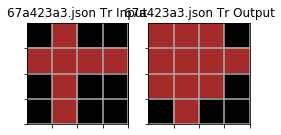

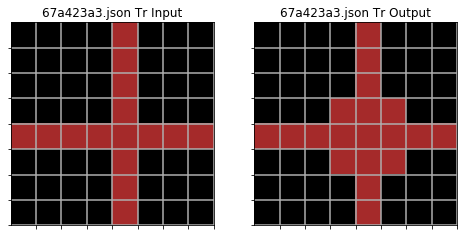

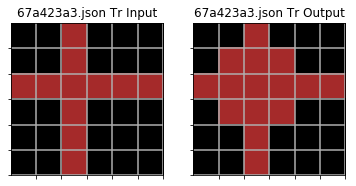

Expected Output


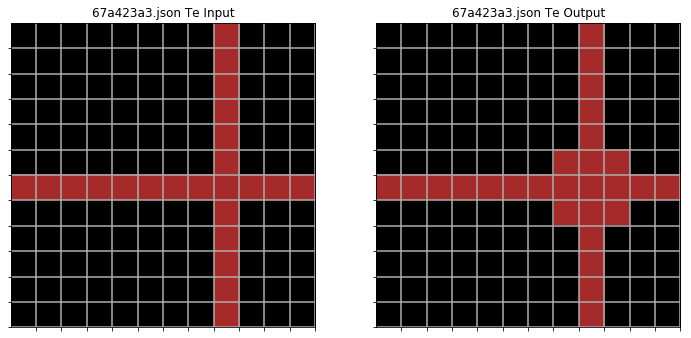

Actual Output


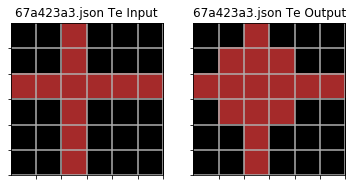

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.

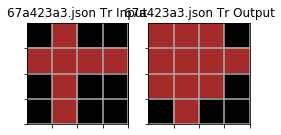

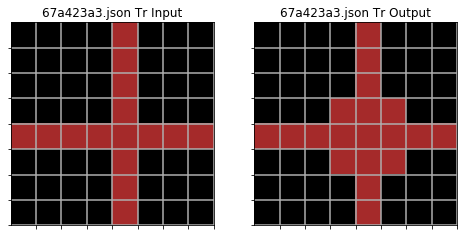

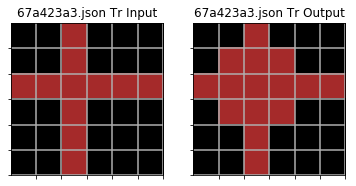

Expected Output


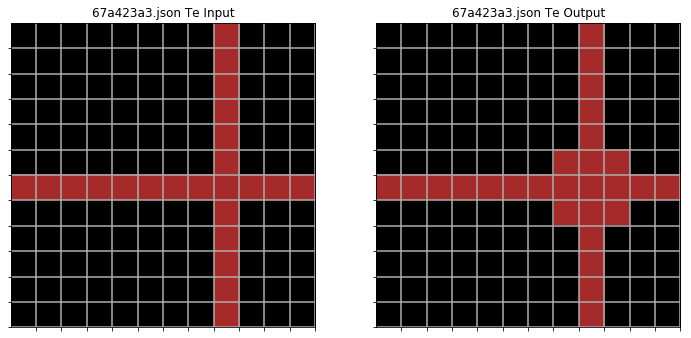

Actual Output


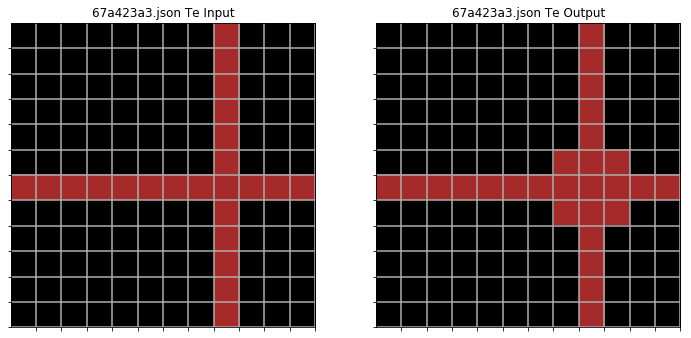

Task successfully solved.


In [168]:
i = 39
ttm = TrainTestModel(ON=9, OFF=0, B = None, kernel_size=3,pad=1, reduction='mean', loss_function_type='default')
ttm.readData(onlyfiles_train[i], noAug=True)
ttm.train(epochs=1000, print_every=1, learning_rate=0.01, test_every=None)
ttm.test()
#Loss function: default
#Status: Solved bcz a pretty consistent logic

Augmentation is OFF.
epoch: 1, batch_id: 0, loss: 0.8435109257698059
[TRAIN] 5 elements matched out of 6 diff. elements.        Accuracy: 83.33333587646484. Overall Accuracy: 71.60493469238281
epoch: 1, batch_id: 1, loss: 0.8026952743530273
[TRAIN] 4 elements matched out of 5 diff. elements.        Accuracy: 80.0. Overall Accuracy: 74.0740737915039
epoch: 2, batch_id: 0, loss: 0.8195359110832214
[TRAIN] 5 elements matched out of 6 diff. elements.        Accuracy: 83.33333587646484. Overall Accuracy: 71.60493469238281
epoch: 2, batch_id: 1, loss: 0.7784382104873657
[TRAIN] 4 elements matched out of 5 diff. elements.        Accuracy: 80.0. Overall Accuracy: 75.30863952636719
epoch: 3, batch_id: 0, loss: 0.7971202731132507
[TRAIN] 5 elements matched out of 6 diff. elements.        Accuracy: 83.33333587646484. Overall Accuracy: 71.60493469238281
epoch: 3, batch_id: 1, loss: 0.7561454176902771
[TRAIN] 4 elements matched out of 5 diff. elements.        Accuracy: 80.0. Overall Accuracy: 74.07

epoch: 42, batch_id: 1, loss: 0.46992847323417664
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 92.59259033203125
epoch: 43, batch_id: 0, loss: 0.4784891605377197
[TRAIN] 5 elements matched out of 6 diff. elements.        Accuracy: 83.33333587646484. Overall Accuracy: 92.59259033203125
epoch: 43, batch_id: 1, loss: 0.46752598881721497
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 92.59259033203125
epoch: 44, batch_id: 0, loss: 0.47589173913002014
[TRAIN] 5 elements matched out of 6 diff. elements.        Accuracy: 83.33333587646484. Overall Accuracy: 92.59259033203125
epoch: 44, batch_id: 1, loss: 0.4651806652545929
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 92.59259033203125
epoch: 45, batch_id: 0, loss: 0.47336092591285706
[TRAIN] 5 elements matched out of 6 diff. elements.        Accuracy: 83.33333587646484. Overall Accuracy: 92.592590332031

epoch: 81, batch_id: 0, loss: 0.40779241919517517
[TRAIN] 4 elements matched out of 6 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 91.35802459716797
epoch: 81, batch_id: 1, loss: 0.40145036578178406
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 92.59259033203125
epoch: 82, batch_id: 0, loss: 0.40639689564704895
[TRAIN] 4 elements matched out of 6 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 91.35802459716797
epoch: 82, batch_id: 1, loss: 0.4001089930534363
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 92.59259033203125
epoch: 83, batch_id: 0, loss: 0.4050162434577942
[TRAIN] 4 elements matched out of 6 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 91.35802459716797
epoch: 83, batch_id: 1, loss: 0.39878106117248535
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 92.592590332031

epoch: 126, batch_id: 1, loss: 0.35112348198890686
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 127, batch_id: 0, loss: 0.35492202639579773
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 127, batch_id: 1, loss: 0.3501861095428467
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 128, batch_id: 0, loss: 0.35396695137023926
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 128, batch_id: 1, loss: 0.3492546081542969
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 129, batch_id: 0, loss: 0.3530178666114807
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 129, batch_id: 1, loss: 

epoch: 172, batch_id: 0, loss: 0.31730782985687256
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 172, batch_id: 1, loss: 0.31347835063934326
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 173, batch_id: 0, loss: 0.3165784180164337
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 173, batch_id: 1, loss: 0.31276601552963257
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 174, batch_id: 0, loss: 0.3158525824546814
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 174, batch_id: 1, loss: 0.31205758452415466
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 175, batch_id: 0, loss:

epoch: 214, batch_id: 0, loss: 0.289703369140625
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 214, batch_id: 1, loss: 0.28652915358543396
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 215, batch_id: 0, loss: 0.28911393880844116
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 215, batch_id: 1, loss: 0.28595367074012756
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 216, batch_id: 0, loss: 0.288527250289917
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 216, batch_id: 1, loss: 0.2853812575340271
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 217, batch_id: 0, loss: 0.

[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 257, batch_id: 1, loss: 0.26405003666877747
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 258, batch_id: 0, loss: 0.26618751883506775
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 258, batch_id: 1, loss: 0.2635773718357086
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 259, batch_id: 0, loss: 0.26570525765419006
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 259, batch_id: 1, loss: 0.2631063163280487
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 260, batch_id: 0, loss: 0.2652249336242676
[TRAIN] 3 elements matched out 

epoch: 297, batch_id: 0, loss: 0.2488088309764862
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 297, batch_id: 1, loss: 0.2466137558221817
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 298, batch_id: 0, loss: 0.24839900434017181
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 298, batch_id: 1, loss: 0.24621371924877167
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 299, batch_id: 0, loss: 0.2479909509420395
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 299, batch_id: 1, loss: 0.2458151876926422
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 300, batch_id: 0, loss: 0

epoch: 339, batch_id: 1, loss: 0.23108884692192078
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 340, batch_id: 0, loss: 0.2325660139322281
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 340, batch_id: 1, loss: 0.23074871301651
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 341, batch_id: 0, loss: 0.23221933841705322
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 341, batch_id: 1, loss: 0.23040997982025146
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 342, batch_id: 0, loss: 0.23187389969825745
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 342, batch_id: 1, loss: 0

epoch: 382, batch_id: 0, loss: 0.21904604136943817
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 382, batch_id: 1, loss: 0.21752747893333435
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 383, batch_id: 0, loss: 0.21874813735485077
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 383, batch_id: 1, loss: 0.21723608672618866
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 384, batch_id: 0, loss: 0.21845148503780365
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 384, batch_id: 1, loss: 0.21694569289684296
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 385, batch_id: 0, los

epoch: 425, batch_id: 0, loss: 0.2071266919374466
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 425, batch_id: 1, loss: 0.20585264265537262
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 426, batch_id: 0, loss: 0.20686961710453033
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 426, batch_id: 1, loss: 0.20560045540332794
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 427, batch_id: 0, loss: 0.20661334693431854
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 427, batch_id: 1, loss: 0.2053491622209549
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 95.06172943115234
epoch: 428, batch_id: 0, loss:

[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 468, batch_id: 0, loss: 0.19678720831871033
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 468, batch_id: 1, loss: 0.1957053691148758
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 469, batch_id: 0, loss: 0.19656315445899963
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 469, batch_id: 1, loss: 0.19548510015010834
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 470, batch_id: 0, loss: 0.19633980095386505
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 470, batch_id: 1, loss: 0.19526571035385132
[TRAIN] 3 elements matched ou

epoch: 510, batch_id: 0, loss: 0.18794120848178864
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 510, batch_id: 1, loss: 0.18700501322746277
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 511, batch_id: 0, loss: 0.1877439320087433
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 511, batch_id: 1, loss: 0.1868106722831726
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 512, batch_id: 0, loss: 0.1875469982624054
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 512, batch_id: 1, loss: 0.18661688268184662
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 513, batch_id: 0, loss: 

epoch: 553, batch_id: 0, loss: 0.17994940280914307
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 553, batch_id: 1, loss: 0.17912733554840088
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 554, batch_id: 0, loss: 0.17977489531040192
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 554, batch_id: 1, loss: 0.17895503342151642
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 555, batch_id: 0, loss: 0.17960096895694733
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 555, batch_id: 1, loss: 0.17878322303295135
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 556, batch_id: 0, los

epoch: 593, batch_id: 0, loss: 0.17332899570465088
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 593, batch_id: 1, loss: 0.17258675396442413
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 594, batch_id: 0, loss: 0.17317233979701996
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 594, batch_id: 1, loss: 0.172432079911232
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 595, batch_id: 0, loss: 0.17301605641841888
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 595, batch_id: 1, loss: 0.17227762937545776
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 596, batch_id: 0, loss:

[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 636, batch_id: 0, loss: 0.16695263981819153
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 636, batch_id: 1, loss: 0.16627410054206848
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 637, batch_id: 0, loss: 0.16681264340877533
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 637, batch_id: 1, loss: 0.16613546013832092
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 638, batch_id: 0, loss: 0.16667301952838898
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 638, batch_id: 1, loss: 0.16599680483341217
[TRAIN] 3 elements matched o

epoch: 677, batch_id: 0, loss: 0.16148491203784943
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 677, batch_id: 1, loss: 0.16084963083267212
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 678, batch_id: 0, loss: 0.16135837137699127
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 678, batch_id: 1, loss: 0.1607237011194229
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 679, batch_id: 0, loss: 0.16123202443122864
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 679, batch_id: 1, loss: 0.16059814393520355
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 680, batch_id: 0, loss

[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 715, batch_id: 0, loss: 0.15687765181064606
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 715, batch_id: 1, loss: 0.15626981854438782
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 716, batch_id: 0, loss: 0.15676185488700867
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 716, batch_id: 1, loss: 0.156154602766037
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 717, batch_id: 0, loss: 0.156646266579628
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 717, batch_id: 1, loss: 0.1560397446155548
[TRAIN] 3 elements matched out of

[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 758, batch_id: 0, loss: 0.1521279513835907
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 758, batch_id: 1, loss: 0.15154005587100983
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 759, batch_id: 0, loss: 0.1520228534936905
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 759, batch_id: 1, loss: 0.1514352411031723
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 96.29629516601562
epoch: 760, batch_id: 0, loss: 0.15191790461540222
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 93.82716369628906
epoch: 760, batch_id: 1, loss: 0.15133076906204224
[TRAIN] 3 elements matched out 

epoch: 800, batch_id: 0, loss: 0.14790375530719757
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.29629516601562
epoch: 800, batch_id: 1, loss: 0.14732588827610016
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.5308609008789
epoch: 801, batch_id: 0, loss: 0.14780767261981964
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.29629516601562
epoch: 801, batch_id: 1, loss: 0.14723007380962372
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.5308609008789
epoch: 802, batch_id: 0, loss: 0.14771190285682678
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.29629516601562
epoch: 802, batch_id: 1, loss: 0.14713440835475922
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.5308609008789
epoch: 803, batch_id: 0, loss: 

epoch: 836, batch_id: 0, loss: 0.14457012712955475
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.29629516601562
epoch: 836, batch_id: 1, loss: 0.14399510622024536
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.5308609008789
epoch: 837, batch_id: 0, loss: 0.14448091387748718
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.29629516601562
epoch: 837, batch_id: 1, loss: 0.1439058929681778
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.5308609008789
epoch: 838, batch_id: 0, loss: 0.14439204335212708
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.29629516601562
epoch: 838, batch_id: 1, loss: 0.1438169777393341
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.5308609008789
epoch: 839, batch_id: 0, loss: 0.

[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.29629516601562
epoch: 862, batch_id: 1, loss: 0.14173468947410583
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.5308609008789
epoch: 863, batch_id: 0, loss: 0.14222581684589386
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.29629516601562
epoch: 863, batch_id: 1, loss: 0.14164991676807404
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.5308609008789
epoch: 864, batch_id: 0, loss: 0.14214125275611877
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.29629516601562
epoch: 864, batch_id: 1, loss: 0.14156536757946014
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.5308609008789
epoch: 865, batch_id: 0, loss: 0.1420571208000183
[TRAIN] 3 elements matched out o

[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.5308609008789
epoch: 907, batch_id: 0, loss: 0.13866309821605682
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.29629516601562
epoch: 907, batch_id: 1, loss: 0.13808174431324005
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.5308609008789
epoch: 908, batch_id: 0, loss: 0.13858550786972046
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.29629516601562
epoch: 908, batch_id: 1, loss: 0.13800404965877533
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.5308609008789
epoch: 909, batch_id: 0, loss: 0.1385081261396408
[TRAIN] 3 elements matched out of 6 diff. elements.        Accuracy: 50.0. Overall Accuracy: 96.29629516601562
epoch: 909, batch_id: 1, loss: 0.13792650401592255
[TRAIN] 3 elements matched out o

[TRAIN] 4 elements matched out of 6 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 97.5308609008789
epoch: 935, batch_id: 1, loss: 0.13595983386039734
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.5308609008789
epoch: 936, batch_id: 0, loss: 0.13647331297397614
[TRAIN] 4 elements matched out of 6 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 97.5308609008789
epoch: 936, batch_id: 1, loss: 0.135886088013649
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.5308609008789
epoch: 937, batch_id: 0, loss: 0.13639990985393524
[TRAIN] 4 elements matched out of 6 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 97.5308609008789
epoch: 937, batch_id: 1, loss: 0.13581234216690063
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.5308609008789
epoch: 938, batch_id: 0, loss: 0.136326715350151

epoch: 974, batch_id: 0, loss: 0.13377609848976135
[TRAIN] 4 elements matched out of 6 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 97.5308609008789
epoch: 974, batch_id: 1, loss: 0.1331784874200821
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.5308609008789
epoch: 975, batch_id: 0, loss: 0.13370762765407562
[TRAIN] 4 elements matched out of 6 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 97.5308609008789
epoch: 975, batch_id: 1, loss: 0.1331096887588501
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.5308609008789
epoch: 976, batch_id: 0, loss: 0.13363921642303467
[TRAIN] 4 elements matched out of 6 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 97.5308609008789
epoch: 976, batch_id: 1, loss: 0.13304100930690765
[TRAIN] 3 elements matched out of 5 diff. elements.        Accuracy: 60.0. Overall Accuracy: 97.53086090087

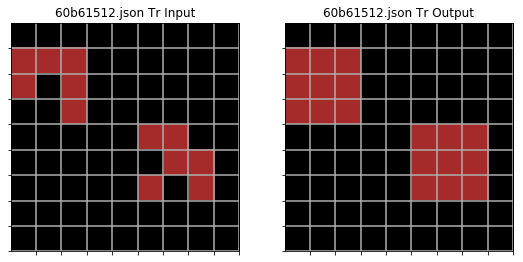

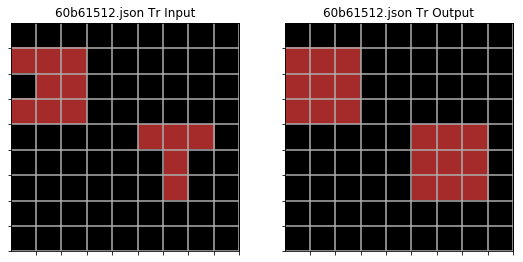

Expected Output


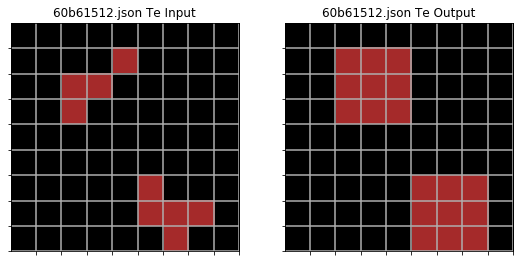

Actual Output


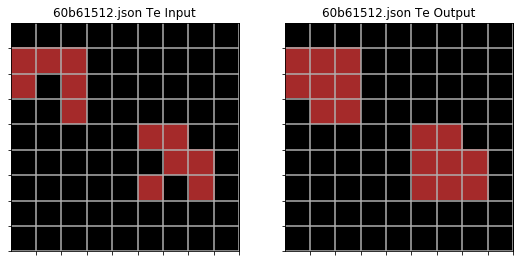

NN not able to solve the task
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [9., 9., 9., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 0., 0., 0., 0., 0., 0.],
          [9., 9., 9., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 9., 9., 9., 0.],
          [0., 0., 0., 0., 0., 0., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [9., 9., 9., 0., 0., 0., 0., 0., 0.],
          [9., 9., 9., 0., 0., 0., 0., 0., 0.],
          [9., 9., 9., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 9., 9., 9., 0.],
          [0., 0., 0., 0., 0., 9., 9., 9., 0.],
          [0., 0., 0., 0., 0., 9., 9., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
pred   op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       

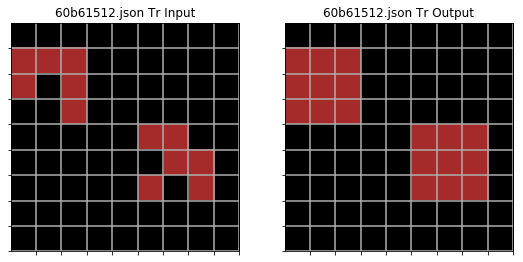

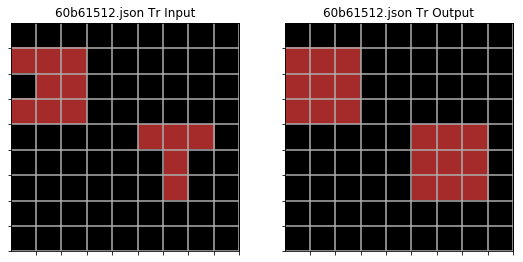

Expected Output


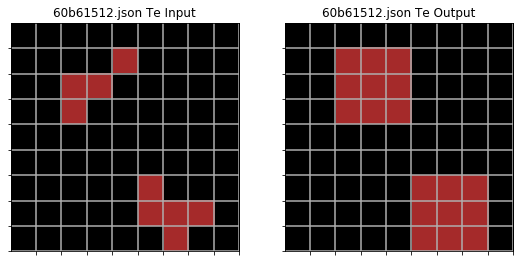

Actual Output


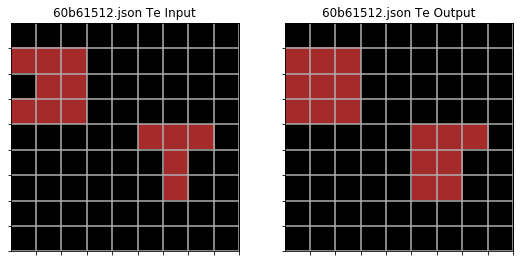

NN not able to solve the task
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 9., 0., 0., 0., 0.],
          [0., 0., 9., 9., 0., 0., 0., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 9., 9., 9., 0.],
          [0., 0., 0., 0., 0., 0., 9., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 9., 9., 9., 0.],
          [0., 0., 0., 0., 0., 9., 9., 9., 0.],
          [0., 0., 0., 0., 0., 9., 9., 9., 0.]]]])
pred   op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       

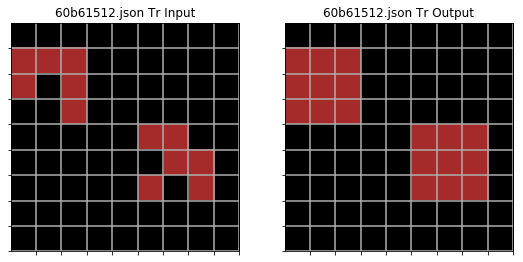

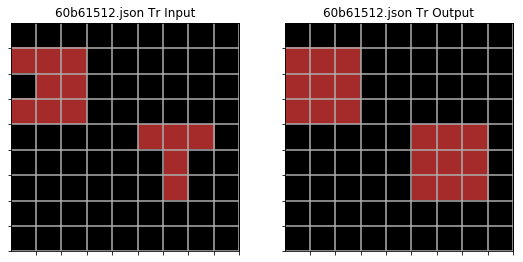

Expected Output


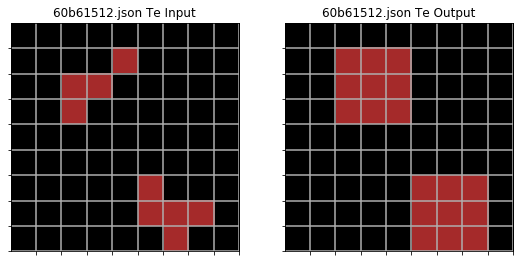

Actual Output


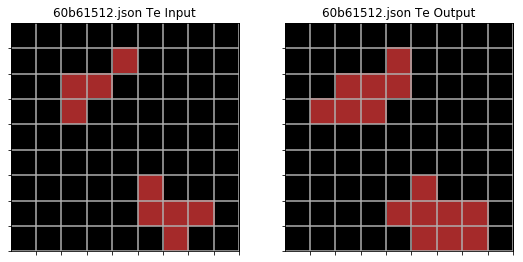

NN not able to solve the task


In [167]:
i = 36
ttm = TrainTestModel(ON=9, OFF=0, B = None, kernel_size=3,pad=1, reduction='mean', loss_function_type='default')
ttm.readData(onlyfiles_train[i], noAug=True)
ttm.train(epochs=1000, print_every=1, learning_rate=0.01, test_every=None)
ttm.test()
#Loss function: default
#Status: Not solved because there is no consistent pattern

Augmentation is OFF.
epoch: 1, batch_id: 0, loss: 0.8373380899429321
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 75.69444274902344
epoch: 1, batch_id: 1, loss: 0.8169974088668823
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 66.07142639160156
epoch: 1, batch_id: 2, loss: 0.7515407800674438
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 65.1515121459961
epoch: 2, batch_id: 0, loss: 0.699765145778656
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 72.91666412353516
epoch: 2, batch_id: 1, loss: 0.6916823387145996
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 66.07142639160156
epoch: 2, batch_id: 2, loss: 0.6556462049484253
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 66.66666412353516
epoch: 3, bat

[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 26, batch_id: 2, loss: 0.2900955379009247
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 27, batch_id: 0, loss: 0.3513909876346588
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 27, batch_id: 1, loss: 0.2981739342212677
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 27, batch_id: 2, loss: 0.2854446768760681
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 28, batch_id: 0, loss: 0.3472045660018921
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 28, batch_id: 1, loss: 0.2935025691986084
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.

epoch: 51, batch_id: 2, loss: 0.21747349202632904
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 52, batch_id: 0, loss: 0.28306517004966736
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 52, batch_id: 1, loss: 0.22457580268383026
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 52, batch_id: 2, loss: 0.21567796170711517
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 53, batch_id: 0, loss: 0.28126806020736694
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 53, batch_id: 1, loss: 0.22274088859558105
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 53, batch_id: 2, loss: 0.21393045783042908
[TRAIN] 20 elements matched out of 20 diff

epoch: 80, batch_id: 1, loss: 0.18628013134002686
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 80, batch_id: 2, loss: 0.17912009358406067
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 81, batch_id: 0, loss: 0.24289244413375854
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 81, batch_id: 1, loss: 0.18526189029216766
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 81, batch_id: 2, loss: 0.17814576625823975
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 82, batch_id: 0, loss: 0.24181678891181946
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 82, batch_id: 1, loss: 0.18426014482975006
[TRAIN] 6 elements matched out of 6 diff. 

[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 109, batch_id: 2, loss: 0.15586309134960175
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 110, batch_id: 0, loss: 0.21632054448127747
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 110, batch_id: 1, loss: 0.16131794452667236
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 110, batch_id: 2, loss: 0.1552046239376068
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 111, batch_id: 0, loss: 0.2155400663614273
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 111, batch_id: 1, loss: 0.1606389582157135
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accur

epoch: 136, batch_id: 2, loss: 0.14027059078216553
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 137, batch_id: 0, loss: 0.197415292263031
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 137, batch_id: 1, loss: 0.145226389169693
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 137, batch_id: 2, loss: 0.13976645469665527
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 138, batch_id: 0, loss: 0.19678941369056702
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 138, batch_id: 1, loss: 0.1447056531906128
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 138, batch_id: 2, loss: 0.139266699552536
[TRAIN] 20 elements matched out of 20 diff

epoch: 163, batch_id: 1, loss: 0.1329762190580368
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 163, batch_id: 2, loss: 0.12800909578800201
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 164, batch_id: 0, loss: 0.1819278448820114
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 164, batch_id: 1, loss: 0.1325521171092987
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 164, batch_id: 2, loss: 0.1276020109653473
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 165, batch_id: 0, loss: 0.18140478432178497
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 165, batch_id: 1, loss: 0.13213090598583221
[TRAIN] 6 elements matched out of 6 dif

epoch: 189, batch_id: 2, loss: 0.11828027665615082
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 190, batch_id: 0, loss: 0.16926878690719604
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 190, batch_id: 1, loss: 0.12248390167951584
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 190, batch_id: 2, loss: 0.11793810874223709
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 191, batch_id: 0, loss: 0.16881795227527618
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 191, batch_id: 1, loss: 0.1221296414732933
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 191, batch_id: 2, loss: 0.11759805679321289
[TRAIN] 20 elements matched out of 2

[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 217, batch_id: 1, loss: 0.11361891776323318
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 217, batch_id: 2, loss: 0.10942951589822769
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 218, batch_id: 0, loss: 0.15748636424541473
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 218, batch_id: 1, loss: 0.113316111266613
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 218, batch_id: 2, loss: 0.1091388538479805
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 219, batch_id: 0, loss: 0.15709558129310608
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Acc

epoch: 243, batch_id: 0, loss: 0.14824643731117249
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 243, batch_id: 1, loss: 0.10624506324529648
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 243, batch_id: 2, loss: 0.10235269367694855
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 244, batch_id: 0, loss: 0.14789800345897675
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 244, batch_id: 1, loss: 0.10598067194223404
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 244, batch_id: 2, loss: 0.10209891200065613
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 245, batch_id: 0, loss: 0.1475517600774765
[TRAIN] 30 elements matched out of 3

[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 270, batch_id: 1, loss: 0.09953732043504715
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 270, batch_id: 2, loss: 0.09591550379991531
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 271, batch_id: 0, loss: 0.13905741274356842
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 271, batch_id: 1, loss: 0.09930489957332611
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 271, batch_id: 2, loss: 0.09569240361452103
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 272, batch_id: 0, loss: 0.13874918222427368
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall 

[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 295, batch_id: 1, loss: 0.09402783215045929
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 295, batch_id: 2, loss: 0.09062842279672623
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 296, batch_id: 0, loss: 0.1317177414894104
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 296, batch_id: 1, loss: 0.0938197523355484
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 296, batch_id: 2, loss: 0.09042868763208389
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 297, batch_id: 0, loss: 0.13143940269947052
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Ac

epoch: 321, batch_id: 1, loss: 0.08889172226190567
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 321, batch_id: 2, loss: 0.08569961041212082
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 322, batch_id: 0, loss: 0.12481704354286194
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 322, batch_id: 1, loss: 0.0887049213051796
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 322, batch_id: 2, loss: 0.08552035689353943
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 323, batch_id: 0, loss: 0.12456491589546204
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 323, batch_id: 1, loss: 0.08851888030767441
[TRAIN] 6 elements matched out of 6 

[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 349, batch_id: 1, loss: 0.08393048495054245
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 349, batch_id: 2, loss: 0.08093854039907455
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 350, batch_id: 0, loss: 0.11810093373060226
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 350, batch_id: 1, loss: 0.08376304805278778
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 350, batch_id: 2, loss: 0.08077789843082428
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 351, batch_id: 0, loss: 0.11787363886833191
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall 

[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 376, batch_id: 2, loss: 0.0768035352230072
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 377, batch_id: 0, loss: 0.11223110556602478
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 377, batch_id: 1, loss: 0.07947032898664474
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 377, batch_id: 2, loss: 0.07665807008743286
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 378, batch_id: 0, loss: 0.11202410608530045
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 378, batch_id: 1, loss: 0.0793193131685257
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accu

epoch: 404, batch_id: 0, loss: 0.10687825083732605
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 404, batch_id: 1, loss: 0.07557541877031326
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 404, batch_id: 2, loss: 0.0729198157787323
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 405, batch_id: 0, loss: 0.1066892072558403
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 405, batch_id: 1, loss: 0.07543804496526718
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 405, batch_id: 2, loss: 0.07278796285390854
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 406, batch_id: 0, loss: 0.10650065541267395
[TRAIN] 30 elements matched out of 30

epoch: 431, batch_id: 2, loss: 0.06951224058866501
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 432, batch_id: 0, loss: 0.10180484503507614
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 432, batch_id: 1, loss: 0.0718999058008194
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 432, batch_id: 2, loss: 0.06939177215099335
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 433, batch_id: 0, loss: 0.10163203626871109
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 433, batch_id: 1, loss: 0.07177487760782242
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 433, batch_id: 2, loss: 0.06927173584699631
[TRAIN] 20 elements matched out of 2

[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 459, batch_id: 1, loss: 0.06866157054901123
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 459, batch_id: 2, loss: 0.06628291308879852
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 460, batch_id: 0, loss: 0.09715885668992996
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 460, batch_id: 1, loss: 0.06854692846536636
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 460, batch_id: 2, loss: 0.06617286801338196
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 461, batch_id: 0, loss: 0.09700015187263489
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall 

epoch: 486, batch_id: 2, loss: 0.0634268969297409
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 487, batch_id: 0, loss: 0.09303655475378036
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 487, batch_id: 1, loss: 0.06558137387037277
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 487, batch_id: 2, loss: 0.06332557648420334
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 488, batch_id: 0, loss: 0.09289020299911499
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 488, batch_id: 1, loss: 0.06547617167234421
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 488, batch_id: 2, loss: 0.06322452425956726
[TRAIN] 20 elements matched out of 2

epoch: 514, batch_id: 0, loss: 0.0892266109585762
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 514, batch_id: 1, loss: 0.0628480389714241
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 514, batch_id: 2, loss: 0.06070081517100334
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 515, batch_id: 0, loss: 0.08909109234809875
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 515, batch_id: 1, loss: 0.0627509132027626
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 515, batch_id: 2, loss: 0.06060754135251045
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 516, batch_id: 0, loss: 0.08895593881607056
[TRAIN] 30 elements matched out of 30 

[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 538, batch_id: 1, loss: 0.06059243530035019
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 538, batch_id: 2, loss: 0.058534491807222366
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 539, batch_id: 0, loss: 0.08594860136508942
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 539, batch_id: 1, loss: 0.060501765459775925
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 539, batch_id: 2, loss: 0.058447420597076416
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 540, batch_id: 0, loss: 0.08582210540771484
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overa

epoch: 571, batch_id: 0, loss: 0.08206614851951599
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 571, batch_id: 1, loss: 0.05772906914353371
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 571, batch_id: 2, loss: 0.05578404292464256
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 572, batch_id: 0, loss: 0.08194997161626816
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 572, batch_id: 1, loss: 0.057646267116069794
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 572, batch_id: 2, loss: 0.055704452097415924
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 573, batch_id: 0, loss: 0.08183430880308151
[TRAIN] 30 elements matched out o

[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 596, batch_id: 1, loss: 0.05572418496012688
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 596, batch_id: 2, loss: 0.05385783314704895
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 597, batch_id: 0, loss: 0.07914429903030396
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 597, batch_id: 1, loss: 0.05564672872424126
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 597, batch_id: 2, loss: 0.05378340557217598
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 598, batch_id: 0, loss: 0.07903598994016647
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall 

epoch: 621, batch_id: 1, loss: 0.053846534341573715
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 621, batch_id: 2, loss: 0.05205359309911728
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 622, batch_id: 0, loss: 0.07651261240243912
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 622, batch_id: 1, loss: 0.0537739135324955
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 622, batch_id: 2, loss: 0.0519837848842144
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 623, batch_id: 0, loss: 0.07641074061393738
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 623, batch_id: 1, loss: 0.0537014901638031
[TRAIN] 6 elements matched out of 6 d

epoch: 646, batch_id: 2, loss: 0.05036034435033798
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 647, batch_id: 0, loss: 0.07403961569070816
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 647, batch_id: 1, loss: 0.0520164780318737
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 647, batch_id: 2, loss: 0.050294794142246246
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 648, batch_id: 0, loss: 0.07394378632307053
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 648, batch_id: 1, loss: 0.05194844678044319
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 648, batch_id: 2, loss: 0.050229400396347046
[TRAIN] 20 elements matched out of

[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 665, batch_id: 1, loss: 0.050816845148801804
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 665, batch_id: 2, loss: 0.04914173111319542
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 666, batch_id: 0, loss: 0.07225791364908218
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 666, batch_id: 1, loss: 0.05075175315141678
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 666, batch_id: 2, loss: 0.04907914623618126
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 667, batch_id: 0, loss: 0.07216625660657883
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall

[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 687, batch_id: 0, loss: 0.07037990540266037
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 687, batch_id: 1, loss: 0.04941987991333008
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 687, batch_id: 2, loss: 0.047798801213502884
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 688, batch_id: 0, loss: 0.07029290497303009
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 688, batch_id: 1, loss: 0.04935811087489128
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 688, batch_id: 2, loss: 0.04773939773440361
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall

[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 710, batch_id: 2, loss: 0.04646731913089752
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 711, batch_id: 0, loss: 0.0683429092168808
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 711, batch_id: 1, loss: 0.0479765348136425
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 711, batch_id: 2, loss: 0.046411000192165375
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 712, batch_id: 0, loss: 0.06826059520244598
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 712, batch_id: 1, loss: 0.04791814461350441
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Acc

[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 736, batch_id: 0, loss: 0.06633557379245758
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 736, batch_id: 1, loss: 0.04655563086271286
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 736, batch_id: 2, loss: 0.04504464194178581
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 737, batch_id: 0, loss: 0.06625770777463913
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 737, batch_id: 1, loss: 0.04650045186281204
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 737, batch_id: 2, loss: 0.04499155282974243
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall 

epoch: 761, batch_id: 0, loss: 0.0644364133477211
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 761, batch_id: 1, loss: 0.04521236941218376
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 761, batch_id: 2, loss: 0.04375274106860161
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 762, batch_id: 0, loss: 0.06436256319284439
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 762, batch_id: 1, loss: 0.0451601967215538
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 762, batch_id: 2, loss: 0.043702539056539536
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 763, batch_id: 0, loss: 0.06428883969783783
[TRAIN] 30 elements matched out of 3

[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 788, batch_id: 0, loss: 0.062497079372406006
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 788, batch_id: 1, loss: 0.043841976672410965
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 788, batch_id: 2, loss: 0.04243449866771698
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 789, batch_id: 0, loss: 0.062427401542663574
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 789, batch_id: 1, loss: 0.0437927320599556
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 789, batch_id: 2, loss: 0.04238709807395935
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overal

[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 815, batch_id: 0, loss: 0.06066513806581497
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 815, batch_id: 1, loss: 0.042548347264528275
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 815, batch_id: 2, loss: 0.04118983447551727
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 816, batch_id: 0, loss: 0.06059929355978966
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 816, batch_id: 1, loss: 0.04250181466341019
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 816, batch_id: 2, loss: 0.04114509001374245
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall

epoch: 842, batch_id: 0, loss: 0.058931879699230194
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 842, batch_id: 1, loss: 0.04132542014122009
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 842, batch_id: 2, loss: 0.04001302272081375
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 843, batch_id: 0, loss: 0.05886954814195633
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 843, batch_id: 1, loss: 0.041281405836343765
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 843, batch_id: 2, loss: 0.039970654994249344
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 844, batch_id: 0, loss: 0.058807142078876495
[TRAIN] 30 elements matched out

epoch: 868, batch_id: 2, loss: 0.038938988000154495
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 869, batch_id: 0, loss: 0.057290058583021164
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 869, batch_id: 1, loss: 0.04016770049929619
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 869, batch_id: 2, loss: 0.03889880329370499
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 870, batch_id: 0, loss: 0.057230956852436066
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 870, batch_id: 1, loss: 0.0401260145008564
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 870, batch_id: 2, loss: 0.03885863348841667
[TRAIN] 20 elements matched out o

epoch: 896, batch_id: 0, loss: 0.055732712149620056
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 896, batch_id: 1, loss: 0.03907022625207901
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 896, batch_id: 2, loss: 0.03784232959151268
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 897, batch_id: 0, loss: 0.055676620453596115
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 897, batch_id: 1, loss: 0.039030689746141434
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 897, batch_id: 2, loss: 0.03780427202582359
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 898, batch_id: 0, loss: 0.05562056601047516
[TRAIN] 30 elements matched out 

epoch: 921, batch_id: 0, loss: 0.05436079949140549
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 921, batch_id: 1, loss: 0.03810393065214157
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 921, batch_id: 2, loss: 0.0369119830429554
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 922, batch_id: 0, loss: 0.05430733039975166
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 922, batch_id: 1, loss: 0.038066234439611435
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 922, batch_id: 2, loss: 0.03687567636370659
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 923, batch_id: 0, loss: 0.054253920912742615
[TRAIN] 30 elements matched out of

[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 948, batch_id: 0, loss: 0.05294950678944588
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 948, batch_id: 1, loss: 0.0371103473007679
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 948, batch_id: 2, loss: 0.03595522791147232
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 949, batch_id: 0, loss: 0.05289853364229202
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 949, batch_id: 1, loss: 0.0370745025575161
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 949, batch_id: 2, loss: 0.03592070937156677
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Ac

epoch: 973, batch_id: 1, loss: 0.036233607679605484
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 973, batch_id: 2, loss: 0.03511084243655205
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 974, batch_id: 0, loss: 0.051654964685440063
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 974, batch_id: 1, loss: 0.036199361085891724
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 974, batch_id: 2, loss: 0.03507786989212036
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 975, batch_id: 0, loss: 0.05160638689994812
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 975, batch_id: 1, loss: 0.036165181547403336
[TRAIN] 6 elements matched out 

epoch: 998, batch_id: 1, loss: 0.035395652055740356
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 998, batch_id: 2, loss: 0.034303683787584305
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 999, batch_id: 0, loss: 0.050465747714042664
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 999, batch_id: 1, loss: 0.035362906754016876
[TRAIN] 6 elements matched out of 6 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 999, batch_id: 2, loss: 0.034272145479917526
[TRAIN] 20 elements matched out of 20 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 1000, batch_id: 0, loss: 0.05041922628879547
[TRAIN] 30 elements matched out of 30 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 1000, batch_id: 1, loss: 0.035330213606357574
[TRAIN] 6 elements matched 

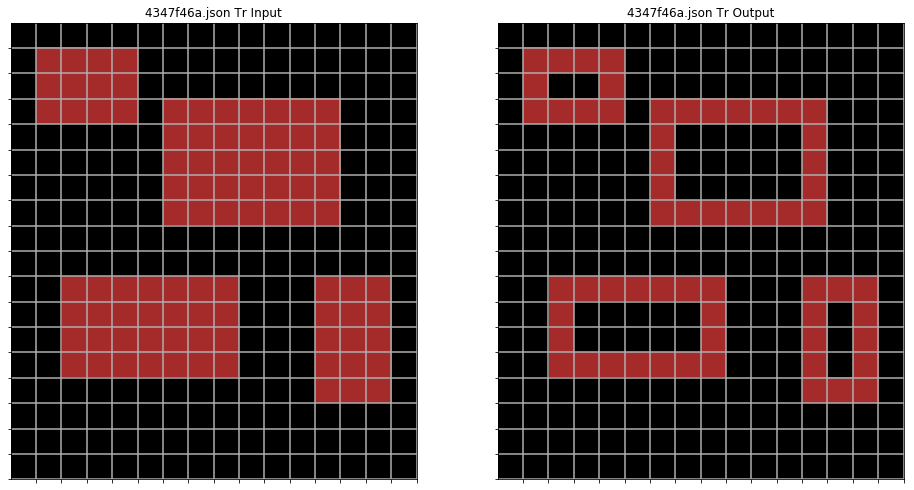

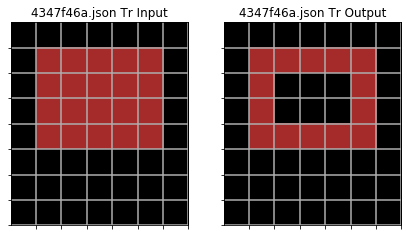

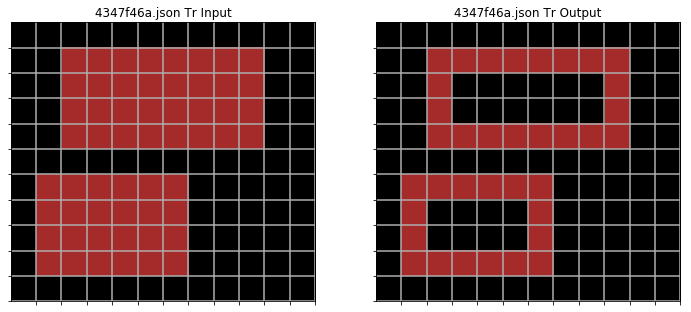

Expected Output


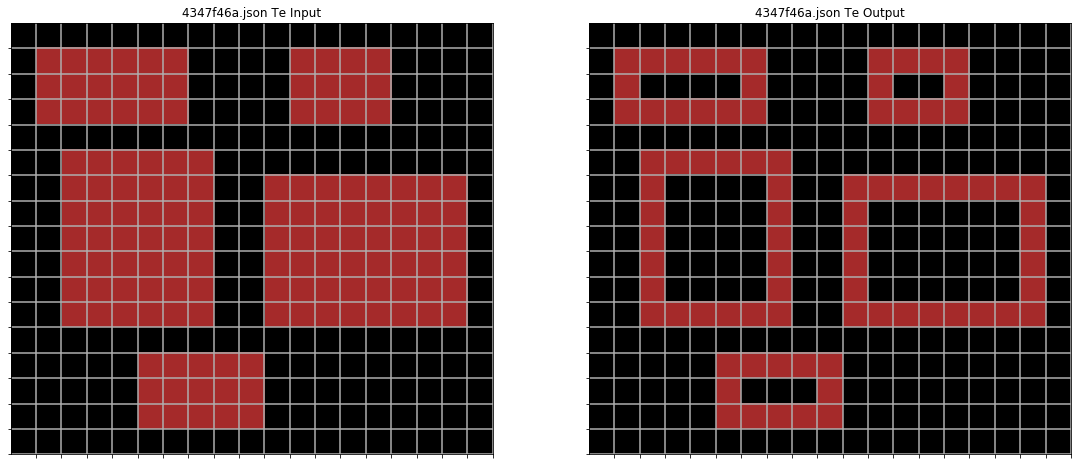

Actual Output


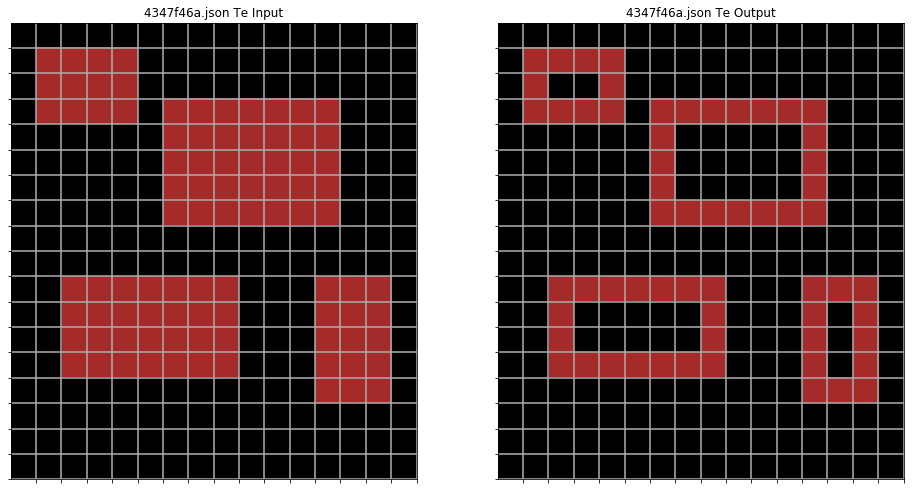

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 9., 9., 0.],
          [0., 9., 9., 9., 9., 9., 0.],
          [0., 9., 9., 9., 9., 9., 0.],
          [0., 9., 9., 9., 9., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 9., 9., 0.],
          [0., 9., 0., 0., 0., 9., 0.],
          [0., 9., 0., 0., 0., 9., 0.],
          [0., 9., 9., 9., 9., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]]])
pred   op grid tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 9., 9., 0.],
          [0., 9., 0., 0., 0., 9., 0.],
          [0., 9., 0., 0., 0., 9., 0.],
          [0., 9., 9., 9., 9., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
   

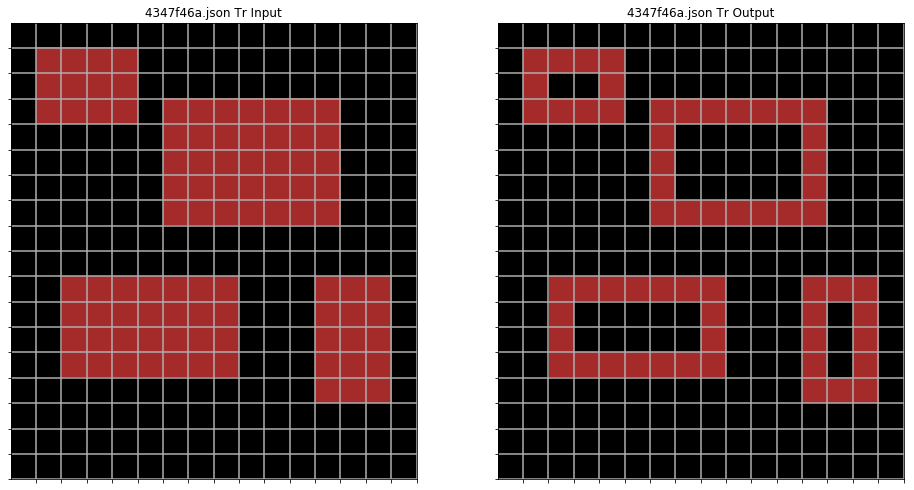

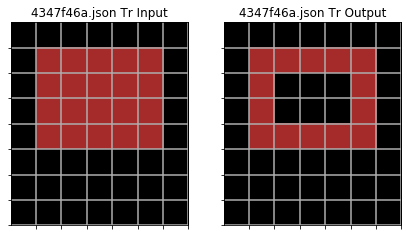

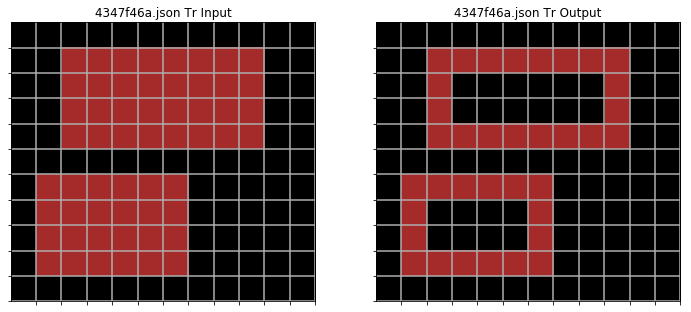

Expected Output


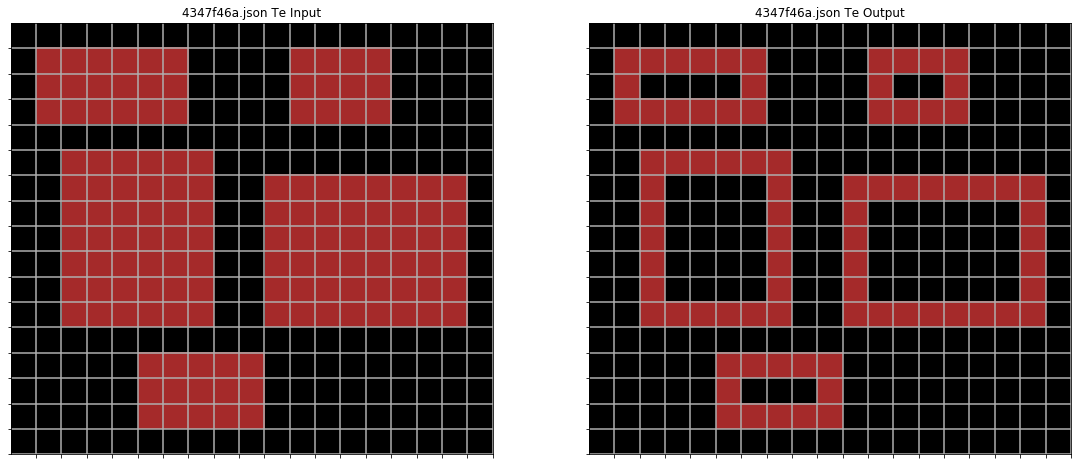

Actual Output


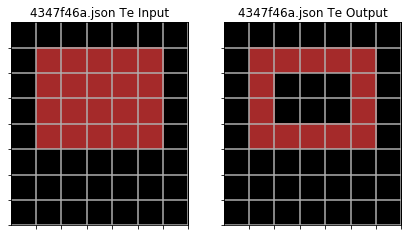

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 9., 9., 0., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 9., 9., 0., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 9., 9., 0., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 9., 9., 9., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 9., 9., 9., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 9., 9., 9., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 9., 9., 9., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 9., 9., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 0., 0., 9., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 0., 0., 9., 0., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9.

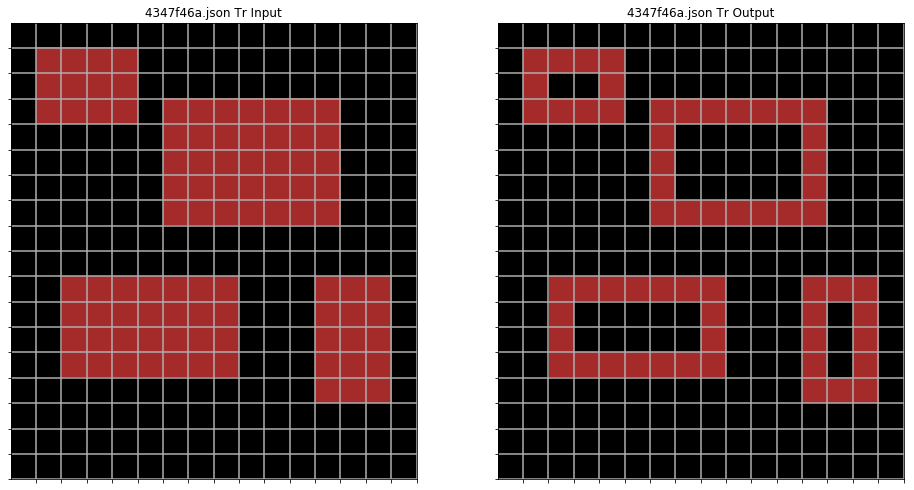

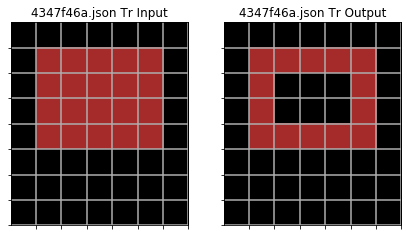

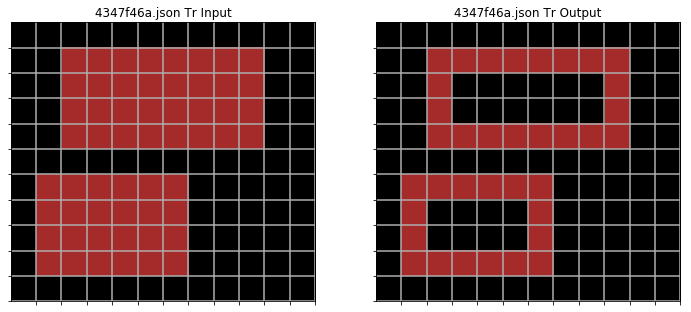

Expected Output


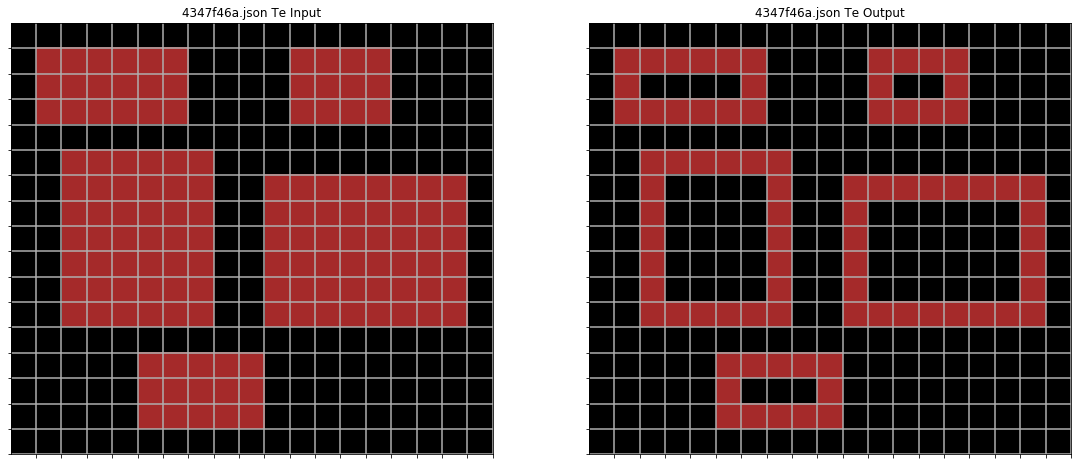

Actual Output


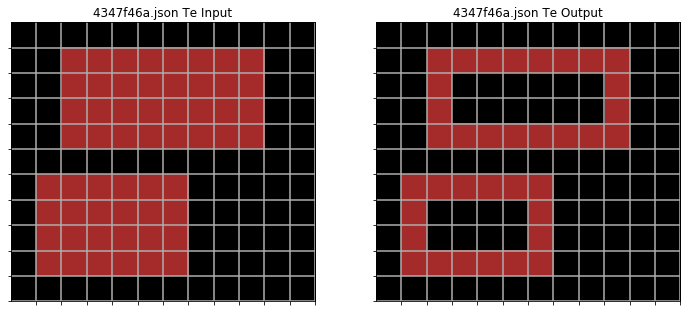

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0.],
          [0., 9., 9., 9., 9., 9., 9., 0., 0., 0., 0., 9., 9., 9., 9., 0., 0.,
           0., 0.],
          [0., 9., 9., 9., 9., 9., 9., 0., 0., 0., 0., 9., 9., 9., 9., 0., 0.,
           0., 0.],
          [0., 9., 9., 9., 9., 9., 9., 0., 0., 0., 0., 9., 9., 9., 9., 0., 0.,
           0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 0., 0., 9., 9., 9., 9., 9., 9., 9.,
           9., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 0., 0., 9., 9., 9., 9., 9., 9., 9.,
           9., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 0., 0., 9., 9., 9., 9., 9., 9., 9.,
           9., 0.],
          [0., 0., 9., 9., 9., 9., 9., 9., 0., 0., 9., 9., 9., 9., 9

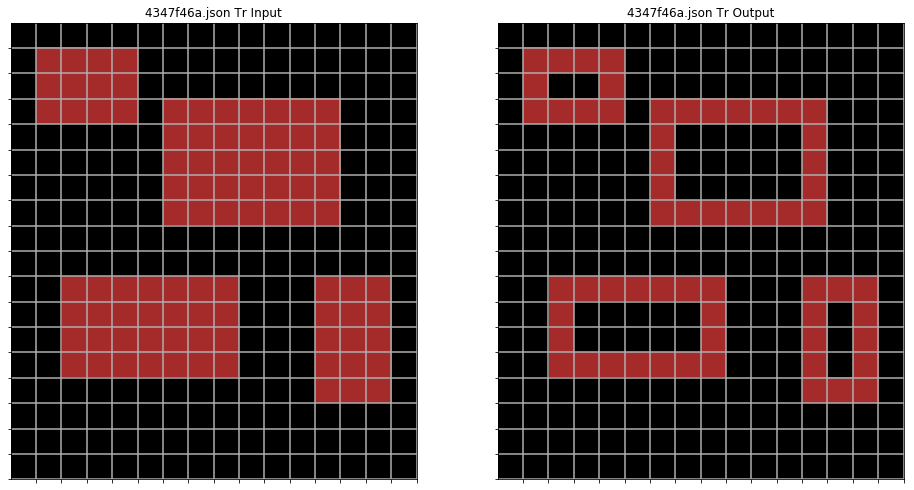

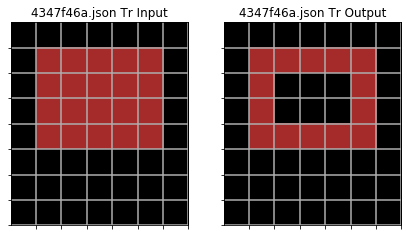

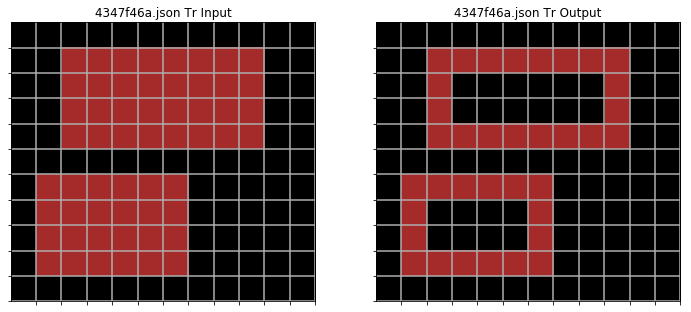

Expected Output


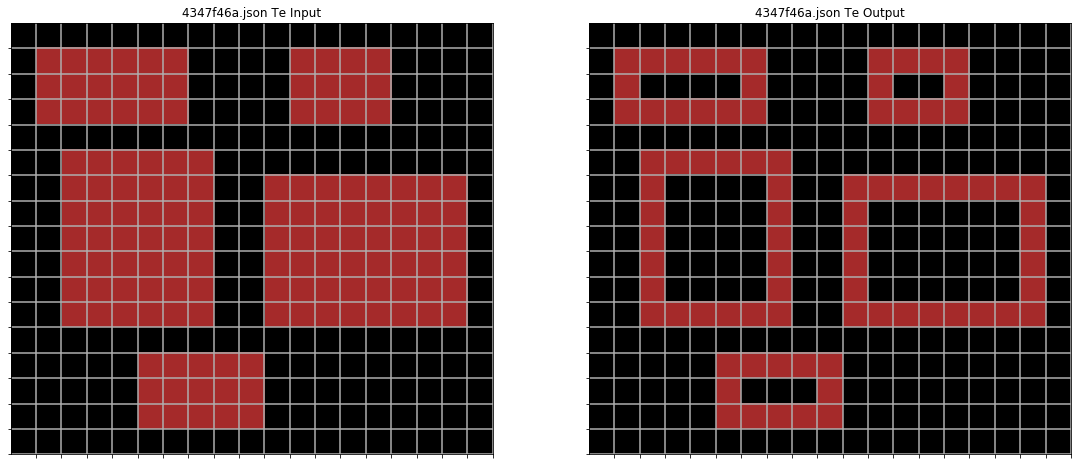

Actual Output


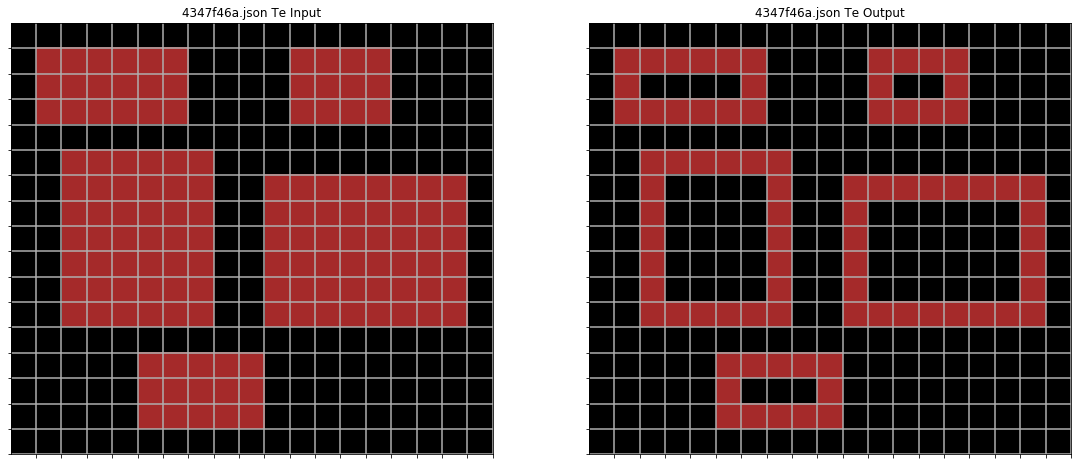

Task successfully solved.


In [166]:
i = 26
ttm = TrainTestModel(ON=9, OFF=0, B = None, kernel_size=3,pad=1, reduction='mean', loss_function_type='default')
ttm.readData(onlyfiles_train[i], noAug=True)
ttm.train(epochs=1000, print_every=1, learning_rate=0.01, test_every=None)
ttm.test()
#Loss function: default
#Status: Successfully solved bcz a quite consistent rule can be seen

Augmentation is OFF.
epoch: 1, batch_id: 0, loss: 1.089162826538086
[TRAIN] 7 elements matched out of 12 diff. elements.        Accuracy: 58.33333206176758. Overall Accuracy: 50.0
epoch: 1, batch_id: 1, loss: 1.3725380897521973
[TRAIN] 24 elements matched out of 32 diff. elements.        Accuracy: 75.0. Overall Accuracy: 72.0
epoch: 1, batch_id: 2, loss: 0.48299217224121094
[TRAIN] 24 elements matched out of 32 diff. elements.        Accuracy: 75.0. Overall Accuracy: 65.0
epoch: 2, batch_id: 0, loss: 0.5472640991210938
[TRAIN] 10 elements matched out of 12 diff. elements.        Accuracy: 83.33333587646484. Overall Accuracy: 54.0
epoch: 2, batch_id: 1, loss: 0.402378648519516
[TRAIN] 22 elements matched out of 32 diff. elements.        Accuracy: 68.75. Overall Accuracy: 74.0
epoch: 2, batch_id: 2, loss: 0.3666197955608368
[TRAIN] 25 elements matched out of 32 diff. elements.        Accuracy: 78.125. Overall Accuracy: 69.0
epoch: 3, batch_id: 0, loss: 0.45173853635787964
[TRAIN] 10 elem

epoch: 24, batch_id: 0, loss: 0.3081195056438446
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 24, batch_id: 1, loss: 0.1376928985118866
[TRAIN] 27 elements matched out of 32 diff. elements.        Accuracy: 84.375. Overall Accuracy: 95.0
epoch: 24, batch_id: 2, loss: 0.15384018421173096
[TRAIN] 28 elements matched out of 32 diff. elements.        Accuracy: 87.5. Overall Accuracy: 96.0
epoch: 25, batch_id: 0, loss: 0.30632805824279785
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 25, batch_id: 1, loss: 0.13586735725402832
[TRAIN] 27 elements matched out of 32 diff. elements.        Accuracy: 84.375. Overall Accuracy: 95.0
epoch: 25, batch_id: 2, loss: 0.15227337181568146
[TRAIN] 28 elements matched out of 32 diff. elements.        Accuracy: 87.5. Overall Accuracy: 96.0
epoch: 26, batch_id: 0, loss: 0.30461978912353516
[TRAIN] 12 elements matched out of 12 diff. el

epoch: 48, batch_id: 1, loss: 0.11383653432130814
[TRAIN] 27 elements matched out of 32 diff. elements.        Accuracy: 84.375. Overall Accuracy: 95.0
epoch: 48, batch_id: 2, loss: 0.13173441588878632
[TRAIN] 30 elements matched out of 32 diff. elements.        Accuracy: 93.75. Overall Accuracy: 98.0
epoch: 49, batch_id: 0, loss: 0.2786509394645691
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 49, batch_id: 1, loss: 0.1133091151714325
[TRAIN] 27 elements matched out of 32 diff. elements.        Accuracy: 84.375. Overall Accuracy: 95.0
epoch: 49, batch_id: 2, loss: 0.1311771422624588
[TRAIN] 30 elements matched out of 32 diff. elements.        Accuracy: 93.75. Overall Accuracy: 98.0
epoch: 50, batch_id: 0, loss: 0.27785569429397583
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 50, batch_id: 1, loss: 0.11279954761266708
[TRAIN] 27 elements matched out of 32 diff. e

epoch: 74, batch_id: 2, loss: 0.12045811861753464
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 75, batch_id: 0, loss: 0.26160746812820435
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 75, batch_id: 1, loss: 0.10377731919288635
[TRAIN] 29 elements matched out of 32 diff. elements.        Accuracy: 90.625. Overall Accuracy: 97.0
epoch: 75, batch_id: 2, loss: 0.12011580169200897
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 76, batch_id: 0, loss: 0.26105618476867676
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 76, batch_id: 1, loss: 0.10351289808750153
[TRAIN] 29 elements matched out of 32 diff. elements.        Accuracy: 90.625. Overall Accuracy: 97.0
epoch: 76, batch_id: 2, loss: 0.119778111577034
[TRAIN] 32 elements matched out of 32 diff

[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 100, batch_id: 1, loss: 0.09831742942333221
[TRAIN] 31 elements matched out of 32 diff. elements.        Accuracy: 96.875. Overall Accuracy: 99.0
epoch: 100, batch_id: 2, loss: 0.1127687469124794
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 101, batch_id: 0, loss: 0.2486807405948639
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 101, batch_id: 1, loss: 0.09813738614320755
[TRAIN] 31 elements matched out of 32 diff. elements.        Accuracy: 96.875. Overall Accuracy: 99.0
epoch: 101, batch_id: 2, loss: 0.11251324415206909
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 102, batch_id: 0, loss: 0.24823132157325745
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall 

epoch: 125, batch_id: 2, loss: 0.10700025409460068
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 126, batch_id: 0, loss: 0.2382214367389679
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 126, batch_id: 1, loss: 0.09423771500587463
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 126, batch_id: 2, loss: 0.1067926436662674
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 127, batch_id: 0, loss: 0.2378331422805786
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 127, batch_id: 1, loss: 0.09410126507282257
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 127, batch_id: 2, loss: 0.1065865233540535
[TRAIN] 32 elements matched out of 32

[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 151, batch_id: 0, loss: 0.22908839583396912
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 151, batch_id: 1, loss: 0.09114554524421692
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 151, batch_id: 2, loss: 0.10204529762268066
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 152, batch_id: 0, loss: 0.2287459820508957
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 152, batch_id: 1, loss: 0.09103377163410187
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 152, batch_id: 2, loss: 0.10187111794948578
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall

[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 175, batch_id: 2, loss: 0.09813668578863144
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 176, batch_id: 0, loss: 0.2209862470626831
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 176, batch_id: 1, loss: 0.08856084942817688
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 176, batch_id: 2, loss: 0.09798509627580643
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 177, batch_id: 0, loss: 0.22068071365356445
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 177, batch_id: 1, loss: 0.08846551179885864
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall

epoch: 201, batch_id: 2, loss: 0.0944436565041542
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 202, batch_id: 0, loss: 0.2134513258934021
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 202, batch_id: 1, loss: 0.08624252676963806
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 202, batch_id: 2, loss: 0.09431109577417374
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 203, batch_id: 0, loss: 0.21317753195762634
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 203, batch_id: 1, loss: 0.08615937829017639
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 203, batch_id: 2, loss: 0.09417916089296341
[TRAIN] 32 elements matched out of 

epoch: 225, batch_id: 1, loss: 0.08442401885986328
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 225, batch_id: 2, loss: 0.09142961353063583
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 226, batch_id: 0, loss: 0.20717205107212067
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 226, batch_id: 1, loss: 0.08434908092021942
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 226, batch_id: 2, loss: 0.09131111949682236
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 227, batch_id: 0, loss: 0.2069229930639267
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 227, batch_id: 1, loss: 0.08427445590496063
[TRAIN] 32 elements matched out of

epoch: 250, batch_id: 0, loss: 0.2014460414648056
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 250, batch_id: 1, loss: 0.08263923972845078
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 250, batch_id: 2, loss: 0.0886172354221344
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 251, batch_id: 0, loss: 0.20121830701828003
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 251, batch_id: 1, loss: 0.08257143199443817
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 251, batch_id: 2, loss: 0.08851084113121033
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 252, batch_id: 0, loss: 0.20099137723445892
[TRAIN] 12 elements matched out of 

epoch: 274, batch_id: 0, loss: 0.19619868695735931
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 274, batch_id: 1, loss: 0.0810779556632042
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 274, batch_id: 2, loss: 0.086179219186306
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 275, batch_id: 0, loss: 0.19598953425884247
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 275, batch_id: 1, loss: 0.08101572841405869
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 275, batch_id: 2, loss: 0.0860825851559639
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 276, batch_id: 0, loss: 0.19578105211257935
[TRAIN] 12 elements matched out of 12

epoch: 299, batch_id: 2, loss: 0.08387020230293274
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 300, batch_id: 0, loss: 0.19098404049873352
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 300, batch_id: 1, loss: 0.07952509820461273
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 300, batch_id: 2, loss: 0.08378223329782486
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 301, batch_id: 0, loss: 0.19079230725765228
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 301, batch_id: 1, loss: 0.07946792244911194
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 301, batch_id: 2, loss: 0.08369459211826324
[TRAIN] 32 elements matched out o

[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 324, batch_id: 1, loss: 0.07819972187280655
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 324, batch_id: 2, loss: 0.08176273107528687
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 325, batch_id: 0, loss: 0.18637263774871826
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 325, batch_id: 1, loss: 0.07814651727676392
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 325, batch_id: 2, loss: 0.0816822275519371
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 326, batch_id: 0, loss: 0.18619567155838013
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall

[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 343, batch_id: 1, loss: 0.07721420377492905
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 343, batch_id: 2, loss: 0.08027872443199158
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 344, batch_id: 0, loss: 0.18310226500034332
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 344, batch_id: 1, loss: 0.07716377824544907
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 344, batch_id: 2, loss: 0.08020319789648056
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 345, batch_id: 0, loss: 0.18293535709381104
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overal

[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 373, batch_id: 0, loss: 0.17845700681209564
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 373, batch_id: 1, loss: 0.07575812935829163
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 373, batch_id: 2, loss: 0.07811608910560608
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 374, batch_id: 0, loss: 0.17830373346805573
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 374, batch_id: 1, loss: 0.07571151852607727
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 374, batch_id: 2, loss: 0.0780474916100502
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall

epoch: 402, batch_id: 0, loss: 0.17418314516544342
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 402, batch_id: 1, loss: 0.07445242255926132
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 402, batch_id: 2, loss: 0.07620921730995178
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 403, batch_id: 0, loss: 0.17404180765151978
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 403, batch_id: 1, loss: 0.07440901547670364
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 403, batch_id: 2, loss: 0.07614637166261673
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 404, batch_id: 0, loss: 0.17390087246894836
[TRAIN] 12 elements matched out o

[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 429, batch_id: 0, loss: 0.17049828171730042
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 429, batch_id: 1, loss: 0.07331524044275284
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 429, batch_id: 2, loss: 0.07457468658685684
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 430, batch_id: 0, loss: 0.17036685347557068
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 430, batch_id: 1, loss: 0.07327444851398468
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 430, batch_id: 2, loss: 0.07451654225587845
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overal

[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 461, batch_id: 1, loss: 0.07205361127853394
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 461, batch_id: 2, loss: 0.07279086112976074
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 462, batch_id: 0, loss: 0.16633430123329163
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 462, batch_id: 1, loss: 0.07201556861400604
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 462, batch_id: 2, loss: 0.07273757457733154
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 463, batch_id: 0, loss: 0.16621343791484833
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overal

[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 487, batch_id: 1, loss: 0.0710897371172905
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 487, batch_id: 2, loss: 0.07144951075315475
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 488, batch_id: 0, loss: 0.16328786313533783
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 488, batch_id: 1, loss: 0.07105366885662079
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 488, batch_id: 2, loss: 0.07139971107244492
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 489, batch_id: 0, loss: 0.16317448019981384
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall

[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 512, batch_id: 1, loss: 0.07020942866802216
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 512, batch_id: 2, loss: 0.07024096697568893
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 513, batch_id: 0, loss: 0.16053299605846405
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 513, batch_id: 1, loss: 0.07017511129379272
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 513, batch_id: 2, loss: 0.07019416987895966
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 514, batch_id: 0, loss: 0.16042615473270416
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overal

[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 537, batch_id: 0, loss: 0.15803493559360504
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 537, batch_id: 1, loss: 0.06937067210674286
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 537, batch_id: 2, loss: 0.06910421699285507
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 538, batch_id: 0, loss: 0.15793375670909882
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 538, batch_id: 1, loss: 0.06933794170618057
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 538, batch_id: 2, loss: 0.06906013190746307
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overal

epoch: 563, batch_id: 1, loss: 0.06853871792554855
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 563, batch_id: 2, loss: 0.0679909959435463
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 564, batch_id: 0, loss: 0.15538117289543152
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 564, batch_id: 1, loss: 0.06850748509168625
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 564, batch_id: 2, loss: 0.06794949620962143
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 565, batch_id: 0, loss: 0.15528585016727448
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 565, batch_id: 1, loss: 0.06847631931304932
[TRAIN] 32 elements matched out of

epoch: 589, batch_id: 0, loss: 0.15305930376052856
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 589, batch_id: 1, loss: 0.06774448603391647
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 589, batch_id: 2, loss: 0.06694160401821136
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 590, batch_id: 0, loss: 0.15296894311904907
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 590, batch_id: 1, loss: 0.0677146464586258
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 590, batch_id: 2, loss: 0.06690242886543274
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 591, batch_id: 0, loss: 0.15287882089614868
[TRAIN] 12 elements matched out of

[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 614, batch_id: 1, loss: 0.06701359152793884
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 614, batch_id: 2, loss: 0.06598737835884094
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 615, batch_id: 0, loss: 0.15077073872089386
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 615, batch_id: 1, loss: 0.06698498129844666
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 615, batch_id: 2, loss: 0.06595026701688766
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 616, batch_id: 0, loss: 0.1506851613521576
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall

epoch: 637, batch_id: 2, loss: 0.06515299528837204
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 638, batch_id: 0, loss: 0.14884527027606964
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 638, batch_id: 1, loss: 0.06633991003036499
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 638, batch_id: 2, loss: 0.06511760503053665
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 639, batch_id: 0, loss: 0.1487635225057602
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 639, batch_id: 1, loss: 0.06631239503622055
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 639, batch_id: 2, loss: 0.06508231908082962
[TRAIN] 32 elements matched out of

[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 663, batch_id: 2, loss: 0.06425590813159943
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 664, batch_id: 0, loss: 0.14677171409130096
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 664, batch_id: 1, loss: 0.06563879549503326
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 664, batch_id: 2, loss: 0.06422233581542969
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 665, batch_id: 0, loss: 0.14669406414031982
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 665, batch_id: 1, loss: 0.06561238318681717
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overal

epoch: 686, batch_id: 2, loss: 0.0635000467300415
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 687, batch_id: 0, loss: 0.14502227306365967
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 687, batch_id: 1, loss: 0.06504181027412415
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 687, batch_id: 2, loss: 0.06346792727708817
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 688, batch_id: 0, loss: 0.14494793117046356
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 688, batch_id: 1, loss: 0.06501632183790207
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 688, batch_id: 2, loss: 0.06343588978052139
[TRAIN] 32 elements matched out of

epoch: 713, batch_id: 0, loss: 0.14313353598117828
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 713, batch_id: 1, loss: 0.06439142674207687
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 713, batch_id: 2, loss: 0.06265430152416229
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 714, batch_id: 0, loss: 0.14306268095970154
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 714, batch_id: 1, loss: 0.06436692923307419
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 714, batch_id: 2, loss: 0.06262379884719849
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 715, batch_id: 0, loss: 0.14299196004867554
[TRAIN] 12 elements matched out o

epoch: 739, batch_id: 1, loss: 0.06376536190509796
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 739, batch_id: 2, loss: 0.06187914311885834
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 740, batch_id: 0, loss: 0.14126458764076233
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 740, batch_id: 1, loss: 0.06374172121286392
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 740, batch_id: 2, loss: 0.06185005605220795
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 741, batch_id: 0, loss: 0.141197070479393
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 741, batch_id: 1, loss: 0.06371815502643585
[TRAIN] 32 elements matched out of 

[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 765, batch_id: 1, loss: 0.0631619542837143
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 765, batch_id: 2, loss: 0.06113949418067932
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 766, batch_id: 0, loss: 0.13954748213291168
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 766, batch_id: 1, loss: 0.06313920766115189
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 766, batch_id: 2, loss: 0.061111725866794586
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 767, batch_id: 0, loss: 0.13948296010494232
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overal

epoch: 791, batch_id: 0, loss: 0.13796745240688324
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 791, batch_id: 1, loss: 0.06257982552051544
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 791, batch_id: 2, loss: 0.06043275445699692
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 792, batch_id: 0, loss: 0.13790564239025116
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 792, batch_id: 1, loss: 0.06255784630775452
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 792, batch_id: 2, loss: 0.060406193137168884
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 793, batch_id: 0, loss: 0.13784393668174744
[TRAIN] 12 elements matched out 

epoch: 816, batch_id: 2, loss: 0.05978202447295189
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 817, batch_id: 0, loss: 0.13639305531978607
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 817, batch_id: 1, loss: 0.06201764941215515
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 817, batch_id: 2, loss: 0.059756550937891006
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 818, batch_id: 0, loss: 0.13633383810520172
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 818, batch_id: 1, loss: 0.06199640780687332
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 818, batch_id: 2, loss: 0.0597311295568943
[TRAIN] 32 elements matched out o

epoch: 842, batch_id: 1, loss: 0.061494745314121246
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 842, batch_id: 2, loss: 0.059133127331733704
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 843, batch_id: 0, loss: 0.1348840743303299
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 843, batch_id: 1, loss: 0.06147419288754463
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 843, batch_id: 2, loss: 0.05910872295498848
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 844, batch_id: 0, loss: 0.13482734560966492
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 844, batch_id: 1, loss: 0.06145363301038742
[TRAIN] 32 elements matched out 

epoch: 866, batch_id: 2, loss: 0.05855776369571686
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 867, batch_id: 0, loss: 0.1335456520318985
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 867, batch_id: 1, loss: 0.06098822504281998
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 867, batch_id: 2, loss: 0.05853426083922386
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 868, batch_id: 0, loss: 0.13349096477031708
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 868, batch_id: 1, loss: 0.06096829101443291
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 868, batch_id: 2, loss: 0.058510784059762955
[TRAIN] 32 elements matched out o

[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 892, batch_id: 1, loss: 0.060497134923934937
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 892, batch_id: 2, loss: 0.05795830860733986
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 893, batch_id: 0, loss: 0.13215090334415436
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 893, batch_id: 1, loss: 0.06047780066728592
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 893, batch_id: 2, loss: 0.057935748249292374
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 894, batch_id: 0, loss: 0.13209831714630127
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Over

[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 916, batch_id: 1, loss: 0.0600394643843174
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 916, batch_id: 2, loss: 0.05742565542459488
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 917, batch_id: 0, loss: 0.1309112310409546
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 917, batch_id: 1, loss: 0.06002067029476166
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 917, batch_id: 2, loss: 0.05740387365221977
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 918, batch_id: 0, loss: 0.1308605819940567
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall A

[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 948, batch_id: 1, loss: 0.059449031949043274
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 948, batch_id: 2, loss: 0.05674426630139351
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 949, batch_id: 0, loss: 0.129325270652771
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 949, batch_id: 1, loss: 0.05943092703819275
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 949, batch_id: 2, loss: 0.05672348663210869
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 950, batch_id: 0, loss: 0.12927687168121338
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall

[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 978, batch_id: 2, loss: 0.05613333731889725
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 979, batch_id: 0, loss: 0.12790313363075256
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 979, batch_id: 1, loss: 0.05889734625816345
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 979, batch_id: 2, loss: 0.056113410741090775
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 980, batch_id: 0, loss: 0.12785671651363373
[TRAIN] 12 elements matched out of 12 diff. elements.        Accuracy: 100.0. Overall Accuracy: 88.0
epoch: 980, batch_id: 1, loss: 0.05887987092137337
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overa

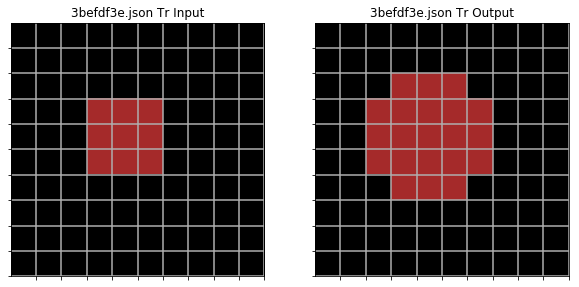

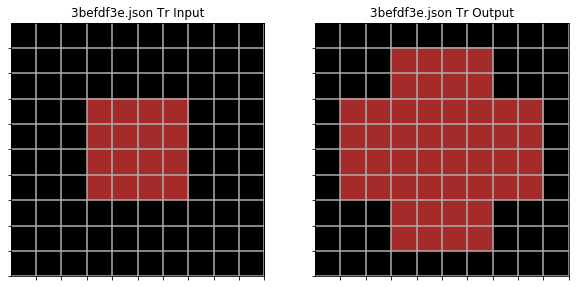

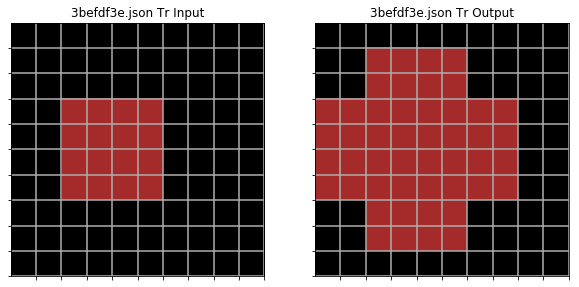

Expected Output


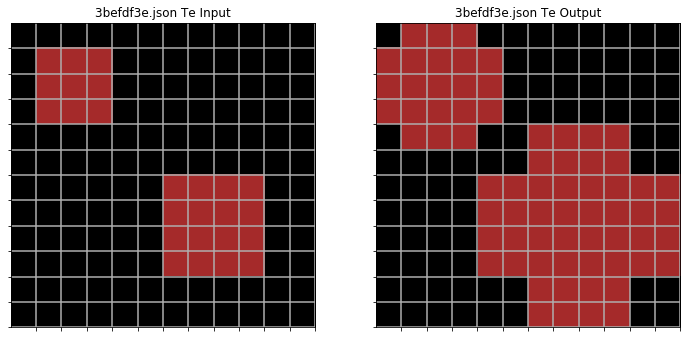

Actual Output


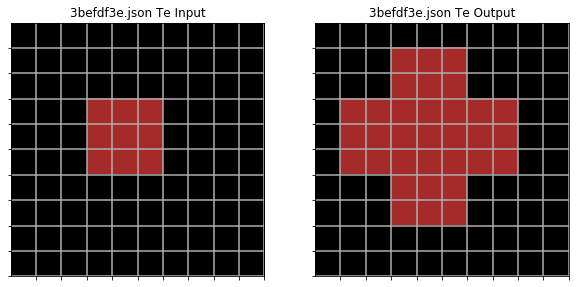

NN not able to solve the task
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 9., 9., 9., 0., 0., 0.],
          [0., 0., 0., 9., 9., 9., 9., 0., 0., 0.],
          [0., 0., 0., 9., 9., 9., 9., 0., 0., 0.],
          [0., 0., 0., 9., 9., 9., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 9., 9., 9., 0., 0., 0.],
          [0., 0., 0., 9., 9., 9., 9., 0., 0., 0.],
          [0., 9., 9., 9., 9., 9., 9., 9., 9., 0.],
          [0., 9., 9., 9., 9., 9., 9., 9., 9., 0.],
          [0., 9., 9., 9., 9., 9., 9., 9., 9., 0.],
          [0., 9., 9., 9., 9., 9., 9., 9., 9., 0.],
          [0., 0., 0., 9., 9., 9., 9., 0., 0., 0.],
 

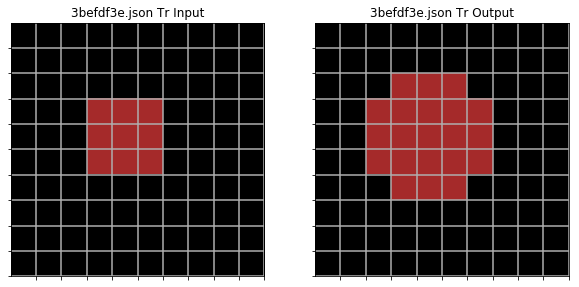

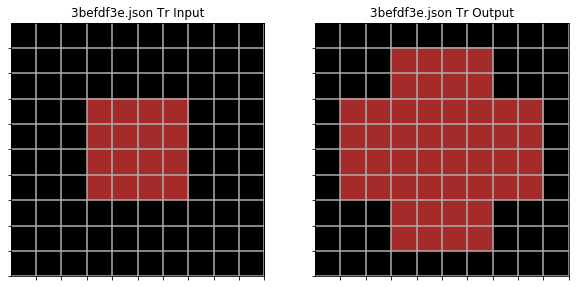

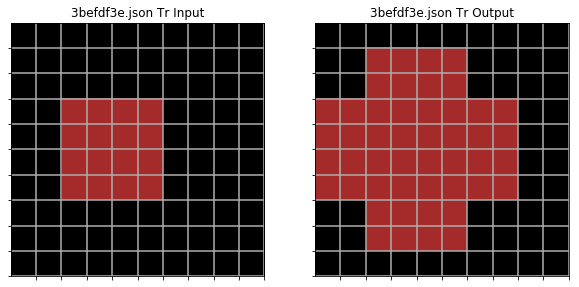

Expected Output


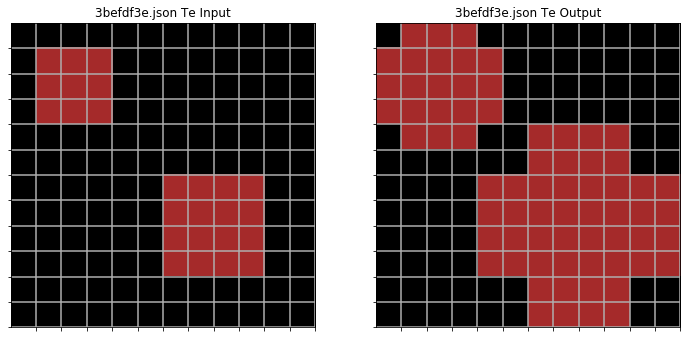

Actual Output


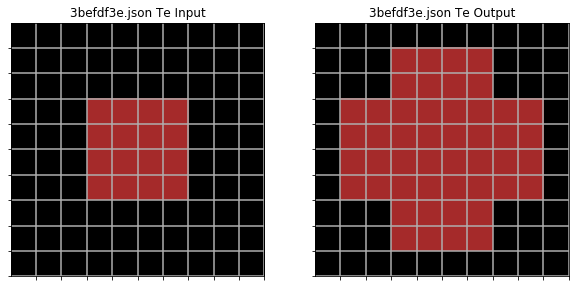

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 9., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 9., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 9., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 9., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 9., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 9., 0., 0., 0., 0.],
          [9., 9., 9., 9., 9., 9., 9., 9., 0., 0.],
          [9., 9., 9., 9., 9., 9., 9., 9., 0., 0.],
          [9., 9., 9., 9., 9., 9., 9., 9., 0., 0.],
          [9., 9., 9., 9., 9., 9., 9., 9., 0., 0.],
          [0., 0., 9., 9., 9., 9., 0., 0., 0., 0.],
     

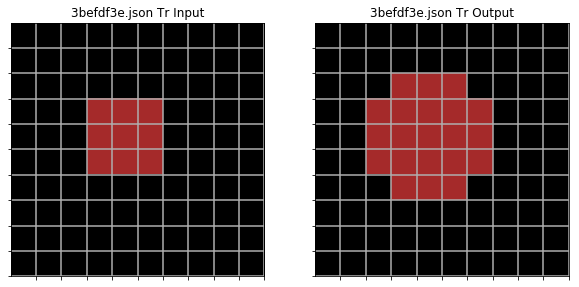

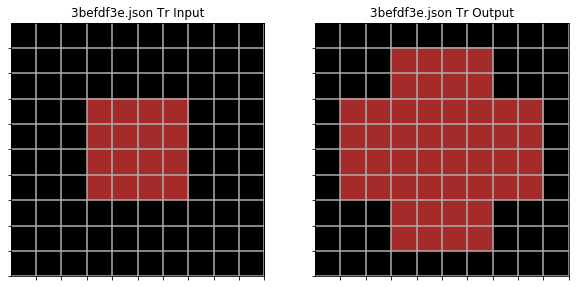

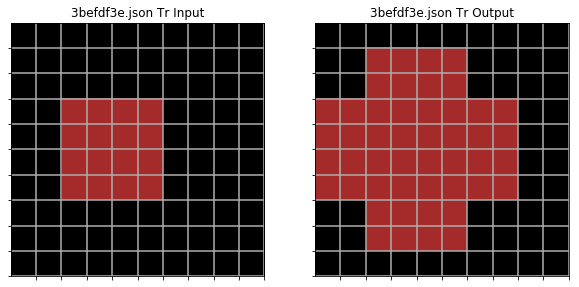

Expected Output


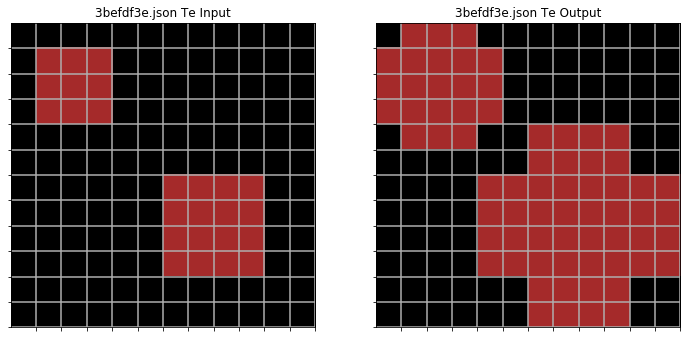

Actual Output


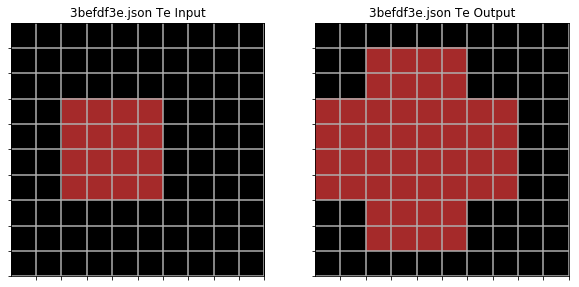

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 9., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 9., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 9., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 9., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0., 0.],
          [9., 9., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0.],
          [9., 9., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0.],
          [9., 9., 9., 9., 9., 0., 0., 0.

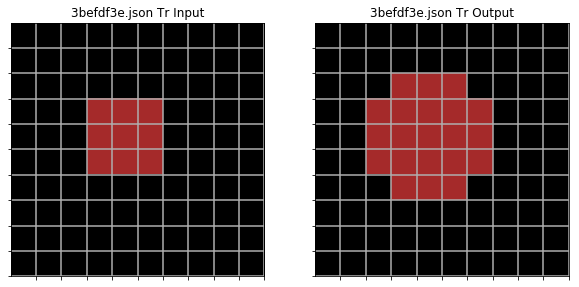

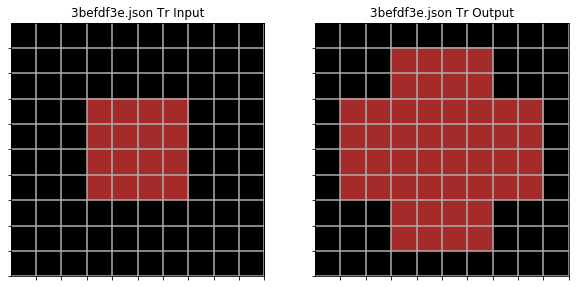

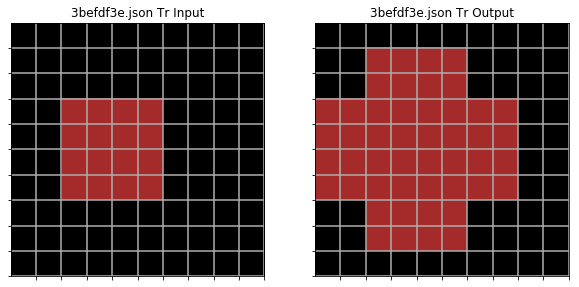

Expected Output


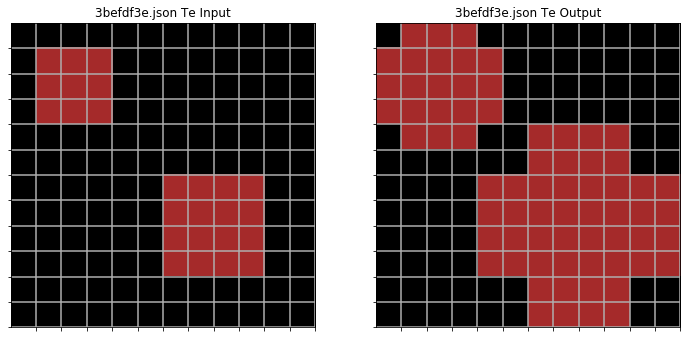

Actual Output


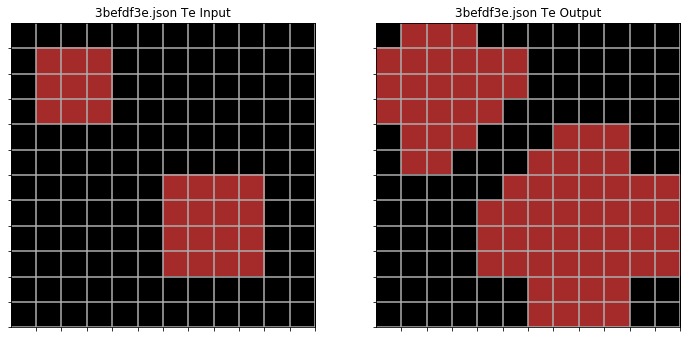

NN not able to solve the task


In [165]:
i = 23
ttm = TrainTestModel(ON=9, OFF=0, B = None, kernel_size=7,pad=3, reduction='none', loss_function_type='mse')
ttm.readData(onlyfiles_train[i], noAug=True)
ttm.train(epochs=1000, print_every=1, learning_rate=0.01, test_every=None)
ttm.test()
#Loss function: mse
#Status: Not solved bcz for 2 similar scenarios, differnt operation to be performed. Multi layer conv net might help

Augmentation is OFF.
epoch: 1, batch_id: 0, loss: 0.9352859854698181
[TRAIN] 0 elements matched out of 2 diff. elements.        Accuracy: 0.0. Overall Accuracy: 77.55101776123047
epoch: 1, batch_id: 1, loss: 0.9027658700942993
[TRAIN] 0 elements matched out of 3 diff. elements.        Accuracy: 0.0. Overall Accuracy: 77.55101776123047
epoch: 2, batch_id: 0, loss: 0.7124512195587158
[TRAIN] 0 elements matched out of 2 diff. elements.        Accuracy: 0.0. Overall Accuracy: 81.63265228271484
epoch: 2, batch_id: 1, loss: 0.6866238713264465
[TRAIN] 0 elements matched out of 3 diff. elements.        Accuracy: 0.0. Overall Accuracy: 79.59183502197266
epoch: 3, batch_id: 0, loss: 0.5894328951835632
[TRAIN] 0 elements matched out of 2 diff. elements.        Accuracy: 0.0. Overall Accuracy: 81.63265228271484
epoch: 3, batch_id: 1, loss: 0.5702928900718689
[TRAIN] 0 elements matched out of 3 diff. elements.        Accuracy: 0.0. Overall Accuracy: 81.63265228271484
epoch: 4, batch_id: 0, loss: 0.

epoch: 35, batch_id: 1, loss: 0.22776417434215546
[TRAIN] 0 elements matched out of 3 diff. elements.        Accuracy: 0.0. Overall Accuracy: 89.7959213256836
epoch: 36, batch_id: 0, loss: 0.22616158425807953
[TRAIN] 0 elements matched out of 2 diff. elements.        Accuracy: 0.0. Overall Accuracy: 95.91836547851562
epoch: 36, batch_id: 1, loss: 0.22604051232337952
[TRAIN] 0 elements matched out of 3 diff. elements.        Accuracy: 0.0. Overall Accuracy: 89.7959213256836
epoch: 37, batch_id: 0, loss: 0.22440102696418762
[TRAIN] 0 elements matched out of 2 diff. elements.        Accuracy: 0.0. Overall Accuracy: 95.91836547851562
epoch: 37, batch_id: 1, loss: 0.2243870198726654
[TRAIN] 0 elements matched out of 3 diff. elements.        Accuracy: 0.0. Overall Accuracy: 89.7959213256836
epoch: 38, batch_id: 0, loss: 0.2226974368095398
[TRAIN] 0 elements matched out of 2 diff. elements.        Accuracy: 0.0. Overall Accuracy: 95.91836547851562
epoch: 38, batch_id: 1, loss: 0.2227981090545

[TRAIN] 0 elements matched out of 3 diff. elements.        Accuracy: 0.0. Overall Accuracy: 87.7551040649414
epoch: 73, batch_id: 0, loss: 0.1813657581806183
[TRAIN] 0 elements matched out of 2 diff. elements.        Accuracy: 0.0. Overall Accuracy: 93.87754821777344
epoch: 73, batch_id: 1, loss: 0.1871044635772705
[TRAIN] 0 elements matched out of 3 diff. elements.        Accuracy: 0.0. Overall Accuracy: 87.7551040649414
epoch: 74, batch_id: 0, loss: 0.1804812252521515
[TRAIN] 0 elements matched out of 2 diff. elements.        Accuracy: 0.0. Overall Accuracy: 93.87754821777344
epoch: 74, batch_id: 1, loss: 0.18637411296367645
[TRAIN] 0 elements matched out of 3 diff. elements.        Accuracy: 0.0. Overall Accuracy: 87.7551040649414
epoch: 75, batch_id: 0, loss: 0.1796073317527771
[TRAIN] 0 elements matched out of 2 diff. elements.        Accuracy: 0.0. Overall Accuracy: 93.87754821777344
epoch: 75, batch_id: 1, loss: 0.18565262854099274
[TRAIN] 0 elements matched out of 3 diff. eleme

epoch: 116, batch_id: 0, loss: 0.15079890191555023
[TRAIN] 0 elements matched out of 2 diff. elements.        Accuracy: 0.0. Overall Accuracy: 93.87754821777344
epoch: 116, batch_id: 1, loss: 0.161528542637825
[TRAIN] 0 elements matched out of 3 diff. elements.        Accuracy: 0.0. Overall Accuracy: 91.83673095703125
epoch: 117, batch_id: 0, loss: 0.15022991597652435
[TRAIN] 0 elements matched out of 2 diff. elements.        Accuracy: 0.0. Overall Accuracy: 93.87754821777344
epoch: 117, batch_id: 1, loss: 0.16103973984718323
[TRAIN] 0 elements matched out of 3 diff. elements.        Accuracy: 0.0. Overall Accuracy: 91.83673095703125
epoch: 118, batch_id: 0, loss: 0.1496659815311432
[TRAIN] 0 elements matched out of 2 diff. elements.        Accuracy: 0.0. Overall Accuracy: 93.87754821777344
epoch: 118, batch_id: 1, loss: 0.16055452823638916
[TRAIN] 0 elements matched out of 3 diff. elements.        Accuracy: 0.0. Overall Accuracy: 91.83673095703125
epoch: 119, batch_id: 0, loss: 0.1491

epoch: 158, batch_id: 1, loss: 0.143706813454628
[TRAIN] 0 elements matched out of 3 diff. elements.        Accuracy: 0.0. Overall Accuracy: 91.83673095703125
epoch: 159, batch_id: 0, loss: 0.13014839589595795
[TRAIN] 0 elements matched out of 2 diff. elements.        Accuracy: 0.0. Overall Accuracy: 93.87754821777344
epoch: 159, batch_id: 1, loss: 0.1433400958776474
[TRAIN] 0 elements matched out of 3 diff. elements.        Accuracy: 0.0. Overall Accuracy: 91.83673095703125
epoch: 160, batch_id: 0, loss: 0.12974561750888824
[TRAIN] 0 elements matched out of 2 diff. elements.        Accuracy: 0.0. Overall Accuracy: 93.87754821777344
epoch: 160, batch_id: 1, loss: 0.14297573268413544
[TRAIN] 0 elements matched out of 3 diff. elements.        Accuracy: 0.0. Overall Accuracy: 91.83673095703125
epoch: 161, batch_id: 0, loss: 0.1293458342552185
[TRAIN] 0 elements matched out of 2 diff. elements.        Accuracy: 0.0. Overall Accuracy: 93.87754821777344
epoch: 161, batch_id: 1, loss: 0.14261

epoch: 201, batch_id: 0, loss: 0.11542145907878876
[TRAIN] 1 elements matched out of 2 diff. elements.        Accuracy: 50.0. Overall Accuracy: 95.91836547851562
epoch: 201, batch_id: 1, loss: 0.12976084649562836
[TRAIN] 1 elements matched out of 3 diff. elements.        Accuracy: 33.33333206176758. Overall Accuracy: 93.87754821777344
epoch: 202, batch_id: 0, loss: 0.11511801928281784
[TRAIN] 1 elements matched out of 2 diff. elements.        Accuracy: 50.0. Overall Accuracy: 95.91836547851562
epoch: 202, batch_id: 1, loss: 0.12947553396224976
[TRAIN] 1 elements matched out of 3 diff. elements.        Accuracy: 33.33333206176758. Overall Accuracy: 93.87754821777344
epoch: 203, batch_id: 0, loss: 0.11481641978025436
[TRAIN] 1 elements matched out of 2 diff. elements.        Accuracy: 50.0. Overall Accuracy: 95.91836547851562
epoch: 203, batch_id: 1, loss: 0.12919168174266815
[TRAIN] 1 elements matched out of 3 diff. elements.        Accuracy: 33.33333206176758. Overall Accuracy: 93.8775

[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 240, batch_id: 1, loss: 0.11967462301254272
[TRAIN] 1 elements matched out of 3 diff. elements.        Accuracy: 33.33333206176758. Overall Accuracy: 93.87754821777344
epoch: 241, batch_id: 0, loss: 0.10459485650062561
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 241, batch_id: 1, loss: 0.11944130808115005
[TRAIN] 1 elements matched out of 3 diff. elements.        Accuracy: 33.33333206176758. Overall Accuracy: 93.87754821777344
epoch: 242, batch_id: 0, loss: 0.10435472428798676
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 242, batch_id: 1, loss: 0.11920929700136185
[TRAIN] 2 elements matched out of 3 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 97.95918273925781
epoch: 243, batch_id: 0, loss: 0.10411597043275833
[TRAIN] 2 elements mat

epoch: 279, batch_id: 0, loss: 0.09631122648715973
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 279, batch_id: 1, loss: 0.1113516166806221
[TRAIN] 2 elements matched out of 3 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 97.95918273925781
epoch: 280, batch_id: 0, loss: 0.09611428529024124
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 280, batch_id: 1, loss: 0.11115725338459015
[TRAIN] 2 elements matched out of 3 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 97.95918273925781
epoch: 281, batch_id: 0, loss: 0.09591836482286453
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 281, batch_id: 1, loss: 0.11096369475126266
[TRAIN] 2 elements matched out of 3 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 97.95918273925781
epoch: 282, batch_id: 0

[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 319, batch_id: 1, loss: 0.10419556498527527
[TRAIN] 2 elements matched out of 3 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 97.95918273925781
epoch: 320, batch_id: 0, loss: 0.08896192163228989
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 320, batch_id: 1, loss: 0.10403158515691757
[TRAIN] 2 elements matched out of 3 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 97.95918273925781
epoch: 321, batch_id: 0, loss: 0.08879944682121277
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 321, batch_id: 1, loss: 0.10386825352907181
[TRAIN] 2 elements matched out of 3 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 97.95918273925781
epoch: 322, batch_id: 0, loss: 0.08863779157400131
[TRAIN] 2 elements mat

epoch: 359, batch_id: 1, loss: 0.09811626374721527
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 360, batch_id: 0, loss: 0.08298362046480179
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 360, batch_id: 1, loss: 0.09797591716051102
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 361, batch_id: 0, loss: 0.08284663408994675
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 361, batch_id: 1, loss: 0.09783611446619034
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 362, batch_id: 0, loss: 0.08271025866270065
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 362, batch_id: 1, loss: 0.09769683331251144
[TRAIN] 3 elements matched out of 3 diff. e

epoch: 401, batch_id: 0, loss: 0.0777900442481041
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 401, batch_id: 1, loss: 0.09263906627893448
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 402, batch_id: 0, loss: 0.07767333090305328
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 402, batch_id: 1, loss: 0.09251827001571655
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 403, batch_id: 0, loss: 0.0775570496916771
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 403, batch_id: 1, loss: 0.09239793568849564
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 404, batch_id: 0, loss: 0.07744120061397552
[TRAIN] 2 elements matched out of 2 diff. ele

[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 442, batch_id: 0, loss: 0.07333646714687347
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 442, batch_id: 1, loss: 0.08800394833087921
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 443, batch_id: 0, loss: 0.07323569804430008
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 443, batch_id: 1, loss: 0.08789844810962677
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 444, batch_id: 0, loss: 0.07313527911901474
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 444, batch_id: 1, loss: 0.08779328316450119
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 

[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 480, batch_id: 0, loss: 0.06973709166049957
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 480, batch_id: 1, loss: 0.08421655744314194
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 481, batch_id: 0, loss: 0.06964832544326782
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 481, batch_id: 1, loss: 0.0841226652264595
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 482, batch_id: 0, loss: 0.06955984234809875
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 482, batch_id: 1, loss: 0.08402906358242035
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 1

[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 519, batch_id: 1, loss: 0.08074960112571716
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 520, batch_id: 0, loss: 0.0663953423500061
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 520, batch_id: 1, loss: 0.08066564798355103
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 521, batch_id: 0, loss: 0.06631693989038467
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 521, batch_id: 1, loss: 0.08058197051286697
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 522, batch_id: 0, loss: 0.06623878329992294
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 1

epoch: 559, batch_id: 0, loss: 0.06350257247686386
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 559, batch_id: 1, loss: 0.07756370306015015
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 560, batch_id: 0, loss: 0.06343252956867218
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 560, batch_id: 1, loss: 0.07748833298683167
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 561, batch_id: 0, loss: 0.06336278468370438
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 561, batch_id: 1, loss: 0.07741313427686691
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 562, batch_id: 0, loss: 0.06329318881034851
[TRAIN] 2 elements matched out of 2 diff. e

[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 600, batch_id: 0, loss: 0.06078576669096947
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 600, batch_id: 1, loss: 0.07462557405233383
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 601, batch_id: 0, loss: 0.06072317436337471
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 601, batch_id: 1, loss: 0.0745575800538063
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 602, batch_id: 0, loss: 0.06066081300377846
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 602, batch_id: 1, loss: 0.07448979467153549
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 1

epoch: 641, batch_id: 0, loss: 0.05834875628352165
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 641, batch_id: 1, loss: 0.07196854799985886
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 642, batch_id: 0, loss: 0.05829247087240219
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 642, batch_id: 1, loss: 0.07190689444541931
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 643, batch_id: 0, loss: 0.058236267417669296
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 643, batch_id: 1, loss: 0.0718453899025917
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 644, batch_id: 0, loss: 0.05818022042512894
[TRAIN] 2 elements matched out of 2 diff. e

[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 681, batch_id: 1, loss: 0.06960807740688324
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 682, batch_id: 0, loss: 0.05614883452653885
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 682, batch_id: 1, loss: 0.0695517286658287
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 683, batch_id: 0, loss: 0.05609780550003052
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 683, batch_id: 1, loss: 0.06949545443058014
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 684, batch_id: 0, loss: 0.0560469813644886
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 10

epoch: 719, batch_id: 1, loss: 0.06754916906356812
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 720, batch_id: 0, loss: 0.0542914979159832
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 720, batch_id: 1, loss: 0.06749717891216278
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 721, batch_id: 0, loss: 0.0542447604238987
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 721, batch_id: 1, loss: 0.0674453154206276
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 722, batch_id: 0, loss: 0.05419807881116867
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 722, batch_id: 1, loss: 0.06739354878664017
[TRAIN] 3 elements matched out of 3 diff. elem

[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 748, batch_id: 0, loss: 0.05302100628614426
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 748, batch_id: 1, loss: 0.066084124147892
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 749, batch_id: 0, loss: 0.05297704041004181
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 749, batch_id: 1, loss: 0.06603513658046722
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 750, batch_id: 0, loss: 0.052933186292648315
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 750, batch_id: 1, loss: 0.06598621606826782
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 1

epoch: 811, batch_id: 0, loss: 0.05042487382888794
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 811, batch_id: 1, loss: 0.06317654252052307
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 812, batch_id: 0, loss: 0.05038633570075035
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 812, batch_id: 1, loss: 0.06313316524028778
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 813, batch_id: 0, loss: 0.05034780502319336
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 813, batch_id: 1, loss: 0.06308983266353607
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 814, batch_id: 0, loss: 0.0503094345331192
[TRAIN] 2 elements matched out of 2 diff. el

[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 848, batch_id: 1, loss: 0.06162238493561745
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 849, batch_id: 0, loss: 0.04901152849197388
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 849, batch_id: 1, loss: 0.061581775546073914
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 850, batch_id: 0, loss: 0.04897572100162506
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 850, batch_id: 1, loss: 0.06154128909111023
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 851, batch_id: 0, loss: 0.04893997311592102
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy:

epoch: 886, batch_id: 0, loss: 0.04773068428039551
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 886, batch_id: 1, loss: 0.06012905761599541
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 887, batch_id: 0, loss: 0.047697290778160095
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 887, batch_id: 1, loss: 0.06009109318256378
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 888, batch_id: 0, loss: 0.04766392707824707
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 888, batch_id: 1, loss: 0.06005316972732544
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 889, batch_id: 0, loss: 0.04763064160943031
[TRAIN] 2 elements matched out of 2 diff. 

epoch: 924, batch_id: 0, loss: 0.04650266468524933
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 924, batch_id: 1, loss: 0.0587293915450573
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 925, batch_id: 0, loss: 0.04647145792841911
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 925, batch_id: 1, loss: 0.058693740516901016
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 926, batch_id: 0, loss: 0.04644033685326576
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 926, batch_id: 1, loss: 0.058658141642808914
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 927, batch_id: 0, loss: 0.046409253031015396
[TRAIN] 2 elements matched out of 2 diff.

[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 960, batch_id: 0, loss: 0.04541276395320892
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 960, batch_id: 1, loss: 0.057481326162815094
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 961, batch_id: 0, loss: 0.04538344964385033
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 961, batch_id: 1, loss: 0.057447660714387894
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 962, batch_id: 0, loss: 0.04535417631268501
[TRAIN] 2 elements matched out of 2 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 962, batch_id: 1, loss: 0.05741408094763756
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy

epoch: 1000, batch_id: 1, loss: 0.05617498233914375
[TRAIN] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 0., 0., 0., 0., 0.],
          [0., 9., 9., 0., 0., 0., 0.],
          [0., 0., 0., 0., 9., 9., 0.],
          [0., 0., 0., 0., 0., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 0., 0., 0., 0.],
          [0., 9., 9., 0., 0., 0., 0.],
          [0., 0., 0., 0., 9., 9., 0.],
          [0., 0., 0., 0., 9., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]]])
pred   op grid tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 0., 0., 0., 0.],
          [0., 9., 9., 0., 0., 0., 0.],
          [0., 0., 0., 0., 9., 9., 0.],
          [0., 0., 0., 0., 9., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0.

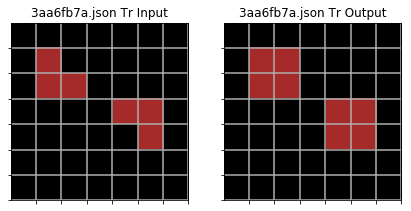

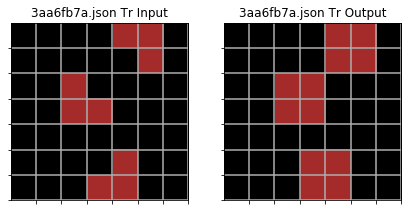

Expected Output


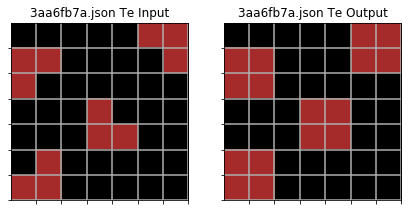

Actual Output


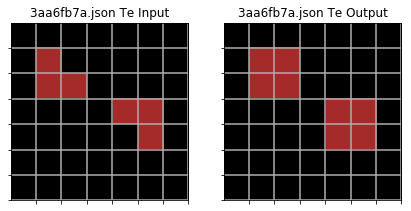

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 9., 9., 0.],
          [0., 0., 0., 0., 0., 9., 0.],
          [0., 0., 9., 0., 0., 0., 0.],
          [0., 0., 9., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 9., 0., 0.],
          [0., 0., 0., 9., 9., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 9., 9., 0.],
          [0., 0., 0., 0., 9., 9., 0.],
          [0., 0., 9., 9., 0., 0., 0.],
          [0., 0., 9., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 9., 0., 0.],
          [0., 0., 0., 9., 9., 0., 0.]]]])
pred   op grid tensor([[[[0., 0., 0., 0., 9., 9., 0.],
          [0., 0., 0., 0., 9., 9., 0.],
          [0., 0., 9., 9., 0., 0., 0.],
          [0., 0., 9., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 9., 0., 0.],
          [0., 0., 0., 9., 9., 0., 0.]]]])
[TEST] 3 elements matched out of 3 diff. elements.        Accuracy: 100.0. Overa

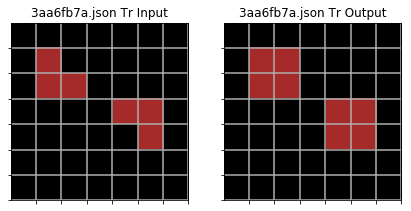

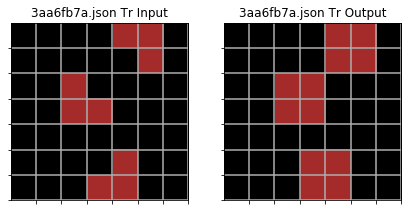

Expected Output


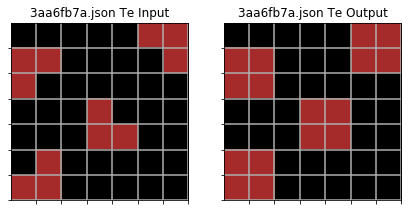

Actual Output


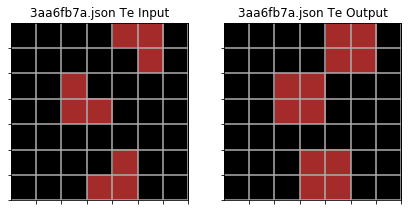

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 9., 9.],
          [9., 9., 0., 0., 0., 0., 9.],
          [9., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 9., 9., 0., 0.],
          [0., 9., 0., 0., 0., 0., 0.],
          [9., 9., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 9., 9.],
          [9., 9., 0., 0., 0., 9., 9.],
          [9., 9., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 9., 0., 0.],
          [0., 0., 0., 9., 9., 0., 0.],
          [9., 9., 0., 0., 0., 0., 0.],
          [9., 9., 0., 0., 0., 0., 0.]]]])
pred   op grid tensor([[[[0., 0., 0., 0., 0., 9., 9.],
          [9., 9., 0., 0., 0., 9., 9.],
          [9., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 9., 0., 0.],
          [0., 0., 0., 9., 9., 0., 0.],
          [9., 9., 0., 0., 0., 0., 0.],
          [9., 9., 0., 0., 0., 0., 0.]]]])
[TEST] 3 elements matched out of 4 diff. elements.        Accuracy: 75.0. Overal

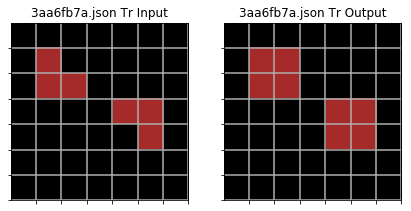

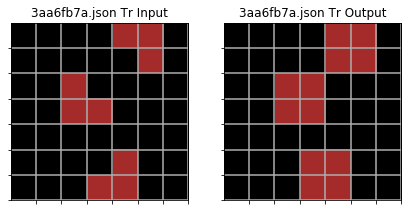

Expected Output


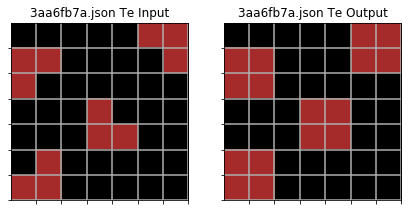

Actual Output


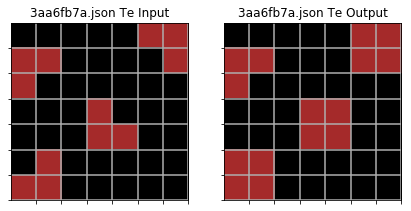

NN not able to solve the task


In [160]:
i = 19
ttm = TrainTestModel(ON=9, OFF=0, B = None, kernel_size=3,pad=1, reduction='none', loss_function_type='mse')
ttm.readData(onlyfiles_train[i], noAug=True)
ttm.train(epochs=1000, print_every=1, learning_rate=0.01, test_every=None)
ttm.test()
#Loss function: mse loss function
#Status: Not solved because it observer top left kind of pattern in input

Augmentation is OFF.
epoch: 1, batch_id: 0, loss: 1.0532900094985962
[TRAIN] 4 elements matched out of 24 diff. elements.        Accuracy: 16.66666603088379. Overall Accuracy: 69.44444274902344
epoch: 1, batch_id: 1, loss: 1.0413086414337158
[TRAIN] 4 elements matched out of 24 diff. elements.        Accuracy: 16.66666603088379. Overall Accuracy: 68.75
epoch: 2, batch_id: 0, loss: 1.0142567157745361
[TRAIN] 4 elements matched out of 24 diff. elements.        Accuracy: 16.66666603088379. Overall Accuracy: 69.44444274902344
epoch: 2, batch_id: 1, loss: 1.0034430027008057
[TRAIN] 4 elements matched out of 24 diff. elements.        Accuracy: 16.66666603088379. Overall Accuracy: 68.75
epoch: 3, batch_id: 0, loss: 0.9777672290802002
[TRAIN] 4 elements matched out of 24 diff. elements.        Accuracy: 16.66666603088379. Overall Accuracy: 69.44444274902344
epoch: 3, batch_id: 1, loss: 0.9680984020233154
[TRAIN] 4 elements matched out of 24 diff. elements.        Accuracy: 16.66666603088379. O

epoch: 35, batch_id: 1, loss: 0.5389144420623779
[TRAIN] 12 elements matched out of 24 diff. elements.        Accuracy: 50.0. Overall Accuracy: 85.41666412353516
epoch: 36, batch_id: 0, loss: 0.5353102087974548
[TRAIN] 12 elements matched out of 24 diff. elements.        Accuracy: 50.0. Overall Accuracy: 86.11111450195312
epoch: 36, batch_id: 1, loss: 0.534163773059845
[TRAIN] 12 elements matched out of 24 diff. elements.        Accuracy: 50.0. Overall Accuracy: 85.41666412353516
epoch: 37, batch_id: 0, loss: 0.5308021306991577
[TRAIN] 12 elements matched out of 24 diff. elements.        Accuracy: 50.0. Overall Accuracy: 86.11111450195312
epoch: 37, batch_id: 1, loss: 0.529589056968689
[TRAIN] 12 elements matched out of 24 diff. elements.        Accuracy: 50.0. Overall Accuracy: 86.80555725097656
epoch: 38, batch_id: 0, loss: 0.5264584422111511
[TRAIN] 12 elements matched out of 24 diff. elements.        Accuracy: 50.0. Overall Accuracy: 86.80555725097656
epoch: 38, batch_id: 1, loss: 

epoch: 72, batch_id: 0, loss: 0.43271690607070923
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 94.44444274902344
epoch: 72, batch_id: 1, loss: 0.43008407950401306
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 94.44444274902344
epoch: 73, batch_id: 0, loss: 0.430843710899353
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 94.44444274902344
epoch: 73, batch_id: 1, loss: 0.42819565534591675
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 94.44444274902344
epoch: 74, batch_id: 0, loss: 0.42899829149246216
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 94.44444274902344
epoch: 74, batch_id: 1, loss: 0.42633622884750366
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 6

[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 93.05555725097656
epoch: 116, batch_id: 0, loss: 0.36901021003723145
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 91.66666412353516
epoch: 116, batch_id: 1, loss: 0.3662766218185425
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 93.05555725097656
epoch: 117, batch_id: 0, loss: 0.3678700625896454
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 91.66666412353516
epoch: 117, batch_id: 1, loss: 0.365141361951828
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 93.05555725097656
epoch: 118, batch_id: 0, loss: 0.36673876643180847
[TRAIN] 16 elements matched out of 24 diff. elements.        Accuracy: 66.66666412353516. Overall Accuracy: 91.66666412

[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 156, batch_id: 1, loss: 0.3270324468612671
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 157, batch_id: 0, loss: 0.3286326229572296
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 157, batch_id: 1, loss: 0.326183557510376
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 158, batch_id: 0, loss: 0.32778069376945496
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 158, batch_id: 1, loss: 0.325339674949646
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 159, batch_id: 0, loss: 0.326934278011322
[TRAIN] 18 elements matc

[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 198, batch_id: 0, loss: 0.2974100112915039
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 198, batch_id: 1, loss: 0.29528647661209106
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 199, batch_id: 0, loss: 0.2967304587364197
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 199, batch_id: 1, loss: 0.2946144938468933
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 200, batch_id: 0, loss: 0.29605424404144287
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 200, batch_id: 1, loss: 0.29394614696502686
[TRAIN] 18 elements

epoch: 236, batch_id: 1, loss: 0.27189871668815613
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 237, batch_id: 0, loss: 0.2731729745864868
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 237, batch_id: 1, loss: 0.27133679389953613
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 238, batch_id: 0, loss: 0.2726063132286072
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 238, batch_id: 1, loss: 0.2707774043083191
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 94.44444274902344
epoch: 239, batch_id: 0, loss: 0.2720421552658081
[TRAIN] 18 elements matched out of 24 diff. elements.        Accuracy: 75.0. Overall Accuracy: 93.05555725097656
epoch: 239, batch_id

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 277, batch_id: 0, loss: 0.25227805972099304
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 277, batch_id: 1, loss: 0.25070255994796753
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 278, batch_id: 0, loss: 0.25179818272590637
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 278, batch_id: 1, loss: 0.2502289116382599
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 279, batch_id: 0, loss: 0.2513200640678406
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 279, batch_id: 1, loss: 0.2497565746307373
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 317, batch_id: 1, loss: 0.2330912947654724
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 318, batch_id: 0, loss: 0.23402850329875946
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 318, batch_id: 1, loss: 0.23268373310565948
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 319, batch_id: 0, loss: 0.23361730575561523
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 319, batch_id: 1, loss: 0.23227760195732117
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 320, batch_id: 0, loss: 0.23320725560188293
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overa

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 359, batch_id: 1, loss: 0.2171488106250763
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 360, batch_id: 0, loss: 0.2179405838251114
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 360, batch_id: 1, loss: 0.21679671108722687
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 361, batch_id: 0, loss: 0.21758517622947693
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 361, batch_id: 1, loss: 0.21644553542137146
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 362, batch_id: 0, loss: 0.2172309011220932
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall

epoch: 400, batch_id: 1, loss: 0.20360782742500305
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 401, batch_id: 0, loss: 0.2042778730392456
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 401, batch_id: 1, loss: 0.2032993584871292
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 402, batch_id: 0, loss: 0.20396654307842255
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 402, batch_id: 1, loss: 0.2029915452003479
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 403, batch_id: 0, loss: 0.2036558836698532
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 403, batch_id: 1, loss: 0.20268484950065613
[TRAIN] 24 elements matched out of 

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 439, batch_id: 1, loss: 0.19224557280540466
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 440, batch_id: 0, loss: 0.19281665980815887
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 440, batch_id: 1, loss: 0.1919715255498886
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 441, batch_id: 0, loss: 0.19253984093666077
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 441, batch_id: 1, loss: 0.19169823825359344
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 442, batch_id: 0, loss: 0.19226449728012085
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overa

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 481, batch_id: 1, loss: 0.181385338306427
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 482, batch_id: 0, loss: 0.18186625838279724
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 482, batch_id: 1, loss: 0.1811423897743225
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 483, batch_id: 0, loss: 0.18162128329277039
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 483, batch_id: 1, loss: 0.18089982867240906
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 484, batch_id: 0, loss: 0.1813766360282898
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall 

epoch: 524, batch_id: 0, loss: 0.17212945222854614
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 524, batch_id: 1, loss: 0.17150633037090302
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 525, batch_id: 0, loss: 0.17191074788570404
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 525, batch_id: 1, loss: 0.17128998041152954
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 526, batch_id: 0, loss: 0.1716928482055664
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 526, batch_id: 1, loss: 0.17107391357421875
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 527, batch_id: 0, loss: 0.17147499322891235
[TRAIN] 24 elements matched out 

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 568, batch_id: 0, loss: 0.16302573680877686
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 568, batch_id: 1, loss: 0.16249018907546997
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 569, batch_id: 0, loss: 0.16283032298088074
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 569, batch_id: 1, loss: 0.1622968316078186
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 570, batch_id: 0, loss: 0.16263550519943237
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 570, batch_id: 1, loss: 0.1621037870645523
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overal

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 611, batch_id: 1, loss: 0.15458492934703827
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 612, batch_id: 0, loss: 0.1548738330602646
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 612, batch_id: 1, loss: 0.15441058576107025
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 613, batch_id: 0, loss: 0.15469832718372345
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 613, batch_id: 1, loss: 0.15423673391342163
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 614, batch_id: 0, loss: 0.15452341735363007
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overa

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 653, batch_id: 1, loss: 0.14760349690914154
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 654, batch_id: 0, loss: 0.14785176515579224
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 654, batch_id: 1, loss: 0.14744538068771362
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 655, batch_id: 0, loss: 0.14769259095191956
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 655, batch_id: 1, loss: 0.14728747308254242
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 656, batch_id: 0, loss: 0.14753404259681702
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Over

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 696, batch_id: 1, loss: 0.1411101073026657
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 697, batch_id: 0, loss: 0.14132481813430786
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 697, batch_id: 1, loss: 0.14096640050411224
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 698, batch_id: 0, loss: 0.14118029177188873
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 698, batch_id: 1, loss: 0.14082275331020355
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 699, batch_id: 0, loss: 0.1410360187292099
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overal

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 740, batch_id: 1, loss: 0.13506074249744415
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 741, batch_id: 0, loss: 0.13524839282035828
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 741, batch_id: 1, loss: 0.1349295824766159
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 742, batch_id: 0, loss: 0.1351165622472763
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 742, batch_id: 1, loss: 0.13479864597320557
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 743, batch_id: 0, loss: 0.13498519361019135
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overal

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 784, batch_id: 0, loss: 0.12982311844825745
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 784, batch_id: 1, loss: 0.1295360028743744
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 785, batch_id: 0, loss: 0.12970252335071564
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 785, batch_id: 1, loss: 0.1294160634279251
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 786, batch_id: 0, loss: 0.12958206236362457
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 786, batch_id: 1, loss: 0.12929625809192657
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overal

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 827, batch_id: 0, loss: 0.12484310567378998
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 827, batch_id: 1, loss: 0.12458118051290512
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 828, batch_id: 0, loss: 0.12473195046186447
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 828, batch_id: 1, loss: 0.12447064369916916
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 829, batch_id: 0, loss: 0.12462125718593597
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 829, batch_id: 1, loss: 0.12436045706272125
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Over

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 869, batch_id: 1, loss: 0.12011592835187912
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 870, batch_id: 0, loss: 0.12025543302297592
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 870, batch_id: 1, loss: 0.12001368403434753
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 871, batch_id: 0, loss: 0.12015310674905777
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 871, batch_id: 1, loss: 0.1199118047952652
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 872, batch_id: 0, loss: 0.12005089223384857
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overa

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 914, batch_id: 1, loss: 0.11569556593894958
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 915, batch_id: 0, loss: 0.11582662165164948
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 915, batch_id: 1, loss: 0.11560123413801193
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 916, batch_id: 0, loss: 0.11573226004838943
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 916, batch_id: 1, loss: 0.11550720781087875
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 917, batch_id: 0, loss: 0.11563796550035477
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Over

epoch: 958, batch_id: 0, loss: 0.11191096901893616
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 958, batch_id: 1, loss: 0.11169738322496414
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 959, batch_id: 0, loss: 0.11182316392660141
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 959, batch_id: 1, loss: 0.11160998791456223
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 960, batch_id: 0, loss: 0.11173568665981293
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 960, batch_id: 1, loss: 0.11152258515357971
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 961, batch_id: 0, loss: 0.1116483062505722
[TRAIN] 24 elements matched out 

actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [9., 0., 9., 0., 9., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0., 0.],
          [9., 9., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0., 0.],
          [9., 0., 9., 0., 9., 0., 9., 0., 9., 0., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 9., 9., 9., 9., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 9., 0., 9., 0., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
pred   op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [9., 0., 9., 0., 9., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0., 0.],
          [9., 9., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0.],
       

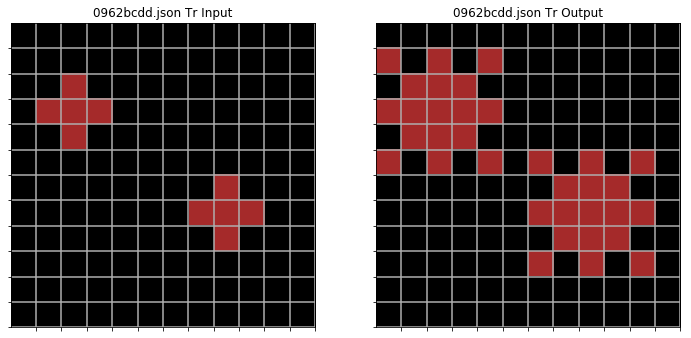

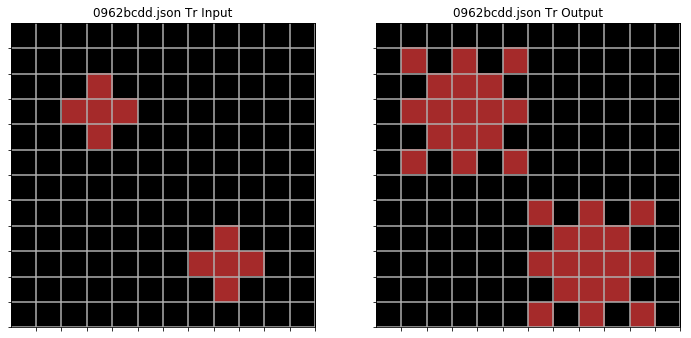

Expected Output


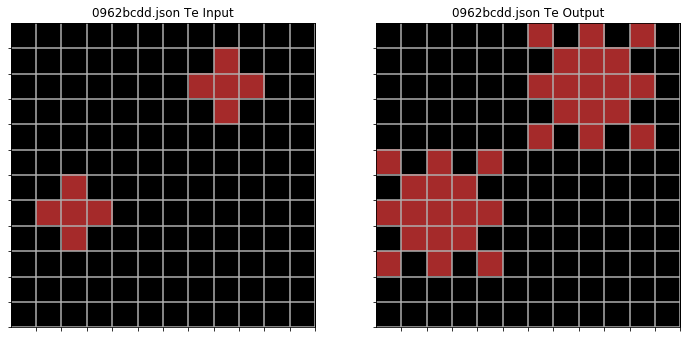

Actual Output


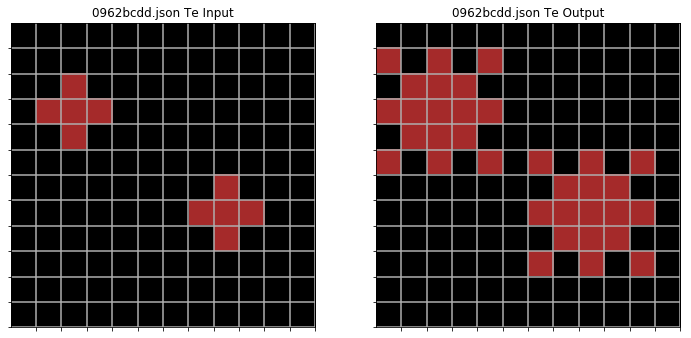

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 0., 9., 0., 9., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 9., 9., 0., 0.

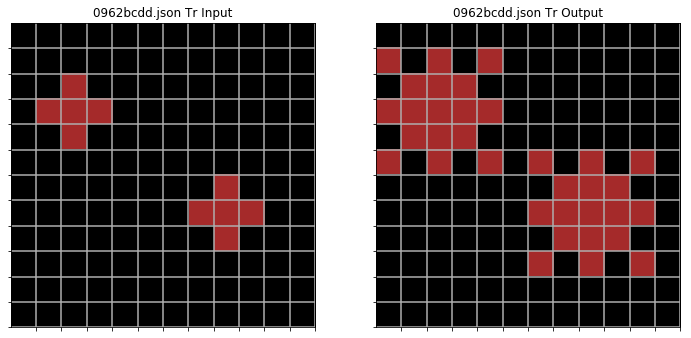

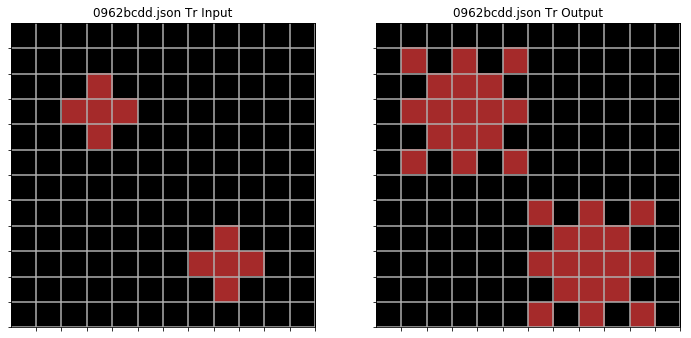

Expected Output


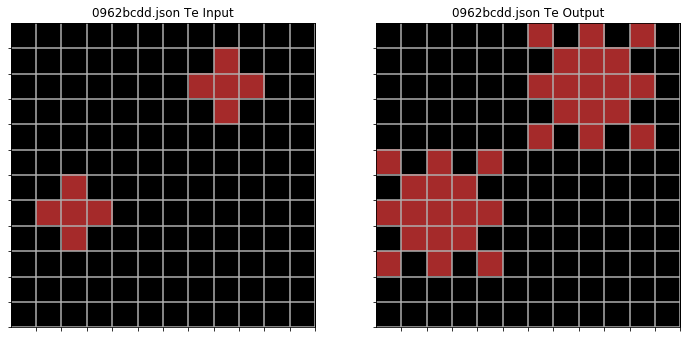

Actual Output


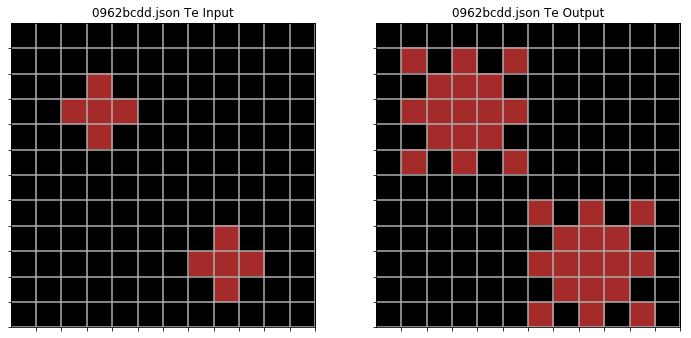

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 9., 9., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 9., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 9., 0., 9., 0., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 9., 9., 0., 0.],
          [0., 0., 0., 0., 0., 0., 9., 9., 9., 9., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9.

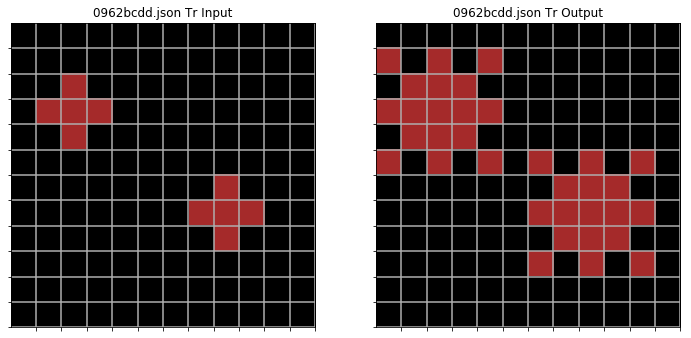

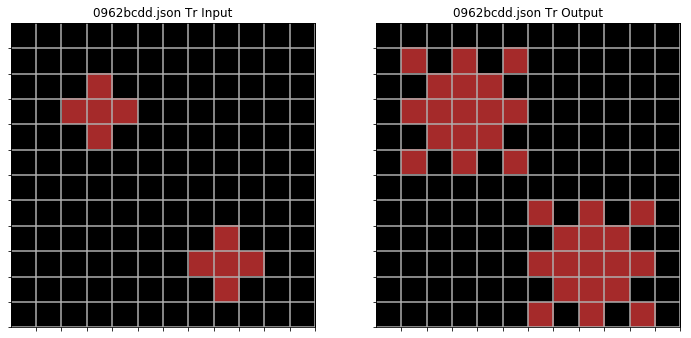

Expected Output


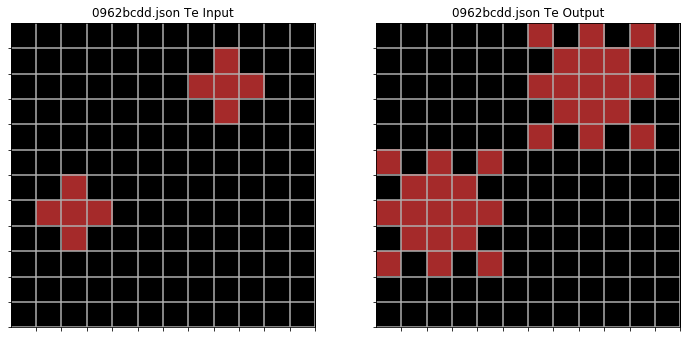

Actual Output


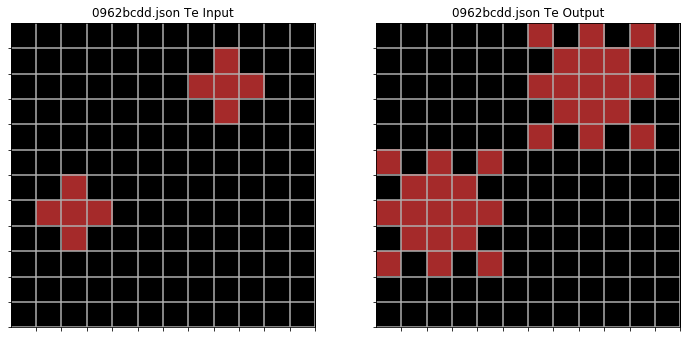

Task successfully solved.


In [148]:
i = 4
ttm = TrainTestModel(ON=9, OFF=0, B = None, kernel_size=5,pad=2, reduction='mean')
ttm.readData(onlyfiles_train[i], noAug=True)
ttm.train(epochs=1000, print_every=1, learning_rate=0.01, test_every=None)
ttm.test()
#Loss function: simple mean bce (no squaring)
#Status: Succesfully solved

Augmentation is OFF.
epoch: 1, batch_id: 0, loss: 0.7445052862167358
[TRAIN] 9 elements matched out of 24 diff. elements.        Accuracy: 37.5. Overall Accuracy: 81.48148345947266
epoch: 1, batch_id: 1, loss: 0.7812961339950562
[TRAIN] 12 elements matched out of 32 diff. elements.        Accuracy: 37.5. Overall Accuracy: 75.30863952636719
epoch: 2, batch_id: 0, loss: 0.7359575629234314
[TRAIN] 9 elements matched out of 24 diff. elements.        Accuracy: 37.5. Overall Accuracy: 81.48148345947266
epoch: 2, batch_id: 1, loss: 0.7702404260635376
[TRAIN] 12 elements matched out of 32 diff. elements.        Accuracy: 37.5. Overall Accuracy: 75.30863952636719
epoch: 3, batch_id: 0, loss: 0.7275826930999756
[TRAIN] 9 elements matched out of 24 diff. elements.        Accuracy: 37.5. Overall Accuracy: 81.48148345947266
epoch: 3, batch_id: 1, loss: 0.7594190239906311
[TRAIN] 12 elements matched out of 32 diff. elements.        Accuracy: 37.5. Overall Accuracy: 75.30863952636719
epoch: 4, batch_

epoch: 41, batch_id: 0, loss: 0.517879843711853
[TRAIN] 21 elements matched out of 24 diff. elements.        Accuracy: 87.5. Overall Accuracy: 96.29629516601562
epoch: 41, batch_id: 1, loss: 0.49605128169059753
[TRAIN] 28 elements matched out of 32 diff. elements.        Accuracy: 87.5. Overall Accuracy: 95.06172943115234
epoch: 42, batch_id: 0, loss: 0.5145233273506165
[TRAIN] 21 elements matched out of 24 diff. elements.        Accuracy: 87.5. Overall Accuracy: 96.29629516601562
epoch: 42, batch_id: 1, loss: 0.49205291271209717
[TRAIN] 28 elements matched out of 32 diff. elements.        Accuracy: 87.5. Overall Accuracy: 95.06172943115234
epoch: 43, batch_id: 0, loss: 0.5112402439117432
[TRAIN] 21 elements matched out of 24 diff. elements.        Accuracy: 87.5. Overall Accuracy: 96.29629516601562
epoch: 43, batch_id: 1, loss: 0.488153338432312
[TRAIN] 28 elements matched out of 32 diff. elements.        Accuracy: 87.5. Overall Accuracy: 95.06172943115234
epoch: 44, batch_id: 0, loss

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 81, batch_id: 1, loss: 0.3879278898239136
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 82, batch_id: 0, loss: 0.42050227522850037
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 82, batch_id: 1, loss: 0.38609015941619873
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 83, batch_id: 0, loss: 0.41878414154052734
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 83, batch_id: 1, loss: 0.38427847623825073
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 84, batch_id: 0, loss: 0.41708505153656006
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Acc

epoch: 123, batch_id: 1, loss: 0.326620876789093
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 124, batch_id: 0, loss: 0.3606168031692505
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 124, batch_id: 1, loss: 0.3254470229148865
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 125, batch_id: 0, loss: 0.3594207763671875
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 125, batch_id: 1, loss: 0.32428252696990967
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 126, batch_id: 0, loss: 0.3582328259944916
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 126, batch_id: 1, loss: 0.3231273591518402
[TRAIN] 32 elements matched out of 32 

[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 164, batch_id: 0, loss: 0.3181644380092621
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 164, batch_id: 1, loss: 0.28495678305625916
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 165, batch_id: 0, loss: 0.31722405552864075
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 165, batch_id: 1, loss: 0.28407707810401917
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 166, batch_id: 0, loss: 0.3162889778614044
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 166, batch_id: 1, loss: 0.2832026183605194
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall

[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 197, batch_id: 0, loss: 0.28957802057266235
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 197, batch_id: 1, loss: 0.2584645450115204
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 198, batch_id: 0, loss: 0.28878331184387207
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 198, batch_id: 1, loss: 0.25773492455482483
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 199, batch_id: 0, loss: 0.2879926860332489
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 199, batch_id: 1, loss: 0.25700923800468445
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overal

epoch: 227, batch_id: 0, loss: 0.267305463552475
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 227, batch_id: 1, loss: 0.23812678456306458
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 228, batch_id: 0, loss: 0.26661473512649536
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 228, batch_id: 1, loss: 0.23749971389770508
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 229, batch_id: 0, loss: 0.26592761278152466
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 229, batch_id: 1, loss: 0.23687565326690674
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 230, batch_id: 0, loss: 0.2652432322502136
[TRAIN] 24 elements matched out of

[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 256, batch_id: 0, loss: 0.24847395718097687
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 256, batch_id: 1, loss: 0.2210880070924759
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 257, batch_id: 0, loss: 0.24786607921123505
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 257, batch_id: 1, loss: 0.22053998708724976
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 258, batch_id: 0, loss: 0.24726079404354095
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 258, batch_id: 1, loss: 0.21999448537826538
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overa

epoch: 282, batch_id: 1, loss: 0.2075960785150528
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 283, batch_id: 0, loss: 0.23292779922485352
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 283, batch_id: 1, loss: 0.2071067839860916
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 284, batch_id: 0, loss: 0.23238471150398254
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 284, batch_id: 1, loss: 0.20661967992782593
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 285, batch_id: 0, loss: 0.23184385895729065
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 285, batch_id: 1, loss: 0.20613446831703186
[TRAIN] 32 elements matched out o

epoch: 320, batch_id: 0, loss: 0.21421903371810913
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 320, batch_id: 1, loss: 0.19036200642585754
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 321, batch_id: 0, loss: 0.2137502282857895
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 321, batch_id: 1, loss: 0.18994317948818207
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 322, batch_id: 0, loss: 0.21328333020210266
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 322, batch_id: 1, loss: 0.1895262748003006
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 323, batch_id: 0, loss: 0.21281810104846954
[TRAIN] 24 elements matched out o

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 361, batch_id: 1, loss: 0.17446190118789673
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 362, batch_id: 0, loss: 0.19598136842250824
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 362, batch_id: 1, loss: 0.17410415410995483
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 363, batch_id: 0, loss: 0.19558098912239075
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 363, batch_id: 1, loss: 0.17374759912490845
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 364, batch_id: 0, loss: 0.19518177211284637
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Over

epoch: 412, batch_id: 1, loss: 0.15776856243610382
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 413, batch_id: 0, loss: 0.1772671341896057
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 413, batch_id: 1, loss: 0.1574704498052597
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 414, batch_id: 0, loss: 0.1769321858882904
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 414, batch_id: 1, loss: 0.15717311203479767
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 415, batch_id: 0, loss: 0.17659851908683777
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 415, batch_id: 1, loss: 0.15687699615955353
[TRAIN] 32 elements matched out of

[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 463, batch_id: 1, loss: 0.14376592636108398
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 464, batch_id: 0, loss: 0.16153447329998016
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 464, batch_id: 1, loss: 0.14351406693458557
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 465, batch_id: 0, loss: 0.1612512618303299
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 465, batch_id: 1, loss: 0.14326316118240356
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 466, batch_id: 0, loss: 0.16096913814544678
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overa

epoch: 498, batch_id: 0, loss: 0.15238869190216064
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 498, batch_id: 1, loss: 0.13540856540203094
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 499, batch_id: 0, loss: 0.1521340161561966
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 499, batch_id: 1, loss: 0.13518290221691132
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 500, batch_id: 0, loss: 0.15187996625900269
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 500, batch_id: 1, loss: 0.13495799899101257
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 501, batch_id: 0, loss: 0.15162687003612518
[TRAIN] 24 elements matched out 

epoch: 538, batch_id: 1, loss: 0.12689152359962463
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 539, batch_id: 0, loss: 0.14254775643348694
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 539, batch_id: 1, loss: 0.12669123709201813
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 540, batch_id: 0, loss: 0.14232221245765686
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 540, batch_id: 1, loss: 0.12649157643318176
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 541, batch_id: 0, loss: 0.1420975923538208
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 541, batch_id: 1, loss: 0.12629251182079315
[TRAIN] 32 elements matched out 

epoch: 578, batch_id: 0, loss: 0.13421550393104553
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 578, batch_id: 1, loss: 0.1193125918507576
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 579, batch_id: 0, loss: 0.1340138167142868
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 579, batch_id: 1, loss: 0.11913388222455978
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 580, batch_id: 0, loss: 0.13381251692771912
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 580, batch_id: 1, loss: 0.11895561218261719
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 581, batch_id: 0, loss: 0.13361181318759918
[TRAIN] 24 elements matched out o

[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 616, batch_id: 0, loss: 0.1269209086894989
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 616, batch_id: 1, loss: 0.11285335570573807
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 617, batch_id: 0, loss: 0.12673886120319366
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 617, batch_id: 1, loss: 0.1126922070980072
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 618, batch_id: 0, loss: 0.12655724585056305
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 618, batch_id: 1, loss: 0.11253143846988678
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overal

epoch: 656, batch_id: 1, loss: 0.10672365874052048
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 657, batch_id: 0, loss: 0.11983413249254227
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 657, batch_id: 1, loss: 0.10657842457294464
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 658, batch_id: 0, loss: 0.11967046558856964
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 658, batch_id: 1, loss: 0.10643351823091507
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 659, batch_id: 0, loss: 0.11950735747814178
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 659, batch_id: 1, loss: 0.10628897696733475
[TRAIN] 32 elements matched out

epoch: 694, batch_id: 1, loss: 0.1014513447880745
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 695, batch_id: 0, loss: 0.11389513313770294
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 695, batch_id: 1, loss: 0.10131918638944626
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 696, batch_id: 0, loss: 0.1137462630867958
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 696, batch_id: 1, loss: 0.10118740797042847
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 697, batch_id: 0, loss: 0.11359774321317673
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 697, batch_id: 1, loss: 0.10105589032173157
[TRAIN] 32 elements matched out o

epoch: 736, batch_id: 0, loss: 0.10807595402002335
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 736, batch_id: 1, loss: 0.0961655005812645
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 737, batch_id: 0, loss: 0.10794100165367126
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 737, batch_id: 1, loss: 0.09604587405920029
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 738, batch_id: 0, loss: 0.10780636966228485
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 738, batch_id: 1, loss: 0.09592660516500473
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 739, batch_id: 0, loss: 0.10767190158367157
[TRAIN] 24 elements matched out 

[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 778, batch_id: 0, loss: 0.10266706347465515
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 778, batch_id: 1, loss: 0.09137424826622009
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 779, batch_id: 0, loss: 0.10254452377557755
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 779, batch_id: 1, loss: 0.09126561135053635
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 780, batch_id: 0, loss: 0.10242225229740143
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 780, batch_id: 1, loss: 0.09115725755691528
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Over

epoch: 816, batch_id: 1, loss: 0.08741200715303421
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 817, batch_id: 0, loss: 0.0980822741985321
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 817, batch_id: 1, loss: 0.08731209486722946
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 818, batch_id: 0, loss: 0.09796992689371109
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 818, batch_id: 1, loss: 0.08721248805522919
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 819, batch_id: 0, loss: 0.0978575274348259
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 819, batch_id: 1, loss: 0.08711300045251846
[TRAIN] 32 elements matched out o

epoch: 858, batch_id: 1, loss: 0.08339476585388184
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 859, batch_id: 0, loss: 0.09355882555246353
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 859, batch_id: 1, loss: 0.08330336958169937
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 860, batch_id: 0, loss: 0.09345591813325882
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 860, batch_id: 1, loss: 0.0832122191786766
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 861, batch_id: 0, loss: 0.09335321187973022
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 861, batch_id: 1, loss: 0.08312119543552399
[TRAIN] 32 elements matched out 

epoch: 899, batch_id: 0, loss: 0.08960356563329697
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 899, batch_id: 1, loss: 0.07979750633239746
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 900, batch_id: 0, loss: 0.0895087718963623
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 900, batch_id: 1, loss: 0.07971341907978058
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 901, batch_id: 0, loss: 0.08941418677568436
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 901, batch_id: 1, loss: 0.0796295627951622
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 902, batch_id: 0, loss: 0.08931975066661835
[TRAIN] 24 elements matched out o

epoch: 940, batch_id: 1, loss: 0.0764835998415947
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 941, batch_id: 0, loss: 0.08577853441238403
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 941, batch_id: 1, loss: 0.07640601694583893
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 942, batch_id: 0, loss: 0.0856911838054657
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 942, batch_id: 1, loss: 0.07632865756750107
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 943, batch_id: 0, loss: 0.08560412377119064
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 943, batch_id: 1, loss: 0.07625139504671097
[TRAIN] 32 elements matched out o

epoch: 982, batch_id: 0, loss: 0.08233289420604706
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 982, batch_id: 1, loss: 0.07335032522678375
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 983, batch_id: 0, loss: 0.08225221931934357
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 983, batch_id: 1, loss: 0.0732787474989891
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 984, batch_id: 0, loss: 0.08217160403728485
[TRAIN] 24 elements matched out of 24 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 984, batch_id: 1, loss: 0.07320722192525864
[TRAIN] 32 elements matched out of 32 diff. elements.        Accuracy: 100.0. Overall Accuracy: 100.0
epoch: 985, batch_id: 0, loss: 0.08209121972322464
[TRAIN] 24 elements matched out 

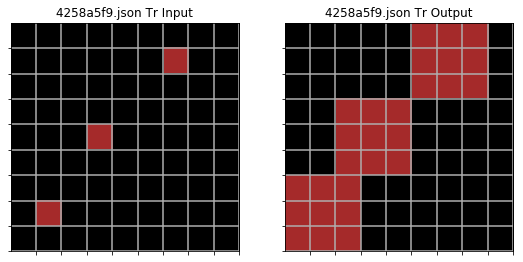

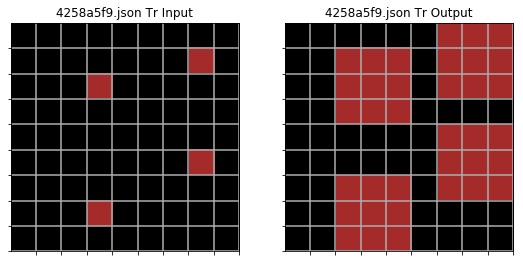

Expected Output


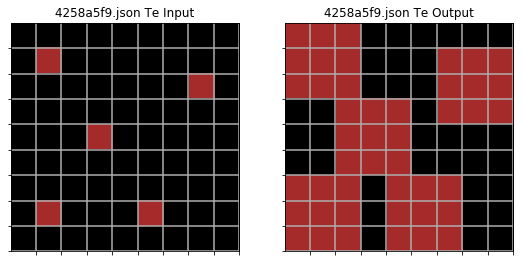

Actual Output


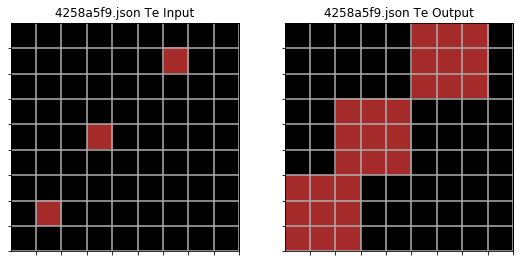

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 0.],
          [0., 0., 0., 9., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[0., 0., 0., 0., 0., 0., 9., 9., 9.],
          [0., 0., 9., 9., 9., 0., 9., 9., 9.],
          [0., 0., 9., 9., 9., 0., 9., 9., 9.],
          [0., 0., 9., 9., 9., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 9., 9., 9.],
          [0., 0., 0., 0., 0., 0., 9., 9., 9.],
          [0., 0., 9., 9., 9., 0., 9., 9., 9.],
          [0., 0., 9., 9., 9., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 0., 0., 0., 0.]]]])
pred   op grid tensor([[[[0., 0., 0., 0., 0., 0., 9., 9., 9.],
          [

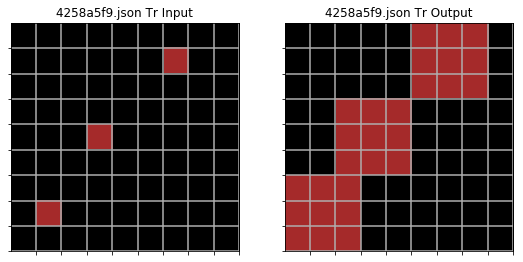

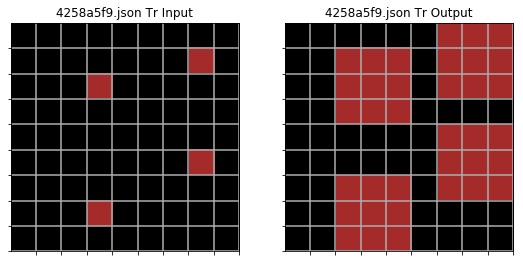

Expected Output


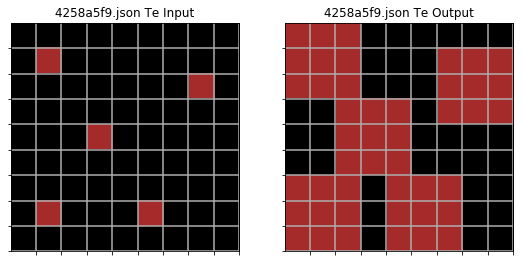

Actual Output


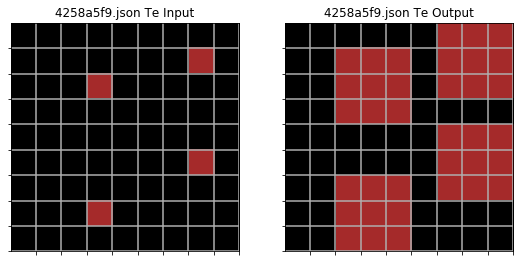

Task successfully solved.
actual ip grid tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 9., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 9., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 9., 0., 0., 0., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
actual op grid tensor([[[[9., 9., 9., 0., 0., 0., 0., 0., 0.],
          [9., 9., 9., 0., 0., 0., 9., 9., 9.],
          [9., 9., 9., 0., 0., 0., 9., 9., 9.],
          [0., 0., 9., 9., 9., 0., 9., 9., 9.],
          [0., 0., 9., 9., 9., 0., 0., 0., 0.],
          [0., 0., 9., 9., 9., 0., 0., 0., 0.],
          [9., 9., 9., 0., 9., 9., 9., 0., 0.],
          [9., 9., 9., 0., 9., 9., 9., 0., 0.],
          [9., 9., 9., 0., 9., 9., 9., 0., 0.]]]])
pred   op grid tensor([[[[9., 9., 9., 0., 0., 0., 0., 0., 0.],
          [

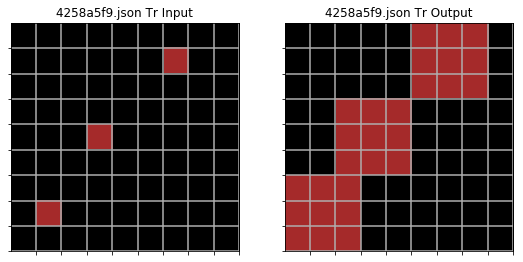

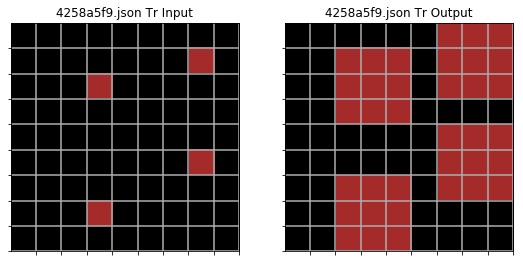

Expected Output


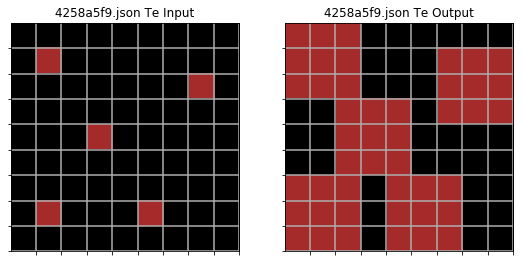

Actual Output


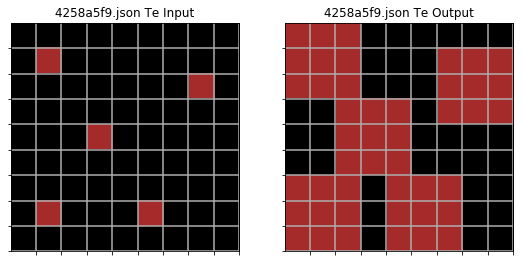

Task successfully solved.


In [149]:
i = 25
ttm = TrainTestModel(ON=9, OFF=0, B = None, kernel_size=3, pad=1, reduction='mean')
ttm.readData(onlyfiles_train[i], noAug=True)
ttm.train(epochs=1000, print_every=1, learning_rate=0.01, test_every=None)
ttm.test()
#Loss function: simple mean bce (no squaring)
#Status: Succesfully solved

In [103]:
newOFF = 0
newON = 9
ON = 9
OFF = 0
print(True and (newOFF is not OFF or newON is not ON))

False


In [128]:
# m = nn.Sigmoid()
# loss = nn.BCELoss(reduction='mean')
# input = torch.randn(3, requires_grad=True)
# print(input)
# target = torch.empty(3).random_(2)
# print(target)
# a = m(input)
# print(a)
# output = loss(a, target)
# print(output)
# output.backward()
# print(input.grad)

Challenges faced by Neural Nets
1. Precision of output
2. If does not see a particular pattern, it cannot generate the output. So, proper data augmenation would be required. (i = 19)
3. Limited vision. Conv net just see some spatially connected pixels. So need to design an architecture that see some pixels at some further distance to make decision. (i = 23, 33)
4. If input has too many random patterns and logic is to convert random pattern to a consistent shape, very difficult for a neural net to learn that. (i = 36, 41)